# GARCH Optiver Realized Volatility Prediction

# Realized volatility
When we trade options, a valuable input to our models is the standard deviation of the stock log returns. The standard deviation will be different for log returns computed over longer or shorter intervals, for this reason it is usually normalized to a 1-year period and the annualized standard deviation is called **volatility**. 

In this competition, you will be given 10 minutes of book data and we ask you to predict what the volatility will be in the following 10 minutes. Volatility will be measured as follows:

We will compute the log returns over all consecutive book updates and we define the **realized volatility, $\sigma$,** as the squared root of the sum of squared log returns.
$$
\sigma = \sqrt{\sum_{t}r_{t-1, t}^2}
$$
Where we use **WAP** as price of the stock to compute log returns.

We want to keep definitions as simple and clear as possible, so that Kagglers without financial knowledge will not be penalized. So we are not annualizing the volatility and we are assuming that log returns have 0 mean.

# Competition data
In this competition, Kagglers are challenged to generate a series of short-term signals from the book and trade data of a fixed 10-minute window to predict the realized volatility of the next 10-minute window. The target, which is given in train/test.csv, can be linked with the raw order book/trade data by the same **time_id** and **stock_id**. There is no overlap between the feature and target window.

Note that the competition data will come with partitioned parquet file. You can find a tutorial of parquet file handling in this [notebook](https://www.kaggle.com/sohier/working-with-parquet)

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import glob

path_vlad = '/Users/vladimir.levin/data/optiver-realized-volatility-prediction'
# path_laurent = ...

train = pd.read_csv(path_vlad + '/train.csv')
print(train.head())

# print(train['stock_id'].nunique())
# print(train['time_id'].unique())

   stock_id  time_id    target
0         0        5  0.004136
1         0       11  0.001445
2         0       16  0.002168
3         0       31  0.002195
4         0       62  0.001747


Taking the first row of data, it implies that the realized vol of the **target bucket** for time_id 5, stock_id 0 is 0.004136. How does the book and trade data in **feature bucket** look like for us to build signals?

In [ ]:
book_example = pd.read_parquet(path_vlad + '/book_train.parquet/stock_id=0')
trade_example =  pd.read_parquet(path_vlad + '/trade_train.parquet/stock_id=0')
stock_id = '0'
book_example = book_example[book_example['time_id']==5]
book_example.loc[:,'stock_id'] = stock_id
trade_example = trade_example[trade_example['time_id']==5]
trade_example.loc[:,'stock_id'] = stock_id

**book data snapshot**

In [ ]:
print(book_example.shape)
#book_example.to_csv('test_book.csv')
book_example.head(10)

**trade date snapshot**

In [ ]:
trade_example.head()

**Realized volatility calculation in python**

In this competition, our target is to predict short-term realized volatility. Although the order book and trade data for the target cannot be shared, we can still present the realized volatility calculation using the feature data we provided. 

As realized volatility is a statistical measure of price changes on a given stock, to calculate the price change we first need to have a stock valuation at the fixed interval (1 second). We will use weighted averaged price, or WAP, of the order book data we provided.

In [ ]:
book_example['wap'] = (book_example['bid_price1'] * book_example['ask_size1'] +
                                book_example['ask_price1'] * book_example['bid_size1']) / (
                                       book_example['bid_size1']+ book_example['ask_size1'])

**The WAP of the stock is plotted below**

In [ ]:
#fig = px.line(book_example, x="seconds_in_bucket", y="wap", title='WAP of stock_id_0, time_id_5')
#fig.show()
plt.figure(figsize=(15,10))
plt.plot(book_example['seconds_in_bucket'],book_example['wap'])
plt.xlabel('seconds in bucket')
plt.ylabel('wap')
plt.title('WAP of stock id 0 time id 5')
plt.show()

To compute the log return, we can simply take **the logarithm of the ratio** between two consecutive **WAP**. The first row will have an empty return as the previous book update is unknown, therefore the empty return data point will be dropped.

In [14]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

In [ ]:
book_example.loc[:,'log_return'] = log_return(book_example['wap'])
book_example = book_example[~book_example['log_return'].isnull()]

**Let's plot the tick-to-tick return of this instrument over this time bucket**

In [ ]:
#fig = px.line(book_example, x="seconds_in_bucket", y="log_return", title='Log return of stock_id_0, time_id_5')
plt.figure(figsize=(15,10))
plt.plot(book_example['seconds_in_bucket'],book_example['log_return'])
plt.xlabel('seconds in bucket')
plt.ylabel('log return')
plt.title('Log return of stock_id_0, time_id_5')
plt.show()

The realized vol of stock 0 in this feature bucket, will be:

In [3]:
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

In [2]:
realized_vol = realized_volatility(book_example['log_return'])
print(f'Realized volatility for stock_id 0 on time_id 5 is {realized_vol}')

NameError: name 'book_example' is not defined

# Naive prediction: using past realized volatility as target

A commonly known fact about volatility is that it tends to be autocorrelated. We can use this property to implement a naive model that just "predicts" realized volatility by using whatever the realized volatility was in the initial 10 minutes.

Let's calculate the past realized volatility across the training set to see how predictive a single naive signal can be.

In [4]:
import os
from sklearn.metrics import r2_score
import glob
list_order_book_file_train = glob.glob(path_vlad + '/book_train.parquet/*')

In [8]:
list_order_book_file_train[0]

'/Users/vladimir.levin/data/optiver-realized-volatility-prediction/book_train.parquet/stock_id=17'

As the data is partitioned by stock_id in this competition to allow Kagglers better manage the memory, we try to calculcate realized volatility stock by stock and combine them into one submission file. Note that the stock id as the partition column is not present if we load the single file so we will remedy that manually. We will reuse the log return and realized volatility functions defined in the previous session.

In [15]:
def realized_volatility_per_time_id(file_path, prediction_column_name):
    # read the data
    df_book_data = pd.read_parquet(file_path) 
    
    # calculate WAP     
    df_book_data['wap'] =(df_book_data['bid_price1'] * df_book_data['ask_size1'] + 
                          df_book_data['ask_price1'] * df_book_data['bid_size1'])  / \
                         (df_book_data['bid_size1']+ df_book_data['ask_size1'])
        
    # calculate log returns 
    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return)
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()]
    
    # calculater realized volatility
    df_realized_vol_per_stock =  \
        pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})
    
    # add row_id column to the data
    stock_id = file_path.split('=')[1]
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    
    # return the result
    return df_realized_vol_per_stock[['row_id',prediction_column_name]]

Looping through each individual stocks, we can get the past realized volatility as prediction for each individual stocks.

In [16]:
def past_realized_volatility_per_stock(list_file, prediction_column_name):
    
    # create empty dataframe to store the result
    df_past_realized = pd.DataFrame()
    
    # loop through files, calculate realized volatility and append it to the result
    for file in list_file:
        df_past_realized = pd.concat([df_past_realized,
                                     realized_volatility_per_time_id(file, prediction_column_name)])
    return df_past_realized


# run the function to naively predict realized volatility
df_past_realized_train = past_realized_volatility_per_stock(list_file = [list_order_book_file_train[0]],
                                                           prediction_column_name = 'pred')

In [17]:
#df_past_realized_train.to_csv('test_realized.csv')
df_past_realized_train

row_id      pred
0         17-5  0.004091
1        17-11  0.002155
2        17-16  0.002566
3        17-31  0.002221
4        17-62  0.002155
...        ...       ...
3825  17-32751  0.003227
3826  17-32753  0.002969
3827  17-32758  0.002157
3828  17-32763  0.003487
3829  17-32767  0.001638

[3830 rows x 2 columns]

In [18]:
train

stock_id  time_id    target
0              0        5  0.004136
1              0       11  0.001445
2              0       16  0.002168
3              0       31  0.002195
4              0       62  0.001747
...          ...      ...       ...
428927       126    32751  0.003461
428928       126    32753  0.003113
428929       126    32758  0.004070
428930       126    32763  0.003357
428931       126    32767  0.002090

[428932 rows x 3 columns]

Let's join the output dataframe with train.csv to see the performance of the naive prediction on training set.

In [20]:
train_check = train
train_check['row_id'] = train_check['stock_id'].astype(str) + '-' + train_check['time_id'].astype(str)
train_check = train_check[['row_id','target']]
df_joined = train_check.merge(df_past_realized_train[['row_id','pred']], on = ['row_id'], how = 'right')

In [21]:
df_joined

row_id    target      pred
0         17-5  0.004615  0.004091
1        17-11  0.002474  0.002155
2        17-16  0.002831  0.002566
3        17-31  0.002201  0.002221
4        17-62  0.002090  0.002155
...        ...       ...       ...
3825  17-32751  0.002470  0.003227
3826  17-32753  0.002465  0.002969
3827  17-32758  0.002946  0.002157
3828  17-32763  0.006927  0.003487
3829  17-32767  0.001967  0.001638

[3830 rows x 3 columns]

We will evaluate the naive prediction result by two metrics: RMSPE and R squared. 

In [22]:
from sklearn.metrics import r2_score
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))
R2 = round(r2_score(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
RMSPE = round(rmspe(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
print(f'Performance of the naive prediction: R2 score: {R2}, RMSPE: {RMSPE}')

Performance of the naive prediction: R2 score: 0.706, RMSPE: 0.294


The performance of the naive model is not amazing but as a benchmark it is a reasonable start.

# GARCH volatility prediction

## Some return exploration first

Plot log returns for the whole day aggregated by `time_id` (10-minute intervals)

In [23]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf # for acf plots
from statsmodels.graphics.tsaplots import plot_pacf # for pacf plots
from arch import arch_model

In [ ]:
# select the stock
file_path = list_order_book_file_train[0]

# read the data
df_book_data = pd.read_parquet(file_path) 

# select time_id (select the first one available)
mytime_id = df_book_data['time_id'].unique()[1]

# subset the data
df_book_data = df_book_data[df_book_data['time_id'] == mytime_id]

# calculate WAP     
df_book_data['wap'] =(df_book_data['bid_price1'] * df_book_data['ask_size1'] + 
                      df_book_data['ask_price1'] * df_book_data['bid_size1'])  / \
                     (df_book_data['bid_size1']+ df_book_data['ask_size1'])

# calculate log returns 
df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return)
df_book_data = df_book_data[~df_book_data['log_return'].isnull()]

# plot
fig = plt.figure()
fig.set_figwidth(12)
# plt.plot(df_book_data.groupby(['time_id'])['log_return'].agg(sum), label = '10-min Returns')
plt.plot(df_book_data['seconds_in_bucket'], df_book_data['log_return'], label = 'intra-10min Returns')
plt.legend(loc='upper right')
plt.title('Returns Over Time')
plt.show()

Lets plot the absolute values to check for clustering

In [ ]:
fig = plt.figure()
fig.set_figwidth(12)
plt.plot(df_book_data['seconds_in_bucket'], np.abs(df_book_data['log_return']), label = 'intra-10min Absolute Returns')
plt.legend(loc='upper right')
plt.title('Absolute Returns Over Time')
plt.show()

Let's see the ACF function for returns:

In [ ]:
# create acf plot for log returns
plot_acf(df_book_data['log_return'])
pyplot.show()

In [ ]:
# create acf plot for absolute log retunrs
plot_acf(np.abs(df_book_data['log_return']))
pyplot.show()

The absolute returns do not look autocorrelated.

### Let's actually aggregate unevenly spaced returns into 1 second returns

In [ ]:
# select the stock
file_path = list_order_book_file_train[0]

# read the data
df_book_data = pd.read_parquet(file_path) 

# select time_id (select the first one available)
mytime_id = df_book_data['time_id'].unique()[1]

# subset the data
df_book_data = df_book_data[df_book_data['time_id'] == mytime_id]

# calculate WAP     
df_book_data['wap'] =(df_book_data['bid_price1'] * df_book_data['ask_size1'] + 
                      df_book_data['ask_price1'] * df_book_data['bid_size1'])  / \
                     (df_book_data['bid_size1']+ df_book_data['ask_size1'])

In [ ]:
df_book_data_evenly = pd.DataFrame({'time_id':mytime_id, 'second':range(0,600)})

# the first row is always the same
df_evenly_remainder = df_book_data.iloc[0:1, 2:]


# create the rest of the table through a loop

for i in range(1, 600):
    df_evenly_remainder = df_evenly_remainder.append(df_book_data[df_book_data['seconds_in_bucket'] <= i].iloc[-1:, 2:])


# finally, reset the index and show the dataframe
df_evenly_remainder.reset_index(inplace=True, drop=True)

# concat two dataframes
df_book_data_evenly = pd.concat([df_book_data_evenly, df_evenly_remainder], axis=1)
df_book_data_evenly

In [ ]:
# calculate log returns 
df_book_data_evenly['log_return'] = df_book_data_evenly.groupby(['time_id'])['wap'].apply(log_return)
df_book_data_evenly = df_book_data_evenly[~df_book_data_evenly['log_return'].isnull()]

# plot
fig = plt.figure()
fig.set_figwidth(12)
plt.plot(df_book_data_evenly['second'], df_book_data_evenly['log_return'], label = '1 sec returns')
plt.legend(loc='upper right')
plt.title('Returns Over Time')
plt.show()

In [ ]:
fig = plt.figure()
fig.set_figwidth(12)
plt.plot(df_book_data_evenly['second'], np.abs(df_book_data_evenly['log_return']), label = '1 sec Absolute Returns')
plt.legend(loc='upper right')
plt.title('Absolute Returns Over Time')
plt.show()

In [ ]:
# create acf plot for absolute log retunrs
plot_acf(np.abs(df_book_data_evenly['log_return']))
pyplot.show()

This looks more autocorrelated!

## Fitting  GARCH(1, 1) model

Estimating GARCH(1,1) for a 10-minute interval

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')

In [ ]:
N = 10000
model = arch_model(df_book_data_evenly['log_return'] * N, p=1, q=1)
model_fit = model.fit(disp=False)
# yhat = model_fit.forecast(horizon=600, reindex=True)

In [ ]:
# # combine returns predictions with actual returns and plot
fig = plt.figure()
fig.set_figwidth(12)
plt.plot(pd.concat([np.abs(df_book_data_evenly['log_return']), pd.Series(yhat.variance.values[-1,:] / N)]).reset_index(drop=True), label = '1 sec Absolute Returns')
plt.legend(loc='upper right')
plt.title('Absolute Returns Over Time')
plt.show()

Now lets compute the realized volatility of the past returns and the prediction

In [ ]:
# past
past = realized_volatility(df_book_data_evenly['log_return'])

# GARCH prediction
predicted = realized_volatility(pd.Series(yhat.variance.values[-1,:] / N))

print(f'Realized volatility in: the interval = {round(past, 7)}, next interval prediction = : {round(predicted,7)}')

The volatility predicted by GARCH(1,1) model differs slightly from the naive prediction. Now let's do for every `time_id` and for every stock.

## Functions to compute predictions for each stock-time_id

In [140]:
def garch_fit_predict_volatility(returns_series, N=10000):
    model = arch_model(returns_series * N, p=5, q=5)
    model_fit = model.fit()
    yhat = model_fit.forecast(horizon=100, reindex=True)
    
    pred_volatility = realized_volatility(pd.Series(yhat.variance.values[-1,:] / N))
    
    return pred_volatility

In [141]:
def garch_volatility_per_time_id(file_path, prediction_column_name):
    # read the data
    df_book_data = pd.read_parquet(file_path) 
    
    # calculate WAP     
    df_book_data['wap'] =(df_book_data['bid_price1'] * df_book_data['ask_size1'] + 
                          df_book_data['ask_price1'] * df_book_data['bid_size1'])  / \
                         (df_book_data['bid_size1']+ df_book_data['ask_size1'])
    
    # leave only WAP for now
    df_book_data = df_book_data[['time_id', 'seconds_in_bucket', 'wap']]
    df_book_data = df_book_data.sort_values('seconds_in_bucket')
    
    # make the book updates evenly spaced
    df_book_data_evenly = pd.DataFrame({'time_id':np.repeat(df_book_data['time_id'].unique(), 600), 
                                        'second':np.tile(range(0,600), df_book_data['time_id'].nunique())})
    df_book_data_evenly['second'] = df_book_data_evenly['second'].astype(np.int16)
    df_book_data_evenly = df_book_data_evenly.sort_values('second')
    
    
    df_book_data_evenly = pd.merge_asof(df_book_data_evenly,
                           df_book_data,
                           left_on='second',right_on='seconds_in_bucket',
                           by = 'time_id')

    # Ordering for easier use
    df_book_data_evenly = df_book_data_evenly[['time_id', 'second','wap']]
    df_book_data_evenly = df_book_data_evenly.sort_values(['time_id','second']).reset_index(drop=True)
    
    
    # calculate log returns 
    df_book_data_evenly['log_return'] = df_book_data_evenly.groupby(['time_id'])['wap'].apply(log_return)
    df_book_data_evenly = df_book_data_evenly[~df_book_data_evenly['log_return'].isnull()]

    
    # calculater realized volatility
    df_garch_vol_per_stock =  \
        pd.DataFrame(df_book_data_evenly.groupby(['time_id'])['log_return'].agg(garch_fit_predict_volatility)).reset_index()
    df_garch_vol_per_stock = df_garch_vol_per_stock.rename(columns = {'log_return':prediction_column_name})
    
    # add row_id column to the data
    stock_id = file_path.split('=')[1]
    df_garch_vol_per_stock['row_id'] = df_garch_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    
    # return the result
    return df_garch_vol_per_stock[['row_id', prediction_column_name]]

In [142]:
garch_result = garch_volatility_per_time_id(list_order_book_file_train[0], 'pred');

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1532.2903263818348
Iteration:      2,   Func. Count:     29,   Neg. LLF: 27486.153802064473
Iteration:      3,   Func. Count:     44,   Neg. LLF: 25222.981917366174
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1262.7473689218386
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1226.1413614005469
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1235.2742179132465
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1201.9234259464565
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1157.307047108546
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1210.3495168072109
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1136.002760240217
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1148.0427597244284
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1134.6017426664848
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1129.080361314046
Iteration:     14,   Func. Count:    199,   Neg. LLF: 

Iteration:     10,   Func. Count:    143,   Neg. LLF: 1495.6020201526776
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1616.4043501491294
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1489.3126671139623
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1489.2357423095552
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1489.219591595299
Iteration:     15,   Func. Count:    211,   Neg. LLF: 1489.2047123859625
Iteration:     16,   Func. Count:    224,   Neg. LLF: 1489.1988560987488
Iteration:     17,   Func. Count:    237,   Neg. LLF: 1489.1978385241985
Iteration:     18,   Func. Count:    250,   Neg. LLF: 1489.1978098101224
Iteration:     19,   Func. Count:    263,   Neg. LLF: 1489.197801289983
Iteration:     20,   Func. Count:    276,   Neg. LLF: 1489.1977994924905
Iteration:     21,   Func. Count:    289,   Neg. LLF: 1493.2503218051197
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1489.1977994657532
            Itera

Iteration:     13,   Func. Count:    186,   Neg. LLF: 929.5466474177854
Iteration:     14,   Func. Count:    201,   Neg. LLF: 922.6401959999944
Iteration:     15,   Func. Count:    215,   Neg. LLF: 912.5875784494128
Iteration:     16,   Func. Count:    228,   Neg. LLF: 912.0884916936519
Iteration:     17,   Func. Count:    241,   Neg. LLF: 912.0725333125133
Iteration:     18,   Func. Count:    254,   Neg. LLF: 912.0618886804439
Iteration:     19,   Func. Count:    267,   Neg. LLF: 912.0613527248111
Iteration:     20,   Func. Count:    280,   Neg. LLF: 912.061338337978
Iteration:     21,   Func. Count:    293,   Neg. LLF: 912.0613373776876
Optimization terminated successfully    (Exit mode 0)
            Current function value: 912.0613373776876
            Iterations: 21
            Function evaluations: 293
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2115.4851558651317
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2372.90479669161

Iteration:      5,   Func. Count:     74,   Neg. LLF: 1135.2814407643043
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1270.845051370925
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1243.4138860995931
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1125.7094999989201
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1124.9449033786966
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1124.9190962331893
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1124.909040834524
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1124.9090228988152
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1124.9090221510855
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1124.9090221510855
            Iterations: 13
            Function evaluations: 182
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1901.361509178055
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1869.107

Iteration:      8,   Func. Count:    117,   Neg. LLF: 22699.693980151045
Iteration:      9,   Func. Count:    131,   Neg. LLF: 338.9664452202789
Iteration:     10,   Func. Count:    146,   Neg. LLF: 294.88520795311865
Iteration:     11,   Func. Count:    159,   Neg. LLF: 294.83137505670027
Iteration:     12,   Func. Count:    173,   Neg. LLF: 294.3210746042868
Iteration:     13,   Func. Count:    186,   Neg. LLF: 294.2435021972093
Iteration:     14,   Func. Count:    199,   Neg. LLF: 294.2128747206458
Iteration:     15,   Func. Count:    212,   Neg. LLF: 294.208109794293
Iteration:     16,   Func. Count:    225,   Neg. LLF: 294.2080625923198
Iteration:     17,   Func. Count:    238,   Neg. LLF: 294.2080614857589
Iteration:     18,   Func. Count:    250,   Neg. LLF: 294.2080614857745
Optimization terminated successfully    (Exit mode 0)
            Current function value: 294.2080614857589
            Iterations: 18
            Function evaluations: 250
            Gradient evaluations:

Iteration:      3,   Func. Count:     46,   Neg. LLF: 1713.1798693340397
Iteration:      4,   Func. Count:     62,   Neg. LLF: 837.8965922730271
Iteration:      5,   Func. Count:     77,   Neg. LLF: 727.0558732347843
Iteration:      6,   Func. Count:     91,   Neg. LLF: 621.4819988809966
Iteration:      7,   Func. Count:    105,   Neg. LLF: 676.654125675441
Iteration:      8,   Func. Count:    119,   Neg. LLF: 644.4809756055328
Iteration:      9,   Func. Count:    133,   Neg. LLF: 619.1972897967271
Iteration:     10,   Func. Count:    147,   Neg. LLF: 646.4146257604843
Iteration:     11,   Func. Count:    161,   Neg. LLF: 607.1498149024666
Iteration:     12,   Func. Count:    174,   Neg. LLF: 608.5861282361553
Iteration:     13,   Func. Count:    188,   Neg. LLF: 606.3670035557913
Iteration:     14,   Func. Count:    201,   Neg. LLF: 606.1034407939401
Iteration:     15,   Func. Count:    214,   Neg. LLF: 606.0601610784636
Iteration:     16,   Func. Count:    227,   Neg. LLF: 606.045516

Iteration:      1,   Func. Count:     14,   Neg. LLF: 9108.539986968495
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1541.2278242469824
Iteration:      3,   Func. Count:     45,   Neg. LLF: 2262.349716224497
Iteration:      4,   Func. Count:     61,   Neg. LLF: 1083.7972758988906
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1089.132853587601
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1097.1088575819012
Iteration:      7,   Func. Count:    104,   Neg. LLF: 1082.3794024211684
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1081.469135391761
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1082.701015415496
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1084.2023691690658
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1081.4022404545794
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1080.579853217006
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1082.7871745523378
Iteration:     14,   Func. Count:    200,   Neg. LLF: 108

Iteration:     11,   Func. Count:    154,   Neg. LLF: 1797.2098638159473
Iteration:     12,   Func. Count:    167,   Neg. LLF: 1797.20214140428
Iteration:     13,   Func. Count:    180,   Neg. LLF: 1797.1921175392145
Iteration:     14,   Func. Count:    193,   Neg. LLF: 1797.1782959414713
Iteration:     15,   Func. Count:    206,   Neg. LLF: 1797.1710887542063
Iteration:     16,   Func. Count:    219,   Neg. LLF: 1797.166358546771
Iteration:     17,   Func. Count:    232,   Neg. LLF: 1797.1663130380562
Iteration:     18,   Func. Count:    245,   Neg. LLF: 1797.166309299389
Iteration:     19,   Func. Count:    257,   Neg. LLF: 1797.16630936857
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1797.166309299389
            Iterations: 19
            Function evaluations: 257
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1667.5425626135716
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1772.3219673

Iteration:      5,   Func. Count:     74,   Neg. LLF: 914.4448916638408
Iteration:      6,   Func. Count:     88,   Neg. LLF: 912.038305249914
Iteration:      7,   Func. Count:    102,   Neg. LLF: 910.8198870314181
Iteration:      8,   Func. Count:    115,   Neg. LLF: 910.2221518199925
Iteration:      9,   Func. Count:    128,   Neg. LLF: 910.1948939044628
Iteration:     10,   Func. Count:    141,   Neg. LLF: 910.1862561085866
Iteration:     11,   Func. Count:    154,   Neg. LLF: 910.1853852386851
Iteration:     12,   Func. Count:    167,   Neg. LLF: 910.1853707403118
Iteration:     13,   Func. Count:    179,   Neg. LLF: 910.1853707403756
Optimization terminated successfully    (Exit mode 0)
            Current function value: 910.1853707403118
            Iterations: 13
            Function evaluations: 179
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2021.5776323539783
Iteration:      2,   Func. Count:     32,   Neg. LLF: 247965.353580166

Iteration:      4,   Func. Count:     59,   Neg. LLF: 2122.757595411914
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1809.6929075811036
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1781.4791150541128
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1832.5280879918296
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1849.3387575244947
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1777.7219678253166
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1777.6081904018754
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1777.4952453827332
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1777.3068725148273
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1776.5191902213992
Iteration:     14,   Func. Count:    196,   Neg. LLF: 1776.8796490595605
Iteration:     15,   Func. Count:    210,   Neg. LLF: 1785.932154537455
Iteration:     16,   Func. Count:    224,   Neg. LLF: 1777.5356406903306
Iteration:     17,   Func. Count:    238,   Neg. LLF:

Iteration:      3,   Func. Count:     46,   Neg. LLF: 86465.51804176823
Iteration:      4,   Func. Count:     60,   Neg. LLF: 871.581592356456
Iteration:      5,   Func. Count:     75,   Neg. LLF: 610.2448729283492
Iteration:      6,   Func. Count:     89,   Neg. LLF: 593.4439859312015
Iteration:      7,   Func. Count:    102,   Neg. LLF: 9018.211314246495
Iteration:      8,   Func. Count:    117,   Neg. LLF: 594.9272388307681
Iteration:      9,   Func. Count:    131,   Neg. LLF: 803.2082338646029
Iteration:     10,   Func. Count:    147,   Neg. LLF: 592.9117318148885
Iteration:     11,   Func. Count:    160,   Neg. LLF: 592.8949592215914
Iteration:     12,   Func. Count:    173,   Neg. LLF: 592.8879150553051
Iteration:     13,   Func. Count:    186,   Neg. LLF: 592.8874139707034
Iteration:     14,   Func. Count:    199,   Neg. LLF: 592.8874009248632
Iteration:     15,   Func. Count:    211,   Neg. LLF: 592.8874013202374
Optimization terminated successfully    (Exit mode 0)
           

Iteration:      5,   Func. Count:     75,   Neg. LLF: 831.2610481051006
Iteration:      6,   Func. Count:     88,   Neg. LLF: 830.5673739735632
Iteration:      7,   Func. Count:    101,   Neg. LLF: 828.7306344768781
Iteration:      8,   Func. Count:    114,   Neg. LLF: 827.6697398014837
Iteration:      9,   Func. Count:    127,   Neg. LLF: 827.0090606692652
Iteration:     10,   Func. Count:    140,   Neg. LLF: 826.5968855660266
Iteration:     11,   Func. Count:    153,   Neg. LLF: 826.1475816244365
Iteration:     12,   Func. Count:    166,   Neg. LLF: 825.9109685391109
Iteration:     13,   Func. Count:    179,   Neg. LLF: 825.8620324558419
Iteration:     14,   Func. Count:    192,   Neg. LLF: 825.8599097026383
Iteration:     15,   Func. Count:    205,   Neg. LLF: 825.8598560139408
Iteration:     16,   Func. Count:    218,   Neg. LLF: 825.8598540950068
Iteration:     17,   Func. Count:    230,   Neg. LLF: 825.8598546997897
Optimization terminated successfully    (Exit mode 0)
          

Iteration:      1,   Func. Count:     14,   Neg. LLF: 328028184.93260384
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1599.0718652122046
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1691.6047291735404
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1653.6941669247194
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1563.944701113633
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1601.6155832161721
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1548.2314909224078
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1549.0943120818697
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1544.3255276427683
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1541.1948936324563
Iteration:     11,   Func. Count:    159,   Neg. LLF: 1541.9919656127718
Iteration:     12,   Func. Count:    173,   Neg. LLF: 1541.851191452525
Iteration:     13,   Func. Count:    187,   Neg. LLF: 1548.6728713766115
Iteration:     14,   Func. Count:    201,   Neg. LLF:

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1549.1143532140572
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1608.9678438855929
Iteration:      3,   Func. Count:     44,   Neg. LLF: 36903.55784493195
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1545.0248822911676
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1325.04305944335
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1248.437315852459
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1242.2653944395215
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1242.3436394684277
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1304.1161511595747
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1242.9428223482976
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1240.9878294028163
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1240.7873029379143
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1240.7389492756865
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1599.2203953431433
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1689.4499947133525
Iteration:      3,   Func. Count:     44,   Neg. LLF: 60451.91986337119
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1370.2186543253906
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1104.9525971913133
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1169.152757885904
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1047.0153876132144
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1067.9113895196415
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1096.121424243809
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1081.5512887340997
Iteration:     11,   Func. Count:    159,   Neg. LLF: 1045.8634168467552
Iteration:     12,   Func. Count:    173,   Neg. LLF: 1044.759865638458
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1044.710652821544
Iteration:     14,   Func. Count:    199,   Neg. LLF: 10

Iteration:      1,   Func. Count:     14,   Neg. LLF: 137889.73419337376
Iteration:      2,   Func. Count:     29,   Neg. LLF: 970384.1472734554
Iteration:      3,   Func. Count:     44,   Neg. LLF: 2691.4256771805276
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1359.1398044928753
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1351.9762910700001
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1342.9495325159733
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1289.5410548304394
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1352.5911815472687
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1283.5998702002419
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1288.7413002612275
Iteration:     11,   Func. Count:    159,   Neg. LLF: 1301.5891432125927
Iteration:     12,   Func. Count:    174,   Neg. LLF: 1281.8379375949398
Iteration:     13,   Func. Count:    187,   Neg. LLF: 1282.3355364015129
Iteration:     14,   Func. Count:    201,   Neg. LLF

Iteration:     10,   Func. Count:    143,   Neg. LLF: 1073.2104388242524
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1077.0959629964073
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1073.4444241437504
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1072.9851763152155
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1072.9680420504053
Iteration:     15,   Func. Count:    210,   Neg. LLF: 1072.9550341898662
Iteration:     16,   Func. Count:    223,   Neg. LLF: 1072.9477990638636
Iteration:     17,   Func. Count:    236,   Neg. LLF: 1072.9476292419806
Iteration:     18,   Func. Count:    249,   Neg. LLF: 1072.9475851089019
Iteration:     19,   Func. Count:    262,   Neg. LLF: 1072.9475853343731
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1072.947584502624
            Iterations: 19
            Function evaluations: 263
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2129.1

Iteration:     24,   Func. Count:    340,   Neg. LLF: 1627.454803663063
Iteration:     25,   Func. Count:    355,   Neg. LLF: 1627.8009920445177
Iteration:     26,   Func. Count:    370,   Neg. LLF: 1626.4140234558354
Iteration:     27,   Func. Count:    384,   Neg. LLF: 1626.4131900784075
Iteration:     28,   Func. Count:    397,   Neg. LLF: 1626.4131675804501
Iteration:     29,   Func. Count:    410,   Neg. LLF: 1626.4131587843046
Iteration:     30,   Func. Count:    422,   Neg. LLF: 1626.413158287456
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1626.4131587843046
            Iterations: 31
            Function evaluations: 422
            Gradient evaluations: 30
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2184.192643848186
Iteration:      2,   Func. Count:     30,   Neg. LLF: 8269.776455441963
Iteration:      3,   Func. Count:     45,   Neg. LLF: 901.8316370890099
Iteration:      4,   Func. Count:     61,   Neg. LLF: 926.379979

Iteration:     17,   Func. Count:    237,   Neg. LLF: 587.2678208860552
Iteration:     18,   Func. Count:    250,   Neg. LLF: 587.2678194931647
Iteration:     19,   Func. Count:    262,   Neg. LLF: 587.2678201635877
Optimization terminated successfully    (Exit mode 0)
            Current function value: 587.2678194931647
            Iterations: 19
            Function evaluations: 262
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2522.734879000655
Iteration:      2,   Func. Count:     30,   Neg. LLF: 56861.546485200335
Iteration:      3,   Func. Count:     44,   Neg. LLF: 995.6873341538658
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1119.9791966669272
Iteration:      5,   Func. Count:     74,   Neg. LLF: 883.5452226128289
Iteration:      6,   Func. Count:     88,   Neg. LLF: 728.0191778522997
Iteration:      7,   Func. Count:    102,   Neg. LLF: 710.7447843378187
Iteration:      8,   Func. Count:    116,   Neg. LLF: 707.7670480107

Iteration:     17,   Func. Count:    239,   Neg. LLF: 1639.2185234575259
Iteration:     18,   Func. Count:    251,   Neg. LLF: 1639.2185234598405
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1639.2185234575259
            Iterations: 18
            Function evaluations: 251
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1850.5937277633648
Iteration:      2,   Func. Count:     31,   Neg. LLF: 1223.206331581413
Iteration:      3,   Func. Count:     47,   Neg. LLF: 722.0218772289445
Iteration:      4,   Func. Count:     61,   Neg. LLF: 831.6275819895236
Iteration:      5,   Func. Count:     76,   Neg. LLF: 690.6595391270536
Iteration:      6,   Func. Count:     89,   Neg. LLF: 708.7047424892896
Iteration:      7,   Func. Count:    103,   Neg. LLF: 685.6053170250597
Iteration:      8,   Func. Count:    116,   Neg. LLF: 2760.3548894465544
Iteration:      9,   Func. Count:    133,   Neg. LLF: 12278244646

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1726.1408299914956
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2235.7955482446105
Iteration:      3,   Func. Count:     43,   Neg. LLF: 2250.973503179226
Iteration:      4,   Func. Count:     58,   Neg. LLF: 2187.309546803937
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1713.8080204147243
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1685.1402194263896
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1878.277867530401
Iteration:      8,   Func. Count:    118,   Neg. LLF: 1621.197099370674
Iteration:      9,   Func. Count:    132,   Neg. LLF: 1622.462499370767
Iteration:     10,   Func. Count:    146,   Neg. LLF: 1625.9014762992142
Iteration:     11,   Func. Count:    160,   Neg. LLF: 1625.0123404677192
Iteration:     12,   Func. Count:    174,   Neg. LLF: 1620.1585435049194
Iteration:     13,   Func. Count:    187,   Neg. LLF: 1620.1509128623993
Iteration:     14,   Func. Count:    200,   Neg. LLF: 16

Iteration:      3,   Func. Count:     44,   Neg. LLF: 2113.374717933824
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1369.937869699203
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1304.9591049151115
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1342.4025189187767
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1274.7632519413996
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1346.4219466290665
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1274.4703105867688
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1274.4512375781792
Iteration:     11,   Func. Count:    155,   Neg. LLF: 1274.4506388138177
Iteration:     12,   Func. Count:    168,   Neg. LLF: 1274.4508814107783
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1274.4505034435754
Iteration:     14,   Func. Count:    194,   Neg. LLF: 1274.4505035277818
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1274.4505034435754
            Itera

Iteration:     10,   Func. Count:    143,   Neg. LLF: 1416.4664053228553
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1416.4643827384498
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1416.464194068538
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1416.4641622258337
Iteration:     14,   Func. Count:    194,   Neg. LLF: 1416.4641622259378
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1416.4641622258337
            Iterations: 14
            Function evaluations: 194
            Gradient evaluations: 14
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2080.6224674335263
Iteration:      2,   Func. Count:     30,   Neg. LLF: 42501.08807941776
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1529.6147014861497
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1220.5599971757201
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1139.7764560560195
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1130.85

Iteration:      9,   Func. Count:    132,   Neg. LLF: 430.79011095091664
Iteration:     10,   Func. Count:    146,   Neg. LLF: 429.2970208728107
Iteration:     11,   Func. Count:    160,   Neg. LLF: 395.6541896629732
Iteration:     12,   Func. Count:    174,   Neg. LLF: 398.3627322023379
Iteration:     13,   Func. Count:    188,   Neg. LLF: 383.7283264551865
Iteration:     14,   Func. Count:    201,   Neg. LLF: 387.8531610095961
Iteration:     15,   Func. Count:    215,   Neg. LLF: 405.6767668475941
Iteration:     16,   Func. Count:    230,   Neg. LLF: 381.3515588144054
Iteration:     17,   Func. Count:    244,   Neg. LLF: 380.4154351150915
Iteration:     18,   Func. Count:    258,   Neg. LLF: 380.2236664409602
Iteration:     19,   Func. Count:    271,   Neg. LLF: 379.992181728166
Iteration:     20,   Func. Count:    284,   Neg. LLF: 378.40361192117825
Iteration:     21,   Func. Count:    297,   Neg. LLF: 376.30304020997835
Iteration:     22,   Func. Count:    310,   Neg. LLF: 375.5976

Iteration:      4,   Func. Count:     59,   Neg. LLF: 666.9398747217676
Iteration:      5,   Func. Count:     75,   Neg. LLF: 617.4367897445119
Iteration:      6,   Func. Count:     89,   Neg. LLF: 629.9001275614326
Iteration:      7,   Func. Count:    103,   Neg. LLF: 619.364260763985
Iteration:      8,   Func. Count:    117,   Neg. LLF: 582.4245654311051
Iteration:      9,   Func. Count:    131,   Neg. LLF: 939.0107118990936
Iteration:     10,   Func. Count:    145,   Neg. LLF: 635.4662867772747
Iteration:     11,   Func. Count:    159,   Neg. LLF: 575.5880603783714
Iteration:     12,   Func. Count:    173,   Neg. LLF: 613.2521615220393
Iteration:     13,   Func. Count:    187,   Neg. LLF: 565.9871098262812
Iteration:     14,   Func. Count:    200,   Neg. LLF: 565.0297288282459
Iteration:     15,   Func. Count:    213,   Neg. LLF: 564.4769207954485
Iteration:     16,   Func. Count:    226,   Neg. LLF: 563.5887189665442
Iteration:     17,   Func. Count:    239,   Neg. LLF: 569.7916000

Iteration:      2,   Func. Count:     29,   Neg. LLF: 2002.1637489227858
Iteration:      3,   Func. Count:     43,   Neg. LLF: 12242.283126864553
Iteration:      4,   Func. Count:     57,   Neg. LLF: 9232.915486850834
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1048.5446667124459
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1034.9385410212399
Iteration:      7,   Func. Count:     99,   Neg. LLF: 1059.3030438291985
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1045.7399339414922
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1034.124500450474
Iteration:     10,   Func. Count:    141,   Neg. LLF: 1034.1158074267341
Iteration:     11,   Func. Count:    154,   Neg. LLF: 1034.1138722079359
Iteration:     12,   Func. Count:    167,   Neg. LLF: 1034.113747844455
Iteration:     13,   Func. Count:    180,   Neg. LLF: 1034.1137292669105
Iteration:     14,   Func. Count:    193,   Neg. LLF: 1034.1137286960852
Optimization terminated successfully    (Exit mode 0)


Iteration:      1,   Func. Count:     14,   Neg. LLF: 1692.0682687490003
Iteration:      2,   Func. Count:     31,   Neg. LLF: 13647.101948768875
Iteration:      3,   Func. Count:     46,   Neg. LLF: 2108.824166226244
Iteration:      4,   Func. Count:     61,   Neg. LLF: 1810.8250293622445
Iteration:      5,   Func. Count:     76,   Neg. LLF: 1477.2141378951746
Iteration:      6,   Func. Count:     90,   Neg. LLF: 1471.9174884064487
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1472.0476138942754
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1471.8294940633032
Iteration:      9,   Func. Count:    132,   Neg. LLF: 1474.967001201978
Iteration:     10,   Func. Count:    147,   Neg. LLF: 1472.0796442022047
Iteration:     11,   Func. Count:    161,   Neg. LLF: 1471.7515308029085
Iteration:     12,   Func. Count:    174,   Neg. LLF: 1471.722952601898
Iteration:     13,   Func. Count:    187,   Neg. LLF: 1471.716675673882
Iteration:     14,   Func. Count:    200,   Neg. LLF: 1

Iteration:     15,   Func. Count:    209,   Neg. LLF: 1104.11064591771
Iteration:     16,   Func. Count:    222,   Neg. LLF: 1104.1105474551646
Iteration:     17,   Func. Count:    235,   Neg. LLF: 1185.0944419057973
Iteration:     18,   Func. Count:    251,   Neg. LLF: 1104.3968259494673
Iteration:     19,   Func. Count:    267,   Neg. LLF: 1104.3285302357822
Iteration:     20,   Func. Count:    283,   Neg. LLF: 1104.2230630294703
Iteration:     21,   Func. Count:    299,   Neg. LLF: 1104.1255881878837
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1104.1105352613076
            Iterations: 22
            Function evaluations: 302
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1179297962.0849762
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2029.9379045055152
Iteration:      3,   Func. Count:     46,   Neg. LLF: 1967.968265564623
Iteration:      4,   Func. Count:     62,   Neg. LLF: 900.3981

Iteration:     10,   Func. Count:    145,   Neg. LLF: 845.5636339886914
Iteration:     11,   Func. Count:    160,   Neg. LLF: 829.4966733313277
Iteration:     12,   Func. Count:    173,   Neg. LLF: 828.6786528159807
Iteration:     13,   Func. Count:    186,   Neg. LLF: 828.6051078064913
Iteration:     14,   Func. Count:    199,   Neg. LLF: 828.5878844589224
Iteration:     15,   Func. Count:    212,   Neg. LLF: 828.5853992980767
Iteration:     16,   Func. Count:    225,   Neg. LLF: 828.5848049650247
Iteration:     17,   Func. Count:    238,   Neg. LLF: 828.5847005645352
Iteration:     18,   Func. Count:    251,   Neg. LLF: 828.5846903702048
Iteration:     19,   Func. Count:    264,   Neg. LLF: 828.5846884587863
Iteration:     20,   Func. Count:    276,   Neg. LLF: 828.584688458743
Optimization terminated successfully    (Exit mode 0)
            Current function value: 828.5846884587863
            Iterations: 20
            Function evaluations: 276
            Gradient evaluations: 20

Iteration:     10,   Func. Count:    144,   Neg. LLF: 975.4767862848803
Iteration:     11,   Func. Count:    157,   Neg. LLF: 975.2242571618433
Iteration:     12,   Func. Count:    170,   Neg. LLF: 975.1404183235886
Iteration:     13,   Func. Count:    183,   Neg. LLF: 998.0843264552742
Iteration:     14,   Func. Count:    198,   Neg. LLF: 978.6394729094932
Iteration:     15,   Func. Count:    213,   Neg. LLF: 975.0531880330427
Iteration:     16,   Func. Count:    226,   Neg. LLF: 975.0525741088031
Iteration:     17,   Func. Count:    239,   Neg. LLF: 1405.917012685009
Iteration:     18,   Func. Count:    256,   Neg. LLF: 975.5341404886302
Optimization terminated successfully    (Exit mode 0)
            Current function value: 975.0525695662349
            Iterations: 19
            Function evaluations: 259
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1876.5531293550807
Iteration:      2,   Func. Count:     30,   Neg. LLF: 3612845.4802544

Iteration:     10,   Func. Count:    145,   Neg. LLF: 1487.7920533838987
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1489.358698965907
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1487.6503119807635
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1487.6220261275143
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1487.6178275615998
Iteration:     15,   Func. Count:    211,   Neg. LLF: 1487.6170394454305
Iteration:     16,   Func. Count:    224,   Neg. LLF: 1487.616829193693
Iteration:     17,   Func. Count:    237,   Neg. LLF: 1487.6166676620292
Iteration:     18,   Func. Count:    250,   Neg. LLF: 1487.6165152456583
Iteration:     19,   Func. Count:    263,   Neg. LLF: 1487.6163797065162
Iteration:     20,   Func. Count:    276,   Neg. LLF: 1487.6163280383198
Iteration:     21,   Func. Count:    289,   Neg. LLF: 1487.6163203330261
Iteration:     22,   Func. Count:    301,   Neg. LLF: 1487.6163204595719
Optimization terminated successfully    (Exit mode 0)

Iteration:     10,   Func. Count:    143,   Neg. LLF: 1085.2191462112319
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1084.9704809255225
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1084.9646786632218
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1084.9645243155533
Iteration:     14,   Func. Count:    196,   Neg. LLF: 1084.9645072370988
Iteration:     15,   Func. Count:    209,   Neg. LLF: 1084.9645032489107
Iteration:     16,   Func. Count:    221,   Neg. LLF: 1084.964503351774
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1084.9645032489107
            Iterations: 16
            Function evaluations: 221
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     14,   Neg. LLF: 20150.18239735147
Iteration:      2,   Func. Count:     30,   Neg. LLF: 3864082.4640640803
Iteration:      3,   Func. Count:     46,   Neg. LLF: 1335.9913617254892
Iteration:      4,   Func. Count:     61,   Neg. LLF: 1306.97

Iteration:     17,   Func. Count:    232,   Neg. LLF: 1317.2785626758814
Iteration:     18,   Func. Count:    245,   Neg. LLF: 1317.2779583420952
Iteration:     19,   Func. Count:    258,   Neg. LLF: 1317.2778328997583
Iteration:     20,   Func. Count:    271,   Neg. LLF: 1317.2778204975662
Iteration:     21,   Func. Count:    284,   Neg. LLF: 1317.2778195410554
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1317.2778195410554
            Iterations: 21
            Function evaluations: 284
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2030535.4037323114
Iteration:      2,   Func. Count:     29,   Neg. LLF: 5209.745654571297
Iteration:      3,   Func. Count:     44,   Neg. LLF: 844.9590464768571
Iteration:      4,   Func. Count:     59,   Neg. LLF: 773.5134413177346
Iteration:      5,   Func. Count:     73,   Neg. LLF: 2103.6766613879527
Iteration:      6,   Func. Count:     87,   Neg. LLF: 18576.36

Iteration:     23,   Func. Count:    321,   Neg. LLF: 1007.8345978818204
Iteration:     24,   Func. Count:    334,   Neg. LLF: 1007.8345952211182
Iteration:     25,   Func. Count:    347,   Neg. LLF: 2068.148457629967
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1007.8345948608554
            Iterations: 26
            Function evaluations: 352
            Gradient evaluations: 25
Iteration:      1,   Func. Count:     14,   Neg. LLF: 10451.972042563535
Iteration:      2,   Func. Count:     31,   Neg. LLF: 250565.84366987034
Iteration:      3,   Func. Count:     45,   Neg. LLF: 497.2574639791179
Iteration:      4,   Func. Count:     61,   Neg. LLF: 401.35394736214124
Iteration:      5,   Func. Count:     75,   Neg. LLF: 221.480531449622
Iteration:      6,   Func. Count:     89,   Neg. LLF: 213.47625801112724
Iteration:      7,   Func. Count:    103,   Neg. LLF: 222.57198130904783
Iteration:      8,   Func. Count:    117,   Neg. LLF: 212.29671

Iteration:     21,   Func. Count:    295,   Neg. LLF: 1153.3281210557602
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1153.3281210555053
            Iterations: 21
            Function evaluations: 295
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2266.8795713248055
Iteration:      2,   Func. Count:     30,   Neg. LLF: 5031.720988552404
Iteration:      3,   Func. Count:     45,   Neg. LLF: 614.9302083063676
Iteration:      4,   Func. Count:     61,   Neg. LLF: 506.9408416052432
Iteration:      5,   Func. Count:     76,   Neg. LLF: 992.0301687249832
Iteration:      6,   Func. Count:     90,   Neg. LLF: 699.8323266849964
Iteration:      7,   Func. Count:    104,   Neg. LLF: 1081.2605025505522
Iteration:      8,   Func. Count:    118,   Neg. LLF: 467.35858804931263
Iteration:      9,   Func. Count:    132,   Neg. LLF: 529.261884858189
Iteration:     10,   Func. Count:    146,   Neg. LLF: 476.20083872

Iteration:      6,   Func. Count:     87,   Neg. LLF: 1186.942789643148
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1287.7519876904998
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1143.1365861882523
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1143.0402459050458
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1144.748264709911
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1142.9840986448728
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1142.9819175333928
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1142.9818017623484
Iteration:     14,   Func. Count:    194,   Neg. LLF: 1142.9818018402325
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1142.9818017623484
            Iterations: 14
            Function evaluations: 194
            Gradient evaluations: 14
Iteration:      1,   Func. Count:     14,   Neg. LLF: 5890.174972324145
Iteration:      2,   Func. Count:     29,   Neg. LLF: 215860.5

Iteration:      8,   Func. Count:    122,   Neg. LLF: 811.1748375789282
Iteration:      9,   Func. Count:    136,   Neg. LLF: 791.646372431127
Iteration:     10,   Func. Count:    149,   Neg. LLF: 791.3429046473199
Iteration:     11,   Func. Count:    162,   Neg. LLF: 791.2491666780573
Iteration:     12,   Func. Count:    175,   Neg. LLF: 790.958251797111
Iteration:     13,   Func. Count:    188,   Neg. LLF: 790.5745488253172
Iteration:     14,   Func. Count:    201,   Neg. LLF: 790.1249496753558
Iteration:     15,   Func. Count:    214,   Neg. LLF: 789.8174067097068
Iteration:     16,   Func. Count:    227,   Neg. LLF: 789.6487218451044
Iteration:     17,   Func. Count:    240,   Neg. LLF: 789.5475804744275
Iteration:     18,   Func. Count:    253,   Neg. LLF: 789.5026837961123
Iteration:     19,   Func. Count:    266,   Neg. LLF: 789.4811561606982
Iteration:     20,   Func. Count:    279,   Neg. LLF: 789.4678160556309
Iteration:     21,   Func. Count:    292,   Neg. LLF: 789.45848484

Iteration:      1,   Func. Count:     14,   Neg. LLF: 423654365.37010014
Iteration:      2,   Func. Count:     29,   Neg. LLF: 245580.37105465002
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1874.4472726219688
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1749.2996390666349
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1697.858681481025
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1801.7389548638862
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1700.6009183663355
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1683.7193505724865
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1712.6675064805286
Iteration:     10,   Func. Count:    143,   Neg. LLF: 2697.200692661619
Iteration:     11,   Func. Count:    158,   Neg. LLF: 7490.975562263027
Iteration:     12,   Func. Count:    174,   Neg. LLF: 1716.8084215025344
Iteration:     13,   Func. Count:    189,   Neg. LLF: 1699.7169528523295
Iteration:     14,   Func. Count:    204,   Neg. LLF: 

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1261.5570973495496
Iteration:      2,   Func. Count:     34,   Neg. LLF: 51715.65088979081
Iteration:      3,   Func. Count:     49,   Neg. LLF: 1606.8207441523164
Iteration:      4,   Func. Count:     65,   Neg. LLF: 817.7632777211405
Iteration:      5,   Func. Count:     79,   Neg. LLF: 801.5195891309662
Iteration:      6,   Func. Count:     92,   Neg. LLF: 970.1427126747825
Iteration:      7,   Func. Count:    108,   Neg. LLF: 3349.887114063812
Iteration:      8,   Func. Count:    131,   Neg. LLF: 2366.313110100339
Iteration:      9,   Func. Count:    150,   Neg. LLF: 3398.5972880110517
Iteration:     10,   Func. Count:    166,   Neg. LLF: 800.93371350982
Iteration:     11,   Func. Count:    179,   Neg. LLF: 845.1390749948971
Iteration:     12,   Func. Count:    194,   Neg. LLF: 1822.9848526273215
Iteration:     13,   Func. Count:    217,   Neg. LLF: 2657.9208395360574
Iteration:     14,   Func. Count:    235,   Neg. LLF: 4393.37

Iteration:      2,   Func. Count:     31,   Neg. LLF: 58885.200245840344
Iteration:      3,   Func. Count:     46,   Neg. LLF: 2313.3388146710095
Iteration:      4,   Func. Count:     62,   Neg. LLF: 1210.4921962808428
Iteration:      5,   Func. Count:     78,   Neg. LLF: 1206.863475175633
Iteration:      6,   Func. Count:     91,   Neg. LLF: 1207.2000954464775
Iteration:      7,   Func. Count:    106,   Neg. LLF: 1214.783186463663
Iteration:      8,   Func. Count:    120,   Neg. LLF: 1206.6418601407358
Iteration:      9,   Func. Count:    134,   Neg. LLF: 1205.9591063307664
Iteration:     10,   Func. Count:    147,   Neg. LLF: 1205.860233770615
Iteration:     11,   Func. Count:    160,   Neg. LLF: 1205.8076939157052
Iteration:     12,   Func. Count:    173,   Neg. LLF: 1205.7986118858275
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1205.7968775168201
Iteration:     14,   Func. Count:    199,   Neg. LLF: 1205.796786691256
Iteration:     15,   Func. Count:    212,   Neg. LLF: 1

Iteration:      7,   Func. Count:    106,   Neg. LLF: 1078.8512266779421
Iteration:      8,   Func. Count:    120,   Neg. LLF: 1078.4504635549952
Iteration:      9,   Func. Count:    134,   Neg. LLF: 1070.7268832796624
Iteration:     10,   Func. Count:    147,   Neg. LLF: 1148.7419701796496
Iteration:     11,   Func. Count:    162,   Neg. LLF: 1080.1417019026917
Iteration:     12,   Func. Count:    176,   Neg. LLF: 1069.9316314948824
Iteration:     13,   Func. Count:    189,   Neg. LLF: 1069.80884618346
Iteration:     14,   Func. Count:    202,   Neg. LLF: 1069.8009905601589
Iteration:     15,   Func. Count:    215,   Neg. LLF: 1069.7976438037629
Iteration:     16,   Func. Count:    228,   Neg. LLF: 1069.7935100873378
Iteration:     17,   Func. Count:    241,   Neg. LLF: 1069.7922683779257
Iteration:     18,   Func. Count:    254,   Neg. LLF: 462131163.7846714
Iteration:     19,   Func. Count:    271,   Neg. LLF: 1120.4501015308879
Iteration:     20,   Func. Count:    287,   Neg. LLF: 

Iteration:     10,   Func. Count:    143,   Neg. LLF: 862.7609596879654
Iteration:     11,   Func. Count:    157,   Neg. LLF: 782.1730423025683
Iteration:     12,   Func. Count:    171,   Neg. LLF: 785.1211588882857
Iteration:     13,   Func. Count:    185,   Neg. LLF: 775.036462597878
Iteration:     14,   Func. Count:    198,   Neg. LLF: 775.3064583842205
Iteration:     15,   Func. Count:    212,   Neg. LLF: 773.806582046602
Iteration:     16,   Func. Count:    225,   Neg. LLF: 773.3455183719982
Iteration:     17,   Func. Count:    238,   Neg. LLF: 773.2868105840535
Iteration:     18,   Func. Count:    251,   Neg. LLF: 773.1046292094893
Iteration:     19,   Func. Count:    264,   Neg. LLF: 773.0298318212417
Iteration:     20,   Func. Count:    277,   Neg. LLF: 773.008619640068
Iteration:     21,   Func. Count:    290,   Neg. LLF: 773.0052564525192
Iteration:     22,   Func. Count:    303,   Neg. LLF: 773.0048827929609
Iteration:     23,   Func. Count:    316,   Neg. LLF: 773.004828904

Iteration:     11,   Func. Count:    156,   Neg. LLF: 865.8220561859539
Iteration:     12,   Func. Count:    171,   Neg. LLF: 749.3292536441393
Iteration:     13,   Func. Count:    188,   Neg. LLF: 751.864994092344
Iteration:     14,   Func. Count:    202,   Neg. LLF: 740.1677342859771
Iteration:     15,   Func. Count:    215,   Neg. LLF: 740.1807382229708
Iteration:     16,   Func. Count:    229,   Neg. LLF: 740.0087909895303
Iteration:     17,   Func. Count:    242,   Neg. LLF: 739.9976796077672
Iteration:     18,   Func. Count:    255,   Neg. LLF: 813467302.7084401
Iteration:     19,   Func. Count:    273,   Neg. LLF: 1390.8655272512497
Iteration:     20,   Func. Count:    290,   Neg. LLF: 784.021877337946
Iteration:     21,   Func. Count:    306,   Neg. LLF: 781.2283508755528
Iteration:     22,   Func. Count:    322,   Neg. LLF: 740.0776611146248
Iteration:     23,   Func. Count:    337,   Neg. LLF: 739.9945474575279
Iteration:     24,   Func. Count:    350,   Neg. LLF: 743.1247780

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1994.7304381980239
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2076.196223718888
Iteration:      3,   Func. Count:     45,   Neg. LLF: 55011.97062320127
Iteration:      4,   Func. Count:     59,   Neg. LLF: 818.4890354946493
Iteration:      5,   Func. Count:     73,   Neg. LLF: 807.1790581897842
Iteration:      6,   Func. Count:     86,   Neg. LLF: 323038.4445972303
Iteration:      7,   Func. Count:    101,   Neg. LLF: 867.6594363276934
Iteration:      8,   Func. Count:    116,   Neg. LLF: 828.1879661842668
Iteration:      9,   Func. Count:    131,   Neg. LLF: 935.6671972622171
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1753.6943178565243
Iteration:     11,   Func. Count:    159,   Neg. LLF: 804.3463332976079
Iteration:     12,   Func. Count:    173,   Neg. LLF: 844.3083006159411
Iteration:     13,   Func. Count:    188,   Neg. LLF: 803.4147728815396
Iteration:     14,   Func. Count:    201,   Neg. LLF: 803.6910

Iteration:      7,   Func. Count:     99,   Neg. LLF: 1537.2940160522871
Iteration:      8,   Func. Count:    112,   Neg. LLF: 1536.4827809899796
Iteration:      9,   Func. Count:    125,   Neg. LLF: 1534.935981938569
Iteration:     10,   Func. Count:    138,   Neg. LLF: 1534.4401023131982
Iteration:     11,   Func. Count:    151,   Neg. LLF: 1534.205626154143
Iteration:     12,   Func. Count:    164,   Neg. LLF: 1534.0247361657748
Iteration:     13,   Func. Count:    177,   Neg. LLF: 1533.8971584990124
Iteration:     14,   Func. Count:    190,   Neg. LLF: 1533.6444240068972
Iteration:     15,   Func. Count:    203,   Neg. LLF: 1533.5886559967225
Iteration:     16,   Func. Count:    216,   Neg. LLF: 1533.595811007734
Iteration:     17,   Func. Count:    230,   Neg. LLF: 1533.5682881568143
Iteration:     18,   Func. Count:    243,   Neg. LLF: 1533.595453728358
Iteration:     19,   Func. Count:    257,   Neg. LLF: 1563.8885747316494
Iteration:     20,   Func. Count:    272,   Neg. LLF: 1

Iteration:     10,   Func. Count:    144,   Neg. LLF: 1260.4892733140966
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1260.166625270877
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1259.9117372914723
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1259.9055194682524
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1259.9008223297847
Iteration:     15,   Func. Count:    211,   Neg. LLF: 1259.9008128626497
Iteration:     16,   Func. Count:    224,   Neg. LLF: 1259.9008113759282
Iteration:     17,   Func. Count:    237,   Neg. LLF: 1259.9008108093067
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1259.9008108093067
            Iterations: 17
            Function evaluations: 237
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 4844.183311822207
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2159.196188909319
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1486.706

Iteration:      3,   Func. Count:     44,   Neg. LLF: 14635.59017066721
Iteration:      4,   Func. Count:     58,   Neg. LLF: 2612.334716539238
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1349.2042736634844
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1286.5798432064455
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1934.5821821538161
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1278.4549525310244
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1266.9367315243676
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1260.3556728759922
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1262.7207210758531
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1262.503521345347
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1251.9411901463614
Iteration:     14,   Func. Count:    200,   Neg. LLF: 1249.8703803823091
Iteration:     15,   Func. Count:    213,   Neg. LLF: 1254.8799818887662
Iteration:     16,   Func. Count:    227,   Neg. LLF: 

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2674.5469514668885
Iteration:      2,   Func. Count:     31,   Neg. LLF: 1453.0710308043595
Iteration:      3,   Func. Count:     48,   Neg. LLF: 1444.4496489276262
Iteration:      4,   Func. Count:     62,   Neg. LLF: 1475.8955456648055
Iteration:      5,   Func. Count:     76,   Neg. LLF: 1433.9426398671949
Iteration:      6,   Func. Count:     90,   Neg. LLF: 1440.9789702955213
Iteration:      7,   Func. Count:    104,   Neg. LLF: 1431.0224330299384
Iteration:      8,   Func. Count:    118,   Neg. LLF: 1437.6873553245537
Iteration:      9,   Func. Count:    132,   Neg. LLF: 1428.0926219336047
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1434.6398383517096
Iteration:     11,   Func. Count:    159,   Neg. LLF: 1430.2865097572994
Iteration:     12,   Func. Count:    174,   Neg. LLF: 1427.5959333295207
Iteration:     13,   Func. Count:    187,   Neg. LLF: 1429.1377362748553
Iteration:     14,   Func. Count:    201,   Neg. LL

Iteration:     23,   Func. Count:    331,   Neg. LLF: 833.5051494602392
Iteration:     24,   Func. Count:    347,   Neg. LLF: 832.159243300496
Iteration:     25,   Func. Count:    361,   Neg. LLF: 832.1475589673366
Iteration:     26,   Func. Count:    374,   Neg. LLF: 832.1474734891328
Iteration:     27,   Func. Count:    387,   Neg. LLF: 832.147473027801
Optimization terminated successfully    (Exit mode 0)
            Current function value: 832.147473027801
            Iterations: 28
            Function evaluations: 387
            Gradient evaluations: 27
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2066.8366768780097
Iteration:      2,   Func. Count:     30,   Neg. LLF: 19850.336178226207
Iteration:      3,   Func. Count:     44,   Neg. LLF: 985.828159340499
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1069.7102314331937
Iteration:      5,   Func. Count:     74,   Neg. LLF: 837.8934218822966
Iteration:      6,   Func. Count:     88,   Neg. LLF: 861.5991730501067

Iteration:      1,   Func. Count:     14,   Neg. LLF: 13392.108640539427
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1405.4733124099218
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1052.7150973608932
Iteration:      4,   Func. Count:     59,   Neg. LLF: 995.7491718598826
Iteration:      5,   Func. Count:     73,   Neg. LLF: 958.9407442491885
Iteration:      6,   Func. Count:     87,   Neg. LLF: 954.6969756026216
Iteration:      7,   Func. Count:    101,   Neg. LLF: 986.5034669764293
Iteration:      8,   Func. Count:    115,   Neg. LLF: 951.1494402317012
Iteration:      9,   Func. Count:    128,   Neg. LLF: 974.4901964483341
Iteration:     10,   Func. Count:    143,   Neg. LLF: 961.6044493956292
Iteration:     11,   Func. Count:    157,   Neg. LLF: 950.246569967824
Iteration:     12,   Func. Count:    170,   Neg. LLF: 950.1895922629201
Iteration:     13,   Func. Count:    183,   Neg. LLF: 950.1857186855436
Iteration:     14,   Func. Count:    196,   Neg. LLF: 950.1846

Iteration:      2,   Func. Count:     29,   Neg. LLF: 3124.1742726971966
Iteration:      3,   Func. Count:     44,   Neg. LLF: 54314.48550931063
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1187.2430099233322
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1183.2209933874615
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1335.5303036318887
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1264.1968866789048
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1184.676430768258
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1188.0142310661931
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1179.7577041394698
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1468.0671481971517
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1180.0178876037212
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1179.4523345883554
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1179.4345158631872
Iteration:     15,   Func. Count:    210,   Neg. LLF:

Iteration:      3,   Func. Count:     44,   Neg. LLF: 1277.9972770657796
Iteration:      4,   Func. Count:     60,   Neg. LLF: 13188.211608513393
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1250.2002018126414
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1268.2240407141971
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1242.822847138131
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1224.1467379158444
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1221.1271919197532
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1233.3373269048695
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1218.1477328494566
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1229.9445157293271
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1225.6678829360699
Iteration:     14,   Func. Count:    199,   Neg. LLF: 1221.5765398423623
Iteration:     15,   Func. Count:    213,   Neg. LLF: 1220.00916762015
Iteration:     16,   Func. Count:    227,   Neg. LLF: 

Iteration:      1,   Func. Count:     14,   Neg. LLF: 595020299.9443967
Iteration:      2,   Func. Count:     29,   Neg. LLF: 193913.12698000643
Iteration:      3,   Func. Count:     43,   Neg. LLF: 3824.331953673258
Iteration:      4,   Func. Count:     57,   Neg. LLF: 1611.1132494409337
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1582.1829973611216
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1565.7480036957804
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1566.3586904235503
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1563.9176039488798
Iteration:      9,   Func. Count:    128,   Neg. LLF: 783363856.3556402
Iteration:     10,   Func. Count:    144,   Neg. LLF: 3036.94568495573
Iteration:     11,   Func. Count:    160,   Neg. LLF: 1566.7526392575407
Iteration:     12,   Func. Count:    174,   Neg. LLF: 1561.4757848087015
Iteration:     13,   Func. Count:    188,   Neg. LLF: 1531.4286959595206
Iteration:     14,   Func. Count:    201,   Neg. LLF: 17

Iteration:     11,   Func. Count:    155,   Neg. LLF: 460.9824504658783
Iteration:     12,   Func. Count:    168,   Neg. LLF: 460.97883039183534
Iteration:     13,   Func. Count:    181,   Neg. LLF: 460.977155238757
Iteration:     14,   Func. Count:    194,   Neg. LLF: 460.97713051072003
Iteration:     15,   Func. Count:    206,   Neg. LLF: 460.97713051078154
Optimization terminated successfully    (Exit mode 0)
            Current function value: 460.97713051072003
            Iterations: 15
            Function evaluations: 206
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1959.0246316010657
Iteration:      2,   Func. Count:     28,   Neg. LLF: 2690.3440532731333
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1860.5871389217602
Iteration:      4,   Func. Count:     57,   Neg. LLF: 1937.594232298191
Iteration:      5,   Func. Count:     71,   Neg. LLF: 1999.7686920089404
Iteration:      6,   Func. Count:     85,   Neg. LLF: 1813.1158

Iteration:      9,   Func. Count:    134,   Neg. LLF: 996.6064172627141
Iteration:     10,   Func. Count:    149,   Neg. LLF: 980.9465820544332
Iteration:     11,   Func. Count:    162,   Neg. LLF: 982.2513487839326
Iteration:     12,   Func. Count:    177,   Neg. LLF: 982.4734047395013
Iteration:     13,   Func. Count:    191,   Neg. LLF: 978.6683136186589
Iteration:     14,   Func. Count:    204,   Neg. LLF: 978.130538558808
Iteration:     15,   Func. Count:    217,   Neg. LLF: 703016848.5773708
Iteration:     16,   Func. Count:    232,   Neg. LLF: 1658.5795303696523
Iteration:     17,   Func. Count:    248,   Neg. LLF: 2230.0107383817303
Iteration:     18,   Func. Count:    265,   Neg. LLF: 1018.8207235054797
Iteration:     19,   Func. Count:    281,   Neg. LLF: 999.1634181457432
Iteration:     20,   Func. Count:    295,   Neg. LLF: 995.804680042982
Iteration:     21,   Func. Count:    309,   Neg. LLF: 999.1202404378485
Iteration:     22,   Func. Count:    324,   Neg. LLF: 980.52004

Iteration:      9,   Func. Count:    128,   Neg. LLF: 2420.7415641991656
Iteration:     10,   Func. Count:    144,   Neg. LLF: 3831420.09495065
Iteration:     11,   Func. Count:    159,   Neg. LLF: 659.1131171562206
Iteration:     12,   Func. Count:    173,   Neg. LLF: 654.9178043992746
Iteration:     13,   Func. Count:    187,   Neg. LLF: 652.7745474188168
Iteration:     14,   Func. Count:    200,   Neg. LLF: 652.6971403935544
Iteration:     15,   Func. Count:    213,   Neg. LLF: 652.6622789802402
Iteration:     16,   Func. Count:    226,   Neg. LLF: 652.660710383236
Iteration:     17,   Func. Count:    239,   Neg. LLF: 652.6606671172531
Iteration:     18,   Func. Count:    252,   Neg. LLF: 455752484.79702544
Optimization terminated successfully    (Exit mode 0)
            Current function value: 652.6606670800519
            Iterations: 20
            Function evaluations: 258
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 38059.0493246089

Iteration:      8,   Func. Count:    116,   Neg. LLF: 1346.4227860542053
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1322.375757568674
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1308.2472574756794
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1308.2240082992876
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1316.378487569517
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1308.0610326705832
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1308.1245964798293
Iteration:     15,   Func. Count:    212,   Neg. LLF: 1308.0099899553725
Iteration:     16,   Func. Count:    225,   Neg. LLF: 1308.006449757449
Iteration:     17,   Func. Count:    238,   Neg. LLF: 1308.0059388944983
Iteration:     18,   Func. Count:    251,   Neg. LLF: 1308.0059401457659
Iteration:     19,   Func. Count:    265,   Neg. LLF: 1308.0058745164856
Iteration:     20,   Func. Count:    277,   Neg. LLF: 1308.0058745166466
Optimization terminated successfully    (Exit mode 0)


Iteration:     24,   Func. Count:    336,   Neg. LLF: 2026.6049061081178
Iteration:     25,   Func. Count:    353,   Neg. LLF: 1261.1004661520137
Iteration:     26,   Func. Count:    370,   Neg. LLF: 963.3135971015258
Iteration:     27,   Func. Count:    387,   Neg. LLF: 825.8952474039646
Iteration:     28,   Func. Count:    403,   Neg. LLF: 819.1565656546246
Iteration:     29,   Func. Count:    418,   Neg. LLF: 818.756307417445
Iteration:     30,   Func. Count:    432,   Neg. LLF: 818.7473202613642
Iteration:     31,   Func. Count:    445,   Neg. LLF: 818.7484040943905
Iteration:     32,   Func. Count:    459,   Neg. LLF: 818.7469420862813
Iteration:     33,   Func. Count:    471,   Neg. LLF: 818.7469420862792
Optimization terminated successfully    (Exit mode 0)
            Current function value: 818.7469420862813
            Iterations: 34
            Function evaluations: 471
            Gradient evaluations: 33
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1575.3271500157

Iteration:     10,   Func. Count:    143,   Neg. LLF: 754.6703473735577
Iteration:     11,   Func. Count:    156,   Neg. LLF: 755.3765524119394
Iteration:     12,   Func. Count:    170,   Neg. LLF: 754.6155815355531
Iteration:     13,   Func. Count:    184,   Neg. LLF: 753.9324914440119
Iteration:     14,   Func. Count:    197,   Neg. LLF: 753.9146211385266
Iteration:     15,   Func. Count:    210,   Neg. LLF: 1179.0446702778424
Iteration:     16,   Func. Count:    227,   Neg. LLF: 86851.71337317268
Iteration:     17,   Func. Count:    244,   Neg. LLF: 797.4887337296008
Iteration:     18,   Func. Count:    260,   Neg. LLF: 773.4921118427451
Iteration:     19,   Func. Count:    275,   Neg. LLF: 754.9722116834319
Iteration:     20,   Func. Count:    290,   Neg. LLF: 753.8703705284845
Iteration:     21,   Func. Count:    303,   Neg. LLF: 753.8706236451358
Iteration:     22,   Func. Count:    317,   Neg. LLF: 753.8701986038941
Iteration:     23,   Func. Count:    330,   Neg. LLF: 753.87019

Iteration:     23,   Func. Count:    319,   Neg. LLF: 777.8152091808882
Optimization terminated successfully    (Exit mode 0)
            Current function value: 777.8152090026399
            Iterations: 23
            Function evaluations: 319
            Gradient evaluations: 23
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2520.9406742195497
Iteration:      2,   Func. Count:     30,   Neg. LLF: 8475.544766729128
Iteration:      3,   Func. Count:     44,   Neg. LLF: 55059.30230344075
Iteration:      4,   Func. Count:     58,   Neg. LLF: 980.501807291814
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1265.9296594863215
Iteration:      6,   Func. Count:     88,   Neg. LLF: 805.0002019061608
Iteration:      7,   Func. Count:    102,   Neg. LLF: 776.367965143687
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1074.4570206024891
Iteration:      9,   Func. Count:    131,   Neg. LLF: 774.2869404449599
Iteration:     10,   Func. Count:    145,   Neg. LLF: 820.30146935738

Iteration:     14,   Func. Count:    196,   Neg. LLF: 1788.0023814552992
Iteration:     15,   Func. Count:    209,   Neg. LLF: 1788.002316245368
Iteration:     16,   Func. Count:    222,   Neg. LLF: 1788.002312406156
Iteration:     17,   Func. Count:    235,   Neg. LLF: 1788.002311623081
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1788.002311623081
            Iterations: 17
            Function evaluations: 235
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2394.320521081874
Iteration:      2,   Func. Count:     30,   Neg. LLF: 25719.76104081785
Iteration:      3,   Func. Count:     44,   Neg. LLF: 698.0560668243713
Iteration:      4,   Func. Count:     60,   Neg. LLF: 848.3015015213325
Iteration:      5,   Func. Count:     74,   Neg. LLF: 618.2234224327617
Iteration:      6,   Func. Count:     88,   Neg. LLF: 659.4986052935114
Iteration:      7,   Func. Count:    102,   Neg. LLF: 632.52309997675

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1408169784.8714204
Iteration:      2,   Func. Count:     29,   Neg. LLF: 17082717157.784073
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1753.9972966646599
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1456.9935735601234
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1268.4664547038524
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1221.368051591521
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1214.3585469773343
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1214.0137362820656
Iteration:      9,   Func. Count:    127,   Neg. LLF: 1213.7638454741264
Iteration:     10,   Func. Count:    140,   Neg. LLF: 1213.7044287616527
Iteration:     11,   Func. Count:    153,   Neg. LLF: 1213.6893871125553
Iteration:     12,   Func. Count:    166,   Neg. LLF: 1213.6891398238074
Iteration:     13,   Func. Count:    179,   Neg. LLF: 1213.689119344565
Iteration:     14,   Func. Count:    191,   Neg. LLF:

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2297.6465317909724
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1584.1797807393132
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1584.3506170874305
Iteration:      4,   Func. Count:     58,   Neg. LLF: 2017.1193853931888
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1584.9294140273505
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1583.2405773310136
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1584.4286934356028
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1583.4909828472746
Iteration:      9,   Func. Count:    128,   Neg. LLF: 353557530.915907
Iteration:     10,   Func. Count:    145,   Neg. LLF: 6255.022523021067
Iteration:     11,   Func. Count:    160,   Neg. LLF: 1593.2826597037338
Iteration:     12,   Func. Count:    174,   Neg. LLF: 1587.6773702286882
Iteration:     13,   Func. Count:    188,   Neg. LLF: 1597.1056316313773
Iteration:     14,   Func. Count:    202,   Neg. LLF: 

Iteration:      5,   Func. Count:     75,   Neg. LLF: 1060.2605576809672
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1059.730915788379
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1602.4079274336484
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1241.9112688469634
Iteration:      9,   Func. Count:    132,   Neg. LLF: 1059.5118916208096
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1059.4933317089044
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1059.4907569808593
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1059.49070486278
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1059.4907022312261
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1059.490699428099
Iteration:     15,   Func. Count:    210,   Neg. LLF: 1059.490697503041
Iteration:     16,   Func. Count:    222,   Neg. LLF: 1059.4906975469398
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1059.490697503041
            Iteration

Iteration:      4,   Func. Count:     63,   Neg. LLF: 485.21009741312963
Iteration:      5,   Func. Count:     77,   Neg. LLF: 469.8403471083404
Iteration:      6,   Func. Count:     91,   Neg. LLF: 496.42317537058796
Iteration:      7,   Func. Count:    106,   Neg. LLF: 458.18126204264564
Iteration:      8,   Func. Count:    119,   Neg. LLF: 537.1427125473768
Iteration:      9,   Func. Count:    134,   Neg. LLF: 625.298722819854
Iteration:     10,   Func. Count:    149,   Neg. LLF: 527.1191899650591
Iteration:     11,   Func. Count:    164,   Neg. LLF: 455.375504388152
Iteration:     12,   Func. Count:    177,   Neg. LLF: 455.32588131022317
Iteration:     13,   Func. Count:    190,   Neg. LLF: 455.4053319037803
Iteration:     14,   Func. Count:    204,   Neg. LLF: 455.3005683329816
Iteration:     15,   Func. Count:    217,   Neg. LLF: 455.26444654551585
Iteration:     16,   Func. Count:    230,   Neg. LLF: 13473.54627504131
Iteration:     17,   Func. Count:    246,   Neg. LLF: 7148.50

Iteration:     20,   Func. Count:    279,   Neg. LLF: 1035.830779473864
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1035.8307794739242
            Iterations: 20
            Function evaluations: 279
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     14,   Neg. LLF: 27538.90393522116
Iteration:      2,   Func. Count:     28,   Neg. LLF: 2010.34943812081
Iteration:      3,   Func. Count:     43,   Neg. LLF: 2234.2567675519203
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1307.0190697083658
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1225.3464505947397
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1169.3286258419134
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1166.1765092041132
Iteration:      8,   Func. Count:    113,   Neg. LLF: 1232.7742530017376
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1194.6120065632817
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1165.7575

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2987.396153669651
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1700.1101258995673
Iteration:      3,   Func. Count:     46,   Neg. LLF: 677.6619813051245
Iteration:      4,   Func. Count:     60,   Neg. LLF: 994.2067793552853
Iteration:      5,   Func. Count:     75,   Neg. LLF: 677.6278602660921
Iteration:      6,   Func. Count:     89,   Neg. LLF: 654.1363922885332
Iteration:      7,   Func. Count:    103,   Neg. LLF: 655.1853566521373
Iteration:      8,   Func. Count:    117,   Neg. LLF: 651.8842964663941
Iteration:      9,   Func. Count:    130,   Neg. LLF: 652.3460138784635
Iteration:     10,   Func. Count:    144,   Neg. LLF: 658.8392394396701
Iteration:     11,   Func. Count:    158,   Neg. LLF: 659.4102289859711
Iteration:     12,   Func. Count:    172,   Neg. LLF: 651.5522491657612
Iteration:     13,   Func. Count:    186,   Neg. LLF: 651.4561642253907
Iteration:     14,   Func. Count:    199,   Neg. LLF: 651.45580

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2077.9422379789157
Iteration:      2,   Func. Count:     30,   Neg. LLF: 6331.725349547114
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1261.9735193700808
Iteration:      4,   Func. Count:     60,   Neg. LLF: 990.6842814999826
Iteration:      5,   Func. Count:     74,   Neg. LLF: 2456.6259268841154
Iteration:      6,   Func. Count:     89,   Neg. LLF: 909.7912570975118
Iteration:      7,   Func. Count:    103,   Neg. LLF: 912.0232536952344
Iteration:      8,   Func. Count:    117,   Neg. LLF: 935.2670361017899
Iteration:      9,   Func. Count:    132,   Neg. LLF: 938.3030779247935
Iteration:     10,   Func. Count:    147,   Neg. LLF: 907.1362030313853
Iteration:     11,   Func. Count:    160,   Neg. LLF: 907.1071420827949
Iteration:     12,   Func. Count:    174,   Neg. LLF: 906.9655061218969
Iteration:     13,   Func. Count:    187,   Neg. LLF: 906.9768724312913
Iteration:     14,   Func. Count:    201,   Neg. LLF: 906.953

Iteration:     15,   Func. Count:    212,   Neg. LLF: 1171.106958177384
Iteration:     16,   Func. Count:    225,   Neg. LLF: 1171.1068660170608
Iteration:     17,   Func. Count:    238,   Neg. LLF: 1194.6999320358168
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1171.1068658005338
            Iterations: 18
            Function evaluations: 242
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2303.670144595093
Iteration:      2,   Func. Count:     31,   Neg. LLF: 74874.40114025258
Iteration:      3,   Func. Count:     46,   Neg. LLF: 1919.2341950900445
Iteration:      4,   Func. Count:     61,   Neg. LLF: 1241.0702168341127
Iteration:      5,   Func. Count:     76,   Neg. LLF: 1357.1545510185013
Iteration:      6,   Func. Count:     91,   Neg. LLF: 1231.7052465891422
Iteration:      7,   Func. Count:    105,   Neg. LLF: 1225.5256750527687
Iteration:      8,   Func. Count:    119,   Neg. LLF: 1228.978

Iteration:     28,   Func. Count:    387,   Neg. LLF: 2266.8243741150195
Iteration:     29,   Func. Count:    401,   Neg. LLF: 2264.7839299851194
Iteration:     30,   Func. Count:    414,   Neg. LLF: 2264.7808932216685
Iteration:     31,   Func. Count:    427,   Neg. LLF: 2264.7792406661756
Iteration:     32,   Func. Count:    440,   Neg. LLF: 2264.7783459514144
Iteration:     33,   Func. Count:    453,   Neg. LLF: 2264.777421450772
Iteration:     34,   Func. Count:    466,   Neg. LLF: 2264.7773152790355
Iteration:     35,   Func. Count:    479,   Neg. LLF: 2264.777310025685
Iteration:     36,   Func. Count:    491,   Neg. LLF: 2264.777310566945
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2264.777310025685
            Iterations: 36
            Function evaluations: 491
            Gradient evaluations: 36
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2847.2011044603605
Iteration:      2,   Func. Count:     30,   Neg. LLF: 682209.92

Iteration:      2,   Func. Count:     29,   Neg. LLF: 1529582.4015868693
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1594.9805595623925
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1295.6319910853222
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1156.3169882517009
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1148.8889113104544
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1238.6710948311206
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1134.1479885305157
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1166.3064043678519
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1132.350836838168
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1133.6502750264533
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1147.2422722778801
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1131.698262632468
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1131.7172512590996
Iteration:     15,   Func. Count:    212,   Neg. LLF:

Iteration:      7,   Func. Count:    101,   Neg. LLF: 1364.4046512092991
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1355.9126530277476
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1355.5747178868646
Iteration:     10,   Func. Count:    141,   Neg. LLF: 1355.5420286549324
Iteration:     11,   Func. Count:    154,   Neg. LLF: 1355.485090769334
Iteration:     12,   Func. Count:    167,   Neg. LLF: 1355.468779042863
Iteration:     13,   Func. Count:    180,   Neg. LLF: 1355.4652126668138
Iteration:     14,   Func. Count:    193,   Neg. LLF: 353282672.1969027
Iteration:     15,   Func. Count:    210,   Neg. LLF: 1361.544917057788
Iteration:     16,   Func. Count:    226,   Neg. LLF: 1358.775356855837
Iteration:     17,   Func. Count:    241,   Neg. LLF: 1356.5036334437846
Iteration:     18,   Func. Count:    256,   Neg. LLF: 1355.5191667890174
Iteration:     19,   Func. Count:    271,   Neg. LLF: 1355.461522019334
Iteration:     20,   Func. Count:    283,   Neg. LLF: 135

Iteration:     30,   Func. Count:    415,   Neg. LLF: 898.8170975448083
Iteration:     31,   Func. Count:    428,   Neg. LLF: 312518483.52366537
Optimization terminated successfully    (Exit mode 0)
            Current function value: 898.8170966040888
            Iterations: 32
            Function evaluations: 433
            Gradient evaluations: 31
Iteration:      1,   Func. Count:     14,   Neg. LLF: 157106.62261554593
Iteration:      2,   Func. Count:     28,   Neg. LLF: 1291.1017898801824
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1263.5810176622313
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1251.5034246586074
Iteration:      5,   Func. Count:     74,   Neg. LLF: 941.4803063765737
Iteration:      6,   Func. Count:     89,   Neg. LLF: 875.5480434801343
Iteration:      7,   Func. Count:    103,   Neg. LLF: 888.2156233421115
Iteration:      8,   Func. Count:    117,   Neg. LLF: 869.1197961770695
Iteration:      9,   Func. Count:    131,   Neg. LLF: 869.8837716

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1789.6840303785107
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1779.7173437110605
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1535.3206437469285
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1336.984236425322
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1323.112149223179
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1348.807645852819
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1312.7574682421694
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1328.869317785537
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1266.2193553986847
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1289.7034964655145
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1277.8768427340801
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1263.7190027860647
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1263.9182664901555
Iteration:     14,   Func. Count:    199,   Neg. LLF: 1

Iteration:     19,   Func. Count:    264,   Neg. LLF: 959.2778404265106
Iteration:     20,   Func. Count:    277,   Neg. LLF: 959.2758210659492
Iteration:     21,   Func. Count:    290,   Neg. LLF: 347278487.8943138
Iteration:     22,   Func. Count:    307,   Neg. LLF: 1037.7251277076762
Iteration:     23,   Func. Count:    324,   Neg. LLF: 961.7325949218553
Iteration:     24,   Func. Count:    340,   Neg. LLF: 959.7046870293252
Iteration:     25,   Func. Count:    356,   Neg. LLF: 959.6153209240474
Iteration:     26,   Func. Count:    371,   Neg. LLF: 959.8796580331383
Iteration:     27,   Func. Count:    387,   Neg. LLF: 959.4586621446147
Iteration:     28,   Func. Count:    403,   Neg. LLF: 959.2757252436784
Iteration:     29,   Func. Count:    415,   Neg. LLF: 959.2757252437034
Optimization terminated successfully    (Exit mode 0)
            Current function value: 959.2757252436784
            Iterations: 30
            Function evaluations: 415
            Gradient evaluations: 

Iteration:     14,   Func. Count:    198,   Neg. LLF: 844.1632582588466
Iteration:     15,   Func. Count:    211,   Neg. LLF: 844.1631732866318
Iteration:     16,   Func. Count:    224,   Neg. LLF: 844.1631662943805
Iteration:     17,   Func. Count:    237,   Neg. LLF: 844.1631599024338
Iteration:     18,   Func. Count:    249,   Neg. LLF: 844.1631599024528
Optimization terminated successfully    (Exit mode 0)
            Current function value: 844.1631599024338
            Iterations: 18
            Function evaluations: 249
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2594.50950582111
Iteration:      2,   Func. Count:     30,   Neg. LLF: 31701.025560976865
Iteration:      3,   Func. Count:     44,   Neg. LLF: 28153.966345444667
Iteration:      4,   Func. Count:     58,   Neg. LLF: 628.0998056940041
Iteration:      5,   Func. Count:     71,   Neg. LLF: 933.3280544760773
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1202.8347040020

Iteration:      2,   Func. Count:     32,   Neg. LLF: 1082566.365677359
Iteration:      3,   Func. Count:     47,   Neg. LLF: 1445.8174668243903
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1476.4025731144418
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1463.345435654504
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1440.885853158908
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1437.9090416774297
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1436.4077954513423
Iteration:      9,   Func. Count:    127,   Neg. LLF: 1436.1079549604406
Iteration:     10,   Func. Count:    140,   Neg. LLF: 1436.0776475415182
Iteration:     11,   Func. Count:    153,   Neg. LLF: 1436.0248211264043
Iteration:     12,   Func. Count:    166,   Neg. LLF: 1435.9178463046696
Iteration:     13,   Func. Count:    179,   Neg. LLF: 1435.7396105785351
Iteration:     14,   Func. Count:    192,   Neg. LLF: 1435.5419184626653
Iteration:     15,   Func. Count:    205,   Neg. LLF: 

Iteration:      4,   Func. Count:     62,   Neg. LLF: 1003.4335350972545
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1002.8442679492495
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1248.3502459949145
Iteration:      7,   Func. Count:    104,   Neg. LLF: 1765.2287469351063
Iteration:      8,   Func. Count:    120,   Neg. LLF: 1002.7923376210001
Iteration:      9,   Func. Count:    134,   Neg. LLF: 1002.7311204311682
Iteration:     10,   Func. Count:    147,   Neg. LLF: 1002.7227280222014
Iteration:     11,   Func. Count:    160,   Neg. LLF: 1002.7221568782121
Iteration:     12,   Func. Count:    173,   Neg. LLF: 1002.7221246747943
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1002.7221247414947
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1002.7221246747943
            Iterations: 13
            Function evaluations: 185
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2327.

Iteration:      2,   Func. Count:     29,   Neg. LLF: 1587.7071499064043
Iteration:      3,   Func. Count:     44,   Neg. LLF: 136595.40209529095
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1419.5838555280968
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1171.125136590139
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1179.6020442748663
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1203.7687076298607
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1174.9634771331923
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1178.4261215191018
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1170.1882413978815
Iteration:     11,   Func. Count:    155,   Neg. LLF: 1170.1798149350584
Iteration:     12,   Func. Count:    168,   Neg. LLF: 1170.1766817848466
Iteration:     13,   Func. Count:    181,   Neg. LLF: 1170.1763821112943
Iteration:     14,   Func. Count:    194,   Neg. LLF: 1170.1763775571023
Iteration:     15,   Func. Count:    206,   Neg. LLF

Iteration:      2,   Func. Count:     30,   Neg. LLF: 886384.3144519372
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1882.3411007379937
Iteration:      4,   Func. Count:     61,   Neg. LLF: 1132.4717737444898
Iteration:      5,   Func. Count:     76,   Neg. LLF: 1113.9926580036413
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1146.758157239076
Iteration:      7,   Func. Count:    104,   Neg. LLF: 1252.119480826048
Iteration:      8,   Func. Count:    119,   Neg. LLF: 1126.3724885306924
Iteration:      9,   Func. Count:    134,   Neg. LLF: 1113.0955068146955
Iteration:     10,   Func. Count:    148,   Neg. LLF: 1112.7242770351513
Iteration:     11,   Func. Count:    162,   Neg. LLF: 1112.3235110335172
Iteration:     12,   Func. Count:    175,   Neg. LLF: 1112.3009165651793
Iteration:     13,   Func. Count:    188,   Neg. LLF: 1112.2992340904311
Iteration:     14,   Func. Count:    201,   Neg. LLF: 1112.299018839988
Iteration:     15,   Func. Count:    214,   Neg. LLF: 1

Iteration:      5,   Func. Count:     72,   Neg. LLF: 1294.710004828165
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1234.2462774106302
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1316.55805300579
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1206.4813161397105
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1205.3443859730396
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1205.2575305297955
Iteration:     11,   Func. Count:    155,   Neg. LLF: 1205.2412484316328
Iteration:     12,   Func. Count:    168,   Neg. LLF: 1205.2401756643842
Iteration:     13,   Func. Count:    181,   Neg. LLF: 1205.240114258081
Iteration:     14,   Func. Count:    194,   Neg. LLF: 1205.2401111813815
Iteration:     15,   Func. Count:    206,   Neg. LLF: 1205.240111688116
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1205.2401111813815
            Iterations: 15
            Function evaluations: 206
            Gradient evaluat

Iteration:     18,   Func. Count:    249,   Neg. LLF: 956.6625837595421
Iteration:     19,   Func. Count:    264,   Neg. LLF: 885.0095938722548
Iteration:     20,   Func. Count:    278,   Neg. LLF: 992.588240572679
Iteration:     21,   Func. Count:    292,   Neg. LLF: 891.878237707763
Iteration:     22,   Func. Count:    307,   Neg. LLF: 860.5773316738741
Iteration:     23,   Func. Count:    321,   Neg. LLF: 1155.2244307400279
Iteration:     24,   Func. Count:    336,   Neg. LLF: 888.7809828993788
Iteration:     25,   Func. Count:    352,   Neg. LLF: 860.3225771264217
Iteration:     26,   Func. Count:    365,   Neg. LLF: 860.322505035131
Iteration:     27,   Func. Count:    378,   Neg. LLF: 860.3225034029197
Iteration:     28,   Func. Count:    390,   Neg. LLF: 860.3225044774697
Optimization terminated successfully    (Exit mode 0)
            Current function value: 860.3225034029197
            Iterations: 29
            Function evaluations: 390
            Gradient evaluations: 28


Iteration:      1,   Func. Count:     14,   Neg. LLF: 3195794479.9978247
Iteration:      2,   Func. Count:     29,   Neg. LLF: 61504295992.49245
Iteration:      3,   Func. Count:     45,   Neg. LLF: 4872.7600081755245
Iteration:      4,   Func. Count:     60,   Neg. LLF: 917.1526429414423
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1010.0702608185984
Iteration:      6,   Func. Count:     90,   Neg. LLF: 992.8733982996953
Iteration:      7,   Func. Count:    104,   Neg. LLF: 899.195936600312
Iteration:      8,   Func. Count:    118,   Neg. LLF: 889.6676362664757
Iteration:      9,   Func. Count:    131,   Neg. LLF: 890.2761722708274
Iteration:     10,   Func. Count:    145,   Neg. LLF: 887.8505291574736
Iteration:     11,   Func. Count:    158,   Neg. LLF: 887.3131749962208
Iteration:     12,   Func. Count:    171,   Neg. LLF: 887.2332319073839
Iteration:     13,   Func. Count:    184,   Neg. LLF: 887.2164719596028
Iteration:     14,   Func. Count:    197,   Neg. LLF: 887.2092

Iteration:      9,   Func. Count:    132,   Neg. LLF: 1614.2645606473131
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1615.7767515673477
Iteration:     11,   Func. Count:    160,   Neg. LLF: 3924.448217654572
Iteration:     12,   Func. Count:    175,   Neg. LLF: 500832310.5976975
Iteration:     13,   Func. Count:    192,   Neg. LLF: 3637.549072836258
Iteration:     14,   Func. Count:    208,   Neg. LLF: 4016.828125109485
Iteration:     15,   Func. Count:    223,   Neg. LLF: 1615.9638854200161
Iteration:     16,   Func. Count:    237,   Neg. LLF: 1617.4790395038017
Iteration:     17,   Func. Count:    251,   Neg. LLF: 1640.5656865690057
Iteration:     18,   Func. Count:    266,   Neg. LLF: 1613.0961544208956
Iteration:     19,   Func. Count:    279,   Neg. LLF: 1613.092424913355
Iteration:     20,   Func. Count:    292,   Neg. LLF: 1613.0894133760194
Iteration:     21,   Func. Count:    305,   Neg. LLF: 2136.24088179726
Iteration:     22,   Func. Count:    322,   Neg. LLF: 1676

Iteration:     16,   Func. Count:    223,   Neg. LLF: 860.0928608927024
Iteration:     17,   Func. Count:    236,   Neg. LLF: 860.0928598712203
Iteration:     18,   Func. Count:    248,   Neg. LLF: 860.0928598711213
Optimization terminated successfully    (Exit mode 0)
            Current function value: 860.0928598712203
            Iterations: 18
            Function evaluations: 248
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1912.5840632055642
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1170.6131655348809
Iteration:      3,   Func. Count:     44,   Neg. LLF: 2024.8187321668552
Iteration:      4,   Func. Count:     59,   Neg. LLF: 954.5351593116834
Iteration:      5,   Func. Count:     73,   Neg. LLF: 968.4746785128006
Iteration:      6,   Func. Count:     87,   Neg. LLF: 959.665406738382
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1054.7074010194074
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1007.40153193

Iteration:      4,   Func. Count:     57,   Neg. LLF: 1780.4260838741075
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1772.823665798272
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1676.3645298527003
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1631.8489883024142
Iteration:      8,   Func. Count:    113,   Neg. LLF: 1642.3726007718542
Iteration:      9,   Func. Count:    127,   Neg. LLF: 1637.4100991142996
Iteration:     10,   Func. Count:    141,   Neg. LLF: 1640.340438453939
Iteration:     11,   Func. Count:    155,   Neg. LLF: 1636.7992055731916
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1628.5452130772546
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1626.3909112926838
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1796.1697471647276
Iteration:     15,   Func. Count:    212,   Neg. LLF: 1625.2169410982278
Iteration:     16,   Func. Count:    225,   Neg. LLF: 1633.722771444055
Iteration:     17,   Func. Count:    239,   Neg. LLF: 

Iteration:     14,   Func. Count:    198,   Neg. LLF: 1718.402122695089
Iteration:     15,   Func. Count:    215,   Neg. LLF: 1714.9268507826378
Iteration:     16,   Func. Count:    230,   Neg. LLF: 1699.2404786561387
Iteration:     17,   Func. Count:    245,   Neg. LLF: 1698.6324409430201
Iteration:     18,   Func. Count:    259,   Neg. LLF: 1698.6258463286738
Iteration:     19,   Func. Count:    272,   Neg. LLF: 17582.59132275359
Iteration:     20,   Func. Count:    290,   Neg. LLF: 1710.3010606391215
Iteration:     21,   Func. Count:    307,   Neg. LLF: 1698.7764374696817
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1698.6258437612805
            Iterations: 23
            Function evaluations: 311
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 394320194.0807955
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1072.3057660850418
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1026.243

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1605683086.0067706
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2985.9097129088113
Iteration:      3,   Func. Count:     46,   Neg. LLF: 2469.8835119195573
Iteration:      4,   Func. Count:     61,   Neg. LLF: 1188.8099474329133
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1189.3081063449565
Iteration:      6,   Func. Count:     91,   Neg. LLF: 1184.6393257511995
Iteration:      7,   Func. Count:    106,   Neg. LLF: 1189.3662638549974
Iteration:      8,   Func. Count:    120,   Neg. LLF: 1187.891070355403
Iteration:      9,   Func. Count:    134,   Neg. LLF: 1191.7668964137627
Iteration:     10,   Func. Count:    148,   Neg. LLF: 1183.4177793383697
Iteration:     11,   Func. Count:    161,   Neg. LLF: 1183.2699124113446
Iteration:     12,   Func. Count:    174,   Neg. LLF: 1183.241292226725
Iteration:     13,   Func. Count:    187,   Neg. LLF: 1183.2110980569987
Iteration:     14,   Func. Count:    200,   Neg. LLF:

Iteration:      8,   Func. Count:    115,   Neg. LLF: 1019.974908191989
Iteration:      9,   Func. Count:    129,   Neg. LLF: 993.9720593071529
Iteration:     10,   Func. Count:    143,   Neg. LLF: 988.9300088874926
Iteration:     11,   Func. Count:    157,   Neg. LLF: 984.1997468737786
Iteration:     12,   Func. Count:    171,   Neg. LLF: 997.2121759150294
Iteration:     13,   Func. Count:    185,   Neg. LLF: 974.8579471707891
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1017.3882917837773
Iteration:     15,   Func. Count:    212,   Neg. LLF: 1004.4870142952582
Iteration:     16,   Func. Count:    227,   Neg. LLF: 973.8734768548022
Iteration:     17,   Func. Count:    240,   Neg. LLF: 973.7064363674818
Iteration:     18,   Func. Count:    253,   Neg. LLF: 973.6497878763184
Iteration:     19,   Func. Count:    266,   Neg. LLF: 973.4942374174243
Iteration:     20,   Func. Count:    279,   Neg. LLF: 973.4602881118217
Iteration:     21,   Func. Count:    292,   Neg. LLF: 973.4540

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2140.976386955699
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2062.2226637046756
Iteration:      3,   Func. Count:     44,   Neg. LLF: 2663.751953653372
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1806.0295254295957
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1801.1042430526225
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1813.257899474393
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1798.3742136854912
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1802.9760665666317
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1798.0530408216928
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1797.802851682018
Iteration:     11,   Func. Count:    155,   Neg. LLF: 1799.2273986171217
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1798.079127630136
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1797.3098685000814
Iteration:     14,   Func. Count:    196,   Neg. LLF: 17

Iteration:     16,   Func. Count:    224,   Neg. LLF: 1248.8072330154587
Iteration:     17,   Func. Count:    237,   Neg. LLF: 1248.7687641533971
Iteration:     18,   Func. Count:    250,   Neg. LLF: 1248.74500156195
Iteration:     19,   Func. Count:    263,   Neg. LLF: 1248.7304286130989
Iteration:     20,   Func. Count:    276,   Neg. LLF: 1248.7166363611534
Iteration:     21,   Func. Count:    289,   Neg. LLF: 1248.7116484376531
Iteration:     22,   Func. Count:    302,   Neg. LLF: 1248.7109449128782
Iteration:     23,   Func. Count:    315,   Neg. LLF: 1248.7109678782444
Iteration:     24,   Func. Count:    329,   Neg. LLF: 1248.7108921476292
Iteration:     25,   Func. Count:    342,   Neg. LLF: 1248.9067884330534
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1248.7108921308504
            Iterations: 26
            Function evaluations: 346
            Gradient evaluations: 25
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1114.44

Iteration:     15,   Func. Count:    213,   Neg. LLF: 900.6776565007369
Iteration:     16,   Func. Count:    227,   Neg. LLF: 900.664222656541
Iteration:     17,   Func. Count:    240,   Neg. LLF: 900.6640688720152
Iteration:     18,   Func. Count:    253,   Neg. LLF: 900.6640543503283
Iteration:     19,   Func. Count:    265,   Neg. LLF: 900.6640543503893
Optimization terminated successfully    (Exit mode 0)
            Current function value: 900.6640543503283
            Iterations: 19
            Function evaluations: 265
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2159.874622940075
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1236.800144121528
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1530.6111164330637
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1985.1510149874644
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1076.4679572425605
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1083.555399917

Iteration:     16,   Func. Count:    222,   Neg. LLF: 1207.1419183663459
Iteration:     17,   Func. Count:    235,   Neg. LLF: 1207.1418771232802
Iteration:     18,   Func. Count:    248,   Neg. LLF: 1207.1418730636171
Iteration:     19,   Func. Count:    261,   Neg. LLF: 1207.1418722700887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1207.1418722700887
            Iterations: 19
            Function evaluations: 261
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1982.4945902703785
Iteration:      2,   Func. Count:     30,   Neg. LLF: 210118.80912678246
Iteration:      3,   Func. Count:     44,   Neg. LLF: 921.5727477097909
Iteration:      4,   Func. Count:     60,   Neg. LLF: 602.9010306970823
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1117.0263301877435
Iteration:      6,   Func. Count:     89,   Neg. LLF: 600.182964675786
Iteration:      7,   Func. Count:    103,   Neg. LLF: 630.54234

Iteration:      8,   Func. Count:    118,   Neg. LLF: 829.3314473659062
Iteration:      9,   Func. Count:    131,   Neg. LLF: 838.999147390073
Iteration:     10,   Func. Count:    145,   Neg. LLF: 852.2952670835675
Iteration:     11,   Func. Count:    159,   Neg. LLF: 856.8859088501601
Iteration:     12,   Func. Count:    173,   Neg. LLF: 900.5563200076342
Iteration:     13,   Func. Count:    187,   Neg. LLF: 829.546266233527
Iteration:     14,   Func. Count:    201,   Neg. LLF: 825.5123970609345
Iteration:     15,   Func. Count:    214,   Neg. LLF: 825.4574318300456
Iteration:     16,   Func. Count:    227,   Neg. LLF: 825.4526941357851
Iteration:     17,   Func. Count:    240,   Neg. LLF: 825.451370175596
Iteration:     18,   Func. Count:    253,   Neg. LLF: 825.4512233184691
Iteration:     19,   Func. Count:    266,   Neg. LLF: 825.4512020965226
Iteration:     20,   Func. Count:    278,   Neg. LLF: 825.4512020964468
Optimization terminated successfully    (Exit mode 0)
            C

Iteration:      6,   Func. Count:     87,   Neg. LLF: 1226.2888433449305
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1220.538787808074
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1221.587832730242
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1217.857077732428
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1217.828008298687
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1217.7208693646348
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1217.694084822328
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1217.6016824234393
Iteration:     14,   Func. Count:    195,   Neg. LLF: 1217.5826511599744
Iteration:     15,   Func. Count:    208,   Neg. LLF: 1217.5709245301332
Iteration:     16,   Func. Count:    221,   Neg. LLF: 1217.5677891331734
Iteration:     17,   Func. Count:    234,   Neg. LLF: 1217.5675853996167
Iteration:     18,   Func. Count:    247,   Neg. LLF: 1217.567580951741
Iteration:     19,   Func. Count:    259,   Neg. LLF: 121

Iteration:      5,   Func. Count:     72,   Neg. LLF: 2357.0625803869248
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1213.496930647142
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1076.0422211937002
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1008.1533745610927
Iteration:      9,   Func. Count:    128,   Neg. LLF: 980.0278986134141
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1015.4986703134032
Iteration:     11,   Func. Count:    156,   Neg. LLF: 998.2847652365422
Iteration:     12,   Func. Count:    170,   Neg. LLF: 971.915641236114
Iteration:     13,   Func. Count:    183,   Neg. LLF: 971.9740264751701
Iteration:     14,   Func. Count:    197,   Neg. LLF: 971.8026601013883
Iteration:     15,   Func. Count:    210,   Neg. LLF: 971.7370664803766
Iteration:     16,   Func. Count:    223,   Neg. LLF: 971.7348260260745
Iteration:     17,   Func. Count:    236,   Neg. LLF: 971.7316988007431
Iteration:     18,   Func. Count:    249,   Neg. LLF: 971.731

Iteration:     30,   Func. Count:    467,   Neg. LLF: 968.8676664879815
Iteration:     31,   Func. Count:    486,   Neg. LLF: 875.1622181996461
Iteration:     32,   Func. Count:    504,   Neg. LLF: 874.0732267452358
Iteration:     33,   Func. Count:    521,   Neg. LLF: 873.9590587903751
Iteration:     34,   Func. Count:    536,   Neg. LLF: 873.9560850809522
Iteration:     35,   Func. Count:    551,   Neg. LLF: 873.9559553631111
Iteration:     36,   Func. Count:    564,   Neg. LLF: 873.9560090609284
Iteration:     37,   Func. Count:    577,   Neg. LLF: 873.955964418181
Optimization terminated successfully    (Exit mode 0)
            Current function value: 873.9560090421405
            Iterations: 41
            Function evaluations: 587
            Gradient evaluations: 37
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1526.888240147955
Iteration:      2,   Func. Count:     29,   Neg. LLF: 190695.10990460575
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1505.13362874992

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1668.903879783485
Iteration:      2,   Func. Count:     32,   Neg. LLF: 1443.493886780048
Iteration:      3,   Func. Count:     46,   Neg. LLF: 2241.3233350864766
Iteration:      4,   Func. Count:     62,   Neg. LLF: 1178.2089623557804
Iteration:      5,   Func. Count:     77,   Neg. LLF: 1183.6693179181848
Iteration:      6,   Func. Count:     91,   Neg. LLF: 1189.5007683453819
Iteration:      7,   Func. Count:    105,   Neg. LLF: 1157.044368509594
Iteration:      8,   Func. Count:    120,   Neg. LLF: 1147.0150084164206
Iteration:      9,   Func. Count:    134,   Neg. LLF: 1126.9370318160054
Iteration:     10,   Func. Count:    147,   Neg. LLF: 1172.263464260105
Iteration:     11,   Func. Count:    161,   Neg. LLF: 1138.461123110777
Iteration:     12,   Func. Count:    175,   Neg. LLF: 1125.8724702075438
Iteration:     13,   Func. Count:    189,   Neg. LLF: 1125.1574941113658
Iteration:     14,   Func. Count:    202,   Neg. LLF: 11

Iteration:     15,   Func. Count:    208,   Neg. LLF: 1005.146569915538
Iteration:     16,   Func. Count:    221,   Neg. LLF: 1005.1359277144434
Iteration:     17,   Func. Count:    234,   Neg. LLF: 1005.1342184829621
Iteration:     18,   Func. Count:    247,   Neg. LLF: 1005.1326003700374
Iteration:     19,   Func. Count:    260,   Neg. LLF: 1005.1320381808202
Iteration:     20,   Func. Count:    273,   Neg. LLF: 1005.1319849523431
Iteration:     21,   Func. Count:    286,   Neg. LLF: 1005.131984331932
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1005.131984331932
            Iterations: 21
            Function evaluations: 286
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2657.383258146194
Iteration:      2,   Func. Count:     30,   Neg. LLF: 4951.0983949647
Iteration:      3,   Func. Count:     45,   Neg. LLF: 63896.909092107555
Iteration:      4,   Func. Count:     59,   Neg. LLF: 974.87077497

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1542.5495997318058
Iteration:      2,   Func. Count:     31,   Neg. LLF: 3460.9908694246815
Iteration:      3,   Func. Count:     46,   Neg. LLF: 2301.8959682378672
Iteration:      4,   Func. Count:     61,   Neg. LLF: 1046.289698847892
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1047.5317922434056
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1043.0802213649906
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1030.3030776710154
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1093.5265835336718
Iteration:      9,   Func. Count:    132,   Neg. LLF: 1010.2921415726154
Iteration:     10,   Func. Count:    146,   Neg. LLF: 997.6398425149289
Iteration:     11,   Func. Count:    160,   Neg. LLF: 992.131904587277
Iteration:     12,   Func. Count:    173,   Neg. LLF: 1082.429907633404
Iteration:     13,   Func. Count:    188,   Neg. LLF: 990.5428519764223
Iteration:     14,   Func. Count:    201,   Neg. LLF: 990

Iteration:      4,   Func. Count:     61,   Neg. LLF: 738.936347927716
Iteration:      5,   Func. Count:     74,   Neg. LLF: 738.5155204887947
Iteration:      6,   Func. Count:     87,   Neg. LLF: 741.1836097908672
Iteration:      7,   Func. Count:    102,   Neg. LLF: 759.0214617249235
Iteration:      8,   Func. Count:    116,   Neg. LLF: 738.3525125022057
Iteration:      9,   Func. Count:    129,   Neg. LLF: 738.3269912482542
Iteration:     10,   Func. Count:    142,   Neg. LLF: 738.3257413124663
Iteration:     11,   Func. Count:    155,   Neg. LLF: 738.3256454057125
Iteration:     12,   Func. Count:    168,   Neg. LLF: 738.3256326744088
Iteration:     13,   Func. Count:    181,   Neg. LLF: 738.3256312386313
Iteration:     14,   Func. Count:    193,   Neg. LLF: 738.3256312921492
Optimization terminated successfully    (Exit mode 0)
            Current function value: 738.3256312386313
            Iterations: 14
            Function evaluations: 193
            Gradient evaluations: 14

Iteration:      6,   Func. Count:     85,   Neg. LLF: 2188.5244950982938
Iteration:      7,   Func. Count:     99,   Neg. LLF: 2202.6299554246843
Iteration:      8,   Func. Count:    113,   Neg. LLF: 2196.9548294592046
Iteration:      9,   Func. Count:    127,   Neg. LLF: 2187.093781658117
Iteration:     10,   Func. Count:    140,   Neg. LLF: 2186.290177157874
Iteration:     11,   Func. Count:    153,   Neg. LLF: 2189.2322463998166
Iteration:     12,   Func. Count:    168,   Neg. LLF: 2198.0243810519305
Iteration:     13,   Func. Count:    182,   Neg. LLF: 2186.106945076125
Iteration:     14,   Func. Count:    195,   Neg. LLF: 2186.0956766227664
Iteration:     15,   Func. Count:    208,   Neg. LLF: 2186.066306990202
Iteration:     16,   Func. Count:    221,   Neg. LLF: 2185.8270114552697
Iteration:     17,   Func. Count:    234,   Neg. LLF: 2185.614641584287
Iteration:     18,   Func. Count:    247,   Neg. LLF: 2185.577012228669
Iteration:     19,   Func. Count:    260,   Neg. LLF: 218

Iteration:      8,   Func. Count:    115,   Neg. LLF: 658.4398928400818
Iteration:      9,   Func. Count:    128,   Neg. LLF: 658.4152114708845
Iteration:     10,   Func. Count:    141,   Neg. LLF: 658.3917009028551
Iteration:     11,   Func. Count:    154,   Neg. LLF: 658.3843886592902
Iteration:     12,   Func. Count:    167,   Neg. LLF: 658.3829832206966
Iteration:     13,   Func. Count:    180,   Neg. LLF: 658.3827040128125
Iteration:     14,   Func. Count:    193,   Neg. LLF: 658.3824913656966
Iteration:     15,   Func. Count:    206,   Neg. LLF: 658.3818849333503
Iteration:     16,   Func. Count:    219,   Neg. LLF: 658.3813795879848
Iteration:     17,   Func. Count:    232,   Neg. LLF: 658.3811277779114
Iteration:     18,   Func. Count:    245,   Neg. LLF: 658.3810911849815
Iteration:     19,   Func. Count:    258,   Neg. LLF: 658.3810893196122
Iteration:     20,   Func. Count:    270,   Neg. LLF: 658.3810893387591
Optimization terminated successfully    (Exit mode 0)
          

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1379.0280826500432
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2244.862174125238
Iteration:      3,   Func. Count:     44,   Neg. LLF: 547306.9206148025
Iteration:      4,   Func. Count:     59,   Neg. LLF: 2331.4741884686705
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1269.1622947936266
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1278.2871961815717
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1441.7791829343785
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1267.4203152692482
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1267.3521190461256
Iteration:     10,   Func. Count:    141,   Neg. LLF: 1267.3452174247623
Iteration:     11,   Func. Count:    154,   Neg. LLF: 1267.3429561808184
Iteration:     12,   Func. Count:    167,   Neg. LLF: 1267.3429119799075
Iteration:     13,   Func. Count:    180,   Neg. LLF: 1267.3429034635296
Iteration:     14,   Func. Count:    192,   Neg. LLF:

Iteration:      3,   Func. Count:     43,   Neg. LLF: 1331.0726059006126
Iteration:      4,   Func. Count:     58,   Neg. LLF: 19168.74802974745
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1500.1690306854177
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1303.8407797176112
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1309.9383458527138
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1293.7915909923854
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1294.8267551132694
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1293.4955639276839
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1379.328218577617
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1302.8974981223603
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1282.785687624592
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1282.5406894227833
Iteration:     15,   Func. Count:    210,   Neg. LLF: 1282.5166798646808
Iteration:     16,   Func. Count:    224,   Neg. LLF: 

Iteration:     11,   Func. Count:    155,   Neg. LLF: 1281.1796762549734
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1228.5614272984453
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1228.5581550709476
Iteration:     14,   Func. Count:    195,   Neg. LLF: 1228.5579764071185
Iteration:     15,   Func. Count:    208,   Neg. LLF: 1228.5579697924452
Iteration:     16,   Func. Count:    221,   Neg. LLF: 1228.5579676083944
Iteration:     17,   Func. Count:    233,   Neg. LLF: 1228.5579677510582
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1228.5579676083944
            Iterations: 17
            Function evaluations: 233
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2973.6035713234437
Iteration:      2,   Func. Count:     30,   Neg. LLF: 12593.168396840143
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1117.160722771845
Iteration:      4,   Func. Count:     61,   Neg. LLF: 1482.5

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2285.875881821703
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2589563.3324961513
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1107.218891073251
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1063.1023652614053
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1101.5393733198437
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1098.6026577235166
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1061.6136019535957
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1054.8060989162295
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1072.581474107264
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1111.0918248717644
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1065.7565735313804
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1061.9350035680259
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1056.9107458007156
Iteration:     14,   Func. Count:    199,   Neg. LLF: 

Iteration:      1,   Func. Count:     14,   Neg. LLF: 446087132.00620866
Iteration:      2,   Func. Count:     30,   Neg. LLF: 76046.72446892336
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1451.1064156403818
Iteration:      4,   Func. Count:     61,   Neg. LLF: 1463.707457087508
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1460.8956440647892
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1449.699786329913
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1446.537440093502
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1439.6758911450108
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1450.3179960351183
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1468.377664741019
Iteration:     11,   Func. Count:    159,   Neg. LLF: 1432.1730746935928
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1431.5444573306363
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1430.9032422522046
Iteration:     14,   Func. Count:    198,   Neg. LLF: 14

Iteration:     10,   Func. Count:    148,   Neg. LLF: 2944.043901664962
Iteration:     11,   Func. Count:    163,   Neg. LLF: 1433.8933777659818
Iteration:     12,   Func. Count:    177,   Neg. LLF: 1435.0219765898632
Iteration:     13,   Func. Count:    191,   Neg. LLF: 4974.782041162277
Iteration:     14,   Func. Count:    207,   Neg. LLF: 539074849.9545388
Iteration:     15,   Func. Count:    224,   Neg. LLF: 2574.562186837533
Iteration:     16,   Func. Count:    240,   Neg. LLF: 1306.7131638445521
Iteration:     17,   Func. Count:    255,   Neg. LLF: 1288.440696841416
Iteration:     18,   Func. Count:    268,   Neg. LLF: 1288.1953580684244
Iteration:     19,   Func. Count:    281,   Neg. LLF: 1296.873633626407
Iteration:     20,   Func. Count:    295,   Neg. LLF: 1290.261620349678
Iteration:     21,   Func. Count:    309,   Neg. LLF: 443457194.07437664
Iteration:     22,   Func. Count:    326,   Neg. LLF: 38336.16967247163
Iteration:     23,   Func. Count:    342,   Neg. LLF: 1301.

Iteration:      1,   Func. Count:     14,   Neg. LLF: 28095.738416991306
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1929.2888014937603
Iteration:      3,   Func. Count:     46,   Neg. LLF: 4570.851021339013
Iteration:      4,   Func. Count:     62,   Neg. LLF: 1060.022303657593
Iteration:      5,   Func. Count:     77,   Neg. LLF: 1044.48160683268
Iteration:      6,   Func. Count:     91,   Neg. LLF: 1039.0883145806201
Iteration:      7,   Func. Count:    105,   Neg. LLF: 1056.9234136658922
Iteration:      8,   Func. Count:    119,   Neg. LLF: 1032.646294602589
Iteration:      9,   Func. Count:    132,   Neg. LLF: 1056.1111309913197
Iteration:     10,   Func. Count:    146,   Neg. LLF: 1030.5417156375383
Iteration:     11,   Func. Count:    159,   Neg. LLF: 1029.3660123775403
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1049.2789662561527
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1082.937588922497
Iteration:     14,   Func. Count:    200,   Neg. LLF: 107

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2513.758527466443
Iteration:      2,   Func. Count:     28,   Neg. LLF: 2486.6301718982054
Iteration:      3,   Func. Count:     43,   Neg. LLF: 2052.418422733653
Iteration:      4,   Func. Count:     57,   Neg. LLF: 2103.8517410091154
Iteration:      5,   Func. Count:     71,   Neg. LLF: 2010.2349943010752
Iteration:      6,   Func. Count:     85,   Neg. LLF: 2166.0100346246236
Iteration:      7,   Func. Count:    100,   Neg. LLF: 2096.7625309831383
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1994.0827974622816
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1993.1232879403806
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1990.4105590936156
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1995.694790512128
Iteration:     12,   Func. Count:    171,   Neg. LLF: 2001.4623375374058
Iteration:     13,   Func. Count:    186,   Neg. LLF: 2063.53507982649
Iteration:     14,   Func. Count:    202,   Neg. LLF: 19

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1818.4541685879449
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1633.0365469639005
Iteration:      3,   Func. Count:     44,   Neg. LLF: 29521.404662884153
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1259.951100256385
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1249.5052043045016
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1249.0775891296785
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1359.8162656352342
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1239.637420189962
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1245.1997598761945
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1237.1057861423167
Iteration:     11,   Func. Count:    155,   Neg. LLF: 1240.2186376541647
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1246.5231586904827
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1237.0581075213815
Iteration:     14,   Func. Count:    198,   Neg. LLF:

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1443.56408107645
Iteration:      2,   Func. Count:     29,   Neg. LLF: 606634.0848881889
Iteration:      3,   Func. Count:     44,   Neg. LLF: 58318.63915260189
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1063.9750072751413
Iteration:      5,   Func. Count:     74,   Neg. LLF: 998.9836417156948
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1002.8596578328454
Iteration:      7,   Func. Count:    101,   Neg. LLF: 999.0101498417446
Iteration:      8,   Func. Count:    115,   Neg. LLF: 998.9089453876163
Iteration:      9,   Func. Count:    128,   Neg. LLF: 998.9078809371294
Iteration:     10,   Func. Count:    141,   Neg. LLF: 998.9078333044741
Iteration:     11,   Func. Count:    154,   Neg. LLF: 998.9078244369263
Iteration:     12,   Func. Count:    167,   Neg. LLF: 998.9078235114856
Optimization terminated successfully    (Exit mode 0)
            Current function value: 998.9078235114856
            Iterations: 12


Iteration:     18,   Func. Count:    254,   Neg. LLF: 1384.2533118014403
Iteration:     19,   Func. Count:    267,   Neg. LLF: 1384.249441815506
Iteration:     20,   Func. Count:    280,   Neg. LLF: 1384.2486106901747
Iteration:     21,   Func. Count:    293,   Neg. LLF: 1384.2484729849702
Iteration:     22,   Func. Count:    306,   Neg. LLF: 328028416.41519547
Iteration:     23,   Func. Count:    324,   Neg. LLF: 1385.2498955527876
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1384.2484634820512
            Iterations: 24
            Function evaluations: 328
            Gradient evaluations: 23
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1524.606519193415
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1951.9811135811742
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1685.7741883195658
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1453.046401669503
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1458.486

Iteration:      4,   Func. Count:     61,   Neg. LLF: 721.7171417163574
Iteration:      5,   Func. Count:     76,   Neg. LLF: 501.6121990367898
Iteration:      6,   Func. Count:     91,   Neg. LLF: 495.16267078463625
Iteration:      7,   Func. Count:    106,   Neg. LLF: 476.65486162596267
Iteration:      8,   Func. Count:    120,   Neg. LLF: 473.8711980740357
Iteration:      9,   Func. Count:    134,   Neg. LLF: 514.9540512410443
Iteration:     10,   Func. Count:    148,   Neg. LLF: 471.2799890800126
Iteration:     11,   Func. Count:    161,   Neg. LLF: 471.5248879361325
Iteration:     12,   Func. Count:    175,   Neg. LLF: 471.07810158087796
Iteration:     13,   Func. Count:    188,   Neg. LLF: 474.6633045408379
Iteration:     14,   Func. Count:    202,   Neg. LLF: 471.0325549529926
Iteration:     15,   Func. Count:    215,   Neg. LLF: 471.03117645819077
Iteration:     16,   Func. Count:    228,   Neg. LLF: 471.0311407700828
Iteration:     17,   Func. Count:    241,   Neg. LLF: 471.03

Iteration:     18,   Func. Count:    247,   Neg. LLF: 1759.3213652933382
Iteration:     19,   Func. Count:    260,   Neg. LLF: 1761.1956888471184
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1759.3213645661408
            Iterations: 20
            Function evaluations: 263
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     14,   Neg. LLF: 52353.04285300384
Iteration:      2,   Func. Count:     29,   Neg. LLF: 4171.769675251769
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1189.6148171611117
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1359.8143669062322
Iteration:      5,   Func. Count:     75,   Neg. LLF: 685.9340414741
Iteration:      6,   Func. Count:     88,   Neg. LLF: 685.384875825699
Iteration:      7,   Func. Count:    101,   Neg. LLF: 688.1928236016964
Iteration:      8,   Func. Count:    115,   Neg. LLF: 685.142487700829
Iteration:      9,   Func. Count:    128,   Neg. LLF: 685.087872379299

Iteration:     17,   Func. Count:    232,   Neg. LLF: 873.0288215990308
Optimization terminated successfully    (Exit mode 0)
            Current function value: 873.0288206762282
            Iterations: 17
            Function evaluations: 232
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 21171.150809298375
Iteration:      2,   Func. Count:     28,   Neg. LLF: 45420.00935224911
Iteration:      3,   Func. Count:     42,   Neg. LLF: 56704.755947281796
Iteration:      4,   Func. Count:     56,   Neg. LLF: 17789.376537427044
Iteration:      5,   Func. Count:     70,   Neg. LLF: 1119.0562388192943
Iteration:      6,   Func. Count:     85,   Neg. LLF: 1039.4269571818875
Iteration:      7,   Func. Count:     99,   Neg. LLF: 1068.673375597435
Iteration:      8,   Func. Count:    113,   Neg. LLF: 992.8470345720732
Iteration:      9,   Func. Count:    127,   Neg. LLF: 1064.7613154015594
Iteration:     10,   Func. Count:    141,   Neg. LLF: 1014.25637

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1139.6546671563644
Iteration:      2,   Func. Count:     30,   Neg. LLF: 14648.324219884182
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1904.097320270379
Iteration:      4,   Func. Count:     61,   Neg. LLF: 750.0385854200622
Iteration:      5,   Func. Count:     76,   Neg. LLF: 719.4781089750688
Iteration:      6,   Func. Count:     89,   Neg. LLF: 719.3984344177682
Iteration:      7,   Func. Count:    102,   Neg. LLF: 719.231620461901
Iteration:      8,   Func. Count:    115,   Neg. LLF: 719.1197621498884
Iteration:      9,   Func. Count:    128,   Neg. LLF: 718.9550882707429
Iteration:     10,   Func. Count:    141,   Neg. LLF: 718.9294920728798
Iteration:     11,   Func. Count:    154,   Neg. LLF: 718.9151582545908
Iteration:     12,   Func. Count:    167,   Neg. LLF: 718.9143782929953
Iteration:     13,   Func. Count:    180,   Neg. LLF: 718.9142168963162
Iteration:     14,   Func. Count:    193,   Neg. LLF: 718.91420

Optimization terminated successfully    (Exit mode 0)
            Current function value: 768.9746520742373
            Iterations: 39
            Function evaluations: 527
            Gradient evaluations: 38
Iteration:      1,   Func. Count:     14,   Neg. LLF: 4336.7850202090285
Iteration:      2,   Func. Count:     29,   Neg. LLF: 9651.864279818252
Iteration:      3,   Func. Count:     43,   Neg. LLF: 55725.065788252236
Iteration:      4,   Func. Count:     57,   Neg. LLF: 1016.9964646938968
Iteration:      5,   Func. Count:     73,   Neg. LLF: 808.4393565038532
Iteration:      6,   Func. Count:     87,   Neg. LLF: 745.3310088686924
Iteration:      7,   Func. Count:    100,   Neg. LLF: 775.7813991956796
Iteration:      8,   Func. Count:    114,   Neg. LLF: 745.8026741053809
Iteration:      9,   Func. Count:    128,   Neg. LLF: 739.910981339698
Iteration:     10,   Func. Count:    141,   Neg. LLF: 739.3414952767092
Iteration:     11,   Func. Count:    154,   Neg. LLF: 739.2242396664

Iteration:      6,   Func. Count:     86,   Neg. LLF: 1817.7879755421993
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1159.3571053443889
Iteration:      8,   Func. Count:    116,   Neg. LLF: 921.2005566765948
Iteration:      9,   Func. Count:    130,   Neg. LLF: 745.9016518254084
Iteration:     10,   Func. Count:    144,   Neg. LLF: 742.8430824004074
Iteration:     11,   Func. Count:    158,   Neg. LLF: 753.6263350700037
Iteration:     12,   Func. Count:    172,   Neg. LLF: 737.7456283397967
Iteration:     13,   Func. Count:    185,   Neg. LLF: 737.7540756286363
Iteration:     14,   Func. Count:    199,   Neg. LLF: 737.6638542483354
Iteration:     15,   Func. Count:    212,   Neg. LLF: 737.6540903515411
Iteration:     16,   Func. Count:    225,   Neg. LLF: 737.6537582415958
Iteration:     17,   Func. Count:    238,   Neg. LLF: 737.6537398749851
Iteration:     18,   Func. Count:    251,   Neg. LLF: 737.6537352782682
Iteration:     19,   Func. Count:    264,   Neg. LLF: 737.6537

Iteration:     13,   Func. Count:    182,   Neg. LLF: 1032.9872585243484
Iteration:     14,   Func. Count:    195,   Neg. LLF: 1032.9872574575352
Iteration:     15,   Func. Count:    207,   Neg. LLF: 1032.9872574575852
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1032.9872574575352
            Iterations: 15
            Function evaluations: 207
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2737.951720309795
Iteration:      2,   Func. Count:     30,   Neg. LLF: 156459.88385629322
Iteration:      3,   Func. Count:     44,   Neg. LLF: 878.3920857450651
Iteration:      4,   Func. Count:     60,   Neg. LLF: 873.211129827999
Iteration:      5,   Func. Count:     75,   Neg. LLF: 840.2884225160368
Iteration:      6,   Func. Count:     89,   Neg. LLF: 669.3826544304259
Iteration:      7,   Func. Count:    103,   Neg. LLF: 642.590177523737
Iteration:      8,   Func. Count:    116,   Neg. LLF: 653.485189219

Iteration:     13,   Func. Count:    181,   Neg. LLF: 1085.577856367549
Iteration:     14,   Func. Count:    194,   Neg. LLF: 1085.5534420925605
Iteration:     15,   Func. Count:    207,   Neg. LLF: 1085.5464333795737
Iteration:     16,   Func. Count:    220,   Neg. LLF: 1085.54569022082
Iteration:     17,   Func. Count:    233,   Neg. LLF: 1085.545634143973
Iteration:     18,   Func. Count:    246,   Neg. LLF: 1085.545612622846
Iteration:     19,   Func. Count:    259,   Neg. LLF: 1085.545514656504
Iteration:     20,   Func. Count:    272,   Neg. LLF: 1085.5451726458268
Iteration:     21,   Func. Count:    285,   Neg. LLF: 1085.5255422548432
Iteration:     22,   Func. Count:    298,   Neg. LLF: 1085.5373904969892
Iteration:     23,   Func. Count:    312,   Neg. LLF: 1086.0210540261883
Iteration:     24,   Func. Count:    326,   Neg. LLF: 1085.5152605296817
Iteration:     25,   Func. Count:    340,   Neg. LLF: 1135.6634152068207
Iteration:     26,   Func. Count:    355,   Neg. LLF: 108

Iteration:      9,   Func. Count:    131,   Neg. LLF: 1075.2497638287045
Iteration:     10,   Func. Count:    146,   Neg. LLF: 1034.6115525941277
Iteration:     11,   Func. Count:    159,   Neg. LLF: 1045.168920235147
Iteration:     12,   Func. Count:    173,   Neg. LLF: 1059.8715687156714
Iteration:     13,   Func. Count:    188,   Neg. LLF: 1067.5281703763558
Iteration:     14,   Func. Count:    204,   Neg. LLF: 1034.1023272255288
Iteration:     15,   Func. Count:    218,   Neg. LLF: 1034.533474057566
Iteration:     16,   Func. Count:    232,   Neg. LLF: 1033.8805276871312
Iteration:     17,   Func. Count:    245,   Neg. LLF: 1033.9690006893306
Iteration:     18,   Func. Count:    259,   Neg. LLF: 1033.8458656275566
Iteration:     19,   Func. Count:    272,   Neg. LLF: 1033.8434770861584
Iteration:     20,   Func. Count:    285,   Neg. LLF: 1033.8431589743846
Iteration:     21,   Func. Count:    298,   Neg. LLF: 1033.8430311383506
Iteration:     22,   Func. Count:    311,   Neg. LLF:

Iteration:      5,   Func. Count:     73,   Neg. LLF: 1551.2581740828218
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1579.3674900634603
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1526.1805011607378
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1527.3989854197373
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1523.6955767048107
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1521.0010544284137
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1520.2871317063339
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1520.8502507950552
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1520.1682015245883
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1520.1268505416117
Iteration:     15,   Func. Count:    210,   Neg. LLF: 1520.1098657510076
Iteration:     16,   Func. Count:    223,   Neg. LLF: 1520.0342840346489
Iteration:     17,   Func. Count:    236,   Neg. LLF: 1519.9520682844786
Iteration:     18,   Func. Count:    249,   Neg. LL

Iteration:      8,   Func. Count:    118,   Neg. LLF: 678.1223119491062
Iteration:      9,   Func. Count:    131,   Neg. LLF: 679.3874841172604
Iteration:     10,   Func. Count:    145,   Neg. LLF: 677.8514055040073
Iteration:     11,   Func. Count:    158,   Neg. LLF: 677.9377927104766
Iteration:     12,   Func. Count:    172,   Neg. LLF: 677.8144742209661
Iteration:     13,   Func. Count:    185,   Neg. LLF: 677.776424775178
Iteration:     14,   Func. Count:    198,   Neg. LLF: 677.1771613584469
Iteration:     15,   Func. Count:    211,   Neg. LLF: 676.9015162620412
Iteration:     16,   Func. Count:    224,   Neg. LLF: 676.8865052871504
Iteration:     17,   Func. Count:    237,   Neg. LLF: 676.8602569365299
Iteration:     18,   Func. Count:    250,   Neg. LLF: 676.8595908741074
Iteration:     19,   Func. Count:    263,   Neg. LLF: 676.8592789969862
Iteration:     20,   Func. Count:    276,   Neg. LLF: 676.8592775434427
Iteration:     21,   Func. Count:    289,   Neg. LLF: 676.8592764

Iteration:      1,   Func. Count:     14,   Neg. LLF: 56787.585823838104
Iteration:      2,   Func. Count:     28,   Neg. LLF: 5587.182315624438
Iteration:      3,   Func. Count:     43,   Neg. LLF: 13569.212787256265
Iteration:      4,   Func. Count:     57,   Neg. LLF: 2046.1369033743258
Iteration:      5,   Func. Count:     71,   Neg. LLF: 836.2821492720462
Iteration:      6,   Func. Count:     85,   Neg. LLF: 31603.570728912568
Iteration:      7,   Func. Count:     99,   Neg. LLF: 827.5508384754144
Iteration:      8,   Func. Count:    113,   Neg. LLF: 1153.2081612936022
Iteration:      9,   Func. Count:    128,   Neg. LLF: 812.3702609454228
Iteration:     10,   Func. Count:    142,   Neg. LLF: 831.3054718085014
Iteration:     11,   Func. Count:    156,   Neg. LLF: 808.1810746202063
Iteration:     12,   Func. Count:    170,   Neg. LLF: 795.0547042967814
Iteration:     13,   Func. Count:    183,   Neg. LLF: 794.5236233313317
Iteration:     14,   Func. Count:    196,   Neg. LLF: 794.2

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration:      1,   Func. Count:     14,   Neg. LLF: 211012.39909758238
Iteration:      2,   Func. Count:     28,   Neg. LLF: 1683.9685966656336
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1709.6463822951391
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1504.3705754889734
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1488.9096211526148
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1481.660759525642
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1486.5452546793044
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1466.1346851489416
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1460.0670658238878
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1455.4242396789555
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1444.3266904265447
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1442.854491077022
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1467.326620021665
Iteration:     14,   Func. Count:    198,   Neg. LLF: 

Iteration:     16,   Func. Count:    225,   Neg. LLF: 817.6277213298921
Iteration:     17,   Func. Count:    238,   Neg. LLF: 817.6276557100527
Iteration:     18,   Func. Count:    251,   Neg. LLF: 817.6276470922562
Iteration:     19,   Func. Count:    264,   Neg. LLF: 817.6276463895322
Optimization terminated successfully    (Exit mode 0)
            Current function value: 817.6276463895322
            Iterations: 19
            Function evaluations: 264
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     14,   Neg. LLF: 3395.0375673866783
Iteration:      2,   Func. Count:     28,   Neg. LLF: 2662.7937215025927
Iteration:      3,   Func. Count:     42,   Neg. LLF: 2514.4256118212224
Iteration:      4,   Func. Count:     56,   Neg. LLF: 2325.852527601509
Iteration:      5,   Func. Count:     70,   Neg. LLF: 2585.820676392679
Iteration:      6,   Func. Count:     84,   Neg. LLF: 2329.3189996596957
Iteration:      7,   Func. Count:     98,   Neg. LLF: 2300.7709378

Iteration:     27,   Func. Count:    382,   Neg. LLF: 1243.676280856666
Iteration:     28,   Func. Count:    394,   Neg. LLF: 1243.6762808567807
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1243.676280856666
            Iterations: 29
            Function evaluations: 394
            Gradient evaluations: 28
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2851.646690723709
Iteration:      2,   Func. Count:     29,   Neg. LLF: 5864.238911578063
Iteration:      3,   Func. Count:     44,   Neg. LLF: 42092.96639333776
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1003.1877625043957
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1124.2371601240473
Iteration:      6,   Func. Count:     87,   Neg. LLF: 939.0984925695714
Iteration:      7,   Func. Count:    101,   Neg. LLF: 949.4120868504414
Iteration:      8,   Func. Count:    115,   Neg. LLF: 918.3915145388607
Iteration:      9,   Func. Count:    128,   Neg. LLF: 939.516779281

Iteration:     22,   Func. Count:    314,   Neg. LLF: 851.5183094466192
Iteration:     23,   Func. Count:    327,   Neg. LLF: 851.1369685255481
Iteration:     24,   Func. Count:    340,   Neg. LLF: 850.8840849006751
Iteration:     25,   Func. Count:    353,   Neg. LLF: 850.8451913926294
Iteration:     26,   Func. Count:    366,   Neg. LLF: 850.8433987256444
Iteration:     27,   Func. Count:    379,   Neg. LLF: 850.84218397004
Iteration:     28,   Func. Count:    392,   Neg. LLF: 850.8421613633583
Iteration:     29,   Func. Count:    405,   Neg. LLF: 850.8421579414758
Iteration:     30,   Func. Count:    417,   Neg. LLF: 850.8421579414855
Optimization terminated successfully    (Exit mode 0)
            Current function value: 850.8421579414758
            Iterations: 30
            Function evaluations: 417
            Gradient evaluations: 30
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1092.9803508173968
Iteration:      2,   Func. Count:     32,   Neg. LLF: 1277.821983398271

Iteration:     23,   Func. Count:    318,   Neg. LLF: 1114.1358986930345
Iteration:     24,   Func. Count:    331,   Neg. LLF: 1114.135896710857
Iteration:     25,   Func. Count:    344,   Neg. LLF: 1114.1358957357907
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1114.1358957357907
            Iterations: 25
            Function evaluations: 344
            Gradient evaluations: 25
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1767.208971332826
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2043.3981177220771
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1683.6448109483035
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1601.1525595320522
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1523.337500555708
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1512.914947278035
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1512.2024076582247
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1565.8351

Iteration:      2,   Func. Count:     30,   Neg. LLF: 295425.8112775694
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1995.132400171966
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1334.7109940031673
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1325.9602121725743
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1325.7070180727214
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1345.6412855617712
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1351.3140224819313
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1346.1801989768153
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1345.9618004865226
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1342.7996671591018
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1327.5961994724964
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1339.9262493735562
Iteration:     14,   Func. Count:    199,   Neg. LLF: 1324.4212210169803
Iteration:     15,   Func. Count:    212,   Neg. LLF:

Iteration:     15,   Func. Count:    208,   Neg. LLF: 1396.89773126539
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1396.8977312653299
            Iterations: 15
            Function evaluations: 208
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1437.9163057320275
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1516.4409153721053
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1360.113294385632
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1359.9117259077132
Iteration:      5,   Func. Count:     71,   Neg. LLF: 1359.4926214259035
Iteration:      6,   Func. Count:     84,   Neg. LLF: 1386.3645313524767
Iteration:      7,   Func. Count:     98,   Neg. LLF: 1379.865628634439
Iteration:      8,   Func. Count:    112,   Neg. LLF: 1359.3422774630276
Iteration:      9,   Func. Count:    126,   Neg. LLF: 1359.1826342785444
Iteration:     10,   Func. Count:    139,   Neg. LLF: 1359.5407

Iteration:      8,   Func. Count:    115,   Neg. LLF: 783.3962031211396
Iteration:      9,   Func. Count:    129,   Neg. LLF: 801.3719771805918
Iteration:     10,   Func. Count:    143,   Neg. LLF: 701.5076186784815
Iteration:     11,   Func. Count:    156,   Neg. LLF: 726.5345126257951
Iteration:     12,   Func. Count:    170,   Neg. LLF: 728.4226605199594
Iteration:     13,   Func. Count:    184,   Neg. LLF: 699.3486320664798
Iteration:     14,   Func. Count:    197,   Neg. LLF: 699.2090277412003
Iteration:     15,   Func. Count:    210,   Neg. LLF: 699.17469604857
Iteration:     16,   Func. Count:    223,   Neg. LLF: 699.1566420124545
Iteration:     17,   Func. Count:    236,   Neg. LLF: 699.1548602900949
Iteration:     18,   Func. Count:    249,   Neg. LLF: 699.1547864744202
Iteration:     19,   Func. Count:    262,   Neg. LLF: 699.1547147649621
Iteration:     20,   Func. Count:    274,   Neg. LLF: 699.15471476514
Optimization terminated successfully    (Exit mode 0)
            Cu

Iteration:      9,   Func. Count:    131,   Neg. LLF: 556.3311749602611
Iteration:     10,   Func. Count:    145,   Neg. LLF: 535.8084007565766
Iteration:     11,   Func. Count:    158,   Neg. LLF: 550.6375508565153
Iteration:     12,   Func. Count:    172,   Neg. LLF: 549.8906823348041
Iteration:     13,   Func. Count:    187,   Neg. LLF: 532.5003634655106
Iteration:     14,   Func. Count:    200,   Neg. LLF: 531.8294399061667
Iteration:     15,   Func. Count:    213,   Neg. LLF: 531.5116393389442
Iteration:     16,   Func. Count:    226,   Neg. LLF: 531.2995731148477
Iteration:     17,   Func. Count:    239,   Neg. LLF: 531.2745857425101
Iteration:     18,   Func. Count:    252,   Neg. LLF: 531.2575621581918
Iteration:     19,   Func. Count:    265,   Neg. LLF: 531.2547219521629
Iteration:     20,   Func. Count:    278,   Neg. LLF: 531.2543828849234
Iteration:     21,   Func. Count:    291,   Neg. LLF: 531.254368845827
Iteration:     22,   Func. Count:    303,   Neg. LLF: 531.2543702

Iteration:      2,   Func. Count:     29,   Neg. LLF: 1791.1383393959256
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1561.2054765323544
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1541.5982058356064
Iteration:      5,   Func. Count:     71,   Neg. LLF: 1544.8493652734373
Iteration:      6,   Func. Count:     85,   Neg. LLF: 1592.8761483244552
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1561.3073694579061
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1542.7213057325184
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1540.6954865586886
Iteration:     10,   Func. Count:    141,   Neg. LLF: 1540.6076450998444
Iteration:     11,   Func. Count:    154,   Neg. LLF: 1540.570904627229
Iteration:     12,   Func. Count:    167,   Neg. LLF: 1540.5645523705587
Iteration:     13,   Func. Count:    180,   Neg. LLF: 1540.5642366635075
Iteration:     14,   Func. Count:    193,   Neg. LLF: 1540.5641817307155
Iteration:     15,   Func. Count:    206,   Neg. LLF

Iteration:      6,   Func. Count:     92,   Neg. LLF: 912.0665327160552
Iteration:      7,   Func. Count:    107,   Neg. LLF: 1017.8306346338333
Iteration:      8,   Func. Count:    123,   Neg. LLF: 910.5820213586748
Iteration:      9,   Func. Count:    137,   Neg. LLF: 908.3411178256695
Iteration:     10,   Func. Count:    150,   Neg. LLF: 909.2437527698712
Iteration:     11,   Func. Count:    164,   Neg. LLF: 910.8308149562242
Iteration:     12,   Func. Count:    178,   Neg. LLF: 908.1039990521965
Iteration:     13,   Func. Count:    191,   Neg. LLF: 908.0773504135326
Iteration:     14,   Func. Count:    204,   Neg. LLF: 908.0752943317441
Iteration:     15,   Func. Count:    217,   Neg. LLF: 908.075278214346
Iteration:     16,   Func. Count:    231,   Neg. LLF: 455630568.6832328
Iteration:     17,   Func. Count:    249,   Neg. LLF: 1022.0188709283227
Iteration:     18,   Func. Count:    266,   Neg. LLF: 920.2405912464351
Iteration:     19,   Func. Count:    283,   Neg. LLF: 909.29156

Optimization terminated successfully    (Exit mode 0)
            Current function value: 907.2891551324835
            Iterations: 17
            Function evaluations: 228
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1804.0830000954027
Iteration:      2,   Func. Count:     29,   Neg. LLF: 14698.628849616736
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1690.6042229328282
Iteration:      4,   Func. Count:     59,   Neg. LLF: 964.0423727105454
Iteration:      5,   Func. Count:     73,   Neg. LLF: 964.7370276855736
Iteration:      6,   Func. Count:     87,   Neg. LLF: 978.5841232860625
Iteration:      7,   Func. Count:    102,   Neg. LLF: 941.3513154636348
Iteration:      8,   Func. Count:    116,   Neg. LLF: 936.0847323132782
Iteration:      9,   Func. Count:    130,   Neg. LLF: 925.5848139168279
Iteration:     10,   Func. Count:    143,   Neg. LLF: 933.5983216441252
Iteration:     11,   Func. Count:    157,   Neg. LLF: 954.836558118

Iteration:      5,   Func. Count:     72,   Neg. LLF: 1820.8196664344507
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1471.3608854207737
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1477.8103726198951
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1466.1647798370504
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1487.7365964418916
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1471.8808373373067
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1462.0569946224205
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1466.680414414946
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1525.1220975078004
Iteration:     14,   Func. Count:    199,   Neg. LLF: 1475.9922529156083
Iteration:     15,   Func. Count:    214,   Neg. LLF: 1461.5990132119023
Iteration:     16,   Func. Count:    228,   Neg. LLF: 1461.4613271990193
Iteration:     17,   Func. Count:    241,   Neg. LLF: 1461.4481927157601
Iteration:     18,   Func. Count:    254,   Neg. LLF

Iteration:      2,   Func. Count:     29,   Neg. LLF: 1781.4177903604887
Iteration:      3,   Func. Count:     44,   Neg. LLF: 90227.7024785847
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1207.5843641131617
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1206.9724089498097
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1197.741164134775
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1193.9901324722466
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1193.9708691425421
Iteration:      9,   Func. Count:    127,   Neg. LLF: 1193.9632231080327
Iteration:     10,   Func. Count:    140,   Neg. LLF: 1193.9628288754263
Iteration:     11,   Func. Count:    153,   Neg. LLF: 1193.962736745948
Iteration:     12,   Func. Count:    165,   Neg. LLF: 1193.9627367459316
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1193.962736745948
            Iterations: 12
            Function evaluations: 165
            Gradient evaluat

Iteration:     23,   Func. Count:    326,   Neg. LLF: 1676.518646578117
Iteration:     24,   Func. Count:    339,   Neg. LLF: 1676.518641740622
Iteration:     25,   Func. Count:    351,   Neg. LLF: 1676.518641740564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1676.518641740622
            Iterations: 26
            Function evaluations: 351
            Gradient evaluations: 25
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1100.8107571918863
Iteration:      2,   Func. Count:     30,   Neg. LLF: 3168.315294949373
Iteration:      3,   Func. Count:     45,   Neg. LLF: 5878.704799578113
Iteration:      4,   Func. Count:     60,   Neg. LLF: 844.155962810099
Iteration:      5,   Func. Count:     75,   Neg. LLF: 718.443155980741
Iteration:      6,   Func. Count:     89,   Neg. LLF: 714.2809807146656
Iteration:      7,   Func. Count:    102,   Neg. LLF: 715.1562016959832
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1146.078815174926

Iteration:      3,   Func. Count:     44,   Neg. LLF: 1282.7529758482183
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1042.8470555153276
Iteration:      5,   Func. Count:     74,   Neg. LLF: 963.3236374197984
Iteration:      6,   Func. Count:     88,   Neg. LLF: 782.4173829678929
Iteration:      7,   Func. Count:    102,   Neg. LLF: 755.988832330046
Iteration:      8,   Func. Count:    116,   Neg. LLF: 896.3336747587922
Iteration:      9,   Func. Count:    130,   Neg. LLF: 748.6027888332715
Iteration:     10,   Func. Count:    144,   Neg. LLF: 741.832265571289
Iteration:     11,   Func. Count:    158,   Neg. LLF: 751.2263738764552
Iteration:     12,   Func. Count:    173,   Neg. LLF: 738.5221040062725
Iteration:     13,   Func. Count:    186,   Neg. LLF: 741.6522038993874
Iteration:     14,   Func. Count:    200,   Neg. LLF: 739.3383458294985
Iteration:     15,   Func. Count:    214,   Neg. LLF: 738.0573944265177
Iteration:     16,   Func. Count:    227,   Neg. LLF: 738.031130

Iteration:      6,   Func. Count:     88,   Neg. LLF: 840.6302772919234
Iteration:      7,   Func. Count:    102,   Neg. LLF: 2314.49126216821
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1326.575926868673
Iteration:      9,   Func. Count:    130,   Neg. LLF: 804.1793060918349
Iteration:     10,   Func. Count:    144,   Neg. LLF: 802.9280733210087
Iteration:     11,   Func. Count:    158,   Neg. LLF: 803.4649308375381
Iteration:     12,   Func. Count:    172,   Neg. LLF: 801.9103590436831
Iteration:     13,   Func. Count:    186,   Neg. LLF: 801.1071601196305
Iteration:     14,   Func. Count:    200,   Neg. LLF: 795.0761912377592
Iteration:     15,   Func. Count:    213,   Neg. LLF: 794.7977920567178
Iteration:     16,   Func. Count:    227,   Neg. LLF: 795.4191128424983
Iteration:     17,   Func. Count:    241,   Neg. LLF: 791.261755558497
Iteration:     18,   Func. Count:    254,   Neg. LLF: 791.0486520240734
Iteration:     19,   Func. Count:    268,   Neg. LLF: 790.31069020

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1680.977040402934
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1500.7412914297702
Iteration:      3,   Func. Count:     45,   Neg. LLF: 171279.8005051962
Iteration:      4,   Func. Count:     59,   Neg. LLF: 930.752265927382
Iteration:      5,   Func. Count:     73,   Neg. LLF: 753.0964865379722
Iteration:      6,   Func. Count:     87,   Neg. LLF: 749.8614364026369
Iteration:      7,   Func. Count:    101,   Neg. LLF: 3237.8094076567927
Iteration:      8,   Func. Count:    116,   Neg. LLF: 791.5008939416091
Iteration:      9,   Func. Count:    131,   Neg. LLF: 744.0725130084488
Iteration:     10,   Func. Count:    145,   Neg. LLF: 738.4190570150649
Iteration:     11,   Func. Count:    159,   Neg. LLF: 764.6101977054625
Iteration:     12,   Func. Count:    174,   Neg. LLF: 742.4857091144384
Iteration:     13,   Func. Count:    188,   Neg. LLF: 744.2752628501432
Iteration:     14,   Func. Count:    202,   Neg. LLF: 736.44773

Iteration:      2,   Func. Count:     30,   Neg. LLF: 441570.41051375476
Iteration:      3,   Func. Count:     44,   Neg. LLF: 839.3052955118314
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1449.086273090388
Iteration:      5,   Func. Count:     74,   Neg. LLF: 630.4572685272234
Iteration:      6,   Func. Count:     88,   Neg. LLF: 596.9358475900298
Iteration:      7,   Func. Count:    102,   Neg. LLF: 542.4170336199514
Iteration:      8,   Func. Count:    116,   Neg. LLF: 541.9662025623245
Iteration:      9,   Func. Count:    130,   Neg. LLF: 571.0737993857292
Iteration:     10,   Func. Count:    144,   Neg. LLF: 533.9851526470759
Iteration:     11,   Func. Count:    157,   Neg. LLF: 531.7379583866211
Iteration:     12,   Func. Count:    170,   Neg. LLF: 530.648376761928
Iteration:     13,   Func. Count:    183,   Neg. LLF: 529.8230055729982
Iteration:     14,   Func. Count:    196,   Neg. LLF: 529.6585094398063
Iteration:     15,   Func. Count:    209,   Neg. LLF: 529.543985

Iteration:      8,   Func. Count:    114,   Neg. LLF: 1272.7660356666756
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1257.0239351452615
Iteration:     10,   Func. Count:    141,   Neg. LLF: 1257.0224955486142
Iteration:     11,   Func. Count:    154,   Neg. LLF: 1257.022101379068
Iteration:     12,   Func. Count:    167,   Neg. LLF: 1257.0220944013076
Iteration:     13,   Func. Count:    179,   Neg. LLF: 1257.0220946848972
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1257.0220944013076
            Iterations: 13
            Function evaluations: 179
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2166.076461381443
Iteration:      2,   Func. Count:     30,   Neg. LLF: 19168.870664990027
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1707.9627198936314
Iteration:      4,   Func. Count:     60,   Neg. LLF: 717.219899285067
Iteration:      5,   Func. Count:     75,   Neg. LLF: 627.85916

Iteration:     18,   Func. Count:    255,   Neg. LLF: 1462.3373887525863
Iteration:     19,   Func. Count:    268,   Neg. LLF: 1462.333122560105
Iteration:     20,   Func. Count:    281,   Neg. LLF: 1462.330111575807
Iteration:     21,   Func. Count:    294,   Neg. LLF: 1462.3241111487362
Iteration:     22,   Func. Count:    307,   Neg. LLF: 1462.32079116916
Iteration:     23,   Func. Count:    320,   Neg. LLF: 1462.3198721705771
Iteration:     24,   Func. Count:    333,   Neg. LLF: 1462.3197852815906
Iteration:     25,   Func. Count:    346,   Neg. LLF: 1462.3197812714247
Iteration:     26,   Func. Count:    358,   Neg. LLF: 1462.319781271426
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1462.3197812714247
            Iterations: 26
            Function evaluations: 358
            Gradient evaluations: 26
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1406.8261694073308
Iteration:      2,   Func. Count:     31,   Neg. LLF: 30434.4531

Iteration:      1,   Func. Count:     14,   Neg. LLF: 131968385978.39418
Iteration:      2,   Func. Count:     30,   Neg. LLF: 3770984452.850425
Iteration:      3,   Func. Count:     46,   Neg. LLF: 790.1431021020442
Iteration:      4,   Func. Count:     60,   Neg. LLF: 739.5291842877888
Iteration:      5,   Func. Count:     74,   Neg. LLF: 698.1295181014445
Iteration:      6,   Func. Count:     88,   Neg. LLF: 698.2241406450082
Iteration:      7,   Func. Count:    102,   Neg. LLF: 670.8792106076141
Iteration:      8,   Func. Count:    115,   Neg. LLF: 666.7616649841083
Iteration:      9,   Func. Count:    131,   Neg. LLF: 733.4315476614554
Iteration:     10,   Func. Count:    151,   Neg. LLF: 744.1690451050231
Iteration:     11,   Func. Count:    166,   Neg. LLF: 662.879037827781
Iteration:     12,   Func. Count:    179,   Neg. LLF: 662.6133703306621
Iteration:     13,   Func. Count:    192,   Neg. LLF: 662.5161613063548
Iteration:     14,   Func. Count:    205,   Neg. LLF: 662.757205

Iteration:      7,   Func. Count:    102,   Neg. LLF: 1022.3695629061295
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1020.9305975936164
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1012.2192758285036
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1009.293661191602
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1009.2759735691714
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1009.2714453240974
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1009.2700680657324
Iteration:     14,   Func. Count:    196,   Neg. LLF: 1009.2699057690509
Iteration:     15,   Func. Count:    209,   Neg. LLF: 1009.2699029750638
Iteration:     16,   Func. Count:    221,   Neg. LLF: 1009.2699029747573
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1009.2699029750638
            Iterations: 16
            Function evaluations: 221
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     14,   Neg. LLF: 8084.1

Iteration:      9,   Func. Count:    131,   Neg. LLF: 703.9159253208462
Iteration:     10,   Func. Count:    145,   Neg. LLF: 703.9142239043575
Iteration:     11,   Func. Count:    159,   Neg. LLF: 709.2103516172822
Iteration:     12,   Func. Count:    173,   Neg. LLF: 703.8833253788821
Iteration:     13,   Func. Count:    187,   Neg. LLF: 702.708083283006
Iteration:     14,   Func. Count:    201,   Neg. LLF: 700.5656643104228
Iteration:     15,   Func. Count:    214,   Neg. LLF: 700.782682418939
Iteration:     16,   Func. Count:    228,   Neg. LLF: 700.4669620629915
Iteration:     17,   Func. Count:    241,   Neg. LLF: 700.4624715648996
Iteration:     18,   Func. Count:    254,   Neg. LLF: 700.4613173871173
Iteration:     19,   Func. Count:    267,   Neg. LLF: 700.4611157839073
Iteration:     20,   Func. Count:    279,   Neg. LLF: 700.4611157843369
Optimization terminated successfully    (Exit mode 0)
            Current function value: 700.4611157839073
            Iterations: 20
   

Iteration:     21,   Func. Count:    292,   Neg. LLF: 940.625975497651
Iteration:     22,   Func. Count:    305,   Neg. LLF: 940.6254666459487
Iteration:     23,   Func. Count:    318,   Neg. LLF: 940.6254575315271
Iteration:     24,   Func. Count:    331,   Neg. LLF: 940.6254518270076
Iteration:     25,   Func. Count:    343,   Neg. LLF: 940.6254523186084
Optimization terminated successfully    (Exit mode 0)
            Current function value: 940.6254518270076
            Iterations: 25
            Function evaluations: 343
            Gradient evaluations: 25
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1561.8586162115816
Iteration:      2,   Func. Count:     29,   Neg. LLF: 11446.787030975986
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1192.4080591958236
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1618.826386537994
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1593.302322920139
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1095.903387517

Iteration:     11,   Func. Count:    155,   Neg. LLF: 946.400553610294
Iteration:     12,   Func. Count:    168,   Neg. LLF: 946.4005506676519
Iteration:     13,   Func. Count:    180,   Neg. LLF: 946.4005507801285
Optimization terminated successfully    (Exit mode 0)
            Current function value: 946.4005506676519
            Iterations: 13
            Function evaluations: 180
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     14,   Neg. LLF: 4233.318000583984
Iteration:      2,   Func. Count:     29,   Neg. LLF: 366040.34308862925
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1209.8236440458986
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1600.3803699462233
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1503.7517182289548
Iteration:      6,   Func. Count:     90,   Neg. LLF: 1166.6576716674037
Iteration:      7,   Func. Count:    104,   Neg. LLF: 1161.3335534800838
Iteration:      8,   Func. Count:    118,   Neg. LLF: 1146.653071

Iteration:     23,   Func. Count:    339,   Neg. LLF: 1402.7390540303063
Iteration:     24,   Func. Count:    353,   Neg. LLF: 1402.863656656175
Iteration:     25,   Func. Count:    368,   Neg. LLF: 1402.71953515413
Iteration:     26,   Func. Count:    382,   Neg. LLF: 1402.7184710863203
Iteration:     27,   Func. Count:    395,   Neg. LLF: 1402.7184678881895
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1402.7184678881895
            Iterations: 29
            Function evaluations: 395
            Gradient evaluations: 27
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2058.800851237751
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2114.657027886842
Iteration:      3,   Func. Count:     45,   Neg. LLF: 25900.415932846732
Iteration:      4,   Func. Count:     59,   Neg. LLF: 5693.163145476639
Iteration:      5,   Func. Count:     73,   Neg. LLF: 956.4928828944603
Iteration:      6,   Func. Count:     88,   Neg. LLF: 866.74019747

Iteration:     10,   Func. Count:    143,   Neg. LLF: 1087.7011104393519
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1078.4590029408475
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1078.0244303980185
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1077.961011610194
Iteration:     14,   Func. Count:    196,   Neg. LLF: 1078.1404946520017
Iteration:     15,   Func. Count:    210,   Neg. LLF: 1077.8794958726467
Iteration:     16,   Func. Count:    223,   Neg. LLF: 1077.8490544258107
Iteration:     17,   Func. Count:    236,   Neg. LLF: 1077.8442373582093
Iteration:     18,   Func. Count:    249,   Neg. LLF: 1077.8430751329015
Iteration:     19,   Func. Count:    262,   Neg. LLF: 1077.8430450786914
Iteration:     20,   Func. Count:    275,   Neg. LLF: 1077.8430437375073
Iteration:     21,   Func. Count:    287,   Neg. LLF: 1077.8430440506045
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1077.8430437375073
            Iter

Iteration:     16,   Func. Count:    222,   Neg. LLF: 1195.8042391724475
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1195.8042391723716
            Iterations: 16
            Function evaluations: 222
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2458.308621993047
Iteration:      2,   Func. Count:     31,   Neg. LLF: 3023.7743188553686
Iteration:      3,   Func. Count:     48,   Neg. LLF: 2002.8094121748586
Iteration:      4,   Func. Count:     62,   Neg. LLF: 681.105151633212
Iteration:      5,   Func. Count:     77,   Neg. LLF: 833.4613450558707
Iteration:      6,   Func. Count:     91,   Neg. LLF: 706.5709671422703
Iteration:      7,   Func. Count:    105,   Neg. LLF: 708.2456262373048
Iteration:      8,   Func. Count:    119,   Neg. LLF: 651.3873382100551
Iteration:      9,   Func. Count:    133,   Neg. LLF: 648.1440756419877
Iteration:     10,   Func. Count:    147,   Neg. LLF: 628.462429144

Iteration:     24,   Func. Count:    341,   Neg. LLF: 1262.2012848496547
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1262.2012848496838
            Iterations: 25
            Function evaluations: 341
            Gradient evaluations: 24
Iteration:      1,   Func. Count:     14,   Neg. LLF: 341749336.65607435
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1774.4982207399269
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1734.7053768115607
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1727.4906748741332
Iteration:      5,   Func. Count:     71,   Neg. LLF: 1744.4340826487664
Iteration:      6,   Func. Count:     85,   Neg. LLF: 1723.742989706648
Iteration:      7,   Func. Count:     98,   Neg. LLF: 1725.5444762573009
Iteration:      8,   Func. Count:    113,   Neg. LLF: 2182.2341941202885
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1922.4220040466928
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1723.1

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1491.5360585805324
Iteration:      2,   Func. Count:     30,   Neg. LLF: 283790.40683651256
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1826.995589505926
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1230.1444813577766
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1191.9061732584285
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1196.3441216771853
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1195.1124468328717
Iteration:      8,   Func. Count:    116,   Neg. LLF: 2322.761237120593
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1481.9130739022598
Iteration:     10,   Func. Count:    146,   Neg. LLF: 3255.4827807319807
Iteration:     11,   Func. Count:    162,   Neg. LLF: 1171.6380524943506
Iteration:     12,   Func. Count:    175,   Neg. LLF: 1188.3833325350483
Iteration:     13,   Func. Count:    189,   Neg. LLF: 1183.3678926413595
Iteration:     14,   Func. Count:    203,   Neg. LLF:

Iteration:      2,   Func. Count:     29,   Neg. LLF: 42433.932966898516
Iteration:      3,   Func. Count:     44,   Neg. LLF: 137304.96242632339
Iteration:      4,   Func. Count:     58,   Neg. LLF: 778.0359582981307
Iteration:      5,   Func. Count:     72,   Neg. LLF: 790.1247843113597
Iteration:      6,   Func. Count:     87,   Neg. LLF: 777.8555764734842
Iteration:      7,   Func. Count:    102,   Neg. LLF: 774.2319878403168
Iteration:      8,   Func. Count:    116,   Neg. LLF: 782.3245829510956
Iteration:      9,   Func. Count:    130,   Neg. LLF: 770.5498658590245
Iteration:     10,   Func. Count:    143,   Neg. LLF: 770.4954814633033
Iteration:     11,   Func. Count:    156,   Neg. LLF: 770.4690611583917
Iteration:     12,   Func. Count:    169,   Neg. LLF: 770.4666983605318
Iteration:     13,   Func. Count:    182,   Neg. LLF: 770.4663327719649
Iteration:     14,   Func. Count:    195,   Neg. LLF: 770.466331369287
Iteration:     15,   Func. Count:    207,   Neg. LLF: 770.46633

Iteration:     17,   Func. Count:    236,   Neg. LLF: 717.9680611868905
Iteration:     18,   Func. Count:    249,   Neg. LLF: 717.9677037460068
Iteration:     19,   Func. Count:    262,   Neg. LLF: 717.9676507762347
Iteration:     20,   Func. Count:    275,   Neg. LLF: 717.9676483410045
Iteration:     21,   Func. Count:    287,   Neg. LLF: 717.9676496104328
Optimization terminated successfully    (Exit mode 0)
            Current function value: 717.9676483410045
            Iterations: 21
            Function evaluations: 287
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 6965.863646555792
Iteration:      2,   Func. Count:     29,   Neg. LLF: 79835.08455463169
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1592.0241942724529
Iteration:      4,   Func. Count:     57,   Neg. LLF: 801229.8250918686
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1082.9132562186205
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1018.514515916

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1447.104888499468
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1239.1998321308702
Iteration:      3,   Func. Count:     44,   Neg. LLF: 3626.0100266691243
Iteration:      4,   Func. Count:     59,   Neg. LLF: 16095.200057554288
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1085.5375796204055
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1064.5419085081826
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1060.8203165287662
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1059.2795214534058
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1104.8272868554727
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1059.1447365780957
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1059.140954878273
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1059.1401218605474
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1059.139986724776
Iteration:     14,   Func. Count:    195,   Neg. LLF: 

Iteration:      5,   Func. Count:     73,   Neg. LLF: 1182.1340833616814
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1091.0596490879764
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1294.1673606613454
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1095.4861275156088
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1085.8247922611251
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1074.7846932302416
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1110.0928890238313
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1072.783593940269
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1082.6402131048926
Iteration:     14,   Func. Count:    200,   Neg. LLF: 1072.699103665942
Iteration:     15,   Func. Count:    214,   Neg. LLF: 1071.7383751057896
Iteration:     16,   Func. Count:    227,   Neg. LLF: 1071.717126473859
Iteration:     17,   Func. Count:    240,   Neg. LLF: 1071.7123253041673
Iteration:     18,   Func. Count:    253,   Neg. LLF: 

Iteration:      2,   Func. Count:     29,   Neg. LLF: 2883.7922064683544
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1171.829935760054
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1334.5145735969409
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1071.5387728068736
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1054.404001062669
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1068.5261466650977
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1077.3797065889894
Iteration:      9,   Func. Count:    132,   Neg. LLF: 1043.4180379788418
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1043.2841060761114
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1043.272231505415
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1043.2677978682077
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1043.2664623091468
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1043.2662999666795
Iteration:     15,   Func. Count:    210,   Neg. LLF: 

Iteration:      7,   Func. Count:    100,   Neg. LLF: 1583.967876193135
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1570.6811484962682
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1543.0109675827152
Iteration:     10,   Func. Count:    141,   Neg. LLF: 1540.991332785358
Iteration:     11,   Func. Count:    154,   Neg. LLF: 1565.8173700602313
Iteration:     12,   Func. Count:    168,   Neg. LLF: 1541.3273393902593
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1540.1633541855526
Iteration:     14,   Func. Count:    195,   Neg. LLF: 1539.905491704046
Iteration:     15,   Func. Count:    208,   Neg. LLF: 1539.9584310712141
Iteration:     16,   Func. Count:    222,   Neg. LLF: 1539.6596052400316
Iteration:     17,   Func. Count:    236,   Neg. LLF: 1539.4682053373435
Iteration:     18,   Func. Count:    249,   Neg. LLF: 1539.2575126216116
Iteration:     19,   Func. Count:    262,   Neg. LLF: 1539.2271386458538
Iteration:     20,   Func. Count:    275,   Neg. LLF: 

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2482.624980328562
Iteration:      2,   Func. Count:     32,   Neg. LLF: 11058.68581239995
Iteration:      3,   Func. Count:     47,   Neg. LLF: 1757.4934037061107
Iteration:      4,   Func. Count:     62,   Neg. LLF: 1415.820257590728
Iteration:      5,   Func. Count:     76,   Neg. LLF: 1363.5932520988736
Iteration:      6,   Func. Count:     90,   Neg. LLF: 1417.9269155995075
Iteration:      7,   Func. Count:    104,   Neg. LLF: 1353.137419147406
Iteration:      8,   Func. Count:    118,   Neg. LLF: 1339.4958448640432
Iteration:      9,   Func. Count:    132,   Neg. LLF: 1309.396803852268
Iteration:     10,   Func. Count:    146,   Neg. LLF: 1306.543850557338
Iteration:     11,   Func. Count:    160,   Neg. LLF: 1303.8620944101287
Iteration:     12,   Func. Count:    173,   Neg. LLF: 1299.8917780880324
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1303.1971177111232
Iteration:     14,   Func. Count:    200,   Neg. LLF: 129

Iteration:      9,   Func. Count:    131,   Neg. LLF: 859.2232662452261
Iteration:     10,   Func. Count:    144,   Neg. LLF: 859.2805215290706
Iteration:     11,   Func. Count:    158,   Neg. LLF: 859.1010632973141
Iteration:     12,   Func. Count:    171,   Neg. LLF: 859.0944485490634
Iteration:     13,   Func. Count:    184,   Neg. LLF: 859.0937175417132
Iteration:     14,   Func. Count:    197,   Neg. LLF: 859.0936600709337
Iteration:     15,   Func. Count:    210,   Neg. LLF: 859.0935950365806
Iteration:     16,   Func. Count:    223,   Neg. LLF: 859.0935681948699
Iteration:     17,   Func. Count:    236,   Neg. LLF: 859.0935646579109
Iteration:     18,   Func. Count:    248,   Neg. LLF: 859.093564658052
Optimization terminated successfully    (Exit mode 0)
            Current function value: 859.0935646579109
            Iterations: 18
            Function evaluations: 248
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 31307.31972734595

Iteration:      3,   Func. Count:     46,   Neg. LLF: 1058.7573602185046
Iteration:      4,   Func. Count:     60,   Neg. LLF: 999.4510346953583
Iteration:      5,   Func. Count:     73,   Neg. LLF: 998.1361492380724
Iteration:      6,   Func. Count:     86,   Neg. LLF: 993.1716473900985
Iteration:      7,   Func. Count:     99,   Neg. LLF: 1020.3143702438379
Iteration:      8,   Func. Count:    113,   Neg. LLF: 1076.7030094255772
Iteration:      9,   Func. Count:    127,   Neg. LLF: 988.7373764130652
Iteration:     10,   Func. Count:    140,   Neg. LLF: 988.5896238699003
Iteration:     11,   Func. Count:    153,   Neg. LLF: 988.5024586153546
Iteration:     12,   Func. Count:    166,   Neg. LLF: 351762328.7618228
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1485.9592664956758
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1012.3106614090058
Iteration:     15,   Func. Count:    213,   Neg. LLF: 1023.9294308242207
Iteration:     16,   Func. Count:    228,   Neg. LLF: 988.

Iteration:      3,   Func. Count:     44,   Neg. LLF: 1328393.7006544042
Iteration:      4,   Func. Count:     58,   Neg. LLF: 948.2679506014377
Iteration:      5,   Func. Count:     73,   Neg. LLF: 826.6236059583479
Iteration:      6,   Func. Count:     87,   Neg. LLF: 852.1217200827109
Iteration:      7,   Func. Count:    101,   Neg. LLF: 863.3163940625311
Iteration:      8,   Func. Count:    115,   Neg. LLF: 809.016913042833
Iteration:      9,   Func. Count:    129,   Neg. LLF: 803.142717068262
Iteration:     10,   Func. Count:    142,   Neg. LLF: 808.2598547372556
Iteration:     11,   Func. Count:    157,   Neg. LLF: 827.8899390771571
Iteration:     12,   Func. Count:    171,   Neg. LLF: 802.9545341482249
Iteration:     13,   Func. Count:    184,   Neg. LLF: 802.9539195904022
Iteration:     14,   Func. Count:    197,   Neg. LLF: 802.9537106931575
Iteration:     15,   Func. Count:    210,   Neg. LLF: 802.9536991320655
Iteration:     16,   Func. Count:    223,   Neg. LLF: 802.9536958

Iteration:      7,   Func. Count:    104,   Neg. LLF: 794.5220696251603
Iteration:      8,   Func. Count:    118,   Neg. LLF: 860.1639556449487
Iteration:      9,   Func. Count:    132,   Neg. LLF: 973.2658512774143
Iteration:     10,   Func. Count:    146,   Neg. LLF: 6150.055549603202
Iteration:     11,   Func. Count:    160,   Neg. LLF: 775.6633854988528
Iteration:     12,   Func. Count:    174,   Neg. LLF: 726.0658168852424
Iteration:     13,   Func. Count:    188,   Neg. LLF: 724.968961240561
Iteration:     14,   Func. Count:    201,   Neg. LLF: 724.9545229886155
Iteration:     15,   Func. Count:    214,   Neg. LLF: 724.8973652512938
Iteration:     16,   Func. Count:    227,   Neg. LLF: 724.8814925159551
Iteration:     17,   Func. Count:    240,   Neg. LLF: 724.8716049266452
Iteration:     18,   Func. Count:    253,   Neg. LLF: 724.8670195429795
Iteration:     19,   Func. Count:    266,   Neg. LLF: 724.8622048461093
Iteration:     20,   Func. Count:    279,   Neg. LLF: 724.8616544

Iteration:     12,   Func. Count:    171,   Neg. LLF: 701.0728373909969
Iteration:     13,   Func. Count:    184,   Neg. LLF: 701.3509989510414
Iteration:     14,   Func. Count:    198,   Neg. LLF: 701.0695650941618
Iteration:     15,   Func. Count:    211,   Neg. LLF: 701.069529172626
Iteration:     16,   Func. Count:    224,   Neg. LLF: 701.0695279122493
Iteration:     17,   Func. Count:    236,   Neg. LLF: 701.0695279544718
Optimization terminated successfully    (Exit mode 0)
            Current function value: 701.0695279122493
            Iterations: 17
            Function evaluations: 236
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1201.0161009327976
Iteration:      2,   Func. Count:     31,   Neg. LLF: 42390.350646443694
Iteration:      3,   Func. Count:     46,   Neg. LLF: 1787.974173440366
Iteration:      4,   Func. Count:     61,   Neg. LLF: 1247.5314707921682
Iteration:      5,   Func. Count:     76,   Neg. LLF: 1157.509893943

Iteration:     13,   Func. Count:    186,   Neg. LLF: 1221.4157340002384
Iteration:     14,   Func. Count:    199,   Neg. LLF: 1229.8216032236448
Iteration:     15,   Func. Count:    214,   Neg. LLF: 1221.3605147175967
Iteration:     16,   Func. Count:    227,   Neg. LLF: 1221.3573085517346
Iteration:     17,   Func. Count:    240,   Neg. LLF: 1221.35684342979
Iteration:     18,   Func. Count:    253,   Neg. LLF: 1221.3567866041476
Iteration:     19,   Func. Count:    266,   Neg. LLF: 1221.3567760764738
Iteration:     20,   Func. Count:    279,   Neg. LLF: 1221.356775444458
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1221.356775444458
            Iterations: 20
            Function evaluations: 279
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2399.051735835188
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2333.192255521506
Iteration:      3,   Func. Count:     43,   Neg. LLF: 2207.318198

Iteration:      7,   Func. Count:    104,   Neg. LLF: 336.498198043358
Iteration:      8,   Func. Count:    117,   Neg. LLF: 343.6564092036948
Iteration:      9,   Func. Count:    132,   Neg. LLF: 334.73037744561583
Iteration:     10,   Func. Count:    145,   Neg. LLF: 334.2961440748499
Iteration:     11,   Func. Count:    158,   Neg. LLF: 334.18774063816716
Iteration:     12,   Func. Count:    171,   Neg. LLF: 334.17631617969397
Iteration:     13,   Func. Count:    184,   Neg. LLF: 334.1741236417837
Iteration:     14,   Func. Count:    197,   Neg. LLF: 334.1734856472389
Iteration:     15,   Func. Count:    210,   Neg. LLF: 334.17329122248316
Iteration:     16,   Func. Count:    223,   Neg. LLF: 334.1732873946827
Iteration:     17,   Func. Count:    235,   Neg. LLF: 334.1732875170453
Optimization terminated successfully    (Exit mode 0)
            Current function value: 334.1732873946827
            Iterations: 17
            Function evaluations: 235
            Gradient evaluations

Iteration:     20,   Func. Count:    278,   Neg. LLF: 924.7268092648849
Iteration:     21,   Func. Count:    291,   Neg. LLF: 924.7222594521409
Iteration:     22,   Func. Count:    304,   Neg. LLF: 924.7197354047299
Iteration:     23,   Func. Count:    317,   Neg. LLF: 924.7191914490757
Iteration:     24,   Func. Count:    330,   Neg. LLF: 924.7191549664344
Iteration:     25,   Func. Count:    342,   Neg. LLF: 924.7191549669161
Optimization terminated successfully    (Exit mode 0)
            Current function value: 924.7191549664344
            Iterations: 25
            Function evaluations: 342
            Gradient evaluations: 25
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1825.4019353498518
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2526.9377300721562
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1632.398792813093
Iteration:      4,   Func. Count:     58,   Neg. LLF: 21973.042137795506
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1574.97408129

Iteration:     15,   Func. Count:    210,   Neg. LLF: 1052.3472834237311
Iteration:     16,   Func. Count:    223,   Neg. LLF: 1052.3471061755313
Iteration:     17,   Func. Count:    236,   Neg. LLF: 1052.3470628372866
Iteration:     18,   Func. Count:    249,   Neg. LLF: 1052.3470597394366
Iteration:     19,   Func. Count:    261,   Neg. LLF: 1052.3470597394644
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1052.3470597394366
            Iterations: 19
            Function evaluations: 261
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1510.1759533352265
Iteration:      2,   Func. Count:     32,   Neg. LLF: 163152.96444362245
Iteration:      3,   Func. Count:     47,   Neg. LLF: 1303.1535342332347
Iteration:      4,   Func. Count:     62,   Neg. LLF: 1175.4099164065638
Iteration:      5,   Func. Count:     76,   Neg. LLF: 1050.5696277642594
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1110.

Iteration:     10,   Func. Count:    143,   Neg. LLF: 852.9423978670374
Iteration:     11,   Func. Count:    157,   Neg. LLF: 852.629420246645
Iteration:     12,   Func. Count:    170,   Neg. LLF: 853.4674890287511
Iteration:     13,   Func. Count:    184,   Neg. LLF: 852.6279990678643
Iteration:     14,   Func. Count:    198,   Neg. LLF: 852.5449646673003
Iteration:     15,   Func. Count:    211,   Neg. LLF: 852.5341415977629
Iteration:     16,   Func. Count:    224,   Neg. LLF: 852.5316572972799
Iteration:     17,   Func. Count:    237,   Neg. LLF: 852.5315052686382
Iteration:     18,   Func. Count:    250,   Neg. LLF: 852.5314954781713
Iteration:     19,   Func. Count:    263,   Neg. LLF: 852.5314943266078
Iteration:     20,   Func. Count:    275,   Neg. LLF: 852.5314943265969
Optimization terminated successfully    (Exit mode 0)
            Current function value: 852.5314943266078
            Iterations: 20
            Function evaluations: 275
            Gradient evaluations: 20

Iteration:      5,   Func. Count:     74,   Neg. LLF: 714.6982365698832
Iteration:      6,   Func. Count:     88,   Neg. LLF: 752.7344879191601
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1011.0861234902711
Iteration:      8,   Func. Count:    116,   Neg. LLF: 673.0110424760366
Iteration:      9,   Func. Count:    130,   Neg. LLF: 699.9228446107246
Iteration:     10,   Func. Count:    144,   Neg. LLF: 693.0047039242816
Iteration:     11,   Func. Count:    159,   Neg. LLF: 693.2521762875446
Iteration:     12,   Func. Count:    174,   Neg. LLF: 670.5808900894593
Iteration:     13,   Func. Count:    187,   Neg. LLF: 669.9808711231519
Iteration:     14,   Func. Count:    200,   Neg. LLF: 675.8335994593599
Iteration:     15,   Func. Count:    215,   Neg. LLF: 673.8199847332589
Iteration:     16,   Func. Count:    229,   Neg. LLF: 669.8763240815094
Iteration:     17,   Func. Count:    242,   Neg. LLF: 669.7771973905433
Iteration:     18,   Func. Count:    255,   Neg. LLF: 669.76787

Iteration:      4,   Func. Count:     59,   Neg. LLF: 1123.347624483994
Iteration:      5,   Func. Count:     73,   Neg. LLF: 989.8260786051725
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1096.2757691503034
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1029.5795794224464
Iteration:      8,   Func. Count:    116,   Neg. LLF: 996.0694326062995
Iteration:      9,   Func. Count:    130,   Neg. LLF: 983.4420275292555
Iteration:     10,   Func. Count:    143,   Neg. LLF: 995.4710557133021
Iteration:     11,   Func. Count:    157,   Neg. LLF: 992.2436930963512
Iteration:     12,   Func. Count:    171,   Neg. LLF: 982.9823180663475
Iteration:     13,   Func. Count:    184,   Neg. LLF: 982.9709910640913
Iteration:     14,   Func. Count:    197,   Neg. LLF: 982.9705762101296
Iteration:     15,   Func. Count:    210,   Neg. LLF: 982.9705655730896
Iteration:     16,   Func. Count:    222,   Neg. LLF: 982.9705655729347
Optimization terminated successfully    (Exit mode 0)
        

Iteration:      8,   Func. Count:    112,   Neg. LLF: 1512.1350536761274
Iteration:      9,   Func. Count:    126,   Neg. LLF: 1508.4577383502065
Iteration:     10,   Func. Count:    140,   Neg. LLF: 1499.3785986442479
Iteration:     11,   Func. Count:    153,   Neg. LLF: 1499.3282267911768
Iteration:     12,   Func. Count:    167,   Neg. LLF: 1498.9754720423662
Iteration:     13,   Func. Count:    180,   Neg. LLF: 1498.9354784435523
Iteration:     14,   Func. Count:    193,   Neg. LLF: 1498.9088758397515
Iteration:     15,   Func. Count:    206,   Neg. LLF: 1498.9014566974502
Iteration:     16,   Func. Count:    219,   Neg. LLF: 1498.9003692118893
Iteration:     17,   Func. Count:    232,   Neg. LLF: 1498.9003454962765
Iteration:     18,   Func. Count:    245,   Neg. LLF: 1498.9003439898659
Iteration:     19,   Func. Count:    257,   Neg. LLF: 1498.9003441124319
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1498.9003439898659
            Ite

Iteration:      5,   Func. Count:     72,   Neg. LLF: 1082.2943456586072
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1009.4940026744439
Iteration:      7,   Func. Count:    100,   Neg. LLF: 941.032672228787
Iteration:      8,   Func. Count:    114,   Neg. LLF: 962.3559658848853
Iteration:      9,   Func. Count:    128,   Neg. LLF: 934.0307412465493
Iteration:     10,   Func. Count:    142,   Neg. LLF: 921.9857555048211
Iteration:     11,   Func. Count:    155,   Neg. LLF: 925.2206677987485
Iteration:     12,   Func. Count:    169,   Neg. LLF: 942.962503882163
Iteration:     13,   Func. Count:    183,   Neg. LLF: 921.4995780461188
Iteration:     14,   Func. Count:    196,   Neg. LLF: 921.4985281530552
Iteration:     15,   Func. Count:    209,   Neg. LLF: 921.4984011535975
Iteration:     16,   Func. Count:    222,   Neg. LLF: 921.4983872016203
Iteration:     17,   Func. Count:    235,   Neg. LLF: 921.4983859569618
Iteration:     18,   Func. Count:    247,   Neg. LLF: 921.498386

Iteration:      7,   Func. Count:     99,   Neg. LLF: 1341.7537999642286
Iteration:      8,   Func. Count:    113,   Neg. LLF: 1292.3286999033803
Iteration:      9,   Func. Count:    127,   Neg. LLF: 1280.9617050201114
Iteration:     10,   Func. Count:    141,   Neg. LLF: 1277.5159004449508
Iteration:     11,   Func. Count:    155,   Neg. LLF: 1277.2690709619103
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1276.8534157616514
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1276.7162049489289
Iteration:     14,   Func. Count:    196,   Neg. LLF: 1276.6225795306145
Iteration:     15,   Func. Count:    209,   Neg. LLF: 1276.6054050991925
Iteration:     16,   Func. Count:    222,   Neg. LLF: 1276.6017380181102
Iteration:     17,   Func. Count:    235,   Neg. LLF: 1276.601343244171
Iteration:     18,   Func. Count:    248,   Neg. LLF: 1276.6012549081183
Iteration:     19,   Func. Count:    261,   Neg. LLF: 1276.601254328759
Optimization terminated successfully    (Exit mode 0)

Iteration:      3,   Func. Count:     44,   Neg. LLF: 6032.214928637453
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1523.6575587052812
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1510.0204214317264
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1381.9832307015897
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1380.9969124244778
Iteration:      8,   Func. Count:    113,   Neg. LLF: 1389.3114553649148
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1381.544035946377
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1380.6557476159817
Iteration:     11,   Func. Count:    155,   Neg. LLF: 1380.6492280215307
Iteration:     12,   Func. Count:    168,   Neg. LLF: 1380.6483954133323
Iteration:     13,   Func. Count:    181,   Neg. LLF: 1380.6483372365742
Iteration:     14,   Func. Count:    194,   Neg. LLF: 1380.6483352392092
Iteration:     15,   Func. Count:    206,   Neg. LLF: 1380.6483352392163
Optimization terminated successfully    (Exit mode 0)

Iteration:     13,   Func. Count:    185,   Neg. LLF: 1233.6356723793792
Iteration:     14,   Func. Count:    199,   Neg. LLF: 1233.3583376659212
Iteration:     15,   Func. Count:    213,   Neg. LLF: 1233.3262932082143
Iteration:     16,   Func. Count:    226,   Neg. LLF: 1233.3244263056686
Iteration:     17,   Func. Count:    239,   Neg. LLF: 1233.324329155393
Iteration:     18,   Func. Count:    252,   Neg. LLF: 1233.3242945521176
Iteration:     19,   Func. Count:    265,   Neg. LLF: 1233.3242935450767
Iteration:     20,   Func. Count:    277,   Neg. LLF: 1233.324293630453
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1233.3242935450767
            Iterations: 20
            Function evaluations: 277
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1886.6124456346033
Iteration:      2,   Func. Count:     28,   Neg. LLF: 2035.370815636395
Iteration:      3,   Func. Count:     42,   Neg. LLF: 2169.623

Iteration:      7,   Func. Count:    100,   Neg. LLF: 1627.0185231274081
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1626.8709606137127
Iteration:      9,   Func. Count:    127,   Neg. LLF: 1626.8705099417125
Iteration:     10,   Func. Count:    140,   Neg. LLF: 1626.8695955151263
Iteration:     11,   Func. Count:    153,   Neg. LLF: 1626.8673905297433
Iteration:     12,   Func. Count:    166,   Neg. LLF: 1626.8657914106293
Iteration:     13,   Func. Count:    179,   Neg. LLF: 1626.8637647748135
Iteration:     14,   Func. Count:    192,   Neg. LLF: 1626.8634787397827
Iteration:     15,   Func. Count:    205,   Neg. LLF: 1626.8633711445266
Iteration:     16,   Func. Count:    218,   Neg. LLF: 1626.8632916836873
Iteration:     17,   Func. Count:    231,   Neg. LLF: 1626.8631840521266
Iteration:     18,   Func. Count:    244,   Neg. LLF: 1626.863163100697
Iteration:     19,   Func. Count:    257,   Neg. LLF: 1626.863161104109
Iteration:     20,   Func. Count:    269,   Neg. LLF:

Iteration:      2,   Func. Count:     30,   Neg. LLF: 2159218641.5128217
Iteration:      3,   Func. Count:     46,   Neg. LLF: 1077.0226556985676
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1031.6076069322232
Iteration:      5,   Func. Count:     74,   Neg. LLF: 928.4711336834564
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1807717613.9323702
Iteration:      7,   Func. Count:    104,   Neg. LLF: 1878.0807255485695
Iteration:      8,   Func. Count:    120,   Neg. LLF: 897.7137416371929
Iteration:      9,   Func. Count:    133,   Neg. LLF: 883.6343217861004
Iteration:     10,   Func. Count:    146,   Neg. LLF: 916.0061821624237
Iteration:     11,   Func. Count:    161,   Neg. LLF: 2306.3872344995893
Iteration:     12,   Func. Count:    177,   Neg. LLF: 903.259128910314
Iteration:     13,   Func. Count:    191,   Neg. LLF: 902.2648468792269
Iteration:     14,   Func. Count:    205,   Neg. LLF: 886.3378796533358
Iteration:     15,   Func. Count:    219,   Neg. LLF: 883.2

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      7,   Func. Count:    103,   Neg. LLF: 775.5102909237826
Iteration:      8,   Func. Count:    117,   Neg. LLF: 726.4690558329235
Iteration:      9,   Func. Count:    130,   Neg. LLF: 722.7249699215017
Iteration:     10,   Func. Count:    144,   Neg. LLF: 761.7223053050749
Iteration:     11,   Func. Count:    158,   Neg. LLF: 733.9726297531818
Iteration:     12,   Func. Count:    173,   Neg. LLF: 717.9335431694527
Iteration:     13,   Func. Count:    187,   Neg. LLF: 715.1940561728015
Iteration:     14,   Func. Count:    200,   Neg. LLF: 715.1091947703125
Iteration:     15,   Func. Count:    213,   Neg. LLF: 715.0814475838326
Iteration:     16,   Func. Count:    226,   Neg. LLF: 715.0790308395967
Iteration:     17,   Func. Count:    239,   Neg. LLF: 715.0788198467635
Iteration:     18,   Func. Count:    252,   Neg. LLF: 715.0787622984507
Iteration:     19,   Func. Count:    265,   Neg. LLF: 715.0787576188368
Iteration:     20,   Func. Count:    278,   Neg. LLF: 776.964872

Iteration:     10,   Func. Count:    143,   Neg. LLF: 1094.4574363387394
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1067.3252914083296
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1058.6583633623136
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1057.7135119874822
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1096.7336133092226
Iteration:     15,   Func. Count:    212,   Neg. LLF: 1172.383102115491
Iteration:     16,   Func. Count:    226,   Neg. LLF: 1054.9102452743346
Iteration:     17,   Func. Count:    239,   Neg. LLF: 1054.606248202079
Iteration:     18,   Func. Count:    252,   Neg. LLF: 1061.0643468768626
Iteration:     19,   Func. Count:    266,   Neg. LLF: 1054.4498894257836
Iteration:     20,   Func. Count:    279,   Neg. LLF: 1054.4005908963597
Iteration:     21,   Func. Count:    292,   Neg. LLF: 1054.386151141534
Iteration:     22,   Func. Count:    305,   Neg. LLF: 1054.378506972972
Iteration:     23,   Func. Count:    318,   Neg. LLF: 1

Iteration:      9,   Func. Count:    127,   Neg. LLF: 1087.7757629621642
Iteration:     10,   Func. Count:    141,   Neg. LLF: 1146.067678330322
Iteration:     11,   Func. Count:    155,   Neg. LLF: 1084.8330109351673
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1084.484695586851
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1084.4741866438808
Iteration:     14,   Func. Count:    195,   Neg. LLF: 1084.4714688542867
Iteration:     15,   Func. Count:    208,   Neg. LLF: 1084.4713527045765
Iteration:     16,   Func. Count:    221,   Neg. LLF: 1084.4713481701813
Iteration:     17,   Func. Count:    234,   Neg. LLF: 1084.4713471183213
Iteration:     18,   Func. Count:    246,   Neg. LLF: 1084.471347118334
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1084.4713471183213
            Iterations: 18
            Function evaluations: 246
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1686.121

Iteration:      3,   Func. Count:     44,   Neg. LLF: 9345.80430388722
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1019.2536676653376
Iteration:      5,   Func. Count:     73,   Neg. LLF: 811.3665592846246
Iteration:      6,   Func. Count:     87,   Neg. LLF: 812.1373104847346
Iteration:      7,   Func. Count:    101,   Neg. LLF: 807.8964675319595
Iteration:      8,   Func. Count:    115,   Neg. LLF: 809.2317196356767
Iteration:      9,   Func. Count:    129,   Neg. LLF: 806.3148328170336
Iteration:     10,   Func. Count:    142,   Neg. LLF: 807.9706692689115
Iteration:     11,   Func. Count:    156,   Neg. LLF: 808.2554685865543
Iteration:     12,   Func. Count:    171,   Neg. LLF: 806.8313907786634
Iteration:     13,   Func. Count:    185,   Neg. LLF: 806.4529092621704
Iteration:     14,   Func. Count:    199,   Neg. LLF: 806.0103872342047
Iteration:     15,   Func. Count:    213,   Neg. LLF: 805.961399400161
Iteration:     16,   Func. Count:    227,   Neg. LLF: 805.7589891

Iteration:     19,   Func. Count:    277,   Neg. LLF: 1104.1726854610051
Iteration:     20,   Func. Count:    291,   Neg. LLF: 1447.7812186881026
Iteration:     21,   Func. Count:    305,   Neg. LLF: 2229.991846061359
Iteration:     22,   Func. Count:    319,   Neg. LLF: 1108.5545892457546
Iteration:     23,   Func. Count:    333,   Neg. LLF: 1071.119135012364
Iteration:     24,   Func. Count:    347,   Neg. LLF: 1071.5290508525832
Iteration:     25,   Func. Count:    361,   Neg. LLF: 1074.63440096286
Iteration:     26,   Func. Count:    375,   Neg. LLF: 1073.3741408246096
Iteration:     27,   Func. Count:    389,   Neg. LLF: 1071.8798592555447
Iteration:     28,   Func. Count:    403,   Neg. LLF: 1062.0572186309148
Iteration:     29,   Func. Count:    416,   Neg. LLF: 1066.6665032946983
Iteration:     30,   Func. Count:    430,   Neg. LLF: 1068.7816726222993
Iteration:     31,   Func. Count:    447,   Neg. LLF: 1061.8747050733748
Iteration:     32,   Func. Count:    460,   Neg. LLF: 1

Iteration:     14,   Func. Count:    191,   Neg. LLF: 1518.3523491524984
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1518.3523490418452
            Iterations: 14
            Function evaluations: 191
            Gradient evaluations: 14
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2403.5203673571036
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2889.8202027376365
Iteration:      3,   Func. Count:     47,   Neg. LLF: 992.8692247510288
Iteration:      4,   Func. Count:     62,   Neg. LLF: 567.6573274966796
Iteration:      5,   Func. Count:     76,   Neg. LLF: 555.4432103592546
Iteration:      6,   Func. Count:     90,   Neg. LLF: 666.4569890115827
Iteration:      7,   Func. Count:    104,   Neg. LLF: 542.9489050050861
Iteration:      8,   Func. Count:    118,   Neg. LLF: 548.1210636946416
Iteration:      9,   Func. Count:    132,   Neg. LLF: 568.5792813332962
Iteration:     10,   Func. Count:    146,   Neg. LLF: 543.07741452

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration:     13,   Func. Count:    186,   Neg. LLF: 661.5264694704015
Iteration:     14,   Func. Count:    199,   Neg. LLF: 661.5232849010179
Iteration:     15,   Func. Count:    212,   Neg. LLF: 661.52278760017
Iteration:     16,   Func. Count:    225,   Neg. LLF: 661.5227647192817
Iteration:     17,   Func. Count:    237,   Neg. LLF: 661.5227647191809
Optimization terminated successfully    (Exit mode 0)
            Current function value: 661.5227647192817
            Iterations: 17
            Function evaluations: 237
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 801.1610816631571
Iteration:      2,   Func. Count:     30,   Neg. LLF: 72865.03234037379
Iteration:      3,   Func. Count:     44,   Neg. LLF: 2535.5353757833955
Iteration:      4,   Func. Count:     60,   Neg. LLF: 644.6664745536691
Iteration:      5,   Func. Count:     73,   Neg. LLF: 654.5079812180079
Iteration:      6,   Func. Count:     88,   Neg. LLF: 645.8398010371338

Iteration:      8,   Func. Count:    116,   Neg. LLF: 1528.6595873314982
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1529.5728267638376
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1523.4076002543754
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1523.4667411583807
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1523.3688074464312
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1523.3649559591136
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1523.3613860197202
Iteration:     15,   Func. Count:    210,   Neg. LLF: 1523.3603056679697
Iteration:     16,   Func. Count:    223,   Neg. LLF: 1523.360254399438
Iteration:     17,   Func. Count:    236,   Neg. LLF: 1523.36024536229
Iteration:     18,   Func. Count:    248,   Neg. LLF: 1523.3602453622439
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1523.36024536229
            Iterations: 18
            Function evaluations: 248
            Gradient evaluat

Iteration:      1,   Func. Count:     14,   Neg. LLF: 117259.05773936614
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2203.621142154897
Iteration:      3,   Func. Count:     44,   Neg. LLF: 926.4400382356635
Iteration:      4,   Func. Count:     60,   Neg. LLF: 836.0271396241806
Iteration:      5,   Func. Count:     75,   Neg. LLF: 730.9969646225647
Iteration:      6,   Func. Count:     89,   Neg. LLF: 707.9741071072008
Iteration:      7,   Func. Count:    103,   Neg. LLF: 696.0279384999651
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1070.2815481389243
Iteration:      9,   Func. Count:    131,   Neg. LLF: 745.7705595496582
Iteration:     10,   Func. Count:    145,   Neg. LLF: 727.5860693699385
Iteration:     11,   Func. Count:    159,   Neg. LLF: 694.7310193544788
Iteration:     12,   Func. Count:    172,   Neg. LLF: 695.0062630403916
Iteration:     13,   Func. Count:    186,   Neg. LLF: 694.6407251305332
Iteration:     14,   Func. Count:    199,   Neg. LLF: 694.8737

Iteration:      2,   Func. Count:     29,   Neg. LLF: 1298.6189477863527
Iteration:      3,   Func. Count:     43,   Neg. LLF: 656581.9314080062
Iteration:      4,   Func. Count:     57,   Neg. LLF: 1499.229089621076
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1237.0419050904852
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1107.938300965492
Iteration:      7,   Func. Count:     99,   Neg. LLF: 1222.639793765839
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1139.698159295876
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1112.5795388983672
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1127.5488292568984
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1105.001868056829
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1103.4851491670365
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1103.480802961759
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1103.480240599396
Iteration:     15,   Func. Count:    210,   Neg. LLF: 1103.

Iteration:     11,   Func. Count:    160,   Neg. LLF: 754.7440182718556
Iteration:     12,   Func. Count:    173,   Neg. LLF: 754.7504810777903
Iteration:     13,   Func. Count:    187,   Neg. LLF: 754.7273213405547
Iteration:     14,   Func. Count:    200,   Neg. LLF: 754.7263026741068
Iteration:     15,   Func. Count:    213,   Neg. LLF: 754.7261717296383
Iteration:     16,   Func. Count:    226,   Neg. LLF: 754.7261444017405
Iteration:     17,   Func. Count:    239,   Neg. LLF: 754.726143586417
Optimization terminated successfully    (Exit mode 0)
            Current function value: 754.726143586417
            Iterations: 17
            Function evaluations: 239
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 10055.415228044541
Iteration:      2,   Func. Count:     28,   Neg. LLF: 18724.94663943271
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1245.0331118296817
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1210.06871782746

Iteration:     15,   Func. Count:    213,   Neg. LLF: 1413.5386013090344
Iteration:     16,   Func. Count:    226,   Neg. LLF: 1413.524264408408
Iteration:     17,   Func. Count:    239,   Neg. LLF: 1413.5239845121196
Iteration:     18,   Func. Count:    252,   Neg. LLF: 1413.5239588803156
Iteration:     19,   Func. Count:    265,   Neg. LLF: 1413.5239583053706
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1413.5239583053706
            Iterations: 19
            Function evaluations: 265
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2146.035965752266
Iteration:      2,   Func. Count:     30,   Neg. LLF: 27229.091506438708
Iteration:      3,   Func. Count:     44,   Neg. LLF: 352609.04774472996
Iteration:      4,   Func. Count:     58,   Neg. LLF: 935.5779546458372
Iteration:      5,   Func. Count:     72,   Neg. LLF: 949.9271976218337
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1128.8821

Iteration:      3,   Func. Count:     46,   Neg. LLF: 2470.3226355482198
Iteration:      4,   Func. Count:     61,   Neg. LLF: 940.8214533598368
Iteration:      5,   Func. Count:     75,   Neg. LLF: 931.0465768451984
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1009.7815198508886
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1059.620979570604
Iteration:      8,   Func. Count:    117,   Neg. LLF: 963.92588578968
Iteration:      9,   Func. Count:    131,   Neg. LLF: 928.288937029623
Iteration:     10,   Func. Count:    145,   Neg. LLF: 927.1096847878172
Iteration:     11,   Func. Count:    158,   Neg. LLF: 926.870385985639
Iteration:     12,   Func. Count:    171,   Neg. LLF: 942.9006555782213
Iteration:     13,   Func. Count:    185,   Neg. LLF: 927.0195124890067
Iteration:     14,   Func. Count:    199,   Neg. LLF: 926.6332534447986
Iteration:     15,   Func. Count:    213,   Neg. LLF: 926.5552126853572
Iteration:     16,   Func. Count:    226,   Neg. LLF: 926.54461112

Iteration:      2,   Func. Count:     34,   Neg. LLF: 22889.020638712813
Iteration:      3,   Func. Count:     49,   Neg. LLF: 3350.599201358881
Iteration:      4,   Func. Count:     64,   Neg. LLF: 920.4176042512322
Iteration:      5,   Func. Count:     78,   Neg. LLF: 851.9638766519704
Iteration:      6,   Func. Count:     92,   Neg. LLF: 843.5729859621821
Iteration:      7,   Func. Count:    106,   Neg. LLF: 846.8173474740184
Iteration:      8,   Func. Count:    120,   Neg. LLF: 835.314441379757
Iteration:      9,   Func. Count:    133,   Neg. LLF: 843.5286285429913
Iteration:     10,   Func. Count:    147,   Neg. LLF: 837.628739401349
Iteration:     11,   Func. Count:    161,   Neg. LLF: 833.63635591663
Iteration:     12,   Func. Count:    174,   Neg. LLF: 833.3505701649381
Iteration:     13,   Func. Count:    187,   Neg. LLF: 833.1344957257961
Iteration:     14,   Func. Count:    200,   Neg. LLF: 832.8794076762235
Iteration:     15,   Func. Count:    213,   Neg. LLF: 832.294686458

Iteration:      6,   Func. Count:     94,   Neg. LLF: 978.6989428692186
Iteration:      7,   Func. Count:    108,   Neg. LLF: 972.803859779326
Iteration:      8,   Func. Count:    122,   Neg. LLF: 974.4030018935539
Iteration:      9,   Func. Count:    136,   Neg. LLF: 978.1595367198988
Iteration:     10,   Func. Count:    150,   Neg. LLF: 977.0377130534681
Iteration:     11,   Func. Count:    164,   Neg. LLF: 972.3985306198065
Iteration:     12,   Func. Count:    178,   Neg. LLF: 968.11283724086
Iteration:     13,   Func. Count:    192,   Neg. LLF: 968.436013392619
Iteration:     14,   Func. Count:    206,   Neg. LLF: 967.4965215060975
Iteration:     15,   Func. Count:    220,   Neg. LLF: 966.956733704076
Iteration:     16,   Func. Count:    233,   Neg. LLF: 967.7426392569633
Iteration:     17,   Func. Count:    247,   Neg. LLF: 968.5876772995002
Iteration:     18,   Func. Count:    261,   Neg. LLF: 966.6855737745593
Iteration:     19,   Func. Count:    274,   Neg. LLF: 966.68356581300

Iteration:      9,   Func. Count:    128,   Neg. LLF: 1110.987665115635
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1138.4133561899944
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1118.9604774722989
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1104.9888338165158
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1101.6967554409728
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1101.2282942879592
Iteration:     15,   Func. Count:    211,   Neg. LLF: 1101.190704313497
Iteration:     16,   Func. Count:    224,   Neg. LLF: 1101.1694404332575
Iteration:     17,   Func. Count:    237,   Neg. LLF: 1101.1668339772134
Iteration:     18,   Func. Count:    250,   Neg. LLF: 1101.166635475682
Iteration:     19,   Func. Count:    263,   Neg. LLF: 1101.1666029789583
Iteration:     20,   Func. Count:    275,   Neg. LLF: 1101.1666035974058
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1101.1666029789583
            Iterat

Iteration:     19,   Func. Count:    264,   Neg. LLF: 1646.0164292289687
Iteration:     20,   Func. Count:    277,   Neg. LLF: 1646.0164241333646
Iteration:     21,   Func. Count:    289,   Neg. LLF: 1646.0164241332614
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1646.0164241333646
            Iterations: 21
            Function evaluations: 289
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 3886.956716113608
Iteration:      2,   Func. Count:     29,   Neg. LLF: 24701.943526081788
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1154.7793408621
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1000.540402532619
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1213.265639155395
Iteration:      6,   Func. Count:     88,   Neg. LLF: 927.5146336694597
Iteration:      7,   Func. Count:    103,   Neg. LLF: 883.0614660279603
Iteration:      8,   Func. Count:    117,   Neg. LLF: 853.384928394

Iteration:     21,   Func. Count:    297,   Neg. LLF: 846.8050844418573
Iteration:     22,   Func. Count:    313,   Neg. LLF: 841.4551070913008
Iteration:     23,   Func. Count:    329,   Neg. LLF: 841.461621382454
Optimization terminated successfully    (Exit mode 0)
            Current function value: 834.2338510983031
            Iterations: 24
            Function evaluations: 333
            Gradient evaluations: 23
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1632.3738307895462
Iteration:      2,   Func. Count:     31,   Neg. LLF: 1975.2026330535464
Iteration:      3,   Func. Count:     46,   Neg. LLF: 2188.2251730223948
Iteration:      4,   Func. Count:     61,   Neg. LLF: 11935.754710769837
Iteration:      5,   Func. Count:     77,   Neg. LLF: 1198.6274468116462
Iteration:      6,   Func. Count:     91,   Neg. LLF: 1193.885008851862
Iteration:      7,   Func. Count:    105,   Neg. LLF: 1194.2779428105177
Iteration:      8,   Func. Count:    119,   Neg. LLF: 1197.143072

Iteration:     16,   Func. Count:    228,   Neg. LLF: 528.0164285907908
Iteration:     17,   Func. Count:    241,   Neg. LLF: 528.0156094159079
Iteration:     18,   Func. Count:    254,   Neg. LLF: 528.0152831497703
Iteration:     19,   Func. Count:    267,   Neg. LLF: 528.0152748489157
Iteration:     20,   Func. Count:    280,   Neg. LLF: 528.0152727046016
Iteration:     21,   Func. Count:    292,   Neg. LLF: 528.0152727046268
Optimization terminated successfully    (Exit mode 0)
            Current function value: 528.0152727046016
            Iterations: 21
            Function evaluations: 292
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 4287.838820289139
Iteration:      2,   Func. Count:     29,   Neg. LLF: 5048.260749134708
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1317.2044699502658
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1152.2709679027946
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1239.000205423

Iteration:     22,   Func. Count:    308,   Neg. LLF: 856.2419476043976
Iteration:     23,   Func. Count:    321,   Neg. LLF: 858.7764988794453
Optimization terminated successfully    (Exit mode 0)
            Current function value: 856.241946934403
            Iterations: 24
            Function evaluations: 325
            Gradient evaluations: 23
Iteration:      1,   Func. Count:     14,   Neg. LLF: 365210931.19863176
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1903.681424421964
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1708.0221414207767
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1713.739876690643
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1696.3224010047604
Iteration:      6,   Func. Count:     85,   Neg. LLF: 1715.9939924629962
Iteration:      7,   Func. Count:     99,   Neg. LLF: 2011.5957965633436
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1791.3236022096307
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1896.395959

Iteration:      4,   Func. Count:     58,   Neg. LLF: 1087.120492719379
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1309.6626103334515
Iteration:      6,   Func. Count:     87,   Neg. LLF: 933.1394699614634
Iteration:      7,   Func. Count:    101,   Neg. LLF: 956.8766435543268
Iteration:      8,   Func. Count:    116,   Neg. LLF: 928.2092933295003
Iteration:      9,   Func. Count:    130,   Neg. LLF: 978.5593848572518
Iteration:     10,   Func. Count:    144,   Neg. LLF: 903.3911742171636
Iteration:     11,   Func. Count:    158,   Neg. LLF: 900.4894743015084
Iteration:     12,   Func. Count:    171,   Neg. LLF: 900.2745628125992
Iteration:     13,   Func. Count:    184,   Neg. LLF: 899.9869602675874
Iteration:     14,   Func. Count:    197,   Neg. LLF: 899.981186273445
Iteration:     15,   Func. Count:    210,   Neg. LLF: 899.9803833611986
Iteration:     16,   Func. Count:    223,   Neg. LLF: 899.9803263625153
Iteration:     17,   Func. Count:    236,   Neg. LLF: 899.980323

Iteration:     20,   Func. Count:    290,   Neg. LLF: 746.7139851590351
Iteration:     21,   Func. Count:    306,   Neg. LLF: 699.4895439849234
Iteration:     22,   Func. Count:    321,   Neg. LLF: 809.1298559494717
Iteration:     23,   Func. Count:    336,   Neg. LLF: 661.1481010818941
Iteration:     24,   Func. Count:    350,   Neg. LLF: 664.0905418439125
Iteration:     25,   Func. Count:    365,   Neg. LLF: 663.7404494844487
Iteration:     26,   Func. Count:    381,   Neg. LLF: 659.8988279638534
Iteration:     27,   Func. Count:    394,   Neg. LLF: 659.8973673511173
Iteration:     28,   Func. Count:    407,   Neg. LLF: 659.8973664202109
Optimization terminated successfully    (Exit mode 0)
            Current function value: 659.8973664202109
            Iterations: 29
            Function evaluations: 407
            Gradient evaluations: 28
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1698.3584440904565
Iteration:      2,   Func. Count:     34,   Neg. LLF: 170421.42115799

Iteration:     17,   Func. Count:    234,   Neg. LLF: 1034.7658069101556
Iteration:     18,   Func. Count:    247,   Neg. LLF: 1034.7657642617733
Iteration:     19,   Func. Count:    260,   Neg. LLF: 1034.7657546632854
Iteration:     20,   Func. Count:    272,   Neg. LLF: 1034.7657547346105
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1034.7657546632854
            Iterations: 20
            Function evaluations: 272
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1613.5321869187076
Iteration:      2,   Func. Count:     30,   Neg. LLF: 150160.19169305026
Iteration:      3,   Func. Count:     45,   Neg. LLF: 5266.331274976337
Iteration:      4,   Func. Count:     60,   Neg. LLF: 734.3561087001754
Iteration:      5,   Func. Count:     74,   Neg. LLF: 739.4055754275851
Iteration:      6,   Func. Count:     88,   Neg. LLF: 744.5714743963304
Iteration:      7,   Func. Count:    103,   Neg. LLF: 776.38108

Iteration:      8,   Func. Count:    115,   Neg. LLF: 820.6227039472433
Iteration:      9,   Func. Count:    129,   Neg. LLF: 797.3394786131995
Iteration:     10,   Func. Count:    143,   Neg. LLF: 812.2086777639125
Iteration:     11,   Func. Count:    157,   Neg. LLF: 784.5350333080444
Iteration:     12,   Func. Count:    170,   Neg. LLF: 793.4434729807884
Iteration:     13,   Func. Count:    184,   Neg. LLF: 816.9558087690118
Iteration:     14,   Func. Count:    198,   Neg. LLF: 783.5161222312759
Iteration:     15,   Func. Count:    211,   Neg. LLF: 783.3778195424702
Iteration:     16,   Func. Count:    224,   Neg. LLF: 783.2521067964796
Iteration:     17,   Func. Count:    237,   Neg. LLF: 783.3122363258469
Iteration:     18,   Func. Count:    251,   Neg. LLF: 783.1864669221156
Iteration:     19,   Func. Count:    264,   Neg. LLF: 783.1637393994811
Iteration:     20,   Func. Count:    277,   Neg. LLF: 783.1584069948409
Iteration:     21,   Func. Count:    290,   Neg. LLF: 783.158218

Iteration:     20,   Func. Count:    280,   Neg. LLF: 1091.2601837584166
Iteration:     21,   Func. Count:    296,   Neg. LLF: 939.0169164961599
Iteration:     22,   Func. Count:    312,   Neg. LLF: 937.8599178412712
Iteration:     23,   Func. Count:    328,   Neg. LLF: 937.6964003642074
Iteration:     24,   Func. Count:    344,   Neg. LLF: 937.4898212080827
Iteration:     25,   Func. Count:    356,   Neg. LLF: 937.489821335015
Optimization terminated successfully    (Exit mode 0)
            Current function value: 937.4898212080827
            Iterations: 26
            Function evaluations: 356
            Gradient evaluations: 25
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2273.6653948656985
Iteration:      2,   Func. Count:     30,   Neg. LLF: 4242.338574464748
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1100.6980207924887
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1031.073191260559
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1182.723168963

Iteration:     10,   Func. Count:    144,   Neg. LLF: 625.8149214685093
Iteration:     11,   Func. Count:    158,   Neg. LLF: 651.5547872385359
Iteration:     12,   Func. Count:    172,   Neg. LLF: 613.5422405068297
Iteration:     13,   Func. Count:    185,   Neg. LLF: 613.5412449205382
Iteration:     14,   Func. Count:    199,   Neg. LLF: 613.52738310403
Iteration:     15,   Func. Count:    212,   Neg. LLF: 613.524465486935
Iteration:     16,   Func. Count:    225,   Neg. LLF: 613.5244343215544
Iteration:     17,   Func. Count:    238,   Neg. LLF: 613.5244313132478
Iteration:     18,   Func. Count:    250,   Neg. LLF: 613.5244313133173
Optimization terminated successfully    (Exit mode 0)
            Current function value: 613.5244313132478
            Iterations: 18
            Function evaluations: 250
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2136.913706303103
Iteration:      2,   Func. Count:     28,   Neg. LLF: 2105.1311643559648


Iteration:     12,   Func. Count:    175,   Neg. LLF: 679.2185889210213
Iteration:     13,   Func. Count:    188,   Neg. LLF: 679.8164400546916
Iteration:     14,   Func. Count:    202,   Neg. LLF: 679.0687579177952
Iteration:     15,   Func. Count:    215,   Neg. LLF: 679.0178648351514
Iteration:     16,   Func. Count:    228,   Neg. LLF: 679.0083409277673
Iteration:     17,   Func. Count:    241,   Neg. LLF: 678.9964164491851
Iteration:     18,   Func. Count:    254,   Neg. LLF: 678.5022361500781
Iteration:     19,   Func. Count:    267,   Neg. LLF: 911.9858095015791
Iteration:     20,   Func. Count:    284,   Neg. LLF: 1041.9677906523789
Iteration:     21,   Func. Count:    300,   Neg. LLF: 1000.1649855459248
Iteration:     22,   Func. Count:    316,   Neg. LLF: 950.8136641367031
Iteration:     23,   Func. Count:    332,   Neg. LLF: 691.3076551923496
Iteration:     24,   Func. Count:    347,   Neg. LLF: 678.7873426989886
Iteration:     25,   Func. Count:    361,   Neg. LLF: 678.4242

Iteration:      7,   Func. Count:     98,   Neg. LLF: 1919.9821434834264
Iteration:      8,   Func. Count:    112,   Neg. LLF: 1931.0008020914916
Iteration:      9,   Func. Count:    126,   Neg. LLF: 1908.2783631999846
Iteration:     10,   Func. Count:    140,   Neg. LLF: 1951.7362023899486
Iteration:     11,   Func. Count:    154,   Neg. LLF: 1907.6688973441674
Iteration:     12,   Func. Count:    168,   Neg. LLF: 1905.6985151661356
Iteration:     13,   Func. Count:    181,   Neg. LLF: 1905.6448673815785
Iteration:     14,   Func. Count:    194,   Neg. LLF: 1905.6402899627624
Iteration:     15,   Func. Count:    207,   Neg. LLF: 1905.6310463510554
Iteration:     16,   Func. Count:    220,   Neg. LLF: 1905.6310331003676
Iteration:     17,   Func. Count:    233,   Neg. LLF: 1905.6310184010395
Iteration:     18,   Func. Count:    246,   Neg. LLF: 1905.6310083456094
Iteration:     19,   Func. Count:    259,   Neg. LLF: 1905.631007750535
Optimization terminated successfully    (Exit mode 0

Iteration:      5,   Func. Count:     73,   Neg. LLF: 1699.2853175893833
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1703.6354574867169
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1739.200393796013
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1689.1073638693886
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1690.164805850304
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1689.3623699217487
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1688.569019806593
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1688.567395524446
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1688.5673071572483
Iteration:     14,   Func. Count:    195,   Neg. LLF: 1688.5673060244071
Iteration:     15,   Func. Count:    207,   Neg. LLF: 1688.5673063184809
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1688.5673060244071
            Iterations: 15
            Function evaluations: 207
            Gradient evalua

Iteration:     20,   Func. Count:    276,   Neg. LLF: 2095.71423322532
Iteration:     21,   Func. Count:    289,   Neg. LLF: 2095.7142220351875
Iteration:     22,   Func. Count:    302,   Neg. LLF: 2095.7142201507595
Iteration:     23,   Func. Count:    315,   Neg. LLF: 2114.0225916140134
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2095.7142201182123
            Iterations: 24
            Function evaluations: 320
            Gradient evaluations: 23
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1436.4123172489508
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2960.166843415769
Iteration:      3,   Func. Count:     44,   Neg. LLF: 40272.328523763426
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1329.5099534722183
Iteration:      5,   Func. Count:     71,   Neg. LLF: 1349.0548024682805
Iteration:      6,   Func. Count:     85,   Neg. LLF: 1329.0025205875438
Iteration:      7,   Func. Count:     98,   Neg. LLF: 1331.028

Iteration:     27,   Func. Count:    390,   Neg. LLF: 1160.9177931289576
Iteration:     28,   Func. Count:    405,   Neg. LLF: 1158.8366413386082
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1158.808984758487
            Iterations: 29
            Function evaluations: 408
            Gradient evaluations: 28
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1658.515294498231
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2397.300780037253
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1724.2948543159084
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1577.9299891672833
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1580.0950780898638
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1620.1351754821499
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1597.6074500019854
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1591.7131424262582
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1591.723

Iteration:     15,   Func. Count:    210,   Neg. LLF: 790.4697867469788
Iteration:     16,   Func. Count:    223,   Neg. LLF: 790.446959632754
Iteration:     17,   Func. Count:    236,   Neg. LLF: 790.4452383607806
Iteration:     18,   Func. Count:    249,   Neg. LLF: 790.4444555151433
Iteration:     19,   Func. Count:    262,   Neg. LLF: 790.4443924537874
Iteration:     20,   Func. Count:    275,   Neg. LLF: 790.4443911331348
Iteration:     21,   Func. Count:    287,   Neg. LLF: 790.4443911331597
Optimization terminated successfully    (Exit mode 0)
            Current function value: 790.4443911331348
            Iterations: 21
            Function evaluations: 287
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 620855554.4583611
Iteration:      2,   Func. Count:     30,   Neg. LLF: 6722547161.619904
Iteration:      3,   Func. Count:     46,   Neg. LLF: 1056.9107539107633
Iteration:      4,   Func. Count:     63,   Neg. LLF: 1100.40285419869

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1665.5689362815529
Iteration:      2,   Func. Count:     31,   Neg. LLF: 1552.2741326844528
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1960.6496825938116
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1285.8473262283983
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1249.8717222164867
Iteration:      6,   Func. Count:     89,   Neg. LLF: 4167.538724421066
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1218.5609014745946
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1270.305582809103
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1238.3453130271134
Iteration:     10,   Func. Count:    146,   Neg. LLF: 1215.8856037642813
Iteration:     11,   Func. Count:    160,   Neg. LLF: 1224.6519710358452
Iteration:     12,   Func. Count:    174,   Neg. LLF: 1211.8256827099817
Iteration:     13,   Func. Count:    188,   Neg. LLF: 1210.6644326050812
Iteration:     14,   Func. Count:    201,   Neg. LLF:

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1652.0033911863154
Iteration:      2,   Func. Count:     28,   Neg. LLF: 2478.197910998712
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1589.0804678263016
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1431.9721442989703
Iteration:      5,   Func. Count:     71,   Neg. LLF: 1440.4969254257767
Iteration:      6,   Func. Count:     85,   Neg. LLF: 1702.6109658014302
Iteration:      7,   Func. Count:     99,   Neg. LLF: 1452.5547747435946
Iteration:      8,   Func. Count:    113,   Neg. LLF: 2064.8672185071105
Iteration:      9,   Func. Count:    127,   Neg. LLF: 1429.6096458786183
Iteration:     10,   Func. Count:    141,   Neg. LLF: 1427.6220520606118
Iteration:     11,   Func. Count:    154,   Neg. LLF: 1427.5185115184202
Iteration:     12,   Func. Count:    167,   Neg. LLF: 1427.488293415653
Iteration:     13,   Func. Count:    180,   Neg. LLF: 1427.484273593584
Iteration:     14,   Func. Count:    193,   Neg. LLF: 

Iteration:      5,   Func. Count:     73,   Neg. LLF: 1130.7015738556197
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1111.9967680912396
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1105.6772176475479
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1075.067229878649
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1074.9709927181243
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1077.5471451220394
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1074.1633037041752
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1074.0079273853066
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1073.9188018476564
Iteration:     14,   Func. Count:    195,   Neg. LLF: 1073.9115160538768
Iteration:     15,   Func. Count:    208,   Neg. LLF: 1073.9094122920446
Iteration:     16,   Func. Count:    221,   Neg. LLF: 1073.9091690321648
Iteration:     17,   Func. Count:    234,   Neg. LLF: 1073.9090888298474
Iteration:     18,   Func. Count:    247,   Neg. LLF

Iteration:      4,   Func. Count:     61,   Neg. LLF: 876.20477731727
Iteration:      5,   Func. Count:     75,   Neg. LLF: 857.432024714722
Iteration:      6,   Func. Count:     89,   Neg. LLF: 928.1123438029894
Iteration:      7,   Func. Count:    103,   Neg. LLF: 840.1203264299884
Iteration:      8,   Func. Count:    117,   Neg. LLF: 840.4900822877727
Iteration:      9,   Func. Count:    131,   Neg. LLF: 835.8896031792158
Iteration:     10,   Func. Count:    144,   Neg. LLF: 850.8023321605727
Iteration:     11,   Func. Count:    158,   Neg. LLF: 834.9341055563012
Iteration:     12,   Func. Count:    171,   Neg. LLF: 840.0546353585339
Iteration:     13,   Func. Count:    185,   Neg. LLF: 834.3073295226181
Iteration:     14,   Func. Count:    198,   Neg. LLF: 834.3274024996583
Iteration:     15,   Func. Count:    212,   Neg. LLF: 834.2823020195435
Iteration:     16,   Func. Count:    225,   Neg. LLF: 834.823375840773
Iteration:     17,   Func. Count:    241,   Neg. LLF: 967.7085568119

Iteration:     20,   Func. Count:    277,   Neg. LLF: 1301.533872150871
Iteration:     21,   Func. Count:    289,   Neg. LLF: 1301.5338724689036
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1301.533872150871
            Iterations: 21
            Function evaluations: 289
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1285.4961934128114
Iteration:      2,   Func. Count:     33,   Neg. LLF: 15325.675091610874
Iteration:      3,   Func. Count:     48,   Neg. LLF: 2455.7867518158537
Iteration:      4,   Func. Count:     64,   Neg. LLF: 797.1208741160744
Iteration:      5,   Func. Count:     81,   Neg. LLF: 810.372313908595
Iteration:      6,   Func. Count:     95,   Neg. LLF: 784.7498036477284
Iteration:      7,   Func. Count:    108,   Neg. LLF: 795.4442731037846
Iteration:      8,   Func. Count:    122,   Neg. LLF: 779.6980105361315
Iteration:      9,   Func. Count:    135,   Neg. LLF: 982.362301051

Iteration:      9,   Func. Count:    133,   Neg. LLF: 999.4064424865877
Iteration:     10,   Func. Count:    147,   Neg. LLF: 998.0931454949101
Iteration:     11,   Func. Count:    160,   Neg. LLF: 997.7421055394533
Iteration:     12,   Func. Count:    173,   Neg. LLF: 997.6329229586813
Iteration:     13,   Func. Count:    186,   Neg. LLF: 997.6036905583024
Iteration:     14,   Func. Count:    199,   Neg. LLF: 353641022.85961366
Iteration:     15,   Func. Count:    216,   Neg. LLF: 1002.8775707350504
Iteration:     16,   Func. Count:    232,   Neg. LLF: 998.6634505371362
Iteration:     17,   Func. Count:    247,   Neg. LLF: 999.5639018709007
Iteration:     18,   Func. Count:    263,   Neg. LLF: 998.1582365498755
Iteration:     19,   Func. Count:    278,   Neg. LLF: 997.6017858513401
Optimization terminated successfully    (Exit mode 0)
            Current function value: 997.6017843172403
            Iterations: 20
            Function evaluations: 279
            Gradient evaluations:

Iteration:     17,   Func. Count:    242,   Neg. LLF: 722.0473453709874
Iteration:     18,   Func. Count:    255,   Neg. LLF: 721.833240764133
Iteration:     19,   Func. Count:    268,   Neg. LLF: 721.7789640656056
Iteration:     20,   Func. Count:    281,   Neg. LLF: 721.7485164286902
Iteration:     21,   Func. Count:    294,   Neg. LLF: 721.7468855779114
Iteration:     22,   Func. Count:    307,   Neg. LLF: 721.7466070402695
Iteration:     23,   Func. Count:    320,   Neg. LLF: 721.7465853891092
Iteration:     24,   Func. Count:    333,   Neg. LLF: 721.7465782166942
Iteration:     25,   Func. Count:    346,   Neg. LLF: 721.746577195067
Iteration:     26,   Func. Count:    358,   Neg. LLF: 721.7465771959671
Optimization terminated successfully    (Exit mode 0)
            Current function value: 721.746577195067
            Iterations: 26
            Function evaluations: 358
            Gradient evaluations: 26
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1483.7023756425115


Iteration:     16,   Func. Count:    229,   Neg. LLF: 909.886682360207
Iteration:     17,   Func. Count:    243,   Neg. LLF: 920.0596046687597
Iteration:     18,   Func. Count:    257,   Neg. LLF: 907.1403445434452
Iteration:     19,   Func. Count:    271,   Neg. LLF: 913.7562249652017
Iteration:     20,   Func. Count:    286,   Neg. LLF: 903.1037818203979
Iteration:     21,   Func. Count:    299,   Neg. LLF: 903.1012158263579
Iteration:     22,   Func. Count:    313,   Neg. LLF: 902.8660884210753
Iteration:     23,   Func. Count:    326,   Neg. LLF: 902.8285478613295
Iteration:     24,   Func. Count:    339,   Neg. LLF: 902.8349426081305
Iteration:     25,   Func. Count:    353,   Neg. LLF: 902.8100862520621
Iteration:     26,   Func. Count:    366,   Neg. LLF: 972.077724132789
Iteration:     27,   Func. Count:    383,   Neg. LLF: 44516.25564645561
Iteration:     28,   Func. Count:    400,   Neg. LLF: 967.1899348791161
Iteration:     29,   Func. Count:    416,   Neg. LLF: 990.41631903

Iteration:      3,   Func. Count:     44,   Neg. LLF: 1686.2983032786178
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1454.1146497342313
Iteration:      5,   Func. Count:     72,   Neg. LLF: 22255.0006431159
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1443.9608326415066
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1397.8772176217326
Iteration:      8,   Func. Count:    113,   Neg. LLF: 1397.690998000753
Iteration:      9,   Func. Count:    126,   Neg. LLF: 1397.537161383119
Iteration:     10,   Func. Count:    139,   Neg. LLF: 1422.693245038514
Iteration:     11,   Func. Count:    154,   Neg. LLF: 1397.9187567658
Iteration:     12,   Func. Count:    168,   Neg. LLF: 1397.424951613953
Iteration:     13,   Func. Count:    181,   Neg. LLF: 1397.4209728281533
Iteration:     14,   Func. Count:    194,   Neg. LLF: 1397.4204924203345
Iteration:     15,   Func. Count:    207,   Neg. LLF: 1397.4201215125918
Iteration:     16,   Func. Count:    219,   Neg. LLF: 1397.4

Iteration:      6,   Func. Count:     88,   Neg. LLF: 1334.7751600969052
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1332.7233686762247
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1334.3389431644073
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1336.0206680401338
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1327.8208663573532
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1358.4143559858117
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1416.5769902349357
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1335.9421206458806
Iteration:     14,   Func. Count:    200,   Neg. LLF: 1326.7182339752026
Iteration:     15,   Func. Count:    214,   Neg. LLF: 1325.5712560146371
Iteration:     16,   Func. Count:    227,   Neg. LLF: 1325.5474126103222
Iteration:     17,   Func. Count:    240,   Neg. LLF: 1325.5393515111539
Iteration:     18,   Func. Count:    253,   Neg. LLF: 1325.538511673997
Iteration:     19,   Func. Count:    266,   Neg. LLF

Iteration:     26,   Func. Count:    359,   Neg. LLF: 1148.538749441734
Optimization terminated successfully    (Exit mode 0)
            Current function value: 847.0561451816953
            Iterations: 27
            Function evaluations: 363
            Gradient evaluations: 26
Iteration:      1,   Func. Count:     14,   Neg. LLF: 37601.90813482695
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2421.804219049987
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1554.2344923008566
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1467.6024417678009
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1431.9191598413618
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1451.8920911826897
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1568.575321649028
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1444.9697642618507
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1437.7100135917221
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1433.58431

Iteration:      2,   Func. Count:     30,   Neg. LLF: 26344.136312305956
Iteration:      3,   Func. Count:     44,   Neg. LLF: 934.2630281271573
Iteration:      4,   Func. Count:     59,   Neg. LLF: 880.3387495797451
Iteration:      5,   Func. Count:     74,   Neg. LLF: 915.0838600815023
Iteration:      6,   Func. Count:     88,   Neg. LLF: 845.3456510413157
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1385.2118048571147
Iteration:      8,   Func. Count:    116,   Neg. LLF: 859.0343500056792
Iteration:      9,   Func. Count:    130,   Neg. LLF: 829.8760675888507
Iteration:     10,   Func. Count:    144,   Neg. LLF: 837.5504392085473
Iteration:     11,   Func. Count:    158,   Neg. LLF: 823.3975895835985
Iteration:     12,   Func. Count:    171,   Neg. LLF: 821.7579253987274
Iteration:     13,   Func. Count:    184,   Neg. LLF: 825.2592372547501
Iteration:     14,   Func. Count:    198,   Neg. LLF: 821.4060341577772
Iteration:     15,   Func. Count:    211,   Neg. LLF: 821.3778

Iteration:     33,   Func. Count:    466,   Neg. LLF: 817.4010709856618
Iteration:     34,   Func. Count:    479,   Neg. LLF: 817.4007987621686
Iteration:     35,   Func. Count:    492,   Neg. LLF: 817.4006458181716
Iteration:     36,   Func. Count:    505,   Neg. LLF: 817.4006055997153
Iteration:     37,   Func. Count:    518,   Neg. LLF: 817.400602351812
Iteration:     38,   Func. Count:    530,   Neg. LLF: 817.4006023512023
Optimization terminated successfully    (Exit mode 0)
            Current function value: 817.400602351812
            Iterations: 39
            Function evaluations: 530
            Gradient evaluations: 38
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2548.668552516756
Iteration:      2,   Func. Count:     28,   Neg. LLF: 1947.2962087044134
Iteration:      3,   Func. Count:     42,   Neg. LLF: 2223.075612820162
Iteration:      4,   Func. Count:     57,   Neg. LLF: 1844.4671728326152
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1888.99485714504

Iteration:     10,   Func. Count:    143,   Neg. LLF: 1410.8227877271531
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1410.6461457881965
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1410.5767918388929
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1410.3383841827347
Iteration:     14,   Func. Count:    195,   Neg. LLF: 1410.3134354287872
Iteration:     15,   Func. Count:    208,   Neg. LLF: 1410.2891434140397
Iteration:     16,   Func. Count:    221,   Neg. LLF: 1410.2868058877534
Iteration:     17,   Func. Count:    234,   Neg. LLF: 1410.285967314172
Iteration:     18,   Func. Count:    247,   Neg. LLF: 1410.2762574911053
Iteration:     19,   Func. Count:    260,   Neg. LLF: 1410.224872197056
Iteration:     20,   Func. Count:    273,   Neg. LLF: 1410.2127050574643
Iteration:     21,   Func. Count:    286,   Neg. LLF: 1410.2074871335576
Iteration:     22,   Func. Count:    299,   Neg. LLF: 1410.2055514391086
Iteration:     23,   Func. Count:    312,   Neg. LLF:

Iteration:     16,   Func. Count:    222,   Neg. LLF: 1191.819493495263
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1191.8194933726086
            Iterations: 16
            Function evaluations: 222
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2132.851548118605
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2702.88115139149
Iteration:      3,   Func. Count:     45,   Neg. LLF: 2778.931717787398
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1829.824935581041
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1685.8480483684111
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1679.8224824445929
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1691.3920807795473
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1679.555158103901
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1676.099360665146
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1693.82135159

Iteration:      3,   Func. Count:     43,   Neg. LLF: 926419.8840843572
Iteration:      4,   Func. Count:     57,   Neg. LLF: 1327.2693800142852
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1315.2434119000668
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1299.7185820653308
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1285.1856822669663
Iteration:      8,   Func. Count:    113,   Neg. LLF: 1776.1585443481204
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1383.1243724476524
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1317.2715250427423
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1282.2029964150197
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1280.3272694986538
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1280.3109226832075
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1280.9061875556029
Iteration:     15,   Func. Count:    212,   Neg. LLF: 1280.3094029681229
Iteration:     16,   Func. Count:    226,   Neg. LLF

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1896.8094883323402
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2012.8180455388706
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1734.369652912413
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1723.4638682705781
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1685.0874038641277
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1672.6460329797505
Iteration:      7,   Func. Count:     99,   Neg. LLF: 1725.7947566325279
Iteration:      8,   Func. Count:    113,   Neg. LLF: 1679.8191965058786
Iteration:      9,   Func. Count:    127,   Neg. LLF: 1670.188505127366
Iteration:     10,   Func. Count:    140,   Neg. LLF: 1669.8795168296238
Iteration:     11,   Func. Count:    153,   Neg. LLF: 1669.7936161837274
Iteration:     12,   Func. Count:    166,   Neg. LLF: 1669.7592739893812
Iteration:     13,   Func. Count:    179,   Neg. LLF: 1669.736633337119
Iteration:     14,   Func. Count:    192,   Neg. LLF: 

Iteration:      1,   Func. Count:     14,   Neg. LLF: 40492753312.44342
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1304893110.9924855
Iteration:      3,   Func. Count:     46,   Neg. LLF: 1084.9657344645998
Iteration:      4,   Func. Count:     62,   Neg. LLF: 1174.0342565181656
Iteration:      5,   Func. Count:     78,   Neg. LLF: 761.4276900770233
Iteration:      6,   Func. Count:     92,   Neg. LLF: 761.5617157949191
Iteration:      7,   Func. Count:    106,   Neg. LLF: 763.4684219189788
Iteration:      8,   Func. Count:    120,   Neg. LLF: 759.4543229871455
Iteration:      9,   Func. Count:    134,   Neg. LLF: 754.1637422003682
Iteration:     10,   Func. Count:    147,   Neg. LLF: 750.6261419216447
Iteration:     11,   Func. Count:    160,   Neg. LLF: 750.7551244435726
Iteration:     12,   Func. Count:    174,   Neg. LLF: 751.8807648233062
Iteration:     13,   Func. Count:    188,   Neg. LLF: 759.0847129122126
Iteration:     14,   Func. Count:    202,   Neg. LLF: 1145874

Iteration:     12,   Func. Count:    170,   Neg. LLF: 795.645022281726
Iteration:     13,   Func. Count:    183,   Neg. LLF: 795.6450007404484
Iteration:     14,   Func. Count:    196,   Neg. LLF: 795.64499716661
Iteration:     15,   Func. Count:    208,   Neg. LLF: 795.6449971666937
Optimization terminated successfully    (Exit mode 0)
            Current function value: 795.64499716661
            Iterations: 15
            Function evaluations: 208
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1379.1279832976825
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6451.330534825724
Iteration:      3,   Func. Count:     44,   Neg. LLF: 12366.629880045672
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1370.6581256835525
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1246.492215561937
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1250.5415533030962
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1251.614776619666

Iteration:      6,   Func. Count:     88,   Neg. LLF: 1449.9708747859363
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1473.321794486609
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1447.2659012202685
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1447.7391014423247
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1446.2011507772731
Iteration:     11,   Func. Count:    159,   Neg. LLF: 661634.4584846108
Iteration:     12,   Func. Count:    175,   Neg. LLF: 1835.9612876905949
Iteration:     13,   Func. Count:    191,   Neg. LLF: 5578.822169183187
Iteration:     14,   Func. Count:    206,   Neg. LLF: 1449.1511888704567
Iteration:     15,   Func. Count:    220,   Neg. LLF: 1448.629465985174
Iteration:     16,   Func. Count:    234,   Neg. LLF: 1448.1765223884822
Iteration:     17,   Func. Count:    248,   Neg. LLF: 1445.2193630531556
Iteration:     18,   Func. Count:    262,   Neg. LLF: 1440.8136056226645
Iteration:     19,   Func. Count:    276,   Neg. LLF: 1

Iteration:     12,   Func. Count:    166,   Neg. LLF: 811.3406766078441
Optimization terminated successfully    (Exit mode 0)
            Current function value: 811.3406766078441
            Iterations: 12
            Function evaluations: 166
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1295.1610416121894
Iteration:      2,   Func. Count:     29,   Neg. LLF: 74924.46526772444
Iteration:      3,   Func. Count:     44,   Neg. LLF: 597816.2599608218
Iteration:      4,   Func. Count:     59,   Neg. LLF: 721.6385588238593
Iteration:      5,   Func. Count:     72,   Neg. LLF: 721.4787729759573
Iteration:      6,   Func. Count:     86,   Neg. LLF: 728.149311265722
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1156.3535965731924
Iteration:      8,   Func. Count:    116,   Neg. LLF: 722.0342154529728
Iteration:      9,   Func. Count:    130,   Neg. LLF: 719.7083141006198
Iteration:     10,   Func. Count:    144,   Neg. LLF: 719.42069315044

Iteration:      8,   Func. Count:    116,   Neg. LLF: 1479.4897681185184
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1557.1134279824205
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1469.305212111948
Iteration:     11,   Func. Count:    157,   Neg. LLF: 22450.198200057577
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1484.849638760335
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1490.602327644035
Iteration:     14,   Func. Count:    202,   Neg. LLF: 1464.0688265687227
Iteration:     15,   Func. Count:    215,   Neg. LLF: 4139.095788347211
Iteration:     16,   Func. Count:    230,   Neg. LLF: 1725.2608934031286
Iteration:     17,   Func. Count:    246,   Neg. LLF: 1763.4348399515147
Iteration:     18,   Func. Count:    262,   Neg. LLF: 1915.7405420016994
Iteration:     19,   Func. Count:    278,   Neg. LLF: 1482.785090182074
Iteration:     20,   Func. Count:    293,   Neg. LLF: 1475.1567717801295
Iteration:     21,   Func. Count:    307,   Neg. LLF: 14

Iteration:      9,   Func. Count:    130,   Neg. LLF: 1037.4493597666533
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1036.2792483644705
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1037.8523592071883
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1079.142635507677
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1036.1808199349596
Iteration:     14,   Func. Count:    199,   Neg. LLF: 1036.1797871636566
Iteration:     15,   Func. Count:    212,   Neg. LLF: 1036.179690715269
Iteration:     16,   Func. Count:    225,   Neg. LLF: 1036.1796864414434
Iteration:     17,   Func. Count:    237,   Neg. LLF: 1036.1796864456976
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1036.1796864414434
            Iterations: 17
            Function evaluations: 237
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 41173.1784275269
Iteration:      2,   Func. Count:     29,   Neg. LLF: 3733.2988

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2557.4307420407376
Iteration:      2,   Func. Count:     30,   Neg. LLF: 59432.58053414381
Iteration:      3,   Func. Count:     44,   Neg. LLF: 2952.8635413557495
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1109.9679997069884
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1085.0354462519877
Iteration:      6,   Func. Count:     86,   Neg. LLF: 955.5291734041343
Iteration:      7,   Func. Count:    100,   Neg. LLF: 740.4031706131744
Iteration:      8,   Func. Count:    113,   Neg. LLF: 1233.4302761222712
Iteration:      9,   Func. Count:    128,   Neg. LLF: 893.1593541683883
Iteration:     10,   Func. Count:    142,   Neg. LLF: 808.5989134068652
Iteration:     11,   Func. Count:    156,   Neg. LLF: 739.6968961708328
Iteration:     12,   Func. Count:    170,   Neg. LLF: 761.1274327428703
Iteration:     13,   Func. Count:    184,   Neg. LLF: 763.4037405840235
Iteration:     14,   Func. Count:    198,   Neg. LLF: 765.7

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1117.587305402551
Iteration:      2,   Func. Count:     30,   Neg. LLF: 107428.0272803395
Iteration:      3,   Func. Count:     45,   Neg. LLF: 64843.8246462549
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1519.0204754905967
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1039.9424164351199
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1039.4205615572287
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1039.3138974149924
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1039.2387210889412
Iteration:      9,   Func. Count:    127,   Neg. LLF: 1039.2042570533858
Iteration:     10,   Func. Count:    140,   Neg. LLF: 1039.191405935059
Iteration:     11,   Func. Count:    153,   Neg. LLF: 1039.1885788619288
Iteration:     12,   Func. Count:    166,   Neg. LLF: 1039.1867661213973
Iteration:     13,   Func. Count:    179,   Neg. LLF: 1039.1848310974792
Iteration:     14,   Func. Count:    192,   Neg. LLF: 10

Iteration:      3,   Func. Count:     43,   Neg. LLF: 1059.2109744061113
Iteration:      4,   Func. Count:     59,   Neg. LLF: 984.5632501756667
Iteration:      5,   Func. Count:     73,   Neg. LLF: 894.0605652155614
Iteration:      6,   Func. Count:     87,   Neg. LLF: 950.1404281592567
Iteration:      7,   Func. Count:    101,   Neg. LLF: 836.2100047576804
Iteration:      8,   Func. Count:    114,   Neg. LLF: 850.0949649613817
Iteration:      9,   Func. Count:    128,   Neg. LLF: 911.4982301875943
Iteration:     10,   Func. Count:    144,   Neg. LLF: 886.5458119141261
Iteration:     11,   Func. Count:    158,   Neg. LLF: 831.8406560014387
Iteration:     12,   Func. Count:    171,   Neg. LLF: 840.9017011746635
Iteration:     13,   Func. Count:    185,   Neg. LLF: 831.139978520799
Iteration:     14,   Func. Count:    198,   Neg. LLF: 831.0457293624758
Iteration:     15,   Func. Count:    211,   Neg. LLF: 830.9928244758046
Iteration:     16,   Func. Count:    224,   Neg. LLF: 830.978670

Iteration:     17,   Func. Count:    235,   Neg. LLF: 1086.036841074374
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1086.036841074274
            Iterations: 17
            Function evaluations: 235
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2262.10383026986
Iteration:      2,   Func. Count:     28,   Neg. LLF: 1855.1273007525103
Iteration:      3,   Func. Count:     42,   Neg. LLF: 2149.7091692739978
Iteration:      4,   Func. Count:     57,   Neg. LLF: 1950.9115599837967
Iteration:      5,   Func. Count:     71,   Neg. LLF: 1865.601190098553
Iteration:      6,   Func. Count:     85,   Neg. LLF: 1879.9778729946786
Iteration:      7,   Func. Count:     99,   Neg. LLF: 1904.0152346309674
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1828.478212687092
Iteration:      9,   Func. Count:    128,   Neg. LLF: 2048.592042386512
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1824.2533640

Iteration:     18,   Func. Count:    262,   Neg. LLF: 1005.0401013695864
Iteration:     19,   Func. Count:    279,   Neg. LLF: 888.282715876483
Iteration:     20,   Func. Count:    292,   Neg. LLF: 890.1971956459895
Iteration:     21,   Func. Count:    306,   Neg. LLF: 888.0439676429723
Iteration:     22,   Func. Count:    319,   Neg. LLF: 887.9974884869347
Iteration:     23,   Func. Count:    332,   Neg. LLF: 887.9939568583748
Iteration:     24,   Func. Count:    345,   Neg. LLF: 887.9934096348634
Iteration:     25,   Func. Count:    358,   Neg. LLF: 887.9930913344019
Iteration:     26,   Func. Count:    371,   Neg. LLF: 24575.85328399354
Optimization terminated successfully    (Exit mode 0)
            Current function value: 887.9930912783386
            Iterations: 28
            Function evaluations: 376
            Gradient evaluations: 26
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1616.1042285795152
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1642.7632762888

Iteration:     12,   Func. Count:    174,   Neg. LLF: 1204.4491062285372
Iteration:     13,   Func. Count:    187,   Neg. LLF: 1204.44154168409
Iteration:     14,   Func. Count:    200,   Neg. LLF: 1204.437572826349
Iteration:     15,   Func. Count:    213,   Neg. LLF: 1204.437499049297
Iteration:     16,   Func. Count:    226,   Neg. LLF: 1204.4374912589356
Iteration:     17,   Func. Count:    238,   Neg. LLF: 1204.4374912589512
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1204.4374912589356
            Iterations: 17
            Function evaluations: 238
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2390.3620458637197
Iteration:      2,   Func. Count:     30,   Neg. LLF: 54513.698729597454
Iteration:      3,   Func. Count:     44,   Neg. LLF: 855.8364726870482
Iteration:      4,   Func. Count:     60,   Neg. LLF: 702.3838605544889
Iteration:      5,   Func. Count:     75,   Neg. LLF: 581.0743293

Iteration:     16,   Func. Count:    223,   Neg. LLF: 841.428876539253
Iteration:     17,   Func. Count:    236,   Neg. LLF: 841.4288580657117
Iteration:     18,   Func. Count:    249,   Neg. LLF: 841.4288573191552
Optimization terminated successfully    (Exit mode 0)
            Current function value: 841.4288573191552
            Iterations: 18
            Function evaluations: 249
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 251317514.29654405
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1630.9544724568618
Iteration:      3,   Func. Count:     45,   Neg. LLF: 2532.4513248378526
Iteration:      4,   Func. Count:     61,   Neg. LLF: 1231.6683410492737
Iteration:      5,   Func. Count:     79,   Neg. LLF: 1274.069948872858
Iteration:      6,   Func. Count:     93,   Neg. LLF: 1222.4512939558858
Iteration:      7,   Func. Count:    107,   Neg. LLF: 1255.4004746238902
Iteration:      8,   Func. Count:    121,   Neg. LLF: 1250.289181

Iteration:     21,   Func. Count:    293,   Neg. LLF: 986.6576429089706
Iteration:     22,   Func. Count:    305,   Neg. LLF: 986.6576439934139
Optimization terminated successfully    (Exit mode 0)
            Current function value: 986.6576429089706
            Iterations: 22
            Function evaluations: 305
            Gradient evaluations: 22
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2509.0973009238187
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2039558.3607139927
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1229.172139412898
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1201.314607564652
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1093.403887768106
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1078.8632021670346
Iteration:      7,   Func. Count:    101,   Neg. LLF: 951.3072364265101
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1005.5864660134217
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1112.5271001

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1892.246747482603
Iteration:      2,   Func. Count:     31,   Neg. LLF: 79892.90433579193
Iteration:      3,   Func. Count:     46,   Neg. LLF: 1540.4791311309114
Iteration:      4,   Func. Count:     61,   Neg. LLF: 1264.095362581014
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1156.770340994683
Iteration:      6,   Func. Count:     90,   Neg. LLF: 1129.6310885591786
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1129.4692356006976
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1176.7130379313762
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1180.150671376897
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1127.7408645909902
Iteration:     11,   Func. Count:    159,   Neg. LLF: 1126.164509561253
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1126.0938712751558
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1126.0870641296272
Iteration:     14,   Func. Count:    198,   Neg. LLF: 112

Iteration:      6,   Func. Count:     89,   Neg. LLF: 486.28430387729986
Iteration:      7,   Func. Count:    102,   Neg. LLF: 487.2453819881578
Iteration:      8,   Func. Count:    116,   Neg. LLF: 606.5653239088239
Iteration:      9,   Func. Count:    130,   Neg. LLF: 485.34519746565843
Iteration:     10,   Func. Count:    143,   Neg. LLF: 485.33662019137785
Iteration:     11,   Func. Count:    156,   Neg. LLF: 485.3330614158452
Iteration:     12,   Func. Count:    169,   Neg. LLF: 485.3316282385922
Iteration:     13,   Func. Count:    182,   Neg. LLF: 485.3315161310078
Iteration:     14,   Func. Count:    195,   Neg. LLF: 485.3315108323627
Iteration:     15,   Func. Count:    208,   Neg. LLF: 487.7132175191776
Optimization terminated successfully    (Exit mode 0)
            Current function value: 485.33151058189827
            Iterations: 16
            Function evaluations: 212
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     14,   Neg. LLF: 5560.8277361

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2054.947129512808
Iteration:      2,   Func. Count:     35,   Neg. LLF: 24224.537251260437
Iteration:      3,   Func. Count:     51,   Neg. LLF: 858.8390276313609
Iteration:      4,   Func. Count:     64,   Neg. LLF: 887.5890358009653
Iteration:      5,   Func. Count:     79,   Neg. LLF: 990.786547688818
Iteration:      6,   Func. Count:     97,   Neg. LLF: 856.3027776728469
Iteration:      7,   Func. Count:    110,   Neg. LLF: 856.8401210567669
Iteration:      8,   Func. Count:    124,   Neg. LLF: 857.5181407113115
Iteration:      9,   Func. Count:    138,   Neg. LLF: 617558767.4978411
Iteration:     10,   Func. Count:    154,   Neg. LLF: 883.0947448589781
Iteration:     11,   Func. Count:    169,   Neg. LLF: 861.1706963311011
Iteration:     12,   Func. Count:    183,   Neg. LLF: 856.3679698918913
Iteration:     13,   Func. Count:    197,   Neg. LLF: 863.375580022994
Iteration:     14,   Func. Count:    212,   Neg. LLF: 884.2996741

Iteration:      4,   Func. Count:     62,   Neg. LLF: 1133.8421199017707
Iteration:      5,   Func. Count:     76,   Neg. LLF: 1128.5973518762898
Iteration:      6,   Func. Count:     90,   Neg. LLF: 1122.2005943643649
Iteration:      7,   Func. Count:    104,   Neg. LLF: 1105.875008769586
Iteration:      8,   Func. Count:    118,   Neg. LLF: 1101.6705641786693
Iteration:      9,   Func. Count:    132,   Neg. LLF: 1258.756171492629
Iteration:     10,   Func. Count:    147,   Neg. LLF: 1095.3148520440748
Iteration:     11,   Func. Count:    160,   Neg. LLF: 1094.5949681737225
Iteration:     12,   Func. Count:    174,   Neg. LLF: 1100.080730662265
Iteration:     13,   Func. Count:    188,   Neg. LLF: 1092.3185024632226
Iteration:     14,   Func. Count:    201,   Neg. LLF: 1092.1372939486398
Iteration:     15,   Func. Count:    214,   Neg. LLF: 1092.0272779423071
Iteration:     16,   Func. Count:    227,   Neg. LLF: 1091.875414366587
Iteration:     17,   Func. Count:    240,   Neg. LLF: 1

Iteration:     14,   Func. Count:    192,   Neg. LLF: 1653.2598441288224
Iteration:     15,   Func. Count:    205,   Neg. LLF: 1653.259841289627
Iteration:     16,   Func. Count:    217,   Neg. LLF: 1653.2598412896723
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1653.259841289627
            Iterations: 16
            Function evaluations: 217
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2498.9388954426995
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2060.5870496686166
Iteration:      3,   Func. Count:     46,   Neg. LLF: 23032.45562200593
Iteration:      4,   Func. Count:     60,   Neg. LLF: 869.756355888964
Iteration:      5,   Func. Count:     75,   Neg. LLF: 797.0139762264075
Iteration:      6,   Func. Count:     88,   Neg. LLF: 48996.40500430866
Iteration:      7,   Func. Count:    102,   Neg. LLF: 792.6098843302893
Iteration:      8,   Func. Count:    115,   Neg. LLF: 791.805398007

Iteration:      8,   Func. Count:    117,   Neg. LLF: 596.1344692907494
Iteration:      9,   Func. Count:    131,   Neg. LLF: 593.0642544775906
Iteration:     10,   Func. Count:    145,   Neg. LLF: 591.8384274282878
Iteration:     11,   Func. Count:    158,   Neg. LLF: 591.824247455835
Iteration:     12,   Func. Count:    171,   Neg. LLF: 591.8208683505206
Iteration:     13,   Func. Count:    184,   Neg. LLF: 591.8198317201136
Iteration:     14,   Func. Count:    197,   Neg. LLF: 591.8198062282246
Iteration:     15,   Func. Count:    210,   Neg. LLF: 591.8198020698314
Iteration:     16,   Func. Count:    223,   Neg. LLF: 591.8198010269543
Iteration:     17,   Func. Count:    235,   Neg. LLF: 591.8198013735173
Optimization terminated successfully    (Exit mode 0)
            Current function value: 591.8198010269543
            Iterations: 17
            Function evaluations: 235
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 152937.7437428480

Iteration:      5,   Func. Count:     75,   Neg. LLF: 556.7265987247426
Iteration:      6,   Func. Count:     88,   Neg. LLF: 645.295628428899
Iteration:      7,   Func. Count:    102,   Neg. LLF: 561.0358732880612
Iteration:      8,   Func. Count:    117,   Neg. LLF: 879.6520438220819
Iteration:      9,   Func. Count:    132,   Neg. LLF: 555.004015901863
Iteration:     10,   Func. Count:    145,   Neg. LLF: 554.7576661125902
Iteration:     11,   Func. Count:    158,   Neg. LLF: 554.6715879303422
Iteration:     12,   Func. Count:    171,   Neg. LLF: 554.6417832409516
Iteration:     13,   Func. Count:    184,   Neg. LLF: 554.6173880554536
Iteration:     14,   Func. Count:    197,   Neg. LLF: 554.6156896883593
Iteration:     15,   Func. Count:    210,   Neg. LLF: 554.6155818320502
Iteration:     16,   Func. Count:    223,   Neg. LLF: 554.6155674454271
Iteration:     17,   Func. Count:    236,   Neg. LLF: 555.538626804803
Optimization terminated successfully    (Exit mode 0)
            C

Iteration:     19,   Func. Count:    264,   Neg. LLF: 526.1265139858879
Iteration:     20,   Func. Count:    277,   Neg. LLF: 526.1264448321159
Iteration:     21,   Func. Count:    290,   Neg. LLF: 526.1264355543683
Iteration:     22,   Func. Count:    303,   Neg. LLF: 526.1264335462547
Iteration:     23,   Func. Count:    315,   Neg. LLF: 526.1264336643153
Optimization terminated successfully    (Exit mode 0)
            Current function value: 526.1264335462547
            Iterations: 23
            Function evaluations: 315
            Gradient evaluations: 23
Iteration:      1,   Func. Count:     14,   Neg. LLF: 552603.6021291908
Iteration:      2,   Func. Count:     28,   Neg. LLF: 17805.66675661505
Iteration:      3,   Func. Count:     44,   Neg. LLF: 80909.38923031927
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1196.2661587748782
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1150.4254221402239
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1116.658086173

Iteration:     11,   Func. Count:    159,   Neg. LLF: 717.9103653186546
Iteration:     12,   Func. Count:    172,   Neg. LLF: 717.8834014455683
Iteration:     13,   Func. Count:    185,   Neg. LLF: 717.8782627444239
Iteration:     14,   Func. Count:    198,   Neg. LLF: 717.8780633931883
Iteration:     15,   Func. Count:    211,   Neg. LLF: 717.878045399661
Iteration:     16,   Func. Count:    224,   Neg. LLF: 717.8780448514003
Optimization terminated successfully    (Exit mode 0)
            Current function value: 717.8780448514003
            Iterations: 16
            Function evaluations: 224
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2533.9432781803444
Iteration:      2,   Func. Count:     29,   Neg. LLF: 15589.067531989427
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1254.4844204414708
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1216.225078460276
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1252.124340746

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1183.390301638623
Iteration:      2,   Func. Count:     30,   Neg. LLF: 67644.50427795986
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1311.0256113014188
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1189.2900241499333
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1061.4283465988685
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1051.4212562160508
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1051.19795257335
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1051.2508001187825
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1051.4441160540773
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1051.3359661369213
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1051.105015578105
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1051.0926256277994
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1051.0083963268444
Iteration:     14,   Func. Count:    196,   Neg. LLF: 10

Iteration:      5,   Func. Count:     73,   Neg. LLF: 1013.6786526645351
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1089.6841878942428
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1005.6798960817904
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1131.343150446999
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1006.2092844917988
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1007.7103011586568
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1000.8153410215067
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1002.6650155647922
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1001.3790303488103
Iteration:     14,   Func. Count:    199,   Neg. LLF: 1002.1539410897943
Iteration:     15,   Func. Count:    213,   Neg. LLF: 1000.1453208545396
Iteration:     16,   Func. Count:    226,   Neg. LLF: 1000.1379511779048
Iteration:     17,   Func. Count:    239,   Neg. LLF: 1000.1366130383155
Iteration:     18,   Func. Count:    252,   Neg. LLF

Iteration:     13,   Func. Count:    180,   Neg. LLF: 948.9720425370539
Iteration:     14,   Func. Count:    193,   Neg. LLF: 948.970046251126
Iteration:     15,   Func. Count:    206,   Neg. LLF: 948.9700055744675
Iteration:     16,   Func. Count:    219,   Neg. LLF: 948.9700003440132
Iteration:     17,   Func. Count:    232,   Neg. LLF: 948.9699998743846
Optimization terminated successfully    (Exit mode 0)
            Current function value: 948.9699998743846
            Iterations: 17
            Function evaluations: 232
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1942.9061405154673
Iteration:      2,   Func. Count:     30,   Neg. LLF: 3393.621068004474
Iteration:      3,   Func. Count:     44,   Neg. LLF: 109796.58246089952
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1737.5052284112273
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1051.6808313043891
Iteration:      6,   Func. Count:     87,   Neg. LLF: 729.759715895

Iteration:     17,   Func. Count:    242,   Neg. LLF: 940.102640468923
Iteration:     18,   Func. Count:    255,   Neg. LLF: 940.0721232534638
Iteration:     19,   Func. Count:    268,   Neg. LLF: 940.0628241221754
Iteration:     20,   Func. Count:    281,   Neg. LLF: 940.0620098710922
Iteration:     21,   Func. Count:    294,   Neg. LLF: 940.062001844983
Iteration:     22,   Func. Count:    307,   Neg. LLF: 940.0619908119303
Iteration:     23,   Func. Count:    320,   Neg. LLF: 940.0619892332513
Iteration:     24,   Func. Count:    333,   Neg. LLF: 940.1614272750282
Optimization terminated successfully    (Exit mode 0)
            Current function value: 940.0619892301229
            Iterations: 25
            Function evaluations: 337
            Gradient evaluations: 24
Iteration:      1,   Func. Count:     14,   Neg. LLF: 36966170419.947464
Iteration:      2,   Func. Count:     30,   Neg. LLF: 4339.407346961906
Iteration:      3,   Func. Count:     45,   Neg. LLF: 855.2264567668775

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1421.165847731608
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2058.331364108451
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1435.182942094586
Iteration:      4,   Func. Count:     59,   Neg. LLF: 880.4395731110192
Iteration:      5,   Func. Count:     73,   Neg. LLF: 876.9126434355553
Iteration:      6,   Func. Count:     87,   Neg. LLF: 849.7032395021133
Iteration:      7,   Func. Count:    100,   Neg. LLF: 8334.483956439493
Iteration:      8,   Func. Count:    115,   Neg. LLF: 859.3916950173626
Iteration:      9,   Func. Count:    129,   Neg. LLF: 847.4927967233974
Iteration:     10,   Func. Count:    142,   Neg. LLF: 847.4538766543025
Iteration:     11,   Func. Count:    155,   Neg. LLF: 847.4478505256295
Iteration:     12,   Func. Count:    168,   Neg. LLF: 847.4454553104584
Iteration:     13,   Func. Count:    181,   Neg. LLF: 847.4453689622336
Iteration:     14,   Func. Count:    194,   Neg. LLF: 847.445360

Iteration:      3,   Func. Count:     46,   Neg. LLF: 191280.4457934825
Iteration:      4,   Func. Count:     62,   Neg. LLF: 3058.9246102677726
Iteration:      5,   Func. Count:     77,   Neg. LLF: 893.1883929740798
Iteration:      6,   Func. Count:     90,   Neg. LLF: 891.631001248124
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1233.462163623562
Iteration:      8,   Func. Count:    119,   Neg. LLF: 891.475259809775
Iteration:      9,   Func. Count:    132,   Neg. LLF: 891.4648178138185
Iteration:     10,   Func. Count:    145,   Neg. LLF: 891.4476248929743
Iteration:     11,   Func. Count:    158,   Neg. LLF: 891.447604668991
Iteration:     12,   Func. Count:    172,   Neg. LLF: 891.4443648433776
Iteration:     13,   Func. Count:    185,   Neg. LLF: 891.443992472913
Iteration:     14,   Func. Count:    198,   Neg. LLF: 891.4438840816597
Iteration:     15,   Func. Count:    211,   Neg. LLF: 891.4438665503098
Iteration:     16,   Func. Count:    224,   Neg. LLF: 891.443865882

Iteration:     14,   Func. Count:    198,   Neg. LLF: 1314.121399721324
Iteration:     15,   Func. Count:    211,   Neg. LLF: 1334.222431324687
Iteration:     16,   Func. Count:    227,   Neg. LLF: 1603.870901217409
Iteration:     17,   Func. Count:    244,   Neg. LLF: 1322.7024849536488
Iteration:     18,   Func. Count:    260,   Neg. LLF: 1314.1522160592806
Iteration:     19,   Func. Count:    275,   Neg. LLF: 1314.141614641012
Iteration:     20,   Func. Count:    290,   Neg. LLF: 1314.1215909702955
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1314.121308044968
            Iterations: 21
            Function evaluations: 292
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2351.7655396551245
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1385.9272668401409
Iteration:      3,   Func. Count:     45,   Neg. LLF: 16783.64436223209
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1124.079173

Iteration:     11,   Func. Count:    154,   Neg. LLF: 1129.7506849286538
Iteration:     12,   Func. Count:    167,   Neg. LLF: 1129.7450439198724
Iteration:     13,   Func. Count:    180,   Neg. LLF: 1129.7447060107443
Iteration:     14,   Func. Count:    193,   Neg. LLF: 1129.7446431831825
Iteration:     15,   Func. Count:    206,   Neg. LLF: 1129.7446370141042
Iteration:     16,   Func. Count:    218,   Neg. LLF: 1129.7446374692115
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1129.7446370141042
            Iterations: 16
            Function evaluations: 218
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2193.4047323609975
Iteration:      2,   Func. Count:     30,   Neg. LLF: 32969.45906792906
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1074.7923144258298
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1083.3832882876554
Iteration:      5,   Func. Count:     75,   Neg. LLF: 695.28

Iteration:     21,   Func. Count:    290,   Neg. LLF: 638.6145551605584
Iteration:     22,   Func. Count:    303,   Neg. LLF: 638.630798124155
Optimization terminated successfully    (Exit mode 0)
            Current function value: 638.6145550953212
            Iterations: 23
            Function evaluations: 306
            Gradient evaluations: 22
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1548.437881828365
Iteration:      2,   Func. Count:     31,   Neg. LLF: 55309.555772940956
Iteration:      3,   Func. Count:     46,   Neg. LLF: 2373.8336670902772
Iteration:      4,   Func. Count:     61,   Neg. LLF: 1325.1856080803261
Iteration:      5,   Func. Count:     76,   Neg. LLF: 1319.210135819084
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1319.0751894106902
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1317.5750341553326
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1318.1751693742183
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1317.492878

Iteration:      6,   Func. Count:     88,   Neg. LLF: 1458.3608084972693
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1507.8536933411733
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1461.4903379776497
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1439.5872946713275
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1431.7947415233223
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1430.8098405284438
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1431.0748377320074
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1430.7235943517212
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1430.7209526764411
Iteration:     15,   Func. Count:    210,   Neg. LLF: 1430.7182734166768
Iteration:     16,   Func. Count:    223,   Neg. LLF: 1430.718077416264
Iteration:     17,   Func. Count:    236,   Neg. LLF: 1430.7179904752638
Iteration:     18,   Func. Count:    249,   Neg. LLF: 1430.7179894758972
Optimization terminated successfully    (Exit mode 0

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2181.99225536193
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1304.3312201603862
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1304.2193097556506
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1304.6122924497308
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1303.524849129176
Iteration:      6,   Func. Count:     85,   Neg. LLF: 1313.6676829053522
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1419.296239101775
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1304.3720877351554
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1303.5306909549204
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1303.4585037390689
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1303.445874585684
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1303.440569868783
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1303.437259031784
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1303

Iteration:      1,   Func. Count:     14,   Neg. LLF: 4767.644090612957
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1371.886218310584
Iteration:      3,   Func. Count:     43,   Neg. LLF: 568.9418430568306
Iteration:      4,   Func. Count:     58,   Neg. LLF: 457.96421895085297
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1472.7945282599098
Iteration:      6,   Func. Count:     88,   Neg. LLF: 455.59200247424616
Iteration:      7,   Func. Count:    103,   Neg. LLF: 423.5749151450698
Iteration:      8,   Func. Count:    117,   Neg. LLF: 422.81279920729
Iteration:      9,   Func. Count:    131,   Neg. LLF: 399.8834512917062
Iteration:     10,   Func. Count:    144,   Neg. LLF: 400.25876370381275
Iteration:     11,   Func. Count:    159,   Neg. LLF: 407.5818290852417
Iteration:     12,   Func. Count:    173,   Neg. LLF: 399.77463576363016
Iteration:     13,   Func. Count:    187,   Neg. LLF: 400.40620155200804
Iteration:     14,   Func. Count:    201,   Neg. LLF: 399.14

Iteration:      1,   Func. Count:     14,   Neg. LLF: 210455.5487619327
Iteration:      2,   Func. Count:     28,   Neg. LLF: 5754567.733517889
Iteration:      3,   Func. Count:     42,   Neg. LLF: 1487.4295520570563
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1371.5013478038218
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1271.4116894659196
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1321.6274077643402
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1294.8196657689368
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1296.566851168232
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1311.6463069398283
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1265.7316706858587
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1284.899543191917
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1265.723025427394
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1265.6317589726564
Iteration:     14,   Func. Count:    198,   Neg. LLF: 12

Iteration:      3,   Func. Count:     45,   Neg. LLF: 486.12713151629487
Iteration:      4,   Func. Count:     59,   Neg. LLF: 4097.245030839787
Iteration:      5,   Func. Count:     73,   Neg. LLF: 566.7542966815791
Iteration:      6,   Func. Count:     87,   Neg. LLF: 473.51484598552975
Iteration:      7,   Func. Count:    101,   Neg. LLF: 488.10413801824495
Iteration:      8,   Func. Count:    115,   Neg. LLF: 475.45149972228296
Iteration:      9,   Func. Count:    129,   Neg. LLF: 469.047235893697
Iteration:     10,   Func. Count:    142,   Neg. LLF: 468.6185810784793
Iteration:     11,   Func. Count:    155,   Neg. LLF: 468.60470631487
Iteration:     12,   Func. Count:    169,   Neg. LLF: 468.5144869702861
Iteration:     13,   Func. Count:    182,   Neg. LLF: 473.73482301395984
Iteration:     14,   Func. Count:    196,   Neg. LLF: 468.56825174336336
Iteration:     15,   Func. Count:    210,   Neg. LLF: 468.4699395635205
Iteration:     16,   Func. Count:    223,   Neg. LLF: 468.469

Iteration:     10,   Func. Count:    145,   Neg. LLF: 1486.8377662786654
Iteration:     11,   Func. Count:    159,   Neg. LLF: 1482.6832776768583
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1480.9083311082672
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1482.3739977002847
Iteration:     14,   Func. Count:    199,   Neg. LLF: 1481.0329022622877
Iteration:     15,   Func. Count:    213,   Neg. LLF: 1480.3465308825425
Iteration:     16,   Func. Count:    226,   Neg. LLF: 1480.2952900329733
Iteration:     17,   Func. Count:    239,   Neg. LLF: 1480.290538797267
Iteration:     18,   Func. Count:    252,   Neg. LLF: 1480.2891249000031
Iteration:     19,   Func. Count:    265,   Neg. LLF: 1480.2892022388082
Iteration:     20,   Func. Count:    279,   Neg. LLF: 1480.288758300217
Iteration:     21,   Func. Count:    292,   Neg. LLF: 1480.2887514653085
Iteration:     22,   Func. Count:    305,   Neg. LLF: 1480.2887508365786
Optimization terminated successfully    (Exit mode 0)

Iteration:      6,   Func. Count:     86,   Neg. LLF: 1272.270930644961
Iteration:      7,   Func. Count:     99,   Neg. LLF: 1304.6393133182341
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1271.4564584895472
Iteration:      9,   Func. Count:    127,   Neg. LLF: 1271.3726505513596
Iteration:     10,   Func. Count:    140,   Neg. LLF: 1271.3657268523643
Iteration:     11,   Func. Count:    153,   Neg. LLF: 1271.365180243713
Iteration:     12,   Func. Count:    166,   Neg. LLF: 1271.3651223092043
Iteration:     13,   Func. Count:    179,   Neg. LLF: 1271.3651212784616
Iteration:     14,   Func. Count:    192,   Neg. LLF: 1271.3651207433668
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1271.3651207433668
            Iterations: 14
            Function evaluations: 192
            Gradient evaluations: 14
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1238.8589593977918
Iteration:      2,   Func. Count:     29,   Neg. LLF: 56277.8

Iteration:      9,   Func. Count:    140,   Neg. LLF: 23223.94688069108
Iteration:     10,   Func. Count:    155,   Neg. LLF: 3052.7103782684853
Iteration:     11,   Func. Count:    171,   Neg. LLF: 2396.946329754627
Iteration:     12,   Func. Count:    187,   Neg. LLF: 2532.3166296542468
Iteration:     13,   Func. Count:    203,   Neg. LLF: 1829.9059594326018
Iteration:     14,   Func. Count:    216,   Neg. LLF: 1922.2704904331201
Iteration:     15,   Func. Count:    231,   Neg. LLF: 1829.438193318515
Iteration:     16,   Func. Count:    244,   Neg. LLF: 1829.3036019625583
Iteration:     17,   Func. Count:    257,   Neg. LLF: 1829.2976961128459
Iteration:     18,   Func. Count:    270,   Neg. LLF: 1829.2975947007712
Iteration:     19,   Func. Count:    283,   Neg. LLF: 1829.2972816848928
Iteration:     20,   Func. Count:    295,   Neg. LLF: 1829.297281687434
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1829.2972816848928
            Iterati

Iteration:     13,   Func. Count:    189,   Neg. LLF: 505.32324828478875
Iteration:     14,   Func. Count:    202,   Neg. LLF: 505.2824442265493
Iteration:     15,   Func. Count:    215,   Neg. LLF: 505.27161663964904
Iteration:     16,   Func. Count:    228,   Neg. LLF: 505.2669331613967
Iteration:     17,   Func. Count:    241,   Neg. LLF: 505.264805011152
Iteration:     18,   Func. Count:    254,   Neg. LLF: 505.26441001821524
Iteration:     19,   Func. Count:    267,   Neg. LLF: 505.2644003452102
Iteration:     20,   Func. Count:    280,   Neg. LLF: 420671705.46534204
Optimization terminated successfully    (Exit mode 0)
            Current function value: 505.2644000882658
            Iterations: 21
            Function evaluations: 285
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1708.932633340457
Iteration:      2,   Func. Count:     34,   Neg. LLF: 7824.14515384823
Iteration:      3,   Func. Count:     50,   Neg. LLF: 6333.850664046

Iteration:      4,   Func. Count:     60,   Neg. LLF: 1286.0885647527443
Iteration:      5,   Func. Count:     75,   Neg. LLF: 811.3950911744676
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1316.8992772499519
Iteration:      7,   Func. Count:    103,   Neg. LLF: 784.4050896491485
Iteration:      8,   Func. Count:    117,   Neg. LLF: 779.3878720878433
Iteration:      9,   Func. Count:    130,   Neg. LLF: 776.3500818579965
Iteration:     10,   Func. Count:    143,   Neg. LLF: 775.9811754437295
Iteration:     11,   Func. Count:    156,   Neg. LLF: 775.9466307175153
Iteration:     12,   Func. Count:    169,   Neg. LLF: 775.9421253494197
Iteration:     13,   Func. Count:    182,   Neg. LLF: 775.9414573539074
Iteration:     14,   Func. Count:    195,   Neg. LLF: 775.941415768533
Iteration:     15,   Func. Count:    208,   Neg. LLF: 775.9414149203676
Optimization terminated successfully    (Exit mode 0)
            Current function value: 775.9414149203676
            Iterations: 15


Iteration:      9,   Func. Count:    128,   Neg. LLF: 1461.6140480972665
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1436.4946021890423
Iteration:     11,   Func. Count:    155,   Neg. LLF: 1436.475600106641
Iteration:     12,   Func. Count:    168,   Neg. LLF: 1436.4728517400974
Iteration:     13,   Func. Count:    181,   Neg. LLF: 1436.4718894595003
Iteration:     14,   Func. Count:    194,   Neg. LLF: 1436.4718368427446
Iteration:     15,   Func. Count:    207,   Neg. LLF: 1436.47182457384
Iteration:     16,   Func. Count:    219,   Neg. LLF: 1436.4718247516441
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1436.47182457384
            Iterations: 16
            Function evaluations: 219
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     14,   Neg. LLF: 394324.29549641337
Iteration:      2,   Func. Count:     29,   Neg. LLF: 3116.226794813264
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1416.447440

Iteration:     16,   Func. Count:    228,   Neg. LLF: 983.9672260674816
Iteration:     17,   Func. Count:    241,   Neg. LLF: 983.3753181699083
Iteration:     18,   Func. Count:    254,   Neg. LLF: 547812798.3803412
Iteration:     19,   Func. Count:    269,   Neg. LLF: 1712.727022077761
Iteration:     20,   Func. Count:    285,   Neg. LLF: 1492.1345826982504
Iteration:     21,   Func. Count:    301,   Neg. LLF: 1437.8007091738878
Iteration:     22,   Func. Count:    316,   Neg. LLF: 1045.534734707113
Iteration:     23,   Func. Count:    331,   Neg. LLF: 1090.495660869668
Iteration:     24,   Func. Count:    346,   Neg. LLF: 991.119850083915
Iteration:     25,   Func. Count:    361,   Neg. LLF: 985.206268666233
Iteration:     26,   Func. Count:    375,   Neg. LLF: 983.4392745763134
Iteration:     27,   Func. Count:    389,   Neg. LLF: 983.123301683835
Iteration:     28,   Func. Count:    402,   Neg. LLF: 983.1232927416588
Iteration:     29,   Func. Count:    415,   Neg. LLF: 983.1232919

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2137.726318940412
Iteration:      2,   Func. Count:     29,   Neg. LLF: 46487.27616991942
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1291.4812168566314
Iteration:      4,   Func. Count:     59,   Neg. LLF: 943.4171585435543
Iteration:      5,   Func. Count:     73,   Neg. LLF: 989.139848977723
Iteration:      6,   Func. Count:     87,   Neg. LLF: 991.8308552971937
Iteration:      7,   Func. Count:    102,   Neg. LLF: 943.2179810244261
Iteration:      8,   Func. Count:    116,   Neg. LLF: 914.3164245569378
Iteration:      9,   Func. Count:    130,   Neg. LLF: 904.3854718830414
Iteration:     10,   Func. Count:    144,   Neg. LLF: 896.3881266644307
Iteration:     11,   Func. Count:    157,   Neg. LLF: 896.7532041951974
Iteration:     12,   Func. Count:    171,   Neg. LLF: 896.2790324071245
Iteration:     13,   Func. Count:    185,   Neg. LLF: 896.118373900621
Iteration:     14,   Func. Count:    198,   Neg. LLF: 896.0814286

Iteration:      2,   Func. Count:     30,   Neg. LLF: 1772.7701800717396
Iteration:      3,   Func. Count:     45,   Neg. LLF: 492377.3801377711
Iteration:      4,   Func. Count:     59,   Neg. LLF: 910.1131146249944
Iteration:      5,   Func. Count:     73,   Neg. LLF: 971.3103885646643
Iteration:      6,   Func. Count:     88,   Neg. LLF: 908.3803134914327
Iteration:      7,   Func. Count:    102,   Neg. LLF: 4525.94272064761
Iteration:      8,   Func. Count:    116,   Neg. LLF: 900.9093913463649
Iteration:      9,   Func. Count:    129,   Neg. LLF: 904.4275259386786
Iteration:     10,   Func. Count:    143,   Neg. LLF: 964.3234856501359
Iteration:     11,   Func. Count:    158,   Neg. LLF: 900.1064429796617
Iteration:     12,   Func. Count:    171,   Neg. LLF: 900.0310018217104
Iteration:     13,   Func. Count:    184,   Neg. LLF: 900.0084408783459
Iteration:     14,   Func. Count:    197,   Neg. LLF: 900.0020731787113
Iteration:     15,   Func. Count:    210,   Neg. LLF: 900.001949

Iteration:     27,   Func. Count:    376,   Neg. LLF: 1060.612256633013
Iteration:     28,   Func. Count:    389,   Neg. LLF: 1064.1492101723234
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1060.612256584613
            Iterations: 29
            Function evaluations: 393
            Gradient evaluations: 28
Iteration:      1,   Func. Count:     14,   Neg. LLF: 25585.795094870526
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1765.295998644528
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1775.6627781081786
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1677.3166905060616
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1633.7755348264338
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1639.2988552718898
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1629.2618596606949
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1780.8230321076771
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1642.324

Iteration:     16,   Func. Count:    222,   Neg. LLF: 876.4601547519648
Iteration:     17,   Func. Count:    235,   Neg. LLF: 876.4601469085676
Iteration:     18,   Func. Count:    248,   Neg. LLF: 876.4601463566914
Optimization terminated successfully    (Exit mode 0)
            Current function value: 876.4601463566914
            Iterations: 18
            Function evaluations: 248
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2388.9054679538026
Iteration:      2,   Func. Count:     28,   Neg. LLF: 11814.654916608899
Iteration:      3,   Func. Count:     42,   Neg. LLF: 2452.402538441519
Iteration:      4,   Func. Count:     57,   Neg. LLF: 1619.7612876741982
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1611.1331793082331
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1594.4733319245183
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1575.4043104359746
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1562.20219

Iteration:      7,   Func. Count:    100,   Neg. LLF: 1764.8674016367377
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1758.1388539121422
Iteration:      9,   Func. Count:    127,   Neg. LLF: 1757.142674210981
Iteration:     10,   Func. Count:    140,   Neg. LLF: 1757.4285735251797
Iteration:     11,   Func. Count:    154,   Neg. LLF: 1756.639649759119
Iteration:     12,   Func. Count:    167,   Neg. LLF: 1756.5394667109874
Iteration:     13,   Func. Count:    180,   Neg. LLF: 1756.4736580469412
Iteration:     14,   Func. Count:    193,   Neg. LLF: 1756.4695793116932
Iteration:     15,   Func. Count:    206,   Neg. LLF: 1756.4684111351048
Iteration:     16,   Func. Count:    219,   Neg. LLF: 1756.4683651336595
Iteration:     17,   Func. Count:    232,   Neg. LLF: 1756.4683569686222
Iteration:     18,   Func. Count:    244,   Neg. LLF: 1756.4683575089127
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1756.4683569686222
            Itera

Iteration:     13,   Func. Count:    188,   Neg. LLF: 1769.2160371925124
Iteration:     14,   Func. Count:    203,   Neg. LLF: 1778.9509279484748
Iteration:     15,   Func. Count:    217,   Neg. LLF: 1767.3563765074894
Iteration:     16,   Func. Count:    230,   Neg. LLF: 1766.7331994724505
Iteration:     17,   Func. Count:    243,   Neg. LLF: 1766.3401362293116
Iteration:     18,   Func. Count:    256,   Neg. LLF: 1766.4781098725587
Iteration:     19,   Func. Count:    270,   Neg. LLF: 1766.2021596478712
Iteration:     20,   Func. Count:    284,   Neg. LLF: 1766.0633551084538
Iteration:     21,   Func. Count:    297,   Neg. LLF: 1765.6651133052383
Iteration:     22,   Func. Count:    310,   Neg. LLF: 2111.191205083466
Iteration:     23,   Func. Count:    326,   Neg. LLF: 5932.35428959062
Iteration:     24,   Func. Count:    344,   Neg. LLF: 5623.001781977996
Iteration:     25,   Func. Count:    367,   Neg. LLF: 2561.8909883776932
Iteration:     26,   Func. Count:    390,   Neg. LLF: 5

Iteration:     15,   Func. Count:    213,   Neg. LLF: 1616.1868216406044
Iteration:     16,   Func. Count:    226,   Neg. LLF: 1616.1867519353214
Iteration:     17,   Func. Count:    239,   Neg. LLF: 1616.186684815821
Iteration:     18,   Func. Count:    252,   Neg. LLF: 1616.186681209816
Iteration:     19,   Func. Count:    264,   Neg. LLF: 1616.1866812100616
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1616.186681209816
            Iterations: 19
            Function evaluations: 264
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     14,   Neg. LLF: 13138.289035125305
Iteration:      2,   Func. Count:     29,   Neg. LLF: 25973.30474435323
Iteration:      3,   Func. Count:     43,   Neg. LLF: 12108.205468917578
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1112.9621419657865
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1125.4546681061563
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1093.8916

Iteration:     10,   Func. Count:    144,   Neg. LLF: 1146.1676828470122
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1146.9551831217834
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1147.1631069206906
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1146.087509036338
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1146.0839984174143
Iteration:     15,   Func. Count:    211,   Neg. LLF: 1146.0836877756146
Iteration:     16,   Func. Count:    224,   Neg. LLF: 1146.0836658671801
Iteration:     17,   Func. Count:    237,   Neg. LLF: 1146.08365875449
Iteration:     18,   Func. Count:    249,   Neg. LLF: 1146.0836587790943
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1146.08365875449
            Iterations: 18
            Function evaluations: 249
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 7508.207166912932
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1482249680.

Iteration:     17,   Func. Count:    235,   Neg. LLF: 944.0337688088133
Iteration:     18,   Func. Count:    248,   Neg. LLF: 944.033744171812
Iteration:     19,   Func. Count:    260,   Neg. LLF: 944.0337441716465
Optimization terminated successfully    (Exit mode 0)
            Current function value: 944.033744171812
            Iterations: 19
            Function evaluations: 260
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1395.4241209017462
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1856.4602389733436
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1358.6133919127515
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1342.0604927279023
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1342.0196706732524
Iteration:      6,   Func. Count:     85,   Neg. LLF: 1341.9580964744882
Iteration:      7,   Func. Count:     98,   Neg. LLF: 1341.9496172584586
Iteration:      8,   Func. Count:    111,   Neg. LLF: 1341.910813

Iteration:      1,   Func. Count:     14,   Neg. LLF: 441022.9762726142
Iteration:      2,   Func. Count:     29,   Neg. LLF: 110091.54107908996
Iteration:      3,   Func. Count:     44,   Neg. LLF: 330284086.0611789
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1356.6596108182737
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1354.0068101213976
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1366.3419730635844
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1350.6494798287558
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1703.5637373068007
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1352.5623198727899
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1350.3211482941656
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1350.1946259073015
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1350.1947427753878
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1350.1929159298224
Iteration:     14,   Func. Count:    197,   Neg. LLF:

Iteration:     19,   Func. Count:    275,   Neg. LLF: 1017.8888606797734
Iteration:     20,   Func. Count:    291,   Neg. LLF: 1004.131625300762
Iteration:     21,   Func. Count:    304,   Neg. LLF: 1004.1253502826714
Iteration:     22,   Func. Count:    317,   Neg. LLF: 1004.1197201283276
Iteration:     23,   Func. Count:    330,   Neg. LLF: 1004.1193470824904
Iteration:     24,   Func. Count:    343,   Neg. LLF: 1004.119136632856
Iteration:     25,   Func. Count:    356,   Neg. LLF: 354950168.2025949
Iteration:     26,   Func. Count:    375,   Neg. LLF: 1008.168990216995
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1004.1191344522322
            Iterations: 28
            Function evaluations: 379
            Gradient evaluations: 26
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1228.5695311986988
Iteration:      2,   Func. Count:     30,   Neg. LLF: 5597723.8287940165
Iteration:      3,   Func. Count:     45,   Neg. LLF: 12518.443

Iteration:     11,   Func. Count:    159,   Neg. LLF: 831.87745096193
Iteration:     12,   Func. Count:    172,   Neg. LLF: 831.4829497569788
Iteration:     13,   Func. Count:    185,   Neg. LLF: 831.3189129711425
Iteration:     14,   Func. Count:    198,   Neg. LLF: 831.2693008901279
Iteration:     15,   Func. Count:    211,   Neg. LLF: 831.2905747762982
Iteration:     16,   Func. Count:    225,   Neg. LLF: 831.1966325648511
Iteration:     17,   Func. Count:    239,   Neg. LLF: 831.1856049986715
Iteration:     18,   Func. Count:    252,   Neg. LLF: 831.185164839322
Iteration:     19,   Func. Count:    265,   Neg. LLF: 831.1851635108608
Iteration:     20,   Func. Count:    277,   Neg. LLF: 831.1851635117681
Optimization terminated successfully    (Exit mode 0)
            Current function value: 831.1851635108608
            Iterations: 20
            Function evaluations: 277
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1247.2351002048063


Iteration:      1,   Func. Count:     14,   Neg. LLF: 1631.2515089810208
Iteration:      2,   Func. Count:     30,   Neg. LLF: 349453.0336090331
Iteration:      3,   Func. Count:     45,   Neg. LLF: 64857.5757258889
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1341.0522364548942
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1339.6180654167888
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1357.7886370424048
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1348.4263902606467
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1385.4535268445882
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1383.994037943103
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1333.3846626788204
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1366.230108972446
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1338.4039083742425
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1331.6187183514335
Iteration:     14,   Func. Count:    200,   Neg. LLF: 13

Iteration:     21,   Func. Count:    295,   Neg. LLF: 306746.21083980217
Iteration:     22,   Func. Count:    311,   Neg. LLF: 1023.6893449697113
Iteration:     23,   Func. Count:    327,   Neg. LLF: 1016.4145689850155
Iteration:     24,   Func. Count:    343,   Neg. LLF: 954.3400763428782
Iteration:     25,   Func. Count:    358,   Neg. LLF: 901.5390672639096
Iteration:     26,   Func. Count:    372,   Neg. LLF: 900.8782672243096
Iteration:     27,   Func. Count:    385,   Neg. LLF: 900.8782259543899
Iteration:     28,   Func. Count:    398,   Neg. LLF: 900.8782204181132
Iteration:     29,   Func. Count:    411,   Neg. LLF: 900.8782187434582
Iteration:     30,   Func. Count:    423,   Neg. LLF: 900.8782192674552
Optimization terminated successfully    (Exit mode 0)
            Current function value: 900.8782187434582
            Iterations: 31
            Function evaluations: 423
            Gradient evaluations: 30
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1913.14631849

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1548.6616642321587
Iteration:      2,   Func. Count:     29,   Neg. LLF: 4705.423836504312
Iteration:      3,   Func. Count:     44,   Neg. LLF: 11335.642038489943
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1176.6659023601824
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1156.9022210199273
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1146.662654893384
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1140.5034224972799
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1133.6067217095938
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1172.1440695270019
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1167.9366953596664
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1133.1707619235208
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1132.4927378812622
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1132.4917670956313
Iteration:     14,   Func. Count:    198,   Neg. LLF:

Iteration:     15,   Func. Count:    210,   Neg. LLF: 1427.2523116758082
Iteration:     16,   Func. Count:    223,   Neg. LLF: 1427.249657002045
Iteration:     17,   Func. Count:    236,   Neg. LLF: 1427.2492951595664
Iteration:     18,   Func. Count:    249,   Neg. LLF: 1427.2490297166496
Iteration:     19,   Func. Count:    262,   Neg. LLF: 1427.2490104059457
Iteration:     20,   Func. Count:    275,   Neg. LLF: 1427.2490088722316
Iteration:     21,   Func. Count:    288,   Neg. LLF: 1428.3246593364772
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1427.2490088626835
            Iterations: 22
            Function evaluations: 292
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1308.2828294232067
Iteration:      2,   Func. Count:     29,   Neg. LLF: 8308.691836237896
Iteration:      3,   Func. Count:     44,   Neg. LLF: 91694.30019681147
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1246.336

Iteration:     18,   Func. Count:    249,   Neg. LLF: 1919.071254991931
Iteration:     19,   Func. Count:    262,   Neg. LLF: 1919.0712029079368
Iteration:     20,   Func. Count:    275,   Neg. LLF: 1919.0711984118882
Iteration:     21,   Func. Count:    287,   Neg. LLF: 1919.07119852452
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1919.0711984118882
            Iterations: 21
            Function evaluations: 287
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 360691833.0552108
Iteration:      2,   Func. Count:     29,   Neg. LLF: 3037.019392098671
Iteration:      3,   Func. Count:     44,   Neg. LLF: 2181.714843411877
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1493.4719665309947
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1487.4912826760185
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1511.3752916611586
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1482.543205

Iteration:      7,   Func. Count:    102,   Neg. LLF: 1197.9293442542269
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1184.2087443660455
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1182.7429136725013
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1237.7468029285023
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1213.5822103800708
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1180.5947567386124
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1180.4838153088567
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1180.449777182192
Iteration:     15,   Func. Count:    210,   Neg. LLF: 1180.4469154359917
Iteration:     16,   Func. Count:    223,   Neg. LLF: 1180.446836048323
Iteration:     17,   Func. Count:    236,   Neg. LLF: 1180.4468347176742
Iteration:     18,   Func. Count:    248,   Neg. LLF: 1180.4468347175457
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1180.4468347176742
            Itera

Iteration:     18,   Func. Count:    250,   Neg. LLF: 1164.651211304592
Iteration:     19,   Func. Count:    263,   Neg. LLF: 1164.6503087187111
Iteration:     20,   Func. Count:    276,   Neg. LLF: 1164.6502113686006
Iteration:     21,   Func. Count:    289,   Neg. LLF: 1164.650199295993
Iteration:     22,   Func. Count:    301,   Neg. LLF: 1164.65019969564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1164.650199295993
            Iterations: 22
            Function evaluations: 301
            Gradient evaluations: 22
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1744.468667376148
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1721.8367101008585
Iteration:      3,   Func. Count:     44,   Neg. LLF: 2177.0024617774884
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1570.08932132275
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1421.692804140874
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1431.833919652

Iteration:     11,   Func. Count:    169,   Neg. LLF: 1337.4970234230286
Iteration:     12,   Func. Count:    184,   Neg. LLF: 1294.8015634403775
Iteration:     13,   Func. Count:    198,   Neg. LLF: 1294.5586823484323
Iteration:     14,   Func. Count:    211,   Neg. LLF: 1294.5587411802953
Iteration:     15,   Func. Count:    225,   Neg. LLF: 1294.5586259172137
Iteration:     16,   Func. Count:    238,   Neg. LLF: 382304488.26855344
Iteration:     17,   Func. Count:    257,   Neg. LLF: 1311.0211900748657
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1294.5586235556334
            Iterations: 19
            Function evaluations: 261
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1664.7345853122506
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2474.025381387414
Iteration:      3,   Func. Count:     44,   Neg. LLF: 571116.1810500352
Iteration:      4,   Func. Count:     59,   Neg. LLF: 2890.56

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1209.6603008265429
Iteration:      2,   Func. Count:     29,   Neg. LLF: 25548.049910763995
Iteration:      3,   Func. Count:     44,   Neg. LLF: 65366.92552520723
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1097.8235818361857
Iteration:      5,   Func. Count:     71,   Neg. LLF: 1107.8025449074125
Iteration:      6,   Func. Count:     85,   Neg. LLF: 1145.204005021134
Iteration:      7,   Func. Count:     99,   Neg. LLF: 1126.0495284486715
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1099.7231192428644
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1162.2863429851272
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1096.4624286856963
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1096.4394391167816
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1096.4344217885412
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1096.434307145767
Iteration:     14,   Func. Count:    195,   Neg. LLF: 

Iteration:     25,   Func. Count:    366,   Neg. LLF: 387.4753065060288
Iteration:     26,   Func. Count:    379,   Neg. LLF: 387.47528198193527
Iteration:     27,   Func. Count:    392,   Neg. LLF: 387.4752773652748
Iteration:     28,   Func. Count:    405,   Neg. LLF: 387.47527677905
Optimization terminated successfully    (Exit mode 0)
            Current function value: 387.47527677905
            Iterations: 29
            Function evaluations: 405
            Gradient evaluations: 28
Iteration:      1,   Func. Count:     14,   Neg. LLF: 256566.43140738964
Iteration:      2,   Func. Count:     29,   Neg. LLF: 496764646.21450055
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1490.4297344222337
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1292.6678847340816
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1299.7624495883433
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1425.3069786499607
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1289.19685070

Iteration:      7,   Func. Count:    101,   Neg. LLF: 924.1030572492384
Iteration:      8,   Func. Count:    115,   Neg. LLF: 922.7784822077662
Iteration:      9,   Func. Count:    129,   Neg. LLF: 963.9789203776135
Iteration:     10,   Func. Count:    143,   Neg. LLF: 905.8600326569187
Iteration:     11,   Func. Count:    157,   Neg. LLF: 896.7562407063956
Iteration:     12,   Func. Count:    171,   Neg. LLF: 884.9141812612218
Iteration:     13,   Func. Count:    184,   Neg. LLF: 891.0865194852004
Iteration:     14,   Func. Count:    198,   Neg. LLF: 897.1333924470656
Iteration:     15,   Func. Count:    213,   Neg. LLF: 890.087515021148
Iteration:     16,   Func. Count:    227,   Neg. LLF: 882.8114452207428
Iteration:     17,   Func. Count:    240,   Neg. LLF: 882.2597198797082
Iteration:     18,   Func. Count:    253,   Neg. LLF: 882.2669721021
Iteration:     19,   Func. Count:    267,   Neg. LLF: 882.2356909894684
Iteration:     20,   Func. Count:    280,   Neg. LLF: 882.2343371916

Iteration:      6,   Func. Count:     86,   Neg. LLF: 1621.9118112885192
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1552.9125471749721
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1278.3396169214222
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1257.3975154296536
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1289.6614193277915
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1258.7762112940688
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1254.4545949061376
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1254.3878530314655
Iteration:     14,   Func. Count:    196,   Neg. LLF: 1254.363775957429
Iteration:     15,   Func. Count:    209,   Neg. LLF: 1254.3601912788217
Iteration:     16,   Func. Count:    222,   Neg. LLF: 1254.360134031756
Iteration:     17,   Func. Count:    235,   Neg. LLF: 1254.3601333928746
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1254.3601333928746
            Itera

Iteration:     14,   Func. Count:    199,   Neg. LLF: 874.0222372071632
Iteration:     15,   Func. Count:    213,   Neg. LLF: 860.6330455803387
Iteration:     16,   Func. Count:    228,   Neg. LLF: 849.9099465532639
Iteration:     17,   Func. Count:    242,   Neg. LLF: 845.0855036749208
Iteration:     18,   Func. Count:    255,   Neg. LLF: 845.0672751516188
Iteration:     19,   Func. Count:    268,   Neg. LLF: 845.0500324835239
Iteration:     20,   Func. Count:    281,   Neg. LLF: 845.048005167684
Iteration:     21,   Func. Count:    294,   Neg. LLF: 845.0472604477798
Iteration:     22,   Func. Count:    307,   Neg. LLF: 845.0438901036739
Iteration:     23,   Func. Count:    320,   Neg. LLF: 845.0402161221343
Iteration:     24,   Func. Count:    333,   Neg. LLF: 845.0082565142684
Iteration:     25,   Func. Count:    346,   Neg. LLF: 844.2932599234742
Iteration:     26,   Func. Count:    359,   Neg. LLF: 844.0862569450634
Iteration:     27,   Func. Count:    372,   Neg. LLF: 3189.772103

Iteration:      8,   Func. Count:    117,   Neg. LLF: 1257.5929326761398
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1249.9861429753523
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1256.49752849124
Iteration:     11,   Func. Count:    159,   Neg. LLF: 1248.4687333112704
Iteration:     12,   Func. Count:    173,   Neg. LLF: 1247.42296371148
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1251.1419502780964
Iteration:     14,   Func. Count:    201,   Neg. LLF: 1248.5349475853923
Iteration:     15,   Func. Count:    215,   Neg. LLF: 1247.1575443451793
Iteration:     16,   Func. Count:    228,   Neg. LLF: 1246.8575063604703
Iteration:     17,   Func. Count:    241,   Neg. LLF: 1246.660050605552
Iteration:     18,   Func. Count:    254,   Neg. LLF: 1246.5962184335367
Iteration:     19,   Func. Count:    267,   Neg. LLF: 1250.5208420237823
Iteration:     20,   Func. Count:    282,   Neg. LLF: 1246.5484134668568
Iteration:     21,   Func. Count:    295,   Neg. LLF: 12

Iteration:      1,   Func. Count:     14,   Neg. LLF: 460898.32910528756
Iteration:      2,   Func. Count:     29,   Neg. LLF: 32693.44074007021
Iteration:      3,   Func. Count:     44,   Neg. LLF: 173486614.04704544
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1093.7676633166743
Iteration:      5,   Func. Count:     73,   Neg. LLF: 932.6866412703127
Iteration:      6,   Func. Count:     87,   Neg. LLF: 926.6525436063598
Iteration:      7,   Func. Count:    101,   Neg. LLF: 958.1142124021233
Iteration:      8,   Func. Count:    115,   Neg. LLF: 913.2944085136328
Iteration:      9,   Func. Count:    129,   Neg. LLF: 890.2951834035196
Iteration:     10,   Func. Count:    142,   Neg. LLF: 904.657705517008
Iteration:     11,   Func. Count:    156,   Neg. LLF: 915.1826523948648
Iteration:     12,   Func. Count:    171,   Neg. LLF: 889.872104059842
Iteration:     13,   Func. Count:    185,   Neg. LLF: 889.5347387886679
Iteration:     14,   Func. Count:    199,   Neg. LLF: 886.86029

Iteration:     12,   Func. Count:    168,   Neg. LLF: 857.8130529240598
Iteration:     13,   Func. Count:    181,   Neg. LLF: 857.8090387193542
Iteration:     14,   Func. Count:    194,   Neg. LLF: 857.7982856933543
Iteration:     15,   Func. Count:    207,   Neg. LLF: 857.7834826579162
Iteration:     16,   Func. Count:    220,   Neg. LLF: 857.7799515016923
Iteration:     17,   Func. Count:    233,   Neg. LLF: 857.7775247003729
Iteration:     18,   Func. Count:    246,   Neg. LLF: 857.7774173654009
Iteration:     19,   Func. Count:    259,   Neg. LLF: 857.7773296843255
Iteration:     20,   Func. Count:    272,   Neg. LLF: 857.7772591192688
Iteration:     21,   Func. Count:    285,   Neg. LLF: 857.7772260222689
Iteration:     22,   Func. Count:    298,   Neg. LLF: 857.7771351568084
Iteration:     23,   Func. Count:    311,   Neg. LLF: 367471906.0395659
Iteration:     24,   Func. Count:    329,   Neg. LLF: 857.9474163132647
Optimization terminated successfully    (Exit mode 0)
          

Iteration:      1,   Func. Count:     14,   Neg. LLF: 11150.87145347014
Iteration:      2,   Func. Count:     29,   Neg. LLF: 528905.0594970701
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1986.2865309547628
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1035.005094058883
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1032.2983409570484
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1030.1882602345454
Iteration:      7,   Func. Count:    102,   Neg. LLF: 996.5266026942535
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1017.9170431642929
Iteration:      9,   Func. Count:    129,   Neg. LLF: 994.1768189958991
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1003.2318657164645
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1040.7672806527453
Iteration:     12,   Func. Count:    171,   Neg. LLF: 993.2399342031213
Iteration:     13,   Func. Count:    184,   Neg. LLF: 993.4714573012426
Iteration:     14,   Func. Count:    198,   Neg. LLF: 992.

Iteration:     14,   Func. Count:    194,   Neg. LLF: 925.0056790901585
Iteration:     15,   Func. Count:    207,   Neg. LLF: 925.0055799603058
Iteration:     16,   Func. Count:    220,   Neg. LLF: 925.0055784433993
Iteration:     17,   Func. Count:    232,   Neg. LLF: 925.0055788334146
Optimization terminated successfully    (Exit mode 0)
            Current function value: 925.0055784433993
            Iterations: 17
            Function evaluations: 232
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1816070887.919914
Iteration:      2,   Func. Count:     30,   Neg. LLF: 9198.431428678763
Iteration:      3,   Func. Count:     47,   Neg. LLF: 1085.7631199735854
Iteration:      4,   Func. Count:     61,   Neg. LLF: 1075.1482161856359
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1076.1893039288107
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1109.944464406985
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1073.83623993

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1146.6494600208987
            Iterations: 23
            Function evaluations: 317
            Gradient evaluations: 22
Iteration:      1,   Func. Count:     14,   Neg. LLF: 13458531810.852169
Iteration:      2,   Func. Count:     30,   Neg. LLF: 38825.550405145106
Iteration:      3,   Func. Count:     48,   Neg. LLF: 995.1427926241529
Iteration:      4,   Func. Count:     62,   Neg. LLF: 937.1538081799009
Iteration:      5,   Func. Count:     76,   Neg. LLF: 938.077726741107
Iteration:      6,   Func. Count:     90,   Neg. LLF: 934.4167909435826
Iteration:      7,   Func. Count:    104,   Neg. LLF: 925.9249070897882
Iteration:      8,   Func. Count:    118,   Neg. LLF: 1018.9727688246039
Iteration:      9,   Func. Count:    132,   Neg. LLF: 935.4108323783526
Iteration:     10,   Func. Count:    146,   Neg. LLF: 948.6347927051368
Iteration:     11,   Func. Count:    160,   Neg. LLF: 910.977571227

Iteration:      1,   Func. Count:     14,   Neg. LLF: 33014.648019236076
Iteration:      2,   Func. Count:     28,   Neg. LLF: 2336.7023591055113
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1146.5617173929609
Iteration:      4,   Func. Count:     58,   Neg. LLF: 12219.753370256018
Iteration:      5,   Func. Count:     72,   Neg. LLF: 916.5683008835653
Iteration:      6,   Func. Count:     86,   Neg. LLF: 838.9842834572484
Iteration:      7,   Func. Count:    100,   Neg. LLF: 856.1110472562523
Iteration:      8,   Func. Count:    114,   Neg. LLF: 825.0428371537932
Iteration:      9,   Func. Count:    127,   Neg. LLF: 1121.5796388881963
Iteration:     10,   Func. Count:    141,   Neg. LLF: 857.616269456861
Iteration:     11,   Func. Count:    156,   Neg. LLF: 837.7129173349819
Iteration:     12,   Func. Count:    170,   Neg. LLF: 822.8731190252283
Iteration:     13,   Func. Count:    183,   Neg. LLF: 822.7453109248136
Iteration:     14,   Func. Count:    196,   Neg. LLF: 822.73

Iteration:      4,   Func. Count:     62,   Neg. LLF: 1349.4280671728002
Iteration:      5,   Func. Count:     77,   Neg. LLF: 877.4188532932928
Iteration:      6,   Func. Count:     91,   Neg. LLF: 1526.1216535615881
Iteration:      7,   Func. Count:    105,   Neg. LLF: 919.3960763400446
Iteration:      8,   Func. Count:    119,   Neg. LLF: 839.4456339233564
Iteration:      9,   Func. Count:    133,   Neg. LLF: 834.1136770780474
Iteration:     10,   Func. Count:    146,   Neg. LLF: 837.3926569156474
Iteration:     11,   Func. Count:    160,   Neg. LLF: 884.6786151793472
Iteration:     12,   Func. Count:    175,   Neg. LLF: 913.5197795930542
Iteration:     13,   Func. Count:    191,   Neg. LLF: 838.084096527565
Iteration:     14,   Func. Count:    205,   Neg. LLF: 830.4942496760032
Iteration:     15,   Func. Count:    218,   Neg. LLF: 830.4111718488216
Iteration:     16,   Func. Count:    231,   Neg. LLF: 830.3917768223862
Iteration:     17,   Func. Count:    244,   Neg. LLF: 830.38964

Iteration:      1,   Func. Count:     14,   Neg. LLF: 364837306.60993207
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1656.551247317358
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1646.6957080317188
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1639.7742943865615
Iteration:      5,   Func. Count:     71,   Neg. LLF: 1638.9487500136684
Iteration:      6,   Func. Count:     84,   Neg. LLF: 1657.2434704398738
Iteration:      7,   Func. Count:     98,   Neg. LLF: 1638.487834860397
Iteration:      8,   Func. Count:    111,   Neg. LLF: 1638.4665749510013
Iteration:      9,   Func. Count:    124,   Neg. LLF: 1638.5535301839345
Iteration:     10,   Func. Count:    138,   Neg. LLF: 1638.4620991157522
Iteration:     11,   Func. Count:    151,   Neg. LLF: 1638.4620584759023
Iteration:     12,   Func. Count:    164,   Neg. LLF: 1638.4620334337617
Iteration:     13,   Func. Count:    177,   Neg. LLF: 1638.4619216429392
Iteration:     14,   Func. Count:    190,   Neg. LLF:

Iteration:     17,   Func. Count:    238,   Neg. LLF: 923.2350821916066
Iteration:     18,   Func. Count:    251,   Neg. LLF: 923.2349224624655
Iteration:     19,   Func. Count:    264,   Neg. LLF: 923.2349042181178
Iteration:     20,   Func. Count:    277,   Neg. LLF: 923.2349027887534
Iteration:     21,   Func. Count:    289,   Neg. LLF: 923.2349033598696
Optimization terminated successfully    (Exit mode 0)
            Current function value: 923.2349027887534
            Iterations: 21
            Function evaluations: 289
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 60982.21331730223
Iteration:      2,   Func. Count:     29,   Neg. LLF: 11932.887096566375
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1272.3218834119157
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1061.4364941997771
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1038.2209874201974
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1028.7552505

Iteration:      3,   Func. Count:     45,   Neg. LLF: 5287.11855134398
Iteration:      4,   Func. Count:     59,   Neg. LLF: 885.2015238657614
Iteration:      5,   Func. Count:     72,   Neg. LLF: 2550.8136671373277
Iteration:      6,   Func. Count:     86,   Neg. LLF: 5773.003569333037
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1371.4378012711431
Iteration:      8,   Func. Count:    115,   Neg. LLF: 9806.285107395055
Iteration:      9,   Func. Count:    129,   Neg. LLF: 927.5066926609842
Iteration:     10,   Func. Count:    143,   Neg. LLF: 865.8909851531408
Iteration:     11,   Func. Count:    156,   Neg. LLF: 865.102192983378
Iteration:     12,   Func. Count:    169,   Neg. LLF: 864.8320017028814
Iteration:     13,   Func. Count:    182,   Neg. LLF: 867.4226151576204
Iteration:     14,   Func. Count:    196,   Neg. LLF: 865.5258754184019
Iteration:     15,   Func. Count:    210,   Neg. LLF: 864.2333776305176
Iteration:     16,   Func. Count:    223,   Neg. LLF: 864.168299

Iteration:      1,   Func. Count:     14,   Neg. LLF: 85338.3321151592
Iteration:      2,   Func. Count:     29,   Neg. LLF: 4752.15508185783
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1151.1257373698813
Iteration:      4,   Func. Count:     60,   Neg. LLF: 820.3800890550746
Iteration:      5,   Func. Count:     74,   Neg. LLF: 818.8373265733765
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1028.1397397988776
Iteration:      7,   Func. Count:    103,   Neg. LLF: 875.152253908364
Iteration:      8,   Func. Count:    117,   Neg. LLF: 828.4223157851595
Iteration:      9,   Func. Count:    131,   Neg. LLF: 807.4122975841553
Iteration:     10,   Func. Count:    144,   Neg. LLF: 807.2302628796907
Iteration:     11,   Func. Count:    157,   Neg. LLF: 807.1915909691257
Iteration:     12,   Func. Count:    170,   Neg. LLF: 807.1734878620231
Iteration:     13,   Func. Count:    183,   Neg. LLF: 807.1668381896293
Iteration:     14,   Func. Count:    196,   Neg. LLF: 807.1662050

Iteration:     17,   Func. Count:    236,   Neg. LLF: 718.6215411015328
Iteration:     18,   Func. Count:    249,   Neg. LLF: 718.6215071622277
Iteration:     19,   Func. Count:    262,   Neg. LLF: 718.6215066158502
Optimization terminated successfully    (Exit mode 0)
            Current function value: 718.6215066158502
            Iterations: 19
            Function evaluations: 262
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2830.8367951444266
Iteration:      2,   Func. Count:     30,   Neg. LLF: 263363.17489278154
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1035.0203184570764
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1119.5293001677449
Iteration:      5,   Func. Count:     74,   Neg. LLF: 975.6566425592551
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1011.6232633043217
Iteration:      7,   Func. Count:    102,   Neg. LLF: 939.9668821265989
Iteration:      8,   Func. Count:    116,   Neg. LLF: 963.6568809

Iteration:      9,   Func. Count:    129,   Neg. LLF: 1447.033630647782
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1450.3272892145415
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1528.440545574305
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1445.518918914177
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1449.7154909370397
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1445.772349312184
Iteration:     15,   Func. Count:    211,   Neg. LLF: 1445.4145851825315
Iteration:     16,   Func. Count:    224,   Neg. LLF: 1445.4049248535498
Iteration:     17,   Func. Count:    237,   Neg. LLF: 1445.4046942316395
Iteration:     18,   Func. Count:    250,   Neg. LLF: 1445.404632933628
Iteration:     19,   Func. Count:    263,   Neg. LLF: 1445.4046320542925
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1445.4046320542925
            Iterations: 19
            Function evaluations: 263
            Gradient evaluat

Iteration:     13,   Func. Count:    178,   Neg. LLF: 1470.9273383902519
Iteration:     14,   Func. Count:    191,   Neg. LLF: 1470.9273375779285
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1470.9273375779285
            Iterations: 14
            Function evaluations: 191
            Gradient evaluations: 14
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1460.981863398986
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2274.243178470028
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1734.7001455456507
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1691.5980894722989
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1257.5171646279625
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1255.7359942201683
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1351.3749965545464
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1255.2370448659326
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1255.15

Iteration:      7,   Func. Count:     99,   Neg. LLF: 1866.4018833890605
Iteration:      8,   Func. Count:    113,   Neg. LLF: 1828.174395748119
Iteration:      9,   Func. Count:    127,   Neg. LLF: 1815.0166422336233
Iteration:     10,   Func. Count:    140,   Neg. LLF: 1814.2775734568959
Iteration:     11,   Func. Count:    153,   Neg. LLF: 1859.3005078798603
Iteration:     12,   Func. Count:    168,   Neg. LLF: 1819.9309990480622
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1813.9128418200032
Iteration:     14,   Func. Count:    195,   Neg. LLF: 1813.8998493379563
Iteration:     15,   Func. Count:    208,   Neg. LLF: 1813.8960969160964
Iteration:     16,   Func. Count:    221,   Neg. LLF: 1813.8960351601875
Iteration:     17,   Func. Count:    234,   Neg. LLF: 1813.8960272364675
Iteration:     18,   Func. Count:    247,   Neg. LLF: 1813.8960256015866
Iteration:     19,   Func. Count:    259,   Neg. LLF: 1813.8960256014068
Optimization terminated successfully    (Exit mode 0

Iteration:      3,   Func. Count:     45,   Neg. LLF: 1417.3912873143413
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1332.821693789582
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1376.7301767821798
Iteration:      6,   Func. Count:     90,   Neg. LLF: 1321.65287519054
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1321.640344657341
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1321.6365509017887
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1321.6341789787048
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1321.6341644652477
Iteration:     11,   Func. Count:    154,   Neg. LLF: 1321.6341645063335
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1321.6341644652477
            Iterations: 11
            Function evaluations: 154
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     14,   Neg. LLF: 3160.850950051152
Iteration:      2,   Func. Count:     30,   Neg. LLF: 11355.9572

Iteration:     12,   Func. Count:    173,   Neg. LLF: 617.8133419872956
Iteration:     13,   Func. Count:    187,   Neg. LLF: 616.1034200504571
Iteration:     14,   Func. Count:    201,   Neg. LLF: 615.4532426120911
Iteration:     15,   Func. Count:    214,   Neg. LLF: 615.232102448332
Iteration:     16,   Func. Count:    227,   Neg. LLF: 615.1815711797709
Iteration:     17,   Func. Count:    240,   Neg. LLF: 615.1451756291974
Iteration:     18,   Func. Count:    253,   Neg. LLF: 615.1285232354712
Iteration:     19,   Func. Count:    266,   Neg. LLF: 615.1238778953544
Iteration:     20,   Func. Count:    279,   Neg. LLF: 615.1205939791138
Iteration:     21,   Func. Count:    292,   Neg. LLF: 615.1153472139573
Iteration:     22,   Func. Count:    305,   Neg. LLF: 615.1137922207187
Iteration:     23,   Func. Count:    318,   Neg. LLF: 615.1135387911006
Iteration:     24,   Func. Count:    331,   Neg. LLF: 1550.2720274462918
Optimization terminated successfully    (Exit mode 0)
          

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1419.9966732560827
Iteration:      2,   Func. Count:     31,   Neg. LLF: 4561.437952195425
Iteration:      3,   Func. Count:     46,   Neg. LLF: 5153.6632885806675
Iteration:      4,   Func. Count:     61,   Neg. LLF: 841.5374250143034
Iteration:      5,   Func. Count:     75,   Neg. LLF: 886.8342865062416
Iteration:      6,   Func. Count:     89,   Neg. LLF: 811.2776592403844
Iteration:      7,   Func. Count:    104,   Neg. LLF: 798.071723335675
Iteration:      8,   Func. Count:    117,   Neg. LLF: 795.7830496364054
Iteration:      9,   Func. Count:    130,   Neg. LLF: 824.87931219908
Iteration:     10,   Func. Count:    144,   Neg. LLF: 796.4158200728923
Iteration:     11,   Func. Count:    158,   Neg. LLF: 795.0527450253965
Iteration:     12,   Func. Count:    171,   Neg. LLF: 795.0425125992971
Iteration:     13,   Func. Count:    184,   Neg. LLF: 795.0392748214292
Iteration:     14,   Func. Count:    197,   Neg. LLF: 795.0386406

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1306.0917166170898
Iteration:      2,   Func. Count:     30,   Neg. LLF: 21132.416784921406
Iteration:      3,   Func. Count:     45,   Neg. LLF: 31064.722491908426
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1279.6633038898667
Iteration:      5,   Func. Count:     75,   Neg. LLF: 993.401689151734
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1004.7962951913926
Iteration:      7,   Func. Count:    102,   Neg. LLF: 996.2666282855632
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1030.1433437782473
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1030.8532757043326
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1030.3407683269215
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1033.589705342473
Iteration:     12,   Func. Count:    172,   Neg. LLF: 995.7873913241374
Iteration:     13,   Func. Count:    186,   Neg. LLF: 991.8126712452809
Iteration:     14,   Func. Count:    200,   Neg. LLF: 991

Iteration:     16,   Func. Count:    223,   Neg. LLF: 550.5625918800558
Iteration:     17,   Func. Count:    236,   Neg. LLF: 550.5625912254794
Optimization terminated successfully    (Exit mode 0)
            Current function value: 550.5625912254794
            Iterations: 17
            Function evaluations: 236
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 7790.023389286751
Iteration:      2,   Func. Count:     29,   Neg. LLF: 59864.38374329956
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1236.1459466584363
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1026.3072816715228
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1149.7406226598573
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1112.2642644947925
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1088.8767656048192
Iteration:      8,   Func. Count:    116,   Neg. LLF: 988.5201329574588
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1061.996016

Iteration:      2,   Func. Count:     29,   Neg. LLF: 10331.441477022705
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1597.3260998230232
Iteration:      4,   Func. Count:     59,   Neg. LLF: 869.9288245490693
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1280.8007823295093
Iteration:      6,   Func. Count:     87,   Neg. LLF: 825.8907152712138
Iteration:      7,   Func. Count:    101,   Neg. LLF: 791.810008014902
Iteration:      8,   Func. Count:    115,   Neg. LLF: 791.0278123356993
Iteration:      9,   Func. Count:    129,   Neg. LLF: 772.8714617181195
Iteration:     10,   Func. Count:    142,   Neg. LLF: 771.3812818658864
Iteration:     11,   Func. Count:    155,   Neg. LLF: 831.0306297036232
Iteration:     12,   Func. Count:    169,   Neg. LLF: 777.1921722615116
Iteration:     13,   Func. Count:    183,   Neg. LLF: 770.7869329387903
Iteration:     14,   Func. Count:    196,   Neg. LLF: 770.5472427618956
Iteration:     15,   Func. Count:    209,   Neg. LLF: 771.2663

Iteration:      1,   Func. Count:     14,   Neg. LLF: 4062.6475054572393
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6444.126888042523
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1124.8844200957715
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1076.1467536795471
Iteration:      5,   Func. Count:     73,   Neg. LLF: 980.9176560703943
Iteration:      6,   Func. Count:     87,   Neg. LLF: 979.1280065005343
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1049.33031159986
Iteration:      8,   Func. Count:    116,   Neg. LLF: 972.3721649868643
Iteration:      9,   Func. Count:    130,   Neg. LLF: 967.3359160037901
Iteration:     10,   Func. Count:    143,   Neg. LLF: 968.6245963419033
Iteration:     11,   Func. Count:    157,   Neg. LLF: 970.2956708637419
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1004.9246260043187
Iteration:     13,   Func. Count:    187,   Neg. LLF: 966.2959723671288
Iteration:     14,   Func. Count:    200,   Neg. LLF: 966.291

Iteration:      7,   Func. Count:    103,   Neg. LLF: 1512.7816648047756
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1409.9000609337738
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1551.6337469033472
Iteration:     10,   Func. Count:    146,   Neg. LLF: 1451.0617247189127
Iteration:     11,   Func. Count:    160,   Neg. LLF: 1404.7842148333218
Iteration:     12,   Func. Count:    174,   Neg. LLF: 1410.2514666539214
Iteration:     13,   Func. Count:    189,   Neg. LLF: 1399.7854032313473
Iteration:     14,   Func. Count:    202,   Neg. LLF: 1399.4123564674148
Iteration:     15,   Func. Count:    215,   Neg. LLF: 1402.0057821058026
Iteration:     16,   Func. Count:    230,   Neg. LLF: 1399.3958800635778
Iteration:     17,   Func. Count:    243,   Neg. LLF: 1399.394364685154
Iteration:     18,   Func. Count:    256,   Neg. LLF: 1399.3942097754482
Iteration:     19,   Func. Count:    269,   Neg. LLF: 1399.394202206523
Iteration:     20,   Func. Count:    281,   Neg. LLF:

Iteration:     16,   Func. Count:    226,   Neg. LLF: 1190.2612483710736
Iteration:     17,   Func. Count:    239,   Neg. LLF: 1190.2612313162365
Iteration:     18,   Func. Count:    252,   Neg. LLF: 1190.261230541751
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1190.261230541751
            Iterations: 18
            Function evaluations: 252
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1343.1394421346313
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1683775.0495747617
Iteration:      3,   Func. Count:     44,   Neg. LLF: 36112.71509908492
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1295.2364777118223
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1293.0853589350274
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1284.923544566453
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1289.0576545880442
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1284.5777

Iteration:      4,   Func. Count:     60,   Neg. LLF: 963.9362740900597
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1290.3643409836454
Iteration:      6,   Func. Count:     88,   Neg. LLF: 963.6971321895866
Iteration:      7,   Func. Count:    102,   Neg. LLF: 957.6265669671614
Iteration:      8,   Func. Count:    116,   Neg. LLF: 954.6965530854859
Iteration:      9,   Func. Count:    130,   Neg. LLF: 943.9067050123509
Iteration:     10,   Func. Count:    143,   Neg. LLF: 943.0594527283179
Iteration:     11,   Func. Count:    156,   Neg. LLF: 943.1892754306205
Iteration:     12,   Func. Count:    170,   Neg. LLF: 943.0189063700684
Iteration:     13,   Func. Count:    183,   Neg. LLF: 943.0005720162243
Iteration:     14,   Func. Count:    196,   Neg. LLF: 942.9986015684481
Iteration:     15,   Func. Count:    209,   Neg. LLF: 942.9971581074251
Iteration:     16,   Func. Count:    222,   Neg. LLF: 942.9942391856675
Iteration:     17,   Func. Count:    235,   Neg. LLF: 942.98823

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1985.625376058328
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1948.7225789238723
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1934.3131516606454
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1577.3537122814516
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1592.9774700922242
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1532.4809833835743
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1534.577520348314
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1545.670809368171
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1537.5831067231848
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1521.3680017948827
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1519.702674723221
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1610.278668859299
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1520.7272533388305
Iteration:     14,   Func. Count:    199,   Neg. LLF: 15

Iteration:     18,   Func. Count:    251,   Neg. LLF: 875.6103153930037
Iteration:     19,   Func. Count:    264,   Neg. LLF: 875.6103081676715
Iteration:     20,   Func. Count:    277,   Neg. LLF: 875.6103065720383
Iteration:     21,   Func. Count:    289,   Neg. LLF: 875.6103065718937
Optimization terminated successfully    (Exit mode 0)
            Current function value: 875.6103065720383
            Iterations: 21
            Function evaluations: 289
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1940.9846974141697
Iteration:      2,   Func. Count:     30,   Neg. LLF: 13207.393448780971
Iteration:      3,   Func. Count:     45,   Neg. LLF: 34198.34516695724
Iteration:      4,   Func. Count:     59,   Neg. LLF: 880.8218306182704
Iteration:      5,   Func. Count:     73,   Neg. LLF: 756.0997358172792
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1035.4700748444616
Iteration:      7,   Func. Count:    100,   Neg. LLF: 753.236744423

Iteration:     11,   Func. Count:    155,   Neg. LLF: 1223.690733105911
Iteration:     12,   Func. Count:    168,   Neg. LLF: 1223.7317003700687
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1223.604593156488
Iteration:     14,   Func. Count:    195,   Neg. LLF: 1223.6036711475508
Iteration:     15,   Func. Count:    208,   Neg. LLF: 1223.603294486981
Iteration:     16,   Func. Count:    221,   Neg. LLF: 1223.6032749785295
Iteration:     17,   Func. Count:    234,   Neg. LLF: 1223.6032734559562
Iteration:     18,   Func. Count:    246,   Neg. LLF: 1223.6032737494797
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1223.6032734559562
            Iterations: 18
            Function evaluations: 246
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1635.1978365905156
Iteration:      2,   Func. Count:     29,   Neg. LLF: 30096.90034334688
Iteration:      3,   Func. Count:     44,   Neg. LLF: 2097.1716

Iteration:     22,   Func. Count:    305,   Neg. LLF: 675.2149330701745
Iteration:     23,   Func. Count:    317,   Neg. LLF: 675.2149330702009
Optimization terminated successfully    (Exit mode 0)
            Current function value: 675.2149330701745
            Iterations: 23
            Function evaluations: 317
            Gradient evaluations: 23
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1632.8951373113896
Iteration:      2,   Func. Count:     31,   Neg. LLF: 2128.1729869307505
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1946.8831481472985
Iteration:      4,   Func. Count:     60,   Neg. LLF: 2519.9286146888608
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1341.7076859253348
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1386.9142702806416
Iteration:      7,   Func. Count:    104,   Neg. LLF: 1208.5246418176234
Iteration:      8,   Func. Count:    118,   Neg. LLF: 1203.6154044095015
Iteration:      9,   Func. Count:    132,   Neg. LLF: 1190.426

Iteration:      5,   Func. Count:     73,   Neg. LLF: 1558.7457592432784
Iteration:      6,   Func. Count:     86,   Neg. LLF: 2071.325681349067
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1643.255828952284
Iteration:      8,   Func. Count:    118,   Neg. LLF: 1639.395574591625
Iteration:      9,   Func. Count:    132,   Neg. LLF: 1550.4444893603195
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1648.9988942119485
Iteration:     11,   Func. Count:    159,   Neg. LLF: 1550.308674466451
Iteration:     12,   Func. Count:    173,   Neg. LLF: 1560.9322647107101
Iteration:     13,   Func. Count:    188,   Neg. LLF: 1557.9843323505027
Iteration:     14,   Func. Count:    202,   Neg. LLF: 1548.4124324465834
Iteration:     15,   Func. Count:    215,   Neg. LLF: 1548.081046481906
Iteration:     16,   Func. Count:    228,   Neg. LLF: 1547.9424848387805
Iteration:     17,   Func. Count:    241,   Neg. LLF: 1547.9291120791677
Iteration:     18,   Func. Count:    254,   Neg. LLF: 15

Iteration:     12,   Func. Count:    170,   Neg. LLF: 1162.7726555523825
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1160.8807666403363
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1160.5201245617386
Iteration:     15,   Func. Count:    211,   Neg. LLF: 1160.5135335248578
Iteration:     16,   Func. Count:    224,   Neg. LLF: 1160.5131246034584
Iteration:     17,   Func. Count:    237,   Neg. LLF: 1160.513050794243
Iteration:     18,   Func. Count:    250,   Neg. LLF: 1160.513044161435
Iteration:     19,   Func. Count:    263,   Neg. LLF: 1160.5130421731594
Iteration:     20,   Func. Count:    275,   Neg. LLF: 1160.5130429693736
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1160.5130421731594
            Iterations: 20
            Function evaluations: 275
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1132.4181590079747
Iteration:      2,   Func. Count:     31,   Neg. LLF: 122775.

Iteration:      8,   Func. Count:    113,   Neg. LLF: 732.9855771396171
Iteration:      9,   Func. Count:    127,   Neg. LLF: 671.8277262929668
Iteration:     10,   Func. Count:    141,   Neg. LLF: 671.5461513820892
Iteration:     11,   Func. Count:    155,   Neg. LLF: 674.2136745354093
Iteration:     12,   Func. Count:    169,   Neg. LLF: 678.6079395228418
Iteration:     13,   Func. Count:    184,   Neg. LLF: 671.0981827672709
Iteration:     14,   Func. Count:    198,   Neg. LLF: 669.0067041933013
Iteration:     15,   Func. Count:    211,   Neg. LLF: 669.0106179733339
Iteration:     16,   Func. Count:    225,   Neg. LLF: 669.6104770336561
Iteration:     17,   Func. Count:    239,   Neg. LLF: 668.9553241792962
Iteration:     18,   Func. Count:    252,   Neg. LLF: 668.9528407862805
Iteration:     19,   Func. Count:    265,   Neg. LLF: 668.9527034693122
Iteration:     20,   Func. Count:    278,   Neg. LLF: 668.9526999380578
Iteration:     21,   Func. Count:    290,   Neg. LLF: 668.952699

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2421.151095490067
Iteration:      2,   Func. Count:     30,   Neg. LLF: 362080.738383144
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1489.202307465644
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1528.6251760368787
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1720.8023949141289
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1465.5456685874956
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1445.3282521763767
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1450.1208263905796
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1442.1090464741642
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1488.320253501468
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1430.8100437508454
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1431.8351796463687
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1515.5169506866962
Iteration:     14,   Func. Count:    200,   Neg. LLF: 14

Iteration:     10,   Func. Count:    146,   Neg. LLF: 1298.530027848436
Iteration:     11,   Func. Count:    161,   Neg. LLF: 1048.6739230229539
Iteration:     12,   Func. Count:    174,   Neg. LLF: 1111.66640073287
Iteration:     13,   Func. Count:    188,   Neg. LLF: 1050.5542742681782
Iteration:     14,   Func. Count:    203,   Neg. LLF: 1047.299950819348
Iteration:     15,   Func. Count:    216,   Neg. LLF: 1047.0300349180504
Iteration:     16,   Func. Count:    229,   Neg. LLF: 1046.6835164651627
Iteration:     17,   Func. Count:    242,   Neg. LLF: 1046.4925821253785
Iteration:     18,   Func. Count:    255,   Neg. LLF: 1046.3488259061808
Iteration:     19,   Func. Count:    268,   Neg. LLF: 1046.3090781750311
Iteration:     20,   Func. Count:    281,   Neg. LLF: 1046.2790646833396
Iteration:     21,   Func. Count:    294,   Neg. LLF: 1046.271385458847
Iteration:     22,   Func. Count:    307,   Neg. LLF: 1046.2674752405155
Iteration:     23,   Func. Count:    320,   Neg. LLF: 10

Iteration:     16,   Func. Count:    226,   Neg. LLF: 761.3666827888316
Iteration:     17,   Func. Count:    239,   Neg. LLF: 761.3657395247087
Iteration:     18,   Func. Count:    252,   Neg. LLF: 761.365682695921
Iteration:     19,   Func. Count:    265,   Neg. LLF: 761.365681597402
Iteration:     20,   Func. Count:    277,   Neg. LLF: 761.3656815972993
Optimization terminated successfully    (Exit mode 0)
            Current function value: 761.365681597402
            Iterations: 20
            Function evaluations: 277
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1149.48161056477
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2552538.9016706734
Iteration:      3,   Func. Count:     45,   Neg. LLF: 59417.845449806904
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1095.093684332417
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1094.7511068148879
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1094.509547398738

Iteration:     29,   Func. Count:    401,   Neg. LLF: 925.9248211549427
Iteration:     30,   Func. Count:    414,   Neg. LLF: 925.9248201567688
Optimization terminated successfully    (Exit mode 0)
            Current function value: 925.9248201567688
            Iterations: 30
            Function evaluations: 414
            Gradient evaluations: 30
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1944.5913782710415
Iteration:      2,   Func. Count:     34,   Neg. LLF: 57257.043443772236
Iteration:      3,   Func. Count:     49,   Neg. LLF: 1864.13343400866
Iteration:      4,   Func. Count:     64,   Neg. LLF: 1893.2158411890243
Iteration:      5,   Func. Count:     79,   Neg. LLF: 1575.0569996964318
Iteration:      6,   Func. Count:     94,   Neg. LLF: 1525.2882408056612
Iteration:      7,   Func. Count:    108,   Neg. LLF: 1489.3240535333027
Iteration:      8,   Func. Count:    121,   Neg. LLF: 1496.0523828360888
Iteration:      9,   Func. Count:    135,   Neg. LLF: 1487.37480

Iteration:      4,   Func. Count:     58,   Neg. LLF: 1388.790863950558
Iteration:      5,   Func. Count:     74,   Neg. LLF: 15762.173805907554
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1377.6930351329206
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1380.5631450594167
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1402.4250742108925
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1377.172778901284
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1376.9813225503854
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1376.942658570097
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1376.9279907817154
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1376.9277229820214
Iteration:     14,   Func. Count:    196,   Neg. LLF: 1376.9277081920568
Iteration:     15,   Func. Count:    209,   Neg. LLF: 1376.927707176926
Iteration:     16,   Func. Count:    222,   Neg. LLF: 2035.8456484584203
Optimization terminated successfully    (Exit mode 0)
 

Iteration:     24,   Func. Count:    336,   Neg. LLF: 1354.0016234299587
Iteration:     25,   Func. Count:    349,   Neg. LLF: 1424.2211144332125
Iteration:     26,   Func. Count:    365,   Neg. LLF: 1402.4319302126414
Iteration:     27,   Func. Count:    381,   Neg. LLF: 1407.8047840371873
Iteration:     28,   Func. Count:    396,   Neg. LLF: 1371.9596157539768
Iteration:     29,   Func. Count:    412,   Neg. LLF: 1359.5781115432842
Iteration:     30,   Func. Count:    428,   Neg. LLF: 1355.563492919627
Iteration:     31,   Func. Count:    444,   Neg. LLF: 1354.0234969133332
Iteration:     32,   Func. Count:    458,   Neg. LLF: 1354.0203381010242
Iteration:     33,   Func. Count:    473,   Neg. LLF: 1354.0008100185387
Iteration:     34,   Func. Count:    487,   Neg. LLF: 1354.0000711550288
Iteration:     35,   Func. Count:    499,   Neg. LLF: 1354.0000711550128
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1354.0000711550288
            Iter

Iteration:     17,   Func. Count:    238,   Neg. LLF: 921.5986163594177
Iteration:     18,   Func. Count:    250,   Neg. LLF: 921.5986164184619
Optimization terminated successfully    (Exit mode 0)
            Current function value: 921.5986163594177
            Iterations: 18
            Function evaluations: 250
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 13410.21164099191
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1585.9220779113487
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1677.3632058154421
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1380.7324321932042
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1189.3847047864747
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1191.0657547959725
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1194.7425470524363
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1229.7774353862362
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1211.8207

Iteration:      1,   Func. Count:     14,   Neg. LLF: 44068.12213775758
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1835.6111544075575
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1191.6077636357634
Iteration:      4,   Func. Count:     59,   Neg. LLF: 444069.8730965819
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1145.0844325999392
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1153.9369349703493
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1145.6922177998563
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1144.328266146329
Iteration:      9,   Func. Count:    127,   Neg. LLF: 1144.17262608469
Iteration:     10,   Func. Count:    140,   Neg. LLF: 1144.1668457739293
Iteration:     11,   Func. Count:    153,   Neg. LLF: 1144.1666151454779
Iteration:     12,   Func. Count:    166,   Neg. LLF: 1144.1665062567586
Iteration:     13,   Func. Count:    179,   Neg. LLF: 1144.1664472427951
Iteration:     14,   Func. Count:    192,   Neg. LLF: 11

Iteration:     16,   Func. Count:    228,   Neg. LLF: 1216.7213459073803
Iteration:     17,   Func. Count:    241,   Neg. LLF: 1216.7136466575378
Iteration:     18,   Func. Count:    254,   Neg. LLF: 1216.7093519642863
Iteration:     19,   Func. Count:    267,   Neg. LLF: 1216.708585222599
Iteration:     20,   Func. Count:    280,   Neg. LLF: 1216.707664896865
Iteration:     21,   Func. Count:    293,   Neg. LLF: 1216.7061699328526
Iteration:     22,   Func. Count:    306,   Neg. LLF: 1216.7047949477792
Iteration:     23,   Func. Count:    319,   Neg. LLF: 1216.7041210218547
Iteration:     24,   Func. Count:    332,   Neg. LLF: 1216.70389636586
Iteration:     25,   Func. Count:    345,   Neg. LLF: 1216.7037571883156
Iteration:     26,   Func. Count:    358,   Neg. LLF: 1216.7036653691866
Iteration:     27,   Func. Count:    371,   Neg. LLF: 1216.703641965106
Iteration:     28,   Func. Count:    384,   Neg. LLF: 1216.7036399803458
Iteration:     29,   Func. Count:    396,   Neg. LLF: 12

Iteration:      9,   Func. Count:    129,   Neg. LLF: 3084.968522530038
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1097.4240283934348
Iteration:     11,   Func. Count:    159,   Neg. LLF: 1065.4026220687897
Iteration:     12,   Func. Count:    173,   Neg. LLF: 1063.747278153877
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1063.9476327848338
Iteration:     14,   Func. Count:    200,   Neg. LLF: 1063.729637740428
Iteration:     15,   Func. Count:    213,   Neg. LLF: 1063.7269303227067
Iteration:     16,   Func. Count:    226,   Neg. LLF: 1063.726786931271
Iteration:     17,   Func. Count:    239,   Neg. LLF: 1063.72675160687
Iteration:     18,   Func. Count:    252,   Neg. LLF: 1063.7267502966674
Iteration:     19,   Func. Count:    264,   Neg. LLF: 1063.7267503547077
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1063.7267502966674
            Iterations: 19
            Function evaluations: 264
            Gradient evaluati

Iteration:      7,   Func. Count:    103,   Neg. LLF: 908.824677141353
Iteration:      8,   Func. Count:    117,   Neg. LLF: 902.0581853510721
Iteration:      9,   Func. Count:    130,   Neg. LLF: 907.6676018345393
Iteration:     10,   Func. Count:    144,   Neg. LLF: 908.5838149903932
Iteration:     11,   Func. Count:    159,   Neg. LLF: 901.5765894643077
Iteration:     12,   Func. Count:    172,   Neg. LLF: 905.3471669549385
Iteration:     13,   Func. Count:    187,   Neg. LLF: 9581965138.259571
Iteration:     14,   Func. Count:    204,   Neg. LLF: 671048.9655813015
Iteration:     15,   Func. Count:    221,   Neg. LLF: 944.4087051876937
Iteration:     16,   Func. Count:    237,   Neg. LLF: 905.2528544861653
Iteration:     17,   Func. Count:    251,   Neg. LLF: 916.4158586460301
Iteration:     18,   Func. Count:    266,   Neg. LLF: 901.2443534691746
Iteration:     19,   Func. Count:    279,   Neg. LLF: 1019.7926147969164
Iteration:     20,   Func. Count:    296,   Neg. LLF: 1054.21055

Iteration:     11,   Func. Count:    157,   Neg. LLF: 1341.311339802246
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1341.3097427290074
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1341.309608979548
Iteration:     14,   Func. Count:    196,   Neg. LLF: 1341.3096076255065
Iteration:     15,   Func. Count:    208,   Neg. LLF: 1341.3096078743952
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1341.3096076255065
            Iterations: 15
            Function evaluations: 208
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1327.308684076529
Iteration:      2,   Func. Count:     29,   Neg. LLF: 10551.494922548007
Iteration:      3,   Func. Count:     44,   Neg. LLF: 341893.4264169147
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1525.0530902124733
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1167.434271691571
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1204.28488

Iteration:      3,   Func. Count:     43,   Neg. LLF: 2093.7543957662865
Iteration:      4,   Func. Count:     57,   Neg. LLF: 2781.6070932479274
Iteration:      5,   Func. Count:     72,   Neg. LLF: 2073.8115474543447
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1537.3456400236337
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1475.1471955952406
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1485.2049993068658
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1525.0824834944056
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1469.3234903209136
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1469.2240389632839
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1469.1815574036489
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1469.1801822010643
Iteration:     14,   Func. Count:    196,   Neg. LLF: 1469.1801569981837
Iteration:     15,   Func. Count:    209,   Neg. LLF: 1469.1801536839362
Iteration:     16,   Func. Count:    221,   Neg. LL

Iteration:     13,   Func. Count:    183,   Neg. LLF: 836.5451227953487
Iteration:     14,   Func. Count:    196,   Neg. LLF: 836.54507778808
Iteration:     15,   Func. Count:    209,   Neg. LLF: 836.545075080774
Iteration:     16,   Func. Count:    221,   Neg. LLF: 836.5450752018589
Optimization terminated successfully    (Exit mode 0)
            Current function value: 836.545075080774
            Iterations: 16
            Function evaluations: 221
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     14,   Neg. LLF: 40952.09689498717
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2569.347015266042
Iteration:      3,   Func. Count:     45,   Neg. LLF: 2396.0667634924357
Iteration:      4,   Func. Count:     61,   Neg. LLF: 1610.3958518432528
Iteration:      5,   Func. Count:     76,   Neg. LLF: 1569.6825058956144
Iteration:      6,   Func. Count:     90,   Neg. LLF: 1575.3318310892187
Iteration:      7,   Func. Count:    104,   Neg. LLF: 1591.53944808063

Iteration:      9,   Func. Count:    130,   Neg. LLF: 1243.4124533159506
Iteration:     10,   Func. Count:    144,   Neg. LLF: 687.2677716499761
Iteration:     11,   Func. Count:    158,   Neg. LLF: 757.3125100364991
Iteration:     12,   Func. Count:    173,   Neg. LLF: 758.8984578784487
Iteration:     13,   Func. Count:    188,   Neg. LLF: 761.6104663014976
Iteration:     14,   Func. Count:    202,   Neg. LLF: 680.5664691789891
Iteration:     15,   Func. Count:    215,   Neg. LLF: 679.876235067196
Iteration:     16,   Func. Count:    228,   Neg. LLF: 680.1332312078766
Iteration:     17,   Func. Count:    242,   Neg. LLF: 678.7616841612673
Iteration:     18,   Func. Count:    255,   Neg. LLF: 678.3318215053823
Iteration:     19,   Func. Count:    268,   Neg. LLF: 678.1661587720282
Iteration:     20,   Func. Count:    281,   Neg. LLF: 678.6635008073047
Iteration:     21,   Func. Count:    295,   Neg. LLF: 684.5175808494939
Iteration:     22,   Func. Count:    309,   Neg. LLF: 684.412342

Iteration:     12,   Func. Count:    173,   Neg. LLF: 2566.0737119227188
Iteration:     13,   Func. Count:    190,   Neg. LLF: 39663.401996461274
Iteration:     14,   Func. Count:    206,   Neg. LLF: 1147.0190717598218
Iteration:     15,   Func. Count:    221,   Neg. LLF: 1060.872726051793
Iteration:     16,   Func. Count:    235,   Neg. LLF: 985.6671741664279
Iteration:     17,   Func. Count:    249,   Neg. LLF: 1021.5567988304272
Iteration:     18,   Func. Count:    263,   Neg. LLF: 957.2096742392582
Iteration:     19,   Func. Count:    277,   Neg. LLF: 919.3555802722381
Iteration:     20,   Func. Count:    291,   Neg. LLF: 926.0922061356563
Iteration:     21,   Func. Count:    305,   Neg. LLF: 916.3201678481613
Iteration:     22,   Func. Count:    319,   Neg. LLF: 915.737887142082
Iteration:     23,   Func. Count:    332,   Neg. LLF: 915.7231970795003
Iteration:     24,   Func. Count:    345,   Neg. LLF: 915.7093996707034
Iteration:     25,   Func. Count:    358,   Neg. LLF: 915.709

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1685.9906506332884
Iteration:      2,   Func. Count:     32,   Neg. LLF: 1938.7958959769517
Iteration:      3,   Func. Count:     47,   Neg. LLF: 2545.6084102177037
Iteration:      4,   Func. Count:     62,   Neg. LLF: 1312.06615447898
Iteration:      5,   Func. Count:     77,   Neg. LLF: 1206.0722208802424
Iteration:      6,   Func. Count:     91,   Neg. LLF: 1200.115501808777
Iteration:      7,   Func. Count:    105,   Neg. LLF: 1159.3471500105534
Iteration:      8,   Func. Count:    119,   Neg. LLF: 1164.8527269055273
Iteration:      9,   Func. Count:    133,   Neg. LLF: 1123.6437292139763
Iteration:     10,   Func. Count:    147,   Neg. LLF: 1106.9260330717295
Iteration:     11,   Func. Count:    160,   Neg. LLF: 1106.6077493718315
Iteration:     12,   Func. Count:    173,   Neg. LLF: 1106.402682434069
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1106.3703003217954
Iteration:     14,   Func. Count:    199,   Neg. LLF: 1

Iteration:      9,   Func. Count:    129,   Neg. LLF: 1163.4229938354717
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1143.456985182369
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1142.6240139823342
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1142.5278797510668
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1142.5184405434832
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1142.5139408596608
Iteration:     15,   Func. Count:    210,   Neg. LLF: 1142.5131188357423
Iteration:     16,   Func. Count:    223,   Neg. LLF: 1142.5128837206253
Iteration:     17,   Func. Count:    236,   Neg. LLF: 1142.5128679633353
Iteration:     18,   Func. Count:    249,   Neg. LLF: 1199.8296816731295
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1142.512867906443
            Iterations: 19
            Function evaluations: 254
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1235.05

Iteration:     10,   Func. Count:    145,   Neg. LLF: 1406.9109245245033
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1403.9806076909686
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1403.6790351417208
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1407.450778373276
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1411.213181359238
Iteration:     15,   Func. Count:    213,   Neg. LLF: 1403.4157754943144
Iteration:     16,   Func. Count:    226,   Neg. LLF: 1403.386348057511
Iteration:     17,   Func. Count:    239,   Neg. LLF: 1411.7100478509033
Iteration:     18,   Func. Count:    254,   Neg. LLF: 1403.3801971228659
Iteration:     19,   Func. Count:    267,   Neg. LLF: 1403.379075213248
Iteration:     20,   Func. Count:    280,   Neg. LLF: 1403.3786453599737
Iteration:     21,   Func. Count:    293,   Neg. LLF: 1403.37860347331
Iteration:     22,   Func. Count:    306,   Neg. LLF: 1403.3785921202555
Iteration:     23,   Func. Count:    318,   Neg. LLF: 140

Iteration:      5,   Func. Count:     73,   Neg. LLF: 883.5599964585263
Iteration:      6,   Func. Count:     86,   Neg. LLF: 883.5188884438862
Iteration:      7,   Func. Count:     99,   Neg. LLF: 883.5170972989744
Iteration:      8,   Func. Count:    112,   Neg. LLF: 883.51643348225
Iteration:      9,   Func. Count:    125,   Neg. LLF: 883.5153124163644
Iteration:     10,   Func. Count:    138,   Neg. LLF: 883.5150491241651
Iteration:     11,   Func. Count:    151,   Neg. LLF: 883.5150107510691
Iteration:     12,   Func. Count:    164,   Neg. LLF: 883.5150096365103
Iteration:     13,   Func. Count:    176,   Neg. LLF: 883.5150097341265
Optimization terminated successfully    (Exit mode 0)
            Current function value: 883.5150096365103
            Iterations: 13
            Function evaluations: 176
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1768.165179863143
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1967.409836368553


Iteration:     22,   Func. Count:    311,   Neg. LLF: 328.72426653764285
Iteration:     23,   Func. Count:    324,   Neg. LLF: 328.72406201553605
Iteration:     24,   Func. Count:    337,   Neg. LLF: 328.72405469600426
Iteration:     25,   Func. Count:    349,   Neg. LLF: 328.7240546960928
Optimization terminated successfully    (Exit mode 0)
            Current function value: 328.72405469600426
            Iterations: 25
            Function evaluations: 349
            Gradient evaluations: 25
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1367.472743454798
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2418.543841862587
Iteration:      3,   Func. Count:     45,   Neg. LLF: 214927.48106622606
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1196.694079721453
Iteration:      5,   Func. Count:     73,   Neg. LLF: 760.1776486015435
Iteration:      6,   Func. Count:     87,   Neg. LLF: 742.9514620952234
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1375.655104

Iteration:      8,   Func. Count:    116,   Neg. LLF: 721.5305977798224
Iteration:      9,   Func. Count:    130,   Neg. LLF: 789.9814157905316
Iteration:     10,   Func. Count:    144,   Neg. LLF: 676.0185765552874
Iteration:     11,   Func. Count:    157,   Neg. LLF: 675.6515332860943
Iteration:     12,   Func. Count:    170,   Neg. LLF: 675.6249038098233
Iteration:     13,   Func. Count:    183,   Neg. LLF: 675.6212248499511
Iteration:     14,   Func. Count:    196,   Neg. LLF: 675.6198615985736
Iteration:     15,   Func. Count:    209,   Neg. LLF: 675.6196914923601
Iteration:     16,   Func. Count:    222,   Neg. LLF: 675.6196660374792
Iteration:     17,   Func. Count:    235,   Neg. LLF: 675.6196169359364
Iteration:     18,   Func. Count:    248,   Neg. LLF: 685.4973007195939
Iteration:     19,   Func. Count:    265,   Neg. LLF: 676.2062045777536
Optimization terminated successfully    (Exit mode 0)
            Current function value: 675.6196153420944
            Iterations: 20
 

Iteration:      6,   Func. Count:     87,   Neg. LLF: 874.1909538523529
Iteration:      7,   Func. Count:    101,   Neg. LLF: 44529.61897303305
Iteration:      8,   Func. Count:    115,   Neg. LLF: 797.0825103221925
Iteration:      9,   Func. Count:    128,   Neg. LLF: 797.9705786388051
Iteration:     10,   Func. Count:    142,   Neg. LLF: 855.327139680209
Iteration:     11,   Func. Count:    156,   Neg. LLF: 791.8215811593132
Iteration:     12,   Func. Count:    170,   Neg. LLF: 992.4345690388852
Iteration:     13,   Func. Count:    185,   Neg. LLF: 789.6674349702666
Iteration:     14,   Func. Count:    198,   Neg. LLF: 789.3240312667986
Iteration:     15,   Func. Count:    211,   Neg. LLF: 789.1952061372331
Iteration:     16,   Func. Count:    224,   Neg. LLF: 788.9964639284922
Iteration:     17,   Func. Count:    237,   Neg. LLF: 788.8680780048022
Iteration:     18,   Func. Count:    250,   Neg. LLF: 788.8224355442819
Iteration:     19,   Func. Count:    263,   Neg. LLF: 788.8164874

Iteration:      1,   Func. Count:     14,   Neg. LLF: 53098.32018848692
Iteration:      2,   Func. Count:     28,   Neg. LLF: 130871.07110936595
Iteration:      3,   Func. Count:     43,   Neg. LLF: 7788.683063071351
Iteration:      4,   Func. Count:     58,   Neg. LLF: 2197.009936983507
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1451.1833385042692
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1635.6623212930465
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1309.0052966597889
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1307.6809165447394
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1306.1145133336745
Iteration:     10,   Func. Count:    146,   Neg. LLF: 1287.8315710484712
Iteration:     11,   Func. Count:    159,   Neg. LLF: 1287.5054628985772
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1287.4885236596047
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1287.487378553215
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1

Iteration:      1,   Func. Count:     14,   Neg. LLF: 10761.736934831437
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2721.4296470834543
Iteration:      3,   Func. Count:     46,   Neg. LLF: 542975139.9090936
Iteration:      4,   Func. Count:     62,   Neg. LLF: 699.2720253880105
Iteration:      5,   Func. Count:     76,   Neg. LLF: 631.2459014430507
Iteration:      6,   Func. Count:     90,   Neg. LLF: 629.0268020813278
Iteration:      7,   Func. Count:    103,   Neg. LLF: 651.1554248948864
Iteration:      8,   Func. Count:    117,   Neg. LLF: 668.5431153894217
Iteration:      9,   Func. Count:    131,   Neg. LLF: 652.2328274918852
Iteration:     10,   Func. Count:    145,   Neg. LLF: 639.7953384620346
Iteration:     11,   Func. Count:    159,   Neg. LLF: 630.122049872289
Iteration:     12,   Func. Count:    173,   Neg. LLF: 627.9647002056893
Iteration:     13,   Func. Count:    187,   Neg. LLF: 626.8636073980016
Iteration:     14,   Func. Count:    201,   Neg. LLF: 626.83073

Iteration:      2,   Func. Count:     29,   Neg. LLF: 1917.039560932937
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1925.3822373663395
Iteration:      4,   Func. Count:     57,   Neg. LLF: 1898.1147390712244
Iteration:      5,   Func. Count:     71,   Neg. LLF: 1889.190156861146
Iteration:      6,   Func. Count:     85,   Neg. LLF: 1875.4334653053857
Iteration:      7,   Func. Count:     98,   Neg. LLF: 1875.4118146137018
Iteration:      8,   Func. Count:    111,   Neg. LLF: 1875.4093462006072
Iteration:      9,   Func. Count:    124,   Neg. LLF: 1875.4031364522098
Iteration:     10,   Func. Count:    137,   Neg. LLF: 1875.356451299568
Iteration:     11,   Func. Count:    150,   Neg. LLF: 1874.708291560777
Iteration:     12,   Func. Count:    163,   Neg. LLF: 1874.3743746997773
Iteration:     13,   Func. Count:    176,   Neg. LLF: 1874.128378477887
Iteration:     14,   Func. Count:    189,   Neg. LLF: 1874.0845773075812
Iteration:     15,   Func. Count:    202,   Neg. LLF: 18

Iteration:     14,   Func. Count:    200,   Neg. LLF: 1581.9180628208237
Iteration:     15,   Func. Count:    213,   Neg. LLF: 1581.892823938575
Iteration:     16,   Func. Count:    226,   Neg. LLF: 1581.8660917587868
Iteration:     17,   Func. Count:    239,   Neg. LLF: 1581.864288224363
Iteration:     18,   Func. Count:    252,   Neg. LLF: 1581.8639079837542
Iteration:     19,   Func. Count:    265,   Neg. LLF: 1581.8638956786983
Iteration:     20,   Func. Count:    278,   Neg. LLF: 1581.863893814714
Iteration:     21,   Func. Count:    290,   Neg. LLF: 1581.8638939713117
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1581.863893814714
            Iterations: 21
            Function evaluations: 290
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1369.967374535437
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1117620.5780894938
Iteration:      3,   Func. Count:     45,   Neg. LLF: 314307.733

Iteration:     12,   Func. Count:    173,   Neg. LLF: 1047.7962190096569
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1047.795331434338
Iteration:     14,   Func. Count:    200,   Neg. LLF: 1047.7874893255616
Iteration:     15,   Func. Count:    213,   Neg. LLF: 1047.7872511650653
Iteration:     16,   Func. Count:    226,   Neg. LLF: 1047.7872391984088
Iteration:     17,   Func. Count:    239,   Neg. LLF: 1047.787237813912
Iteration:     18,   Func. Count:    251,   Neg. LLF: 1047.7872379381593
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1047.787237813912
            Iterations: 18
            Function evaluations: 251
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 5487.4576960173745
Iteration:      2,   Func. Count:     29,   Neg. LLF: 7095.984326909007
Iteration:      3,   Func. Count:     43,   Neg. LLF: 6970.131137513351
Iteration:      4,   Func. Count:     58,   Neg. LLF: 993.688248

Iteration:     17,   Func. Count:    232,   Neg. LLF: 682.1491973731731
Iteration:     18,   Func. Count:    245,   Neg. LLF: 682.1487056253773
Iteration:     19,   Func. Count:    258,   Neg. LLF: 682.1484193220106
Iteration:     20,   Func. Count:    271,   Neg. LLF: 700.7437569641648
Iteration:     21,   Func. Count:    287,   Neg. LLF: 687.4024969758302
Iteration:     22,   Func. Count:    303,   Neg. LLF: 683.3761017731756
Iteration:     23,   Func. Count:    319,   Neg. LLF: 683.1483286782129
Optimization terminated successfully    (Exit mode 0)
            Current function value: 682.1483853639571
            Iterations: 24
            Function evaluations: 322
            Gradient evaluations: 23
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1866.698403703393
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1478.078048884672
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1260.764066300243
Iteration:      4,   Func. Count:     60,   Neg. LLF: 702815.971999905

Iteration:      1,   Func. Count:     14,   Neg. LLF: 15670.582410145646
Iteration:      2,   Func. Count:     30,   Neg. LLF: 983.6597270548157
Iteration:      3,   Func. Count:     44,   Neg. LLF: 38552.769867560666
Iteration:      4,   Func. Count:     58,   Neg. LLF: 427204.5181621455
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1007.0800475943224
Iteration:      6,   Func. Count:     87,   Neg. LLF: 958.3498554228198
Iteration:      7,   Func. Count:    102,   Neg. LLF: 939.2858842029697
Iteration:      8,   Func. Count:    115,   Neg. LLF: 946.4221171166032
Iteration:      9,   Func. Count:    130,   Neg. LLF: 947.3795719374792
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1011.350996900931
Iteration:     11,   Func. Count:    160,   Neg. LLF: 933.357203353017
Iteration:     12,   Func. Count:    173,   Neg. LLF: 1053.489929823194
Iteration:     13,   Func. Count:    187,   Neg. LLF: 932.8545564628114
Iteration:     14,   Func. Count:    201,   Neg. LLF: 934.9060

Iteration:      2,   Func. Count:     29,   Neg. LLF: 1498.7046724569623
Iteration:      3,   Func. Count:     44,   Neg. LLF: 2108.6261074635017
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1348.0654739553809
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1360.880688742544
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1310.8067447631151
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1303.1642506366848
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1298.486852864537
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1298.1744906704796
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1295.1681407874428
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1295.4780278315986
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1295.0838044145753
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1295.083383760716
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1295.0832992113849
Iteration:     15,   Func. Count:    211,   Neg. LLF: 

Iteration:     12,   Func. Count:    173,   Neg. LLF: 1195.774642974657
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1195.75487059084
Iteration:     14,   Func. Count:    199,   Neg. LLF: 1195.7544103172381
Iteration:     15,   Func. Count:    212,   Neg. LLF: 1195.7543419869357
Iteration:     16,   Func. Count:    225,   Neg. LLF: 1195.7543330052313
Iteration:     17,   Func. Count:    237,   Neg. LLF: 1195.7543334329557
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1195.7543330052313
            Iterations: 17
            Function evaluations: 237
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2362.4691739443233
Iteration:      2,   Func. Count:     28,   Neg. LLF: 1888.1856693195682
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1730.279235854397
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1574.9383229951688
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1371.9899

Iteration:     10,   Func. Count:    145,   Neg. LLF: 759.2735051458287
Iteration:     11,   Func. Count:    159,   Neg. LLF: 763.5871237023525
Iteration:     12,   Func. Count:    173,   Neg. LLF: 757.4957317950411
Iteration:     13,   Func. Count:    186,   Neg. LLF: 757.4519817670266
Iteration:     14,   Func. Count:    199,   Neg. LLF: 757.4469607762096
Iteration:     15,   Func. Count:    212,   Neg. LLF: 757.4464532443749
Iteration:     16,   Func. Count:    225,   Neg. LLF: 757.4464306661224
Iteration:     17,   Func. Count:    238,   Neg. LLF: 757.4464278064031
Iteration:     18,   Func. Count:    250,   Neg. LLF: 757.4464279958748
Optimization terminated successfully    (Exit mode 0)
            Current function value: 757.4464278064031
            Iterations: 18
            Function evaluations: 250
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2175.978636760735
Iteration:      2,   Func. Count:     30,   Neg. LLF: 17140.6804263322

Iteration:     11,   Func. Count:    163,   Neg. LLF: 1005.0420785137316
Iteration:     12,   Func. Count:    177,   Neg. LLF: 1003.5857032805475
Iteration:     13,   Func. Count:    190,   Neg. LLF: 1001.258663845253
Iteration:     14,   Func. Count:    203,   Neg. LLF: 2038.7231418344043
Iteration:     15,   Func. Count:    219,   Neg. LLF: 433270161.7874338
Iteration:     16,   Func. Count:    235,   Neg. LLF: 1312.5536287247492
Iteration:     17,   Func. Count:    251,   Neg. LLF: 1533.8499383730389
Iteration:     18,   Func. Count:    267,   Neg. LLF: 1028.273628332351
Iteration:     19,   Func. Count:    281,   Neg. LLF: 1001.2641860656486
Iteration:     20,   Func. Count:    295,   Neg. LLF: 1008.3574955384952
Iteration:     21,   Func. Count:    309,   Neg. LLF: 1000.6278264956383
Iteration:     22,   Func. Count:    322,   Neg. LLF: 1000.6275070682631
Iteration:     23,   Func. Count:    335,   Neg. LLF: 1000.6274983616996
Iteration:     24,   Func. Count:    348,   Neg. LLF: 

Iteration:     13,   Func. Count:    179,   Neg. LLF: 1043.2189757422439
Iteration:     14,   Func. Count:    191,   Neg. LLF: 1043.2189757422811
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1043.2189757422439
            Iterations: 14
            Function evaluations: 191
            Gradient evaluations: 14
Iteration:      1,   Func. Count:     14,   Neg. LLF: 3020.784914564312
Iteration:      2,   Func. Count:     30,   Neg. LLF: 3408.8709701638772
Iteration:      3,   Func. Count:     44,   Neg. LLF: 197512.30686638417
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1098.0644441656916
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1151.677661522595
Iteration:      6,   Func. Count:     88,   Neg. LLF: 854.3382782376568
Iteration:      7,   Func. Count:    102,   Neg. LLF: 812.7062548791525
Iteration:      8,   Func. Count:    116,   Neg. LLF: 810.6424483059589
Iteration:      9,   Func. Count:    130,   Neg. LLF: 814.414000

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1871.1911812971794
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1283.0161270137517
Iteration:      3,   Func. Count:     44,   Neg. LLF: 6877.902913237776
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1043.74640358078
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1047.0099247315557
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1193.7988359760589
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1101.22727514729
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1051.378775500118
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1041.1796150982768
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1067.09365499347
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1036.040872343998
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1036.0923541214995
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1057.5356002533827
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1657.3

Iteration:      2,   Func. Count:     29,   Neg. LLF: 3910.148350803749
Iteration:      3,   Func. Count:     44,   Neg. LLF: 228284.85800616833
Iteration:      4,   Func. Count:     58,   Neg. LLF: 937.2123775720602
Iteration:      5,   Func. Count:     71,   Neg. LLF: 1221.8418829453044
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1010.1429449272252
Iteration:      7,   Func. Count:    100,   Neg. LLF: 931.4672522948483
Iteration:      8,   Func. Count:    113,   Neg. LLF: 932.477720299944
Iteration:      9,   Func. Count:    127,   Neg. LLF: 972.2757102155808
Iteration:     10,   Func. Count:    142,   Neg. LLF: 930.483842588226
Iteration:     11,   Func. Count:    155,   Neg. LLF: 930.4728084485253
Iteration:     12,   Func. Count:    168,   Neg. LLF: 930.4693909042977
Iteration:     13,   Func. Count:    181,   Neg. LLF: 930.4693081010361
Iteration:     14,   Func. Count:    194,   Neg. LLF: 930.4693070325663
Iteration:     15,   Func. Count:    206,   Neg. LLF: 930.46930

Iteration:      5,   Func. Count:     74,   Neg. LLF: 1588.3123013164054
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1584.9620701877898
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1559.6733820401428
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1569.8673237778198
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1579.2401712491496
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1593.7457118097445
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1586.0305365048189
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1580.9837842154398
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1561.555239959079
Iteration:     14,   Func. Count:    200,   Neg. LLF: 1555.145411644828
Iteration:     15,   Func. Count:    214,   Neg. LLF: 1553.588949278782
Iteration:     16,   Func. Count:    227,   Neg. LLF: 1553.4763471222723
Iteration:     17,   Func. Count:    240,   Neg. LLF: 1553.4256677722751
Iteration:     18,   Func. Count:    253,   Neg. LLF: 

Iteration:     18,   Func. Count:    253,   Neg. LLF: 961.0362933724291
Iteration:     19,   Func. Count:    266,   Neg. LLF: 961.0218523182109
Iteration:     20,   Func. Count:    279,   Neg. LLF: 961.0201431312878
Iteration:     21,   Func. Count:    292,   Neg. LLF: 961.0199136448992
Iteration:     22,   Func. Count:    305,   Neg. LLF: 961.0198788414373
Iteration:     23,   Func. Count:    318,   Neg. LLF: 964.0588838735375
Optimization terminated successfully    (Exit mode 0)
            Current function value: 961.0198786193789
            Iterations: 24
            Function evaluations: 322
            Gradient evaluations: 23
Iteration:      1,   Func. Count:     14,   Neg. LLF: 11992.010460081572
Iteration:      2,   Func. Count:     29,   Neg. LLF: 931.4675234727835
Iteration:      3,   Func. Count:     45,   Neg. LLF: 2144.90086374905
Iteration:      4,   Func. Count:     61,   Neg. LLF: 1192.25603962914
Iteration:      5,   Func. Count:     76,   Neg. LLF: 920.94301276077
I

Iteration:     13,   Func. Count:    180,   Neg. LLF: 807.9795446914668
Iteration:     14,   Func. Count:    192,   Neg. LLF: 807.9795448705709
Optimization terminated successfully    (Exit mode 0)
            Current function value: 807.9795446914668
            Iterations: 14
            Function evaluations: 192
            Gradient evaluations: 14
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1526.286957548942
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1616.4915850006053
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1506.8469629134006
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1455.7264809707335
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1379.1959013656578
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1376.973196506157
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1365.8575600648544
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1350.7293330599273
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1383.82020

Iteration:      7,   Func. Count:    100,   Neg. LLF: 1677.2362917419528
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1679.1853763381155
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1674.5702225674186
Iteration:     10,   Func. Count:    141,   Neg. LLF: 1675.1953297981613
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1677.5274282581804
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1674.1022860489645
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1676.8507607967128
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1674.166934213136
Iteration:     15,   Func. Count:    211,   Neg. LLF: 1673.7233094514884
Iteration:     16,   Func. Count:    224,   Neg. LLF: 1673.7244159345582
Iteration:     17,   Func. Count:    238,   Neg. LLF: 1673.7145639330015
Iteration:     18,   Func. Count:    251,   Neg. LLF: 1673.7144004286424
Iteration:     19,   Func. Count:    264,   Neg. LLF: 1673.7143953207503
Iteration:     20,   Func. Count:    276,   Neg. LLF

Iteration:     17,   Func. Count:    241,   Neg. LLF: 1609.3107541286531
Iteration:     18,   Func. Count:    254,   Neg. LLF: 1609.310722769576
Iteration:     19,   Func. Count:    267,   Neg. LLF: 1609.3107210368576
Iteration:     20,   Func. Count:    279,   Neg. LLF: 1609.310721036831
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1609.3107210368576
            Iterations: 20
            Function evaluations: 279
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2423.444746808772
Iteration:      2,   Func. Count:     28,   Neg. LLF: 2084.1970822124736
Iteration:      3,   Func. Count:     43,   Neg. LLF: 2053.3885904384388
Iteration:      4,   Func. Count:     57,   Neg. LLF: 2017.6008984339626
Iteration:      5,   Func. Count:     71,   Neg. LLF: 2009.080073346535
Iteration:      6,   Func. Count:     85,   Neg. LLF: 2103.8020439306993
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1991.5170

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1769.3178847959139
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1712.3184512944138
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1590.7980492122579
Iteration:      4,   Func. Count:     58,   Neg. LLF: 32546.272768701925
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1357.3610952962993
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1361.9423789928596
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1372.6714769070352
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1407.056950663392
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1357.1488016812366
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1357.3794430434937
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1356.9904284558143
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1356.9902686980859
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1356.986781187306
Iteration:     14,   Func. Count:    198,   Neg. LLF:

Iteration:      1,   Func. Count:     14,   Neg. LLF: 375979904.2556092
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2917.0041125983507
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1759.478362726139
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1732.847997517525
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1737.941540248293
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1704.0942758308524
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1702.1464205236575
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1716.1226148646954
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1706.701418871696
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1700.1377622567657
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1699.972215323724
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1699.9521510411091
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1699.9364025841464
Iteration:     14,   Func. Count:    195,   Neg. LLF: 169

Iteration:     17,   Func. Count:    242,   Neg. LLF: 433.5623058059433
Iteration:     18,   Func. Count:    255,   Neg. LLF: 433.47869518880356
Iteration:     19,   Func. Count:    268,   Neg. LLF: 433.4535912276018
Iteration:     20,   Func. Count:    281,   Neg. LLF: 433.4511455671601
Iteration:     21,   Func. Count:    294,   Neg. LLF: 433.4509269349918
Iteration:     22,   Func. Count:    307,   Neg. LLF: 433.45089366979306
Iteration:     23,   Func. Count:    320,   Neg. LLF: 433.450893124648
Optimization terminated successfully    (Exit mode 0)
            Current function value: 433.450893124648
            Iterations: 23
            Function evaluations: 320
            Gradient evaluations: 23
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1865.629049857132
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1593.628892261943
Iteration:      3,   Func. Count:     44,   Neg. LLF: 65887.15136239133
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1050.87779552993

Iteration:     14,   Func. Count:    194,   Neg. LLF: 1245.2804762274252
Iteration:     15,   Func. Count:    207,   Neg. LLF: 1245.2798636829436
Iteration:     16,   Func. Count:    220,   Neg. LLF: 1245.2786675879129
Iteration:     17,   Func. Count:    233,   Neg. LLF: 1245.2763883664766
Iteration:     18,   Func. Count:    246,   Neg. LLF: 1245.2732383276289
Iteration:     19,   Func. Count:    259,   Neg. LLF: 1245.2711230016882
Iteration:     20,   Func. Count:    272,   Neg. LLF: 1245.270615748676
Iteration:     21,   Func. Count:    285,   Neg. LLF: 1245.270569126535
Iteration:     22,   Func. Count:    298,   Neg. LLF: 1245.270567721649
Iteration:     23,   Func. Count:    310,   Neg. LLF: 1245.2705677216513
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1245.270567721649
            Iterations: 23
            Function evaluations: 310
            Gradient evaluations: 23
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1814.9171

Iteration:      3,   Func. Count:     45,   Neg. LLF: 24876.86226218151
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1416.884326568609
Iteration:      5,   Func. Count:     76,   Neg. LLF: 979.9780382098568
Iteration:      6,   Func. Count:     89,   Neg. LLF: 979.9465604223222
Iteration:      7,   Func. Count:    102,   Neg. LLF: 979.8999238759943
Iteration:      8,   Func. Count:    115,   Neg. LLF: 979.8595065302698
Iteration:      9,   Func. Count:    128,   Neg. LLF: 979.8555536571804
Iteration:     10,   Func. Count:    141,   Neg. LLF: 979.8540702346961
Iteration:     11,   Func. Count:    154,   Neg. LLF: 979.8531633918403
Iteration:     12,   Func. Count:    167,   Neg. LLF: 979.8531016007043
Iteration:     13,   Func. Count:    180,   Neg. LLF: 979.853099848284
Iteration:     14,   Func. Count:    192,   Neg. LLF: 979.8530999265294
Optimization terminated successfully    (Exit mode 0)
            Current function value: 979.853099848284
            Iterations: 14
   

Iteration:     18,   Func. Count:    247,   Neg. LLF: 1160.5773454035648
Iteration:     19,   Func. Count:    259,   Neg. LLF: 1160.5773454734813
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1160.5773454035648
            Iterations: 19
            Function evaluations: 259
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     14,   Neg. LLF: 82913.83212432089
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1379.3010569374194
Iteration:      3,   Func. Count:     43,   Neg. LLF: 947.9940436719003
Iteration:      4,   Func. Count:     59,   Neg. LLF: 14862.844429008372
Iteration:      5,   Func. Count:     73,   Neg. LLF: 992.3097850289071
Iteration:      6,   Func. Count:     87,   Neg. LLF: 883.2748664826922
Iteration:      7,   Func. Count:    101,   Neg. LLF: 902.9135437916187
Iteration:      8,   Func. Count:    115,   Neg. LLF: 909.3764534767793
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1082.507522

Iteration:     20,   Func. Count:    280,   Neg. LLF: 1082.2408957466964
Iteration:     21,   Func. Count:    294,   Neg. LLF: 1123.0798172549416
Iteration:     22,   Func. Count:    308,   Neg. LLF: 1074.722733911133
Iteration:     23,   Func. Count:    321,   Neg. LLF: 1074.6760253100979
Iteration:     24,   Func. Count:    334,   Neg. LLF: 1074.6473336413762
Iteration:     25,   Func. Count:    347,   Neg. LLF: 1074.6358780570972
Iteration:     26,   Func. Count:    360,   Neg. LLF: 1074.6294117371467
Iteration:     27,   Func. Count:    373,   Neg. LLF: 1074.6273624017686
Iteration:     28,   Func. Count:    386,   Neg. LLF: 1086.1440986174962
Iteration:     29,   Func. Count:    402,   Neg. LLF: 1112.0051325151423
Iteration:     30,   Func. Count:    419,   Neg. LLF: 1092.1652196190385
Iteration:     31,   Func. Count:    436,   Neg. LLF: 1074.6788061118841
Iteration:     32,   Func. Count:    451,   Neg. LLF: 1074.7204389490903
Iteration:     33,   Func. Count:    466,   Neg. LLF

Iteration:      5,   Func. Count:     75,   Neg. LLF: 1108.5713459680437
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1106.229967230578
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1125.31145180975
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1108.1730900696557
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1090.91702000937
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1104.9766020361378
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1089.1342288452608
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1088.1338544120138
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1088.1019088567334
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1088.0964140475317
Iteration:     15,   Func. Count:    211,   Neg. LLF: 1088.09405244179
Iteration:     16,   Func. Count:    224,   Neg. LLF: 1088.0939335492747
Iteration:     17,   Func. Count:    237,   Neg. LLF: 1088.093854873758
Iteration:     18,   Func. Count:    250,   Neg. LLF: 1088.

Iteration:      1,   Func. Count:     14,   Neg. LLF: 850.659088447311
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1764.3095245938835
Iteration:      3,   Func. Count:     46,   Neg. LLF: 13225.14467005616
Iteration:      4,   Func. Count:     61,   Neg. LLF: 28528.192948165728
Iteration:      5,   Func. Count:     76,   Neg. LLF: 1204.2784408445182
Iteration:      6,   Func. Count:     91,   Neg. LLF: 529.7652878606092
Iteration:      7,   Func. Count:    104,   Neg. LLF: 540.755137866087
Iteration:      8,   Func. Count:    119,   Neg. LLF: 530.3903820061188
Iteration:      9,   Func. Count:    133,   Neg. LLF: 1620.3682195550807
Iteration:     10,   Func. Count:    147,   Neg. LLF: 527.9613441202287
Iteration:     11,   Func. Count:    160,   Neg. LLF: 527.824282999593
Iteration:     12,   Func. Count:    173,   Neg. LLF: 527.8039841555862
Iteration:     13,   Func. Count:    186,   Neg. LLF: 527.7997262291312
Iteration:     14,   Func. Count:    199,   Neg. LLF: 527.79914

Iteration:      1,   Func. Count:     14,   Neg. LLF: 165402.9237536127
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1966.890047437165
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1573.847507180795
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1301.2097863710683
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1220.7082744220222
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1214.1018112265972
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1252.671936614882
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1272.317143826739
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1214.039358776076
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1223.4499193109423
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1212.102945698831
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1212.3750191266151
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1217.2097541195149
Iteration:     14,   Func. Count:    199,   Neg. LLF: 1212

Iteration:     19,   Func. Count:    265,   Neg. LLF: 742.7463749790769
Optimization terminated successfully    (Exit mode 0)
            Current function value: 742.7463749790769
            Iterations: 19
            Function evaluations: 265
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1285.4240443751055
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2277.2709612053886
Iteration:      3,   Func. Count:     45,   Neg. LLF: 115435.7143035394
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1006.3521839454125
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1103.57922758849
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1011.9843019877884
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1004.6831120272597
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1004.6210463039423
Iteration:      9,   Func. Count:    127,   Neg. LLF: 1004.5947753587571
Iteration:     10,   Func. Count:    140,   Neg. LLF: 1004.57852

Iteration:     14,   Func. Count:    194,   Neg. LLF: 1581.0651420170448
Iteration:     15,   Func. Count:    206,   Neg. LLF: 1581.065142857111
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1581.0651420170448
            Iterations: 15
            Function evaluations: 206
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     14,   Neg. LLF: 175764.6411625678
Iteration:      2,   Func. Count:     28,   Neg. LLF: 2376.0715840776047
Iteration:      3,   Func. Count:     44,   Neg. LLF: 815.228918944948
Iteration:      4,   Func. Count:     58,   Neg. LLF: 9612.859808535024
Iteration:      5,   Func. Count:     73,   Neg. LLF: 741.2345330447869
Iteration:      6,   Func. Count:     86,   Neg. LLF: 743.3765868390849
Iteration:      7,   Func. Count:    100,   Neg. LLF: 774.3374572490357
Iteration:      8,   Func. Count:    114,   Neg. LLF: 753.8948811540565
Iteration:      9,   Func. Count:    128,   Neg. LLF: 754.9818409924

Iteration:     16,   Func. Count:    231,   Neg. LLF: 468.6017889270937
Iteration:     17,   Func. Count:    244,   Neg. LLF: 468.5737713418648
Iteration:     18,   Func. Count:    257,   Neg. LLF: 468.5710984885825
Iteration:     19,   Func. Count:    270,   Neg. LLF: 468.57051407402133
Iteration:     20,   Func. Count:    283,   Neg. LLF: 468.5703558222158
Iteration:     21,   Func. Count:    296,   Neg. LLF: 468.5703363938287
Iteration:     22,   Func. Count:    309,   Neg. LLF: 566.8723351573667
Optimization terminated successfully    (Exit mode 0)
            Current function value: 468.57033638937423
            Iterations: 23
            Function evaluations: 315
            Gradient evaluations: 22
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1549.2433718896918
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1861.902446058924
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1769.3814188548376
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1533.8770819

Iteration:     23,   Func. Count:    346,   Neg. LLF: 595.3975637353627
Iteration:     24,   Func. Count:    361,   Neg. LLF: 590.7730148104326
Iteration:     25,   Func. Count:    376,   Neg. LLF: 588.1975520858389
Iteration:     26,   Func. Count:    389,   Neg. LLF: 588.1944273174274
Iteration:     27,   Func. Count:    402,   Neg. LLF: 588.1943094480537
Iteration:     28,   Func. Count:    415,   Neg. LLF: 588.194309494773
Optimization terminated successfully    (Exit mode 0)
            Current function value: 588.194308690775
            Iterations: 29
            Function evaluations: 416
            Gradient evaluations: 28
Iteration:      1,   Func. Count:     14,   Neg. LLF: 3277.518075217804
Iteration:      2,   Func. Count:     29,   Neg. LLF: 79087.2683941273
Iteration:      3,   Func. Count:     43,   Neg. LLF: 6280.793093281448
Iteration:      4,   Func. Count:     57,   Neg. LLF: 969.4987642144633
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1098.6018433744598


Iteration:      5,   Func. Count:     72,   Neg. LLF: 918.4763638033282
Iteration:      6,   Func. Count:     86,   Neg. LLF: 919.9707717937808
Iteration:      7,   Func. Count:    101,   Neg. LLF: 911.8885476654433
Iteration:      8,   Func. Count:    115,   Neg. LLF: 914.3418003442383
Iteration:      9,   Func. Count:    129,   Neg. LLF: 904.6186321379494
Iteration:     10,   Func. Count:    142,   Neg. LLF: 909.7858265629782
Iteration:     11,   Func. Count:    156,   Neg. LLF: 962.2663094338477
Iteration:     12,   Func. Count:    171,   Neg. LLF: 904.0599592152773
Iteration:     13,   Func. Count:    184,   Neg. LLF: 904.0501003857203
Iteration:     14,   Func. Count:    197,   Neg. LLF: 904.0480791988385
Iteration:     15,   Func. Count:    210,   Neg. LLF: 904.0480185879906
Iteration:     16,   Func. Count:    223,   Neg. LLF: 904.0480125102627
Iteration:     17,   Func. Count:    235,   Neg. LLF: 904.0480125725028
Optimization terminated successfully    (Exit mode 0)
          

Iteration:     14,   Func. Count:    200,   Neg. LLF: 938.7996093334509
Iteration:     15,   Func. Count:    213,   Neg. LLF: 938.7996037623324
Iteration:     16,   Func. Count:    225,   Neg. LLF: 938.7996040343721
Optimization terminated successfully    (Exit mode 0)
            Current function value: 938.7996037623324
            Iterations: 16
            Function evaluations: 225
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     14,   Neg. LLF: 5952.470388014693
Iteration:      2,   Func. Count:     29,   Neg. LLF: 194427.95771323674
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1840.5951388715207
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1865.5494707362373
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1149.4475129498373
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1192.2715183180196
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1166.7675336560956
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1130.85772

Iteration:     13,   Func. Count:    187,   Neg. LLF: 726.4179937190884
Iteration:     14,   Func. Count:    201,   Neg. LLF: 720.627075715779
Iteration:     15,   Func. Count:    215,   Neg. LLF: 748.6944596965436
Iteration:     16,   Func. Count:    229,   Neg. LLF: 724.1130898179686
Iteration:     17,   Func. Count:    243,   Neg. LLF: 690.7126588521962
Iteration:     18,   Func. Count:    256,   Neg. LLF: 689.619861796341
Iteration:     19,   Func. Count:    269,   Neg. LLF: 686.8858790025668
Iteration:     20,   Func. Count:    282,   Neg. LLF: 683.1081057491122
Iteration:     21,   Func. Count:    295,   Neg. LLF: 681.8155571648651
Iteration:     22,   Func. Count:    308,   Neg. LLF: 681.3950603050955
Iteration:     23,   Func. Count:    321,   Neg. LLF: 681.2460534834131
Iteration:     24,   Func. Count:    334,   Neg. LLF: 681.0811219987648
Iteration:     25,   Func. Count:    347,   Neg. LLF: 681.0556832289355
Iteration:     26,   Func. Count:    360,   Neg. LLF: 681.04726439

Iteration:     24,   Func. Count:    345,   Neg. LLF: 730.5610206966356
Iteration:     25,   Func. Count:    360,   Neg. LLF: 728.8000782825663
Iteration:     26,   Func. Count:    373,   Neg. LLF: 728.8000729712991
Iteration:     27,   Func. Count:    386,   Neg. LLF: 728.8000688329553
Iteration:     28,   Func. Count:    398,   Neg. LLF: 728.800068832951
Optimization terminated successfully    (Exit mode 0)
            Current function value: 728.8000688329553
            Iterations: 30
            Function evaluations: 398
            Gradient evaluations: 28
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1505434.4517062658
Iteration:      2,   Func. Count:     29,   Neg. LLF: 211433.76893151065
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1349.8355717928011
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1385.3297664589393
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1256.0736683919365
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1424.8488428

Iteration:      5,   Func. Count:     78,   Neg. LLF: 1021.6665746212832
Iteration:      6,   Func. Count:     92,   Neg. LLF: 1012.7551598244128
Iteration:      7,   Func. Count:    106,   Neg. LLF: 1023.3141237834853
Iteration:      8,   Func. Count:    120,   Neg. LLF: 1022.1481782988549
Iteration:      9,   Func. Count:    134,   Neg. LLF: 991.5544438155089
Iteration:     10,   Func. Count:    148,   Neg. LLF: 993.4657282641117
Iteration:     11,   Func. Count:    162,   Neg. LLF: 988.3995880756091
Iteration:     12,   Func. Count:    175,   Neg. LLF: 988.5359080219484
Iteration:     13,   Func. Count:    189,   Neg. LLF: 990.0998850919945
Iteration:     14,   Func. Count:    203,   Neg. LLF: 987.9746681078917
Iteration:     15,   Func. Count:    216,   Neg. LLF: 987.9829555108936
Iteration:     16,   Func. Count:    230,   Neg. LLF: 987.9619523095135
Iteration:     17,   Func. Count:    243,   Neg. LLF: 987.9615043657573
Iteration:     18,   Func. Count:    256,   Neg. LLF: 987.96

Iteration:      2,   Func. Count:     30,   Neg. LLF: 2014.805237064546
Iteration:      3,   Func. Count:     44,   Neg. LLF: 2061.270815317561
Iteration:      4,   Func. Count:     59,   Neg. LLF: 2008.7026236440904
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1952.519455093889
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1920.5070279482586
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1898.8546790777893
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1901.4521265629191
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1898.4318570649598
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1898.2271509923949
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1898.2068694806776
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1898.1838381709094
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1898.1833251369278
Iteration:     14,   Func. Count:    195,   Neg. LLF: 1898.1827540397608
Iteration:     15,   Func. Count:    208,   Neg. LLF: 

Iteration:     18,   Func. Count:    255,   Neg. LLF: 865.7062553384535
Iteration:     19,   Func. Count:    268,   Neg. LLF: 865.7062263068722
Iteration:     20,   Func. Count:    281,   Neg. LLF: 865.7062138764088
Iteration:     21,   Func. Count:    294,   Neg. LLF: 871.8517460874075
Optimization terminated successfully    (Exit mode 0)
            Current function value: 865.7062138090416
            Iterations: 22
            Function evaluations: 298
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 303522.59911495645
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1348.7654541304498
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1308.6797633275755
Iteration:      4,   Func. Count:     59,   Neg. LLF: 2014.7032856839314
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1355.2417220650887
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1340.8792013719792
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1301.58890

Iteration:     13,   Func. Count:    186,   Neg. LLF: 882.5148895406012
Iteration:     14,   Func. Count:    200,   Neg. LLF: 882.1244266489499
Iteration:     15,   Func. Count:    214,   Neg. LLF: 881.9602765229158
Iteration:     16,   Func. Count:    227,   Neg. LLF: 881.9535057087852
Iteration:     17,   Func. Count:    240,   Neg. LLF: 881.9532832450041
Iteration:     18,   Func. Count:    253,   Neg. LLF: 881.953255345826
Iteration:     19,   Func. Count:    265,   Neg. LLF: 881.953256612106
Optimization terminated successfully    (Exit mode 0)
            Current function value: 881.953255345826
            Iterations: 19
            Function evaluations: 265
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2116.545045076052
Iteration:      2,   Func. Count:     29,   Neg. LLF: 60942.94770078599
Iteration:      3,   Func. Count:     43,   Neg. LLF: 42538.821848446925
Iteration:      4,   Func. Count:     57,   Neg. LLF: 872.4047791296531


Iteration:     14,   Func. Count:    200,   Neg. LLF: 1212.3702318171595
Iteration:     15,   Func. Count:    214,   Neg. LLF: 1213.2816129259581
Iteration:     16,   Func. Count:    228,   Neg. LLF: 1214.971572066128
Iteration:     17,   Func. Count:    242,   Neg. LLF: 1212.688356544174
Iteration:     18,   Func. Count:    256,   Neg. LLF: 1212.0686358647295
Iteration:     19,   Func. Count:    269,   Neg. LLF: 1212.0531415984715
Iteration:     20,   Func. Count:    282,   Neg. LLF: 1212.0371833957906
Iteration:     21,   Func. Count:    295,   Neg. LLF: 1212.0334203581156
Iteration:     22,   Func. Count:    308,   Neg. LLF: 1212.0330820099193
Iteration:     23,   Func. Count:    321,   Neg. LLF: 1212.0330628376216
Iteration:     24,   Func. Count:    334,   Neg. LLF: 1212.0330615698688
Iteration:     25,   Func. Count:    346,   Neg. LLF: 1212.0330615698485
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1212.0330615698688
            Itera

Iteration:      7,   Func. Count:    101,   Neg. LLF: 590.9840115553959
Iteration:      8,   Func. Count:    115,   Neg. LLF: 681.2660268032056
Iteration:      9,   Func. Count:    129,   Neg. LLF: 586.2789513602892
Iteration:     10,   Func. Count:    142,   Neg. LLF: 698.2637251076778
Iteration:     11,   Func. Count:    157,   Neg. LLF: 585.3836265003637
Iteration:     12,   Func. Count:    170,   Neg. LLF: 584.7049125361975
Iteration:     13,   Func. Count:    183,   Neg. LLF: 590.3305459950891
Iteration:     14,   Func. Count:    198,   Neg. LLF: 582.8275186067722
Iteration:     15,   Func. Count:    211,   Neg. LLF: 582.4120885019572
Iteration:     16,   Func. Count:    224,   Neg. LLF: 582.0559198410621
Iteration:     17,   Func. Count:    237,   Neg. LLF: 581.7889133894532
Iteration:     18,   Func. Count:    250,   Neg. LLF: 581.6323491697729
Iteration:     19,   Func. Count:    263,   Neg. LLF: 581.6265702834372
Iteration:     20,   Func. Count:    276,   Neg. LLF: 581.622510

Iteration:     12,   Func. Count:    172,   Neg. LLF: 889.271059497508
Iteration:     13,   Func. Count:    186,   Neg. LLF: 883.1792067132797
Iteration:     14,   Func. Count:    199,   Neg. LLF: 882.3277106312555
Iteration:     15,   Func. Count:    212,   Neg. LLF: 882.3649876724476
Iteration:     16,   Func. Count:    226,   Neg. LLF: 882.0055238639654
Iteration:     17,   Func. Count:    239,   Neg. LLF: 881.9848526616902
Iteration:     18,   Func. Count:    252,   Neg. LLF: 881.9785124286636
Iteration:     19,   Func. Count:    265,   Neg. LLF: 881.9764681449767
Iteration:     20,   Func. Count:    278,   Neg. LLF: 881.9759575279231
Iteration:     21,   Func. Count:    291,   Neg. LLF: 881.9757859341355
Iteration:     22,   Func. Count:    304,   Neg. LLF: 881.9757676804663
Iteration:     23,   Func. Count:    317,   Neg. LLF: 888.8947527031974
Optimization terminated successfully    (Exit mode 0)
            Current function value: 881.9757676399022
            Iterations: 24
  

Iteration:     23,   Func. Count:    318,   Neg. LLF: 634.4343650667231
Iteration:     24,   Func. Count:    331,   Neg. LLF: 634.4341226078805
Iteration:     25,   Func. Count:    344,   Neg. LLF: 634.4341004552314
Iteration:     26,   Func. Count:    357,   Neg. LLF: 634.4340932034605
Iteration:     27,   Func. Count:    370,   Neg. LLF: 644.3935154072115
Iteration:     28,   Func. Count:    387,   Neg. LLF: 636.9229779242572
Optimization terminated successfully    (Exit mode 0)
            Current function value: 634.4340914915334
            Iterations: 29
            Function evaluations: 391
            Gradient evaluations: 28
Iteration:      1,   Func. Count:     14,   Neg. LLF: 20558.9863914617
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1917.7177588496193
Iteration:      3,   Func. Count:     44,   Neg. LLF: 20877.951888215277
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1257.0120700573602
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1274.736242644

Iteration:      9,   Func. Count:    132,   Neg. LLF: 643.175410034245
Iteration:     10,   Func. Count:    145,   Neg. LLF: 641.5490551083922
Iteration:     11,   Func. Count:    158,   Neg. LLF: 644.7476581921459
Iteration:     12,   Func. Count:    172,   Neg. LLF: 641.183301196789
Iteration:     13,   Func. Count:    186,   Neg. LLF: 640.8308667660076
Iteration:     14,   Func. Count:    199,   Neg. LLF: 640.813631029491
Iteration:     15,   Func. Count:    212,   Neg. LLF: 640.8129179912444
Iteration:     16,   Func. Count:    225,   Neg. LLF: 640.8129380444084
Iteration:     17,   Func. Count:    239,   Neg. LLF: 640.8128632557168
Iteration:     18,   Func. Count:    252,   Neg. LLF: 640.8128618838485
Iteration:     19,   Func. Count:    265,   Neg. LLF: 641.3407657593882
Optimization terminated successfully    (Exit mode 0)
            Current function value: 640.8128618776195
            Iterations: 20
            Function evaluations: 269
            Gradient evaluations: 19
I

Iteration:      1,   Func. Count:     14,   Neg. LLF: 6530.033150507041
Iteration:      2,   Func. Count:     29,   Neg. LLF: 3170.503581254943
Iteration:      3,   Func. Count:     43,   Neg. LLF: 94938.07221960131
Iteration:      4,   Func. Count:     57,   Neg. LLF: 1072.2111186205725
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1035.4118545903623
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1162.6093314987206
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1056.4854403723405
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1010.754515553925
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1025.5745362358905
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1008.713835291865
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1011.0466984115769
Iteration:     12,   Func. Count:    173,   Neg. LLF: 1009.5821451239985
Iteration:     13,   Func. Count:    187,   Neg. LLF: 1006.6078092836333
Iteration:     14,   Func. Count:    200,   Neg. LLF: 10

Iteration:     19,   Func. Count:    287,   Neg. LLF: 796.1192346051606
Iteration:     20,   Func. Count:    301,   Neg. LLF: 796.0386653249409
Iteration:     21,   Func. Count:    314,   Neg. LLF: 796.038653562656
Iteration:     22,   Func. Count:    326,   Neg. LLF: 796.0386535627604
Optimization terminated successfully    (Exit mode 0)
            Current function value: 796.038653562656
            Iterations: 23
            Function evaluations: 326
            Gradient evaluations: 22
Iteration:      1,   Func. Count:     14,   Neg. LLF: 3267.6318240478968
Iteration:      2,   Func. Count:     29,   Neg. LLF: 90949.20312689179
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1095.1563452081923
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1152.0259331001744
Iteration:      5,   Func. Count:     75,   Neg. LLF: 865.9851620945093
Iteration:      6,   Func. Count:     88,   Neg. LLF: 893.9748179600008
Iteration:      7,   Func. Count:    103,   Neg. LLF: 953.22868765612

Iteration:     15,   Func. Count:    220,   Neg. LLF: 1609.8315355387113
Iteration:     16,   Func. Count:    234,   Neg. LLF: 1577.491607233892
Iteration:     17,   Func. Count:    248,   Neg. LLF: 1665.3475745714504
Iteration:     18,   Func. Count:    262,   Neg. LLF: 1616.83777818319
Iteration:     19,   Func. Count:    276,   Neg. LLF: 2132.20643887335
Iteration:     20,   Func. Count:    290,   Neg. LLF: 1575.2047274015645
Iteration:     21,   Func. Count:    304,   Neg. LLF: 1591.5330322637494
Iteration:     22,   Func. Count:    318,   Neg. LLF: 1643.768250401723
Iteration:     23,   Func. Count:    333,   Neg. LLF: 1567.2381414770875
Iteration:     24,   Func. Count:    346,   Neg. LLF: 1567.928163057638
Iteration:     25,   Func. Count:    360,   Neg. LLF: 1594.599785897779
Iteration:     26,   Func. Count:    376,   Neg. LLF: 1571.7688612193424
Iteration:     27,   Func. Count:    391,   Neg. LLF: 1566.5726795901921
Iteration:     28,   Func. Count:    404,   Neg. LLF: 1566.

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2898.4099679814203
Iteration:      2,   Func. Count:     33,   Neg. LLF: 3631.6684233314854
Iteration:      3,   Func. Count:     49,   Neg. LLF: 1368.732679596094
Iteration:      4,   Func. Count:     63,   Neg. LLF: 1282.3450993834035
Iteration:      5,   Func. Count:     77,   Neg. LLF: 1246.2416363856141
Iteration:      6,   Func. Count:     91,   Neg. LLF: 1189.4834030592733
Iteration:      7,   Func. Count:    105,   Neg. LLF: 1174.6937876000557
Iteration:      8,   Func. Count:    119,   Neg. LLF: 1194.1453106759684
Iteration:      9,   Func. Count:    133,   Neg. LLF: 1165.915523580809
Iteration:     10,   Func. Count:    147,   Neg. LLF: 1140.5011036621554
Iteration:     11,   Func. Count:    161,   Neg. LLF: 1163.6861134267901
Iteration:     12,   Func. Count:    175,   Neg. LLF: 1133.5481898103899
Iteration:     13,   Func. Count:    189,   Neg. LLF: 1140.456741099018
Iteration:     14,   Func. Count:    203,   Neg. LLF: 

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2125.398657039516
Iteration:      2,   Func. Count:     32,   Neg. LLF: 173997.50492886433
Iteration:      3,   Func. Count:     47,   Neg. LLF: 1997.3811911276532
Iteration:      4,   Func. Count:     62,   Neg. LLF: 2100.095441766798
Iteration:      5,   Func. Count:     77,   Neg. LLF: 1989.5604557760305
Iteration:      6,   Func. Count:     91,   Neg. LLF: 1990.1946019831446
Iteration:      7,   Func. Count:    105,   Neg. LLF: 1981.6417655709301
Iteration:      8,   Func. Count:    119,   Neg. LLF: 1981.564134897071
Iteration:      9,   Func. Count:    133,   Neg. LLF: 1981.611700830223
Iteration:     10,   Func. Count:    147,   Neg. LLF: 1980.4506480022046
Iteration:     11,   Func. Count:    161,   Neg. LLF: 1979.6667279984313
Iteration:     12,   Func. Count:    174,   Neg. LLF: 1979.631966743639
Iteration:     13,   Func. Count:    187,   Neg. LLF: 1979.6117569102141
Iteration:     14,   Func. Count:    200,   Neg. LLF: 19

Iteration:     18,   Func. Count:    252,   Neg. LLF: 1254.577348083103
Iteration:     19,   Func. Count:    265,   Neg. LLF: 1253.2184779179256
Iteration:     20,   Func. Count:    278,   Neg. LLF: 1252.1794825079382
Iteration:     21,   Func. Count:    291,   Neg. LLF: 1251.9312348302278
Iteration:     22,   Func. Count:    304,   Neg. LLF: 1251.8291692197154
Iteration:     23,   Func. Count:    317,   Neg. LLF: 1251.8036030316966
Iteration:     24,   Func. Count:    330,   Neg. LLF: 1251.7979516191403
Iteration:     25,   Func. Count:    343,   Neg. LLF: 1251.7959529020018
Iteration:     26,   Func. Count:    356,   Neg. LLF: 1251.7957508228606
Iteration:     27,   Func. Count:    369,   Neg. LLF: 1251.7957358094072
Iteration:     28,   Func. Count:    382,   Neg. LLF: 1251.795733804267
Iteration:     29,   Func. Count:    394,   Neg. LLF: 1251.7957343076966
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1251.795733804267
            Iterat

Iteration:     13,   Func. Count:    184,   Neg. LLF: 868.0862611622925
Iteration:     14,   Func. Count:    197,   Neg. LLF: 868.0504103379413
Iteration:     15,   Func. Count:    210,   Neg. LLF: 868.0280323201366
Iteration:     16,   Func. Count:    223,   Neg. LLF: 868.0277855288267
Iteration:     17,   Func. Count:    236,   Neg. LLF: 868.0277842529108
Iteration:     18,   Func. Count:    248,   Neg. LLF: 868.0277842913936
Optimization terminated successfully    (Exit mode 0)
            Current function value: 868.0277842529108
            Iterations: 18
            Function evaluations: 248
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2774.037950085525
Iteration:      2,   Func. Count:     31,   Neg. LLF: 135613.0698149344
Iteration:      3,   Func. Count:     46,   Neg. LLF: 1651.1482891050014
Iteration:      4,   Func. Count:     61,   Neg. LLF: 712.5316931465968
Iteration:      5,   Func. Count:     76,   Neg. LLF: 746.01568468168

Iteration:     10,   Func. Count:    142,   Neg. LLF: 1983.2735683466453
Iteration:     11,   Func. Count:    155,   Neg. LLF: 1983.129181552187
Iteration:     12,   Func. Count:    168,   Neg. LLF: 1982.7620278444876
Iteration:     13,   Func. Count:    181,   Neg. LLF: 1982.588340259072
Iteration:     14,   Func. Count:    194,   Neg. LLF: 1982.5597030981442
Iteration:     15,   Func. Count:    207,   Neg. LLF: 1982.549448006873
Iteration:     16,   Func. Count:    220,   Neg. LLF: 1982.5461736762145
Iteration:     17,   Func. Count:    233,   Neg. LLF: 1982.5461648847206
Iteration:     18,   Func. Count:    245,   Neg. LLF: 1982.5461648847122
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1982.5461648847206
            Iterations: 18
            Function evaluations: 245
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2184.046748581236
Iteration:      2,   Func. Count:     31,   Neg. LLF: 2460.2940

Iteration:     12,   Func. Count:    170,   Neg. LLF: 1125.3068284872297
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1125.83215511576
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1129.2168978878335
Iteration:     15,   Func. Count:    211,   Neg. LLF: 1125.1694917575937
Iteration:     16,   Func. Count:    224,   Neg. LLF: 1125.168725494665
Iteration:     17,   Func. Count:    237,   Neg. LLF: 1125.1684470653765
Iteration:     18,   Func. Count:    250,   Neg. LLF: 1125.1684117966258
Iteration:     19,   Func. Count:    263,   Neg. LLF: 1125.1684064596739
Iteration:     20,   Func. Count:    275,   Neg. LLF: 1125.1684066975586
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1125.1684064596739
            Iterations: 20
            Function evaluations: 275
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     14,   Neg. LLF: 101675.61455297824
Iteration:      2,   Func. Count:     29,   Neg. LLF: 59771065

Iteration:     13,   Func. Count:    183,   Neg. LLF: 1585.42114577669
Iteration:     14,   Func. Count:    196,   Neg. LLF: 1585.420500906242
Iteration:     15,   Func. Count:    209,   Neg. LLF: 1585.4204904706269
Iteration:     16,   Func. Count:    222,   Neg. LLF: 1649.3683739260987
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1585.4204902121294
            Iterations: 17
            Function evaluations: 226
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2339.3794910414686
Iteration:      2,   Func. Count:     30,   Neg. LLF: 235290.0843940548
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1257.7273977394223
Iteration:      4,   Func. Count:     59,   Neg. LLF: 8722.075039130435
Iteration:      5,   Func. Count:     73,   Neg. LLF: 872.2549975726231
Iteration:      6,   Func. Count:     86,   Neg. LLF: 869.6472422494257
Iteration:      7,   Func. Count:     99,   Neg. LLF: 1008.5604108

Iteration:     10,   Func. Count:    142,   Neg. LLF: 1471.8910206461683
Iteration:     11,   Func. Count:    155,   Neg. LLF: 1471.8653887517848
Iteration:     12,   Func. Count:    168,   Neg. LLF: 1471.8208376188436
Iteration:     13,   Func. Count:    181,   Neg. LLF: 1471.6765022642526
Iteration:     14,   Func. Count:    194,   Neg. LLF: 1471.6133365508038
Iteration:     15,   Func. Count:    207,   Neg. LLF: 1471.5579791976584
Iteration:     16,   Func. Count:    220,   Neg. LLF: 1471.4840688758668
Iteration:     17,   Func. Count:    233,   Neg. LLF: 1471.443758034918
Iteration:     18,   Func. Count:    246,   Neg. LLF: 1471.402214541412
Iteration:     19,   Func. Count:    259,   Neg. LLF: 1471.4101827385266
Iteration:     20,   Func. Count:    273,   Neg. LLF: 1471.4009268370714
Iteration:     21,   Func. Count:    286,   Neg. LLF: 1471.4008410475117
Iteration:     22,   Func. Count:    299,   Neg. LLF: 1471.4008147294767
Iteration:     23,   Func. Count:    312,   Neg. LLF:

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1760.6166131292857
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1246.7821315309502
Iteration:      3,   Func. Count:     44,   Neg. LLF: 50087.31022916161
Iteration:      4,   Func. Count:     59,   Neg. LLF: 2680.8687989188784
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1027.0497293727726
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1034.1435165042603
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1023.8763396391917
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1013.9489642277356
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1047.7354445733947
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1014.838912434412
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1013.640161845754
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1013.6377122207514
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1013.6376998643565
Iteration:     14,   Func. Count:    196,   Neg. LLF: 

Iteration:      6,   Func. Count:     89,   Neg. LLF: 1212.627224216373
Iteration:      7,   Func. Count:    104,   Neg. LLF: 490.2464679751175
Iteration:      8,   Func. Count:    117,   Neg. LLF: 490.3217410198794
Iteration:      9,   Func. Count:    131,   Neg. LLF: 495.8389196206212
Iteration:     10,   Func. Count:    145,   Neg. LLF: 899.7467687821388
Iteration:     11,   Func. Count:    160,   Neg. LLF: 490.0709478577206
Iteration:     12,   Func. Count:    174,   Neg. LLF: 488.3493487496997
Iteration:     13,   Func. Count:    188,   Neg. LLF: 488.3348226521397
Iteration:     14,   Func. Count:    202,   Neg. LLF: 488.0517344575925
Iteration:     15,   Func. Count:    215,   Neg. LLF: 488.0111644972343
Iteration:     16,   Func. Count:    228,   Neg. LLF: 487.9562199799689
Iteration:     17,   Func. Count:    241,   Neg. LLF: 487.9378090798516
Iteration:     18,   Func. Count:    254,   Neg. LLF: 487.9306561883621
Iteration:     19,   Func. Count:    267,   Neg. LLF: 487.929307

Iteration:     17,   Func. Count:    241,   Neg. LLF: 642.263467109007
Iteration:     18,   Func. Count:    254,   Neg. LLF: 642.2633484602079
Iteration:     19,   Func. Count:    267,   Neg. LLF: 642.2633293236217
Iteration:     20,   Func. Count:    280,   Neg. LLF: 642.2633285844528
Optimization terminated successfully    (Exit mode 0)
            Current function value: 642.2633285844528
            Iterations: 20
            Function evaluations: 280
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     14,   Neg. LLF: 16795.276324892442
Iteration:      2,   Func. Count:     29,   Neg. LLF: 232591.77539619585
Iteration:      3,   Func. Count:     43,   Neg. LLF: 927.4365179531799
Iteration:      4,   Func. Count:     59,   Neg. LLF: 923.6710340335825
Iteration:      5,   Func. Count:     73,   Neg. LLF: 993.4407141374926
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1007.943137787431
Iteration:      7,   Func. Count:    102,   Neg. LLF: 791.89816733774

Iteration:     14,   Func. Count:    199,   Neg. LLF: 633.3828800051856
Iteration:     15,   Func. Count:    212,   Neg. LLF: 633.3828389474091
Iteration:     16,   Func. Count:    225,   Neg. LLF: 633.3828346361119
Iteration:     17,   Func. Count:    238,   Neg. LLF: 633.382834003706
Optimization terminated successfully    (Exit mode 0)
            Current function value: 633.382834003706
            Iterations: 17
            Function evaluations: 238
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 413197468.85606563
Iteration:      2,   Func. Count:     30,   Neg. LLF: 7391.205953391158
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1692.4529515499826
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1711.2829081767693
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1688.6794369476993
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1932.765057533211
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1685.169791767

Iteration:      6,   Func. Count:     91,   Neg. LLF: 1010.23392710483
Iteration:      7,   Func. Count:    104,   Neg. LLF: 1008.7252085643781
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1008.6030035729585
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1016.6825120411273
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1016.7939434688742
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1008.4162483572393
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1008.4289431128827
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1008.3864680332846
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1008.3834090086868
Iteration:     15,   Func. Count:    211,   Neg. LLF: 1008.3829317119638
Iteration:     16,   Func. Count:    224,   Neg. LLF: 1008.3826571765912
Iteration:     17,   Func. Count:    237,   Neg. LLF: 1008.3825971775885
Iteration:     18,   Func. Count:    250,   Neg. LLF: 1008.3825940336837
Iteration:     19,   Func. Count:    262,   Neg. LLF:

Iteration:      3,   Func. Count:     44,   Neg. LLF: 1520.8139613447374
Iteration:      4,   Func. Count:     59,   Neg. LLF: 5531.818600179871
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1418.274663004456
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1416.6317558110595
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1556.3560642242605
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1419.3185053571979
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1410.796331143733
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1411.3008636927084
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1412.7644407731477
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1409.5282038268483
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1409.5202439189648
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1409.519780379816
Iteration:     15,   Func. Count:    210,   Neg. LLF: 1409.51974223631
Iteration:     16,   Func. Count:    223,   Neg. LLF: 140

Iteration:     10,   Func. Count:    146,   Neg. LLF: 597.6834493945859
Iteration:     11,   Func. Count:    160,   Neg. LLF: 524.577795803929
Iteration:     12,   Func. Count:    173,   Neg. LLF: 524.4964278505823
Iteration:     13,   Func. Count:    186,   Neg. LLF: 524.475104474699
Iteration:     14,   Func. Count:    199,   Neg. LLF: 524.4691832926673
Iteration:     15,   Func. Count:    212,   Neg. LLF: 524.4683581173157
Iteration:     16,   Func. Count:    225,   Neg. LLF: 524.4676385530486
Iteration:     17,   Func. Count:    238,   Neg. LLF: 524.46747496221
Iteration:     18,   Func. Count:    251,   Neg. LLF: 524.4674383444001
Iteration:     19,   Func. Count:    264,   Neg. LLF: 524.4674370720861
Iteration:     20,   Func. Count:    276,   Neg. LLF: 524.4674370721766
Optimization terminated successfully    (Exit mode 0)
            Current function value: 524.4674370720861
            Iterations: 20
            Function evaluations: 276
            Gradient evaluations: 20
It

Iteration:      3,   Func. Count:     43,   Neg. LLF: 1400.5585923428562
Iteration:      4,   Func. Count:     59,   Neg. LLF: 2196.846870134662
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1170.1609153591594
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1295.5087621651642
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1157.6639418818152
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1180.4114504999654
Iteration:      9,   Func. Count:    132,   Neg. LLF: 1152.6300736823453
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1151.2103247658083
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1161.926074629488
Iteration:     12,   Func. Count:    173,   Neg. LLF: 1151.5374835351897
Iteration:     13,   Func. Count:    187,   Neg. LLF: 1151.1308993978314
Iteration:     14,   Func. Count:    200,   Neg. LLF: 1151.1260196761941
Iteration:     15,   Func. Count:    213,   Neg. LLF: 1151.12567355858
Iteration:     16,   Func. Count:    226,   Neg. LLF: 1

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1707.3266225598363
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1986.835866903666
Iteration:      3,   Func. Count:     44,   Neg. LLF: 2795.845899695717
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1617.3502390745698
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1479.4356686287401
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1475.9121426022323
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1465.0537778918012
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1484.9373317907196
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1467.5957998435886
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1908.7359888100875
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1466.5485362238692
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1562.9686790640678
Iteration:     13,   Func. Count:    187,   Neg. LLF: 1464.4894090213784
Iteration:     14,   Func. Count:    200,   Neg. LLF:

Iteration:      5,   Func. Count:     73,   Neg. LLF: 856.4889838745212
Iteration:      6,   Func. Count:     87,   Neg. LLF: 854.7109529861251
Iteration:      7,   Func. Count:    102,   Neg. LLF: 855.0100343514159
Iteration:      8,   Func. Count:    116,   Neg. LLF: 855.2240939149453
Iteration:      9,   Func. Count:    130,   Neg. LLF: 853.962343292941
Iteration:     10,   Func. Count:    144,   Neg. LLF: 853.7766308354255
Iteration:     11,   Func. Count:    158,   Neg. LLF: 857.4892125697793
Iteration:     12,   Func. Count:    172,   Neg. LLF: 854.2829140519186
Iteration:     13,   Func. Count:    187,   Neg. LLF: 853.7312193620148
Iteration:     14,   Func. Count:    200,   Neg. LLF: 853.891324890697
Iteration:     15,   Func. Count:    214,   Neg. LLF: 854.0637364757372
Iteration:     16,   Func. Count:    228,   Neg. LLF: 853.5079220086122
Iteration:     17,   Func. Count:    242,   Neg. LLF: 855.1088213102846
Iteration:     18,   Func. Count:    256,   Neg. LLF: 855.29495473

Iteration:     32,   Func. Count:    443,   Neg. LLF: 1100.0003217886956
Iteration:     33,   Func. Count:    457,   Neg. LLF: 1094.2270356043218
Iteration:     34,   Func. Count:    471,   Neg. LLF: 1090.2227953084357
Iteration:     35,   Func. Count:    485,   Neg. LLF: 1089.6942575922
Iteration:     36,   Func. Count:    498,   Neg. LLF: 1089.6065047392192
Iteration:     37,   Func. Count:    511,   Neg. LLF: 1089.7529322334326
Iteration:     38,   Func. Count:    525,   Neg. LLF: 1089.5182434044686
Iteration:     39,   Func. Count:    538,   Neg. LLF: 1089.4851296404763
Iteration:     40,   Func. Count:    551,   Neg. LLF: 1089.484758831246
Iteration:     41,   Func. Count:    564,   Neg. LLF: 1089.4846274425881
Iteration:     42,   Func. Count:    577,   Neg. LLF: 1089.4846257863146
Iteration:     43,   Func. Count:    590,   Neg. LLF: 1089.4846249008046
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1089.4846249008046
            Iterati

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1666.709471301298
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1751.3919849156382
Iteration:      3,   Func. Count:     45,   Neg. LLF: 4123.83777490318
Iteration:      4,   Func. Count:     60,   Neg. LLF: 2411.914360111002
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1594.3910093008772
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1609.8579975826337
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1592.557950682679
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1592.383056821663
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1592.3044232129673
Iteration:     10,   Func. Count:    141,   Neg. LLF: 1592.29214830509
Iteration:     11,   Func. Count:    154,   Neg. LLF: 1592.289916904453
Iteration:     12,   Func. Count:    167,   Neg. LLF: 1592.288948995293
Iteration:     13,   Func. Count:    180,   Neg. LLF: 1592.288656007046
Iteration:     14,   Func. Count:    193,   Neg. LLF: 1592.288

Iteration:     15,   Func. Count:    205,   Neg. LLF: 1556.0258054272417
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1556.0258049104204
            Iterations: 15
            Function evaluations: 205
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1292.4374948163686
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2625.3962343667667
Iteration:      3,   Func. Count:     45,   Neg. LLF: 5572.185490738908
Iteration:      4,   Func. Count:     59,   Neg. LLF: 987.1561437301004
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1084.6471673797205
Iteration:      6,   Func. Count:     88,   Neg. LLF: 981.61566880944
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1415.7191730039112
Iteration:      8,   Func. Count:    117,   Neg. LLF: 973.2038150379014
Iteration:      9,   Func. Count:    130,   Neg. LLF: 973.0307341923503
Iteration:     10,   Func. Count:    143,   Neg. LLF: 973.02417404

Iteration:      1,   Func. Count:     14,   Neg. LLF: 32595.28854408551
Iteration:      2,   Func. Count:     28,   Neg. LLF: 8467.680832093945
Iteration:      3,   Func. Count:     43,   Neg. LLF: 18038968.932654466
Iteration:      4,   Func. Count:     58,   Neg. LLF: 5428.529083537912
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1435.4664667015854
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1379.675421085069
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1358.7699214884665
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1353.9717119888114
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1345.0524701303548
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1343.5957148964849
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1343.1829270936162
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1343.088810369536
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1343.0812581550415
Iteration:     14,   Func. Count:    195,   Neg. LLF: 13

Iteration:     20,   Func. Count:    275,   Neg. LLF: 1428.725283960497
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1428.7252839605703
            Iterations: 20
            Function evaluations: 275
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     14,   Neg. LLF: 99570.19305775344
Iteration:      2,   Func. Count:     28,   Neg. LLF: 2107.077777641178
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1508.3055704217668
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1645.5008359057647
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1455.6173580133473
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1459.378654323807
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1448.9324321797747
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1571.334813768075
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1444.7972040417635
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1444.91210

Iteration:     17,   Func. Count:    236,   Neg. LLF: 1145.7140815894973
Iteration:     18,   Func. Count:    249,   Neg. LLF: 1145.7140591522982
Iteration:     19,   Func. Count:    261,   Neg. LLF: 1145.714059152188
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1145.7140591522982
            Iterations: 19
            Function evaluations: 261
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1226.944711314268
Iteration:      2,   Func. Count:     31,   Neg. LLF: 55743.32805939731
Iteration:      3,   Func. Count:     46,   Neg. LLF: 1006.2297296976191
Iteration:      4,   Func. Count:     61,   Neg. LLF: 804.9895949190945
Iteration:      5,   Func. Count:     75,   Neg. LLF: 783.570769674312
Iteration:      6,   Func. Count:     88,   Neg. LLF: 785.9342182839644
Iteration:      7,   Func. Count:    102,   Neg. LLF: 782.9927032706629
Iteration:      8,   Func. Count:    115,   Neg. LLF: 782.721689860

Iteration:      2,   Func. Count:     33,   Neg. LLF: 14554.419559413054
Iteration:      3,   Func. Count:     48,   Neg. LLF: 4278.749122397541
Iteration:      4,   Func. Count:     63,   Neg. LLF: 2185.3899658324312
Iteration:      5,   Func. Count:     78,   Neg. LLF: 946.597905935429
Iteration:      6,   Func. Count:     92,   Neg. LLF: 881.48416886912
Iteration:      7,   Func. Count:    105,   Neg. LLF: 901.7484578899155
Iteration:      8,   Func. Count:    120,   Neg. LLF: 968.7696112458638
Iteration:      9,   Func. Count:    134,   Neg. LLF: 972.0985609253762
Iteration:     10,   Func. Count:    149,   Neg. LLF: 875.0387781726665
Iteration:     11,   Func. Count:    162,   Neg. LLF: 874.713395380149
Iteration:     12,   Func. Count:    175,   Neg. LLF: 874.5148718390176
Iteration:     13,   Func. Count:    188,   Neg. LLF: 874.4832694762663
Iteration:     14,   Func. Count:    201,   Neg. LLF: 874.4812482466225
Iteration:     15,   Func. Count:    214,   Neg. LLF: 874.48118540

Iteration:      1,   Func. Count:     14,   Neg. LLF: 8461.807696479067
Iteration:      2,   Func. Count:     29,   Neg. LLF: 5614.680723422185
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1427.7338475228385
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1367.2989458769002
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1662.0044195592334
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1250.8269971891764
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1263.8953676966744
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1258.737336772231
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1277.7408782625828
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1247.2467728833763
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1244.493293672059
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1246.494524933512
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1244.2578227070305
Iteration:     14,   Func. Count:    198,   Neg. LLF: 12

Iteration:     24,   Func. Count:    348,   Neg. LLF: 677.3022059284635
Iteration:     25,   Func. Count:    361,   Neg. LLF: 677.3081853608719
Iteration:     26,   Func. Count:    375,   Neg. LLF: 677.2863939236898
Iteration:     27,   Func. Count:    388,   Neg. LLF: 677.2837225927858
Iteration:     28,   Func. Count:    401,   Neg. LLF: 677.2830732412116
Iteration:     29,   Func. Count:    414,   Neg. LLF: 677.2829763206046
Iteration:     30,   Func. Count:    427,   Neg. LLF: 677.2829597819291
Iteration:     31,   Func. Count:    439,   Neg. LLF: 677.2829597827805
Optimization terminated successfully    (Exit mode 0)
            Current function value: 677.2829597819291
            Iterations: 32
            Function evaluations: 439
            Gradient evaluations: 31
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2856.756966927921
Iteration:      2,   Func. Count:     34,   Neg. LLF: 1210.502633139111
Iteration:      3,   Func. Count:     49,   Neg. LLF: 929.670814792923

Iteration:     24,   Func. Count:    344,   Neg. LLF: 1096.2044578539792
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1096.2044578539812
            Iterations: 25
            Function evaluations: 344
            Gradient evaluations: 24
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2335.8098853582496
Iteration:      2,   Func. Count:     35,   Neg. LLF: 3310.125751352944
Iteration:      3,   Func. Count:     50,   Neg. LLF: 7880.067614742545
Iteration:      4,   Func. Count:     65,   Neg. LLF: 966.8700124600546
Iteration:      5,   Func. Count:     78,   Neg. LLF: 1022.2904818437237
Iteration:      6,   Func. Count:     94,   Neg. LLF: 1150.0251081452668
Iteration:      7,   Func. Count:    110,   Neg. LLF: 1086.8314219351578
Iteration:      8,   Func. Count:    124,   Neg. LLF: 961.2843171780721
Iteration:      9,   Func. Count:    138,   Neg. LLF: 956.3149341233224
Iteration:     10,   Func. Count:    151,   Neg. LLF: 955.584896

Iteration:     26,   Func. Count:    355,   Neg. LLF: 1588.0512782192077
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1588.051278219124
            Iterations: 26
            Function evaluations: 355
            Gradient evaluations: 26
Iteration:      1,   Func. Count:     14,   Neg. LLF: 24205158959.502354
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2083179023.117865
Iteration:      3,   Func. Count:     46,   Neg. LLF: 1364.9764964343572
Iteration:      4,   Func. Count:     62,   Neg. LLF: 1555.2967873621326
Iteration:      5,   Func. Count:     76,   Neg. LLF: 901.7526611361072
Iteration:      6,   Func. Count:     90,   Neg. LLF: 1224.5557241443935
Iteration:      7,   Func. Count:    104,   Neg. LLF: 858.5681779105817
Iteration:      8,   Func. Count:    117,   Neg. LLF: 861.1566231015344
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1209.284275993538
Iteration:     10,   Func. Count:    147,   Neg. LLF: 859.9218078

Iteration:     16,   Func. Count:    225,   Neg. LLF: 1030.04270462154
Iteration:     17,   Func. Count:    238,   Neg. LLF: 1030.041537870321
Iteration:     18,   Func. Count:    251,   Neg. LLF: 1030.0411813324176
Iteration:     19,   Func. Count:    264,   Neg. LLF: 1030.04114877626
Iteration:     20,   Func. Count:    277,   Neg. LLF: 1030.0411473437864
Iteration:     21,   Func. Count:    289,   Neg. LLF: 1030.0411473437907
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1030.0411473437864
            Iterations: 21
            Function evaluations: 289
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 957.9521536366177
Iteration:      2,   Func. Count:     29,   Neg. LLF: 931.869579182
Iteration:      3,   Func. Count:     42,   Neg. LLF: 964.0599434557812
Iteration:      4,   Func. Count:     57,   Neg. LLF: 937.5200659762577
Iteration:      5,   Func. Count:     71,   Neg. LLF: 1000.5650038078784

Iteration:     16,   Func. Count:    229,   Neg. LLF: 1824.1108413808997
Iteration:     17,   Func. Count:    242,   Neg. LLF: 1824.1106728989257
Iteration:     18,   Func. Count:    255,   Neg. LLF: 1824.1106171865854
Iteration:     19,   Func. Count:    268,   Neg. LLF: 140732.87536113843
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1824.1106166623956
            Iterations: 21
            Function evaluations: 274
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1742.3069759444566
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1169.449539524667
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1120.149178435642
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1039.4561817367355
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1037.928922448526
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1042.826462363067
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1026.8124

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1910.7040310288821
Iteration:      2,   Func. Count:     34,   Neg. LLF: 4830.729365150461
Iteration:      3,   Func. Count:     49,   Neg. LLF: 2357.3828826595795
Iteration:      4,   Func. Count:     65,   Neg. LLF: 1017.4225306240412
Iteration:      5,   Func. Count:     80,   Neg. LLF: 1022.318689512688
Iteration:      6,   Func. Count:     94,   Neg. LLF: 1021.7867897682416
Iteration:      7,   Func. Count:    108,   Neg. LLF: 1011.7173370862955
Iteration:      8,   Func. Count:    122,   Neg. LLF: 998.704882442344
Iteration:      9,   Func. Count:    135,   Neg. LLF: 1012.7823326445694
Iteration:     10,   Func. Count:    149,   Neg. LLF: 998.6484792303266
Iteration:     11,   Func. Count:    162,   Neg. LLF: 998.6354326088053
Iteration:     12,   Func. Count:    175,   Neg. LLF: 998.6309343435737
Iteration:     13,   Func. Count:    188,   Neg. LLF: 998.627239639628
Iteration:     14,   Func. Count:    201,   Neg. LLF: 1189.8

Iteration:      6,   Func. Count:     88,   Neg. LLF: 2399.7512626239677
Iteration:      7,   Func. Count:    102,   Neg. LLF: 2226.9578786077263
Iteration:      8,   Func. Count:    115,   Neg. LLF: 2282.9969256350205
Iteration:      9,   Func. Count:    129,   Neg. LLF: 2252.0439845766737
Iteration:     10,   Func. Count:    143,   Neg. LLF: 2223.6273239083166
Iteration:     11,   Func. Count:    157,   Neg. LLF: 2222.2795200554324
Iteration:     12,   Func. Count:    170,   Neg. LLF: 2222.125495279554
Iteration:     13,   Func. Count:    183,   Neg. LLF: 2222.0607230168353
Iteration:     14,   Func. Count:    196,   Neg. LLF: 2222.0462378913694
Iteration:     15,   Func. Count:    209,   Neg. LLF: 2222.0393734784357
Iteration:     16,   Func. Count:    222,   Neg. LLF: 2222.035851390179
Iteration:     17,   Func. Count:    235,   Neg. LLF: 2222.0349387438882
Iteration:     18,   Func. Count:    248,   Neg. LLF: 2222.0348263021287
Iteration:     19,   Func. Count:    261,   Neg. LLF:

Iteration:      7,   Func. Count:    103,   Neg. LLF: 1534.242746484087
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1514.4551525207044
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1514.426945534735
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1514.4244819829523
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1514.4244276529614
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1514.424426190042
Iteration:     13,   Func. Count:    181,   Neg. LLF: 1514.4244262502903
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1514.424426190042
            Iterations: 13
            Function evaluations: 181
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1718.4598858816244
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2096.405289222177
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1593.4660326263652
Iteration:      4,   Func. Count:     58,   Neg. LLF: 2696.49967

Iteration:     13,   Func. Count:    186,   Neg. LLF: 862.3679115879763
Iteration:     14,   Func. Count:    199,   Neg. LLF: 862.357675964332
Iteration:     15,   Func. Count:    212,   Neg. LLF: 862.3573030633856
Iteration:     16,   Func. Count:    225,   Neg. LLF: 862.3570011367652
Iteration:     17,   Func. Count:    238,   Neg. LLF: 862.3570000407842
Iteration:     18,   Func. Count:    250,   Neg. LLF: 862.3570007469054
Optimization terminated successfully    (Exit mode 0)
            Current function value: 862.3570000407842
            Iterations: 18
            Function evaluations: 250
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1337.4122701353072
Iteration:      2,   Func. Count:     31,   Neg. LLF: 24774610.857052166
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1346.8974211676878
Iteration:      4,   Func. Count:     60,   Neg. LLF: 907.8964915728907
Iteration:      5,   Func. Count:     74,   Neg. LLF: 886.8471845029

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1520.7513496451584
Iteration:      2,   Func. Count:     34,   Neg. LLF: 47408.78132285252
Iteration:      3,   Func. Count:     49,   Neg. LLF: 2836.0361292309976
Iteration:      4,   Func. Count:     65,   Neg. LLF: 1106.3537176485268
Iteration:      5,   Func. Count:     79,   Neg. LLF: 1061.7237586801
Iteration:      6,   Func. Count:     93,   Neg. LLF: 1057.8856816938205
Iteration:      7,   Func. Count:    107,   Neg. LLF: 1048.3320257130913
Iteration:      8,   Func. Count:    121,   Neg. LLF: 1105.2046096149606
Iteration:      9,   Func. Count:    135,   Neg. LLF: 1039.4614494944947
Iteration:     10,   Func. Count:    148,   Neg. LLF: 1057.4410568419814
Iteration:     11,   Func. Count:    163,   Neg. LLF: 1038.2743556037512
Iteration:     12,   Func. Count:    176,   Neg. LLF: 1037.7925124191156
Iteration:     13,   Func. Count:    189,   Neg. LLF: 1036.880376126692
Iteration:     14,   Func. Count:    202,   Neg. LLF: 10

Iteration:     13,   Func. Count:    182,   Neg. LLF: 1335.1774524088873
Iteration:     14,   Func. Count:    195,   Neg. LLF: 1335.1774072654803
Iteration:     15,   Func. Count:    208,   Neg. LLF: 1335.1773991785572
Iteration:     16,   Func. Count:    220,   Neg. LLF: 1335.1773993464076
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1335.1773991785572
            Iterations: 16
            Function evaluations: 220
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1784.377758428885
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2217.201972421486
Iteration:      3,   Func. Count:     46,   Neg. LLF: 28522.48590149447
Iteration:      4,   Func. Count:     60,   Neg. LLF: 505.51903342897776
Iteration:      5,   Func. Count:     73,   Neg. LLF: 489.39335762200017
Iteration:      6,   Func. Count:     86,   Neg. LLF: 15083.458299665317
Iteration:      7,   Func. Count:    101,   Neg. LLF: 960.5865

Iteration:      7,   Func. Count:    100,   Neg. LLF: 1036.401497050108
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1002.6699277009145
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1013.8400217057151
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1000.2594795305773
Iteration:     11,   Func. Count:    155,   Neg. LLF: 1000.2462541180469
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1001.7348235660746
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1001.0949254151374
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1000.1343651535698
Iteration:     15,   Func. Count:    210,   Neg. LLF: 1000.1327478650794
Iteration:     16,   Func. Count:    223,   Neg. LLF: 1000.1325612882276
Iteration:     17,   Func. Count:    236,   Neg. LLF: 1000.1325553527689
Iteration:     18,   Func. Count:    248,   Neg. LLF: 1000.1325553527729
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1000.1325553527689
            Iter

Iteration:     29,   Func. Count:    406,   Neg. LLF: 591654207.6774493
Iteration:     30,   Func. Count:    423,   Neg. LLF: 550.3963902320099
Iteration:     31,   Func. Count:    440,   Neg. LLF: 523.5265411166716
Iteration:     32,   Func. Count:    456,   Neg. LLF: 616.475314754713
Iteration:     33,   Func. Count:    472,   Neg. LLF: 536.038955026878
Iteration:     34,   Func. Count:    488,   Neg. LLF: 489.7525135122018
Iteration:     35,   Func. Count:    504,   Neg. LLF: 488.8821397153939
Iteration:     36,   Func. Count:    517,   Neg. LLF: 488.88213528936933
Iteration:     37,   Func. Count:    530,   Neg. LLF: 877.587911064468
Optimization terminated successfully    (Exit mode 0)
            Current function value: 488.882135277197
            Iterations: 39
            Function evaluations: 535
            Gradient evaluations: 37
Iteration:      1,   Func. Count:     14,   Neg. LLF: 6380.898946635114
Iteration:      2,   Func. Count:     30,   Neg. LLF: 971.897708097843
It

Iteration:      4,   Func. Count:     59,   Neg. LLF: 219030.62023625366
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1500.4178430957006
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1511.548290810047
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1716.6638209708105
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1558.9251381654647
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1514.981401913656
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1497.4015485676473
Iteration:     11,   Func. Count:    155,   Neg. LLF: 1497.3503819861435
Iteration:     12,   Func. Count:    168,   Neg. LLF: 1497.3470380223935
Iteration:     13,   Func. Count:    181,   Neg. LLF: 1497.3462952472435
Iteration:     14,   Func. Count:    194,   Neg. LLF: 1497.3461477860537
Iteration:     15,   Func. Count:    207,   Neg. LLF: 1497.3461304657385
Iteration:     16,   Func. Count:    220,   Neg. LLF: 1497.3461296862927
Optimization terminated successfully    (Exit mode 0)

Iteration:     21,   Func. Count:    291,   Neg. LLF: 719.4979155060408
Iteration:     22,   Func. Count:    304,   Neg. LLF: 719.4979088223106
Iteration:     23,   Func. Count:    317,   Neg. LLF: 719.4979081883964
Optimization terminated successfully    (Exit mode 0)
            Current function value: 719.4979081883964
            Iterations: 23
            Function evaluations: 317
            Gradient evaluations: 23
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1301.122040905531
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2095.406029019655
Iteration:      3,   Func. Count:     45,   Neg. LLF: 4361.16552746297
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1214.292798211897
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1143.8348397714876
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1131.5458854515034
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1188.0880376848809
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1130.333573761

Iteration:     30,   Func. Count:    407,   Neg. LLF: 572.6995329317688
Iteration:     31,   Func. Count:    420,   Neg. LLF: 572.6995322692044
Optimization terminated successfully    (Exit mode 0)
            Current function value: 572.6995322692044
            Iterations: 31
            Function evaluations: 420
            Gradient evaluations: 31
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1357.452171857997
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1966.1213764304443
Iteration:      3,   Func. Count:     45,   Neg. LLF: 2370.925780971561
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1395.3756205678783
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1266.265960440706
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1262.210230321415
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1283.628869929969
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1320.3811298057879
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1269.33500099

Iteration:     18,   Func. Count:    257,   Neg. LLF: 1272.9003522461862
Iteration:     19,   Func. Count:    271,   Neg. LLF: 1182.1346568654053
Iteration:     20,   Func. Count:    285,   Neg. LLF: 1176.390869863409
Iteration:     21,   Func. Count:    299,   Neg. LLF: 1172.5558155899541
Iteration:     22,   Func. Count:    313,   Neg. LLF: 1170.1402059718432
Iteration:     23,   Func. Count:    327,   Neg. LLF: 1169.2580817236835
Iteration:     24,   Func. Count:    340,   Neg. LLF: 1169.1415410202262
Iteration:     25,   Func. Count:    353,   Neg. LLF: 1168.6943117935325
Iteration:     26,   Func. Count:    366,   Neg. LLF: 1168.6725117972849
Iteration:     27,   Func. Count:    379,   Neg. LLF: 1168.6412628306905
Iteration:     28,   Func. Count:    392,   Neg. LLF: 1168.630623896009
Iteration:     29,   Func. Count:    405,   Neg. LLF: 1168.6213763531912
Iteration:     30,   Func. Count:    418,   Neg. LLF: 1168.6181504192923
Iteration:     31,   Func. Count:    431,   Neg. LLF:

Iteration:      4,   Func. Count:     57,   Neg. LLF: 1700.4179707643157
Iteration:      5,   Func. Count:     71,   Neg. LLF: 1656.9506163687738
Iteration:      6,   Func. Count:     85,   Neg. LLF: 1697.0748335248481
Iteration:      7,   Func. Count:     99,   Neg. LLF: 1643.280339988229
Iteration:      8,   Func. Count:    112,   Neg. LLF: 1642.090251730508
Iteration:      9,   Func. Count:    125,   Neg. LLF: 1646.2812936127584
Iteration:     10,   Func. Count:    140,   Neg. LLF: 1652.560565465225
Iteration:     11,   Func. Count:    154,   Neg. LLF: 1642.7796576879318
Iteration:     12,   Func. Count:    168,   Neg. LLF: 1641.6410441134847
Iteration:     13,   Func. Count:    181,   Neg. LLF: 1641.6388389403232
Iteration:     14,   Func. Count:    194,   Neg. LLF: 1641.6386852962694
Iteration:     15,   Func. Count:    207,   Neg. LLF: 1641.6386630510556
Iteration:     16,   Func. Count:    219,   Neg. LLF: 1641.6386636586017
Optimization terminated successfully    (Exit mode 0)


Iteration:      4,   Func. Count:     60,   Neg. LLF: 885891.1453630582
Iteration:      5,   Func. Count:     75,   Neg. LLF: 590.0380903661398
Iteration:      6,   Func. Count:     89,   Neg. LLF: 580.4559805642255
Iteration:      7,   Func. Count:    102,   Neg. LLF: 653.2736314509575
Iteration:      8,   Func. Count:    117,   Neg. LLF: 579.7904326589471
Iteration:      9,   Func. Count:    130,   Neg. LLF: 579.6400643637102
Iteration:     10,   Func. Count:    143,   Neg. LLF: 579.6194829031144
Iteration:     11,   Func. Count:    156,   Neg. LLF: 579.6142611848251
Iteration:     12,   Func. Count:    169,   Neg. LLF: 579.613059918697
Iteration:     13,   Func. Count:    182,   Neg. LLF: 579.6130075632193
Iteration:     14,   Func. Count:    195,   Neg. LLF: 579.6130069764296
Optimization terminated successfully    (Exit mode 0)
            Current function value: 579.6130069764296
            Iterations: 14
            Function evaluations: 195
            Gradient evaluations: 14

Iteration:      9,   Func. Count:    130,   Neg. LLF: 1553.2118403975287
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1552.5716004387937
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1552.4402524114244
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1552.4250585204766
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1552.4208843611584
Iteration:     14,   Func. Count:    196,   Neg. LLF: 1552.4192494818678
Iteration:     15,   Func. Count:    209,   Neg. LLF: 1552.4190747056628
Iteration:     16,   Func. Count:    222,   Neg. LLF: 1552.4190531164238
Iteration:     17,   Func. Count:    235,   Neg. LLF: 1552.4190510089088
Iteration:     18,   Func. Count:    248,   Neg. LLF: 1552.5486397392356
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1552.4190509426187
            Iterations: 19
            Function evaluations: 251
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2218.

Iteration:      1,   Func. Count:     14,   Neg. LLF: 12461100663.899174
Iteration:      2,   Func. Count:     30,   Neg. LLF: 4841013912.397528
Iteration:      3,   Func. Count:     46,   Neg. LLF: 4338.9018487655
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1042.3940313277353
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1002.9385963068216
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1004.7399233842173
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1005.2030128356904
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1004.8170633906209
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1042.3682668901743
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1002.9900201695999
Iteration:     11,   Func. Count:    159,   Neg. LLF: 1018.7430621562147
Iteration:     12,   Func. Count:    173,   Neg. LLF: 1022.0087198694866
Iteration:     13,   Func. Count:    187,   Neg. LLF: 990.750648179664
Iteration:     14,   Func. Count:    200,   Neg. LLF: 998

Iteration:      4,   Func. Count:     60,   Neg. LLF: 1147.2343668801116
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1148.5995565255294
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1182.622749941228
Iteration:      7,   Func. Count:    102,   Neg. LLF: 2351.2073009236933
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1145.3926862060066
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1145.1288409709684
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1144.3957626992765
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1144.38305226585
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1144.3801486725642
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1144.3792313364124
Iteration:     14,   Func. Count:    196,   Neg. LLF: 1144.3791984769132
Iteration:     15,   Func. Count:    209,   Neg. LLF: 1144.3791917975964
Iteration:     16,   Func. Count:    221,   Neg. LLF: 1144.3791919128967
Optimization terminated successfully    (Exit mode 0)


Iteration:      1,   Func. Count:     14,   Neg. LLF: 1355.8533004041142
Iteration:      2,   Func. Count:     29,   Neg. LLF: 8443.198931600153
Iteration:      3,   Func. Count:     44,   Neg. LLF: 173352.7667265223
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1261.0515010739366
Iteration:      5,   Func. Count:     73,   Neg. LLF: 979.9881490620978
Iteration:      6,   Func. Count:     86,   Neg. LLF: 984.2053826483009
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1053.9889234585344
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1002.8169525201672
Iteration:      9,   Func. Count:    130,   Neg. LLF: 979.18601911029
Iteration:     10,   Func. Count:    144,   Neg. LLF: 980.0937902417239
Iteration:     11,   Func. Count:    158,   Neg. LLF: 978.850079047771
Iteration:     12,   Func. Count:    171,   Neg. LLF: 978.8470605137618
Iteration:     13,   Func. Count:    184,   Neg. LLF: 978.8452895667158
Iteration:     14,   Func. Count:    197,   Neg. LLF: 978.84520

Iteration:      3,   Func. Count:     44,   Neg. LLF: 27549.47778697531
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1568.9927677281273
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1098.5864114759938
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1105.2327053616323
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1140.1795357983171
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1102.9045421762635
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1146.6183621561247
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1092.7392468189594
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1092.7248160762988
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1092.7207926593323
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1092.7193544614236
Iteration:     14,   Func. Count:    196,   Neg. LLF: 1092.7192381010066
Iteration:     15,   Func. Count:    209,   Neg. LLF: 1092.719237628834
Optimization terminated successfully    (Exit mode 0)

Iteration:     17,   Func. Count:    253,   Neg. LLF: 958.8614083635434
Iteration:     18,   Func. Count:    266,   Neg. LLF: 958.8580167948521
Iteration:     19,   Func. Count:    279,   Neg. LLF: 958.8577410163068
Iteration:     20,   Func. Count:    292,   Neg. LLF: 958.8577158761116
Iteration:     21,   Func. Count:    305,   Neg. LLF: 958.8577112402254
Iteration:     22,   Func. Count:    317,   Neg. LLF: 958.8577131821039
Optimization terminated successfully    (Exit mode 0)
            Current function value: 958.8577112402254
            Iterations: 23
            Function evaluations: 317
            Gradient evaluations: 22
Iteration:      1,   Func. Count:     14,   Neg. LLF: 17209.82404797864
Iteration:      2,   Func. Count:     29,   Neg. LLF: 43153.63539108596
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1258.8364488747125
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1216.8159467685994
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1158.829103133

Iteration:      3,   Func. Count:     45,   Neg. LLF: 96649.79985949732
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1021.9841107385273
Iteration:      5,   Func. Count:     73,   Neg. LLF: 778.5269840335784
Iteration:      6,   Func. Count:     88,   Neg. LLF: 878.9339394282424
Iteration:      7,   Func. Count:    103,   Neg. LLF: 727.6708682343804
Iteration:      8,   Func. Count:    116,   Neg. LLF: 727.2665645258086
Iteration:      9,   Func. Count:    129,   Neg. LLF: 727.1844304974875
Iteration:     10,   Func. Count:    142,   Neg. LLF: 727.1782172721298
Iteration:     11,   Func. Count:    155,   Neg. LLF: 727.1771662701811
Iteration:     12,   Func. Count:    168,   Neg. LLF: 727.1771466025386
Iteration:     13,   Func. Count:    181,   Neg. LLF: 727.1771460168483
Optimization terminated successfully    (Exit mode 0)
            Current function value: 727.1771460168483
            Iterations: 13
            Function evaluations: 181
            Gradient evaluations: 

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2043.5962663616403
Iteration:      2,   Func. Count:     33,   Neg. LLF: 3793.3698603868115
Iteration:      3,   Func. Count:     49,   Neg. LLF: 2055.8732503286064
Iteration:      4,   Func. Count:     64,   Neg. LLF: 997.0354564538919
Iteration:      5,   Func. Count:     79,   Neg. LLF: 936.2576530184114
Iteration:      6,   Func. Count:     93,   Neg. LLF: 923.4074780691737
Iteration:      7,   Func. Count:    107,   Neg. LLF: 1024.4731368234636
Iteration:      8,   Func. Count:    122,   Neg. LLF: 922.155573796621
Iteration:      9,   Func. Count:    136,   Neg. LLF: 917.7440289566903
Iteration:     10,   Func. Count:    150,   Neg. LLF: 913.4315870591149
Iteration:     11,   Func. Count:    163,   Neg. LLF: 912.7911823687989
Iteration:     12,   Func. Count:    176,   Neg. LLF: 912.7221309630701
Iteration:     13,   Func. Count:    189,   Neg. LLF: 912.7150877784084
Iteration:     14,   Func. Count:    202,   Neg. LLF: 912.711

Iteration:      6,   Func. Count:     89,   Neg. LLF: 1311.499659543314
Iteration:      7,   Func. Count:    104,   Neg. LLF: 1197.8687885446138
Iteration:      8,   Func. Count:    118,   Neg. LLF: 1196.5576181605084
Iteration:      9,   Func. Count:    132,   Neg. LLF: 1198.1196887940919
Iteration:     10,   Func. Count:    146,   Neg. LLF: 1195.6692362501326
Iteration:     11,   Func. Count:    160,   Neg. LLF: 1201.9589057578705
Iteration:     12,   Func. Count:    174,   Neg. LLF: 1194.0508081757955
Iteration:     13,   Func. Count:    187,   Neg. LLF: 1194.045465912122
Iteration:     14,   Func. Count:    200,   Neg. LLF: 1194.0441842829182
Iteration:     15,   Func. Count:    213,   Neg. LLF: 1194.0441046633791
Iteration:     16,   Func. Count:    226,   Neg. LLF: 1194.0440980292133
Iteration:     17,   Func. Count:    238,   Neg. LLF: 1194.044098222571
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1194.0440980292133
            Iterat

Iteration:     20,   Func. Count:    278,   Neg. LLF: 727.3236119670414
Optimization terminated successfully    (Exit mode 0)
            Current function value: 727.3154227714645
            Iterations: 21
            Function evaluations: 281
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1518.3170122579359
Iteration:      2,   Func. Count:     32,   Neg. LLF: 4371.273544724438
Iteration:      3,   Func. Count:     47,   Neg. LLF: 1089.5988853813749
Iteration:      4,   Func. Count:     62,   Neg. LLF: 1175.028611843511
Iteration:      5,   Func. Count:     77,   Neg. LLF: 1066.8313228976485
Iteration:      6,   Func. Count:     90,   Neg. LLF: 1067.0294615710905
Iteration:      7,   Func. Count:    104,   Neg. LLF: 1066.4441140360814
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1066.3473799452095
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1066.3316584667302
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1066.3280

Iteration:     13,   Func. Count:    184,   Neg. LLF: 806.1311583858906
Iteration:     14,   Func. Count:    198,   Neg. LLF: 802.6315658354656
Iteration:     15,   Func. Count:    211,   Neg. LLF: 802.5660887829933
Iteration:     16,   Func. Count:    225,   Neg. LLF: 824.1911266759128
Iteration:     17,   Func. Count:    240,   Neg. LLF: 802.3005356256187
Iteration:     18,   Func. Count:    253,   Neg. LLF: 802.2294251449612
Iteration:     19,   Func. Count:    266,   Neg. LLF: 802.2158220969168
Iteration:     20,   Func. Count:    279,   Neg. LLF: 802.2118550414671
Iteration:     21,   Func. Count:    292,   Neg. LLF: 802.2116106604349
Iteration:     22,   Func. Count:    305,   Neg. LLF: 802.2114143734475
Iteration:     23,   Func. Count:    318,   Neg. LLF: 802.2113585918846
Iteration:     24,   Func. Count:    331,   Neg. LLF: 802.2113511495446
Iteration:     25,   Func. Count:    343,   Neg. LLF: 802.2113511490775
Optimization terminated successfully    (Exit mode 0)
          

Iteration:     14,   Func. Count:    200,   Neg. LLF: 885.1931667588701
Iteration:     15,   Func. Count:    213,   Neg. LLF: 885.0922154243732
Iteration:     16,   Func. Count:    226,   Neg. LLF: 885.061306924664
Iteration:     17,   Func. Count:    239,   Neg. LLF: 885.054888387739
Iteration:     18,   Func. Count:    252,   Neg. LLF: 885.054666533372
Iteration:     19,   Func. Count:    265,   Neg. LLF: 885.0546009250257
Iteration:     20,   Func. Count:    278,   Neg. LLF: 885.0545911467407
Iteration:     21,   Func. Count:    291,   Neg. LLF: 885.0545902404583
Optimization terminated successfully    (Exit mode 0)
            Current function value: 885.0545902404583
            Iterations: 21
            Function evaluations: 291
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 183414478.6890654
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2371.1234988071874
Iteration:      3,   Func. Count:     45,   Neg. LLF: 2595.1519543666436

Iteration:     11,   Func. Count:    156,   Neg. LLF: 1028.4059400687333
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1027.5014371543773
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1025.605063336298
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1025.5976229505325
Iteration:     15,   Func. Count:    211,   Neg. LLF: 1025.5979769601176
Iteration:     16,   Func. Count:    225,   Neg. LLF: 1025.5968032920955
Iteration:     17,   Func. Count:    239,   Neg. LLF: 1025.596317008326
Iteration:     18,   Func. Count:    252,   Neg. LLF: 1025.5962619565726
Iteration:     19,   Func. Count:    265,   Neg. LLF: 1025.5962605870327
Iteration:     20,   Func. Count:    277,   Neg. LLF: 1025.5962605871046
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1025.5962605870327
            Iterations: 20
            Function evaluations: 277
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2712.96

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2843.9949849587792
Iteration:      2,   Func. Count:     31,   Neg. LLF: 3201.508951335285
Iteration:      3,   Func. Count:     48,   Neg. LLF: 1255.143104399786
Iteration:      4,   Func. Count:     62,   Neg. LLF: 858.1878498564577
Iteration:      5,   Func. Count:     76,   Neg. LLF: 899.9938072174114
Iteration:      6,   Func. Count:     90,   Neg. LLF: 822.9985516558819
Iteration:      7,   Func. Count:    103,   Neg. LLF: 876.4208849276058
Iteration:      8,   Func. Count:    117,   Neg. LLF: 949.6884009224216
Iteration:      9,   Func. Count:    131,   Neg. LLF: 825.0449170492864
Iteration:     10,   Func. Count:    145,   Neg. LLF: 897.9193461041448
Iteration:     11,   Func. Count:    159,   Neg. LLF: 819.07058576146
Iteration:     12,   Func. Count:    173,   Neg. LLF: 811.9104306013108
Iteration:     13,   Func. Count:    186,   Neg. LLF: 811.8448544888754
Iteration:     14,   Func. Count:    199,   Neg. LLF: 811.8381285

Iteration:     13,   Func. Count:    187,   Neg. LLF: 944.8252449865882
Iteration:     14,   Func. Count:    200,   Neg. LLF: 944.6578833428658
Iteration:     15,   Func. Count:    213,   Neg. LLF: 944.6371804288989
Iteration:     16,   Func. Count:    226,   Neg. LLF: 944.6331865990496
Iteration:     17,   Func. Count:    239,   Neg. LLF: 944.6324048999795
Iteration:     18,   Func. Count:    252,   Neg. LLF: 944.6323649379582
Iteration:     19,   Func. Count:    265,   Neg. LLF: 944.6323584153885
Iteration:     20,   Func. Count:    277,   Neg. LLF: 944.6323584153972
Optimization terminated successfully    (Exit mode 0)
            Current function value: 944.6323584153885
            Iterations: 20
            Function evaluations: 277
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1632.7955755882876
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1847.8727757376837
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1774.178578233

Iteration:      4,   Func. Count:     61,   Neg. LLF: 1134.7068174706756
Iteration:      5,   Func. Count:     76,   Neg. LLF: 1075.7635816306674
Iteration:      6,   Func. Count:     90,   Neg. LLF: 1077.4798449335967
Iteration:      7,   Func. Count:    104,   Neg. LLF: 1090.3959522453674
Iteration:      8,   Func. Count:    118,   Neg. LLF: 1139.3865034000296
Iteration:      9,   Func. Count:    132,   Neg. LLF: 1064.897453957223
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1065.6232792415824
Iteration:     11,   Func. Count:    159,   Neg. LLF: 1082.2057292346879
Iteration:     12,   Func. Count:    174,   Neg. LLF: 1064.4623887770395
Iteration:     13,   Func. Count:    187,   Neg. LLF: 1064.4754915692224
Iteration:     14,   Func. Count:    201,   Neg. LLF: 1064.3779084328514
Iteration:     15,   Func. Count:    214,   Neg. LLF: 1064.3671152165884
Iteration:     16,   Func. Count:    227,   Neg. LLF: 1064.3665306541643
Iteration:     17,   Func. Count:    240,   Neg. LLF

Iteration:      7,   Func. Count:    101,   Neg. LLF: 1282.958918108746
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1273.9775180372726
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1261.1595215398768
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1258.8331875318554
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1258.747731946766
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1258.7464529049253
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1258.7451676684464
Iteration:     14,   Func. Count:    195,   Neg. LLF: 1258.745147057407
Iteration:     15,   Func. Count:    208,   Neg. LLF: 1258.7451450181334
Iteration:     16,   Func. Count:    220,   Neg. LLF: 1258.7451452254109
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1258.7451450181334
            Iterations: 16
            Function evaluations: 220
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1543.366

Iteration:     15,   Func. Count:    209,   Neg. LLF: 1351.0023434281165
Iteration:     16,   Func. Count:    223,   Neg. LLF: 1350.8742617465646
Iteration:     17,   Func. Count:    237,   Neg. LLF: 1350.724762936159
Iteration:     18,   Func. Count:    250,   Neg. LLF: 1350.7048998430723
Iteration:     19,   Func. Count:    263,   Neg. LLF: 1350.6913312322918
Iteration:     20,   Func. Count:    277,   Neg. LLF: 1350.6462407209892
Iteration:     21,   Func. Count:    290,   Neg. LLF: 1350.6400342721101
Iteration:     22,   Func. Count:    303,   Neg. LLF: 1350.6394644892944
Iteration:     23,   Func. Count:    316,   Neg. LLF: 1350.6394247186515
Iteration:     24,   Func. Count:    329,   Neg. LLF: 1350.6394238547086
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1350.6394238547086
            Iterations: 24
            Function evaluations: 329
            Gradient evaluations: 24
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2289.6

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2373.0932397927922
Iteration:      2,   Func. Count:     29,   Neg. LLF: 3259.209084068989
Iteration:      3,   Func. Count:     43,   Neg. LLF: 21335.145374409498
Iteration:      4,   Func. Count:     57,   Neg. LLF: 24541.804983734284
Iteration:      5,   Func. Count:     71,   Neg. LLF: 824.4287230619473
Iteration:      6,   Func. Count:     85,   Neg. LLF: 754.1902016354214
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1203.2416786999652
Iteration:      8,   Func. Count:    114,   Neg. LLF: 743.8135477819127
Iteration:      9,   Func. Count:    129,   Neg. LLF: 750.4040066502513
Iteration:     10,   Func. Count:    143,   Neg. LLF: 700.3486141550409
Iteration:     11,   Func. Count:    156,   Neg. LLF: 702.9573401976529
Iteration:     12,   Func. Count:    170,   Neg. LLF: 699.9105844447645
Iteration:     13,   Func. Count:    183,   Neg. LLF: 699.8595814868363
Iteration:     14,   Func. Count:    196,   Neg. LLF: 699.83

Iteration:     20,   Func. Count:    276,   Neg. LLF: 1036.4692404486323
Iteration:     21,   Func. Count:    289,   Neg. LLF: 1038.1674670821963
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1036.469239674642
            Iterations: 22
            Function evaluations: 292
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2101.4653200585367
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1280074.5315543695
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1367.9491405137906
Iteration:      4,   Func. Count:     60,   Neg. LLF: 909.7118804183975
Iteration:      5,   Func. Count:     73,   Neg. LLF: 910.1584315451062
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1095.545861400828
Iteration:      7,   Func. Count:    102,   Neg. LLF: 972.941467570057
Iteration:      8,   Func. Count:    116,   Neg. LLF: 907.1945411572834
Iteration:      9,   Func. Count:    129,   Neg. LLF: 907.17537565

Iteration:     14,   Func. Count:    192,   Neg. LLF: 665.3334137163089
Iteration:     15,   Func. Count:    205,   Neg. LLF: 665.3333847084203
Iteration:     16,   Func. Count:    218,   Neg. LLF: 665.3333658231893
Iteration:     17,   Func. Count:    231,   Neg. LLF: 665.3332496422886
Iteration:     18,   Func. Count:    244,   Neg. LLF: 665.3331585970155
Iteration:     19,   Func. Count:    257,   Neg. LLF: 665.3331348209956
Iteration:     20,   Func. Count:    270,   Neg. LLF: 665.33310800511
Iteration:     21,   Func. Count:    283,   Neg. LLF: 665.3331041590587
Iteration:     22,   Func. Count:    296,   Neg. LLF: 665.3366506856792
Optimization terminated successfully    (Exit mode 0)
            Current function value: 665.3331041577088
            Iterations: 23
            Function evaluations: 299
            Gradient evaluations: 22
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1538.6861794657273
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1687.568988911095

Iteration:      4,   Func. Count:     64,   Neg. LLF: 1306.4321058925764
Iteration:      5,   Func. Count:     78,   Neg. LLF: 1273.1376070942326
Iteration:      6,   Func. Count:     92,   Neg. LLF: 1269.9189986720635
Iteration:      7,   Func. Count:    106,   Neg. LLF: 1266.7573657519133
Iteration:      8,   Func. Count:    119,   Neg. LLF: 1267.3806413855305
Iteration:      9,   Func. Count:    133,   Neg. LLF: 1267.014766315558
Iteration:     10,   Func. Count:    147,   Neg. LLF: 1265.1732508617267
Iteration:     11,   Func. Count:    160,   Neg. LLF: 1266.0953515337083
Iteration:     12,   Func. Count:    174,   Neg. LLF: 1264.9929563911046
Iteration:     13,   Func. Count:    187,   Neg. LLF: 1264.9398372860483
Iteration:     14,   Func. Count:    200,   Neg. LLF: 1264.9327502611413
Iteration:     15,   Func. Count:    213,   Neg. LLF: 1264.9318259189827
Iteration:     16,   Func. Count:    226,   Neg. LLF: 1264.9314191852377
Iteration:     17,   Func. Count:    249,   Neg. LLF

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1624.366616852777
Iteration:      2,   Func. Count:     31,   Neg. LLF: 10282.215337307583
Iteration:      3,   Func. Count:     47,   Neg. LLF: 1622.0884993729887
Iteration:      4,   Func. Count:     61,   Neg. LLF: 1607.3467141945325
Iteration:      5,   Func. Count:     76,   Neg. LLF: 1572.4621935655289
Iteration:      6,   Func. Count:     90,   Neg. LLF: 1566.382303440103
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1574.2830642442157
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1565.542263802145
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1564.7345883668986
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1563.1252964614491
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1562.7278075968038
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1562.5557749550298
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1562.5443378636205
Iteration:     14,   Func. Count:    195,   Neg. LLF: 

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2225.7415541793853
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1347.3869968954095
Iteration:      3,   Func. Count:     45,   Neg. LLF: 5686.555387511529
Iteration:      4,   Func. Count:     59,   Neg. LLF: 997.8346939657285
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1025.1438114028022
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1027.154186045151
Iteration:      7,   Func. Count:    104,   Neg. LLF: 1022.4660303855402
Iteration:      8,   Func. Count:    120,   Neg. LLF: 1254.7325504853438
Iteration:      9,   Func. Count:    135,   Neg. LLF: 984.4533143921658
Iteration:     10,   Func. Count:    148,   Neg. LLF: 984.1436271636052
Iteration:     11,   Func. Count:    161,   Neg. LLF: 984.1046688773345
Iteration:     12,   Func. Count:    174,   Neg. LLF: 984.0961915411749
Iteration:     13,   Func. Count:    187,   Neg. LLF: 984.0948253258736
Iteration:     14,   Func. Count:    200,   Neg. LLF: 984.0

Iteration:     10,   Func. Count:    143,   Neg. LLF: 1659.5547580024333
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1577.43027138475
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1572.0615229510195
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1571.9984668014845
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1571.9784354531816
Iteration:     15,   Func. Count:    211,   Neg. LLF: 1571.9771913955956
Iteration:     16,   Func. Count:    224,   Neg. LLF: 1571.9769120681324
Iteration:     17,   Func. Count:    237,   Neg. LLF: 1571.9769069101765
Iteration:     18,   Func. Count:    250,   Neg. LLF: 1571.9769063698766
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1571.9769063698766
            Iterations: 18
            Function evaluations: 250
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1182.4214449124856
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2428.83

Iteration:     11,   Func. Count:    164,   Neg. LLF: 1890.3285189967035
Iteration:     12,   Func. Count:    177,   Neg. LLF: 1890.2001773135582
Iteration:     13,   Func. Count:    190,   Neg. LLF: 1889.7919877614017
Iteration:     14,   Func. Count:    203,   Neg. LLF: 6609.329173005819
Iteration:     15,   Func. Count:    219,   Neg. LLF: 8430.245608938869
Iteration:     16,   Func. Count:    236,   Neg. LLF: 1892.617467420077
Iteration:     17,   Func. Count:    251,   Neg. LLF: 2008.9686612154069
Iteration:     18,   Func. Count:    268,   Neg. LLF: 1889.7377929650127
Iteration:     19,   Func. Count:    281,   Neg. LLF: 1889.768340054025
Iteration:     20,   Func. Count:    296,   Neg. LLF: 1889.7376806253385
Iteration:     21,   Func. Count:    309,   Neg. LLF: 1889.7376794284103
Iteration:     22,   Func. Count:    321,   Neg. LLF: 1889.7376794285065
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1889.7376794284103
            Iterati

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2446.0129447230183
Iteration:      2,   Func. Count:     34,   Neg. LLF: 45177.76848962893
Iteration:      3,   Func. Count:     50,   Neg. LLF: 820.6371909520744
Iteration:      4,   Func. Count:     63,   Neg. LLF: 820.7372476122555
Iteration:      5,   Func. Count:     81,   Neg. LLF: 1134.3124341203275
Iteration:      6,   Func. Count:     96,   Neg. LLF: 860.6272793599798
Iteration:      7,   Func. Count:    112,   Neg. LLF: 820.2912841859343
Iteration:      8,   Func. Count:    135,   Neg. LLF: 820.1953230136432
Iteration:      9,   Func. Count:    148,   Neg. LLF: 820.1221084155475
Iteration:     10,   Func. Count:    161,   Neg. LLF: 286197046.6065184
Iteration:     11,   Func. Count:    177,   Neg. LLF: 22384.715331932875
Iteration:     12,   Func. Count:    195,   Neg. LLF: 1907.2356366288072
Iteration:     13,   Func. Count:    212,   Neg. LLF: 819.8391720212219
Iteration:     14,   Func. Count:    225,   Neg. LLF: 875.84

Iteration:     11,   Func. Count:    153,   Neg. LLF: 1022.0695362713468
Iteration:     12,   Func. Count:    166,   Neg. LLF: 1022.0695244811973
Iteration:     13,   Func. Count:    179,   Neg. LLF: 1022.069520931472
Iteration:     14,   Func. Count:    191,   Neg. LLF: 1022.0695219685462
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1022.069520931472
            Iterations: 14
            Function evaluations: 191
            Gradient evaluations: 14
Iteration:      1,   Func. Count:     14,   Neg. LLF: 4957.309087488454
Iteration:      2,   Func. Count:     29,   Neg. LLF: 19732.89711906525
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1073.5072438104448
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1050.7910935104364
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1070.9407269802748
Iteration:      6,   Func. Count:     87,   Neg. LLF: 970.3186726734131
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1266.21109

Iteration:     11,   Func. Count:    157,   Neg. LLF: 1571.7339905298777
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1576.871575213333
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1568.4798720319452
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1569.2242730306052
Iteration:     15,   Func. Count:    212,   Neg. LLF: 1568.699781016809
Iteration:     16,   Func. Count:    226,   Neg. LLF: 1568.2878486625557
Iteration:     17,   Func. Count:    239,   Neg. LLF: 1567.9679368565849
Iteration:     18,   Func. Count:    252,   Neg. LLF: 1567.869067494064
Iteration:     19,   Func. Count:    265,   Neg. LLF: 1572.8082504137458
Iteration:     20,   Func. Count:    279,   Neg. LLF: 1573.0501225922949
Iteration:     21,   Func. Count:    293,   Neg. LLF: 1573.3926459817246
Iteration:     22,   Func. Count:    307,   Neg. LLF: 1572.6986006570348
Iteration:     23,   Func. Count:    321,   Neg. LLF: 1567.8654040869021
Iteration:     24,   Func. Count:    335,   Neg. LLF: 

Iteration:     14,   Func. Count:    199,   Neg. LLF: 1193.3911551880597
Iteration:     15,   Func. Count:    213,   Neg. LLF: 1180.1716296016502
Iteration:     16,   Func. Count:    226,   Neg. LLF: 1180.750680206033
Iteration:     17,   Func. Count:    240,   Neg. LLF: 1179.98647933019
Iteration:     18,   Func. Count:    253,   Neg. LLF: 1179.811825534496
Iteration:     19,   Func. Count:    266,   Neg. LLF: 1179.6825321194826
Iteration:     20,   Func. Count:    279,   Neg. LLF: 1179.6357921248803
Iteration:     21,   Func. Count:    292,   Neg. LLF: 1179.6305839248314
Iteration:     22,   Func. Count:    305,   Neg. LLF: 1179.6280482013228
Iteration:     23,   Func. Count:    318,   Neg. LLF: 1179.6280068560864
Iteration:     24,   Func. Count:    331,   Neg. LLF: 1179.628004155326
Iteration:     25,   Func. Count:    343,   Neg. LLF: 1179.6280041551436
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1179.628004155326
            Iteration

Iteration:      5,   Func. Count:     71,   Neg. LLF: 153273329.21217626
Iteration:      6,   Func. Count:     85,   Neg. LLF: 1594.504429395618
Iteration:      7,   Func. Count:     99,   Neg. LLF: 1565.217750624371
Iteration:      8,   Func. Count:    113,   Neg. LLF: 1604.7058215260338
Iteration:      9,   Func. Count:    127,   Neg. LLF: 1590.405176480251
Iteration:     10,   Func. Count:    141,   Neg. LLF: 1573.5731490165826
Iteration:     11,   Func. Count:    155,   Neg. LLF: 1560.898725110913
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1552.1244131976491
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1551.8375988031203
Iteration:     14,   Func. Count:    195,   Neg. LLF: 1559.5483754650052
Iteration:     15,   Func. Count:    209,   Neg. LLF: 1565.068026923951
Iteration:     16,   Func. Count:    223,   Neg. LLF: 1565.4203030915887
Iteration:     17,   Func. Count:    237,   Neg. LLF: 1565.6398140856068
Iteration:     18,   Func. Count:    251,   Neg. LLF: 15

Iteration:     21,   Func. Count:    284,   Neg. LLF: 1205.515154882352
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1205.515154869483
            Iterations: 21
            Function evaluations: 284
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1892.2723115961726
Iteration:      2,   Func. Count:     28,   Neg. LLF: 1981.698505447935
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1987.5768114258742
Iteration:      4,   Func. Count:     58,   Neg. LLF: 2016.8678735686883
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1863.738279349574
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1772.7626197148134
Iteration:      7,   Func. Count:     99,   Neg. LLF: 1792.5394819941303
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1944.0294587663798
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1769.3325574952505
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1769.1765

Iteration:      1,   Func. Count:     14,   Neg. LLF: 5347.127143066669
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6358.172071808918
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1513.2081094122527
Iteration:      4,   Func. Count:     57,   Neg. LLF: 1124.361525361895
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1028.844051468865
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1011.9971035798153
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1110.1274229704345
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1049.0696723247042
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1048.6624152563525
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1023.7890848318484
Iteration:     11,   Func. Count:    159,   Neg. LLF: 1008.2429378639881
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1007.8588455268973
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1007.7769081765705
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2597.314982167334
Iteration:      2,   Func. Count:     30,   Neg. LLF: 282320.332642816
Iteration:      3,   Func. Count:     44,   Neg. LLF: 379464649.04538256
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1103.8554497538312
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1888.9397693082155
Iteration:      6,   Func. Count:     87,   Neg. LLF: 864.4033329316767
Iteration:      7,   Func. Count:    101,   Neg. LLF: 889.2995703605482
Iteration:      8,   Func. Count:    115,   Neg. LLF: 861.0522563001742
Iteration:      9,   Func. Count:    129,   Neg. LLF: 864.9203946840569
Iteration:     10,   Func. Count:    143,   Neg. LLF: 854.7428948286423
Iteration:     11,   Func. Count:    156,   Neg. LLF: 858.8273403180365
Iteration:     12,   Func. Count:    170,   Neg. LLF: 852.4408833968491
Iteration:     13,   Func. Count:    183,   Neg. LLF: 934.8113496247089
Iteration:     14,   Func. Count:    198,   Neg. LLF: 853.6780

Iteration:     50,   Func. Count:    720,   Neg. LLF: 878.5084461276953
Iteration:     51,   Func. Count:    737,   Neg. LLF: 816.4620560291364
Iteration:     52,   Func. Count:    754,   Neg. LLF: 804.4854002545679
Iteration:     53,   Func. Count:    767,   Neg. LLF: 804.4850375130632
Optimization terminated successfully    (Exit mode 0)
            Current function value: 804.4853999015347
            Iterations: 56
            Function evaluations: 777
            Gradient evaluations: 53
Iteration:      1,   Func. Count:     14,   Neg. LLF: 44334.50784966669
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6665.130601798021
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1580.0482512234494
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1316.0420803308805
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1290.4926201461933
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1282.7865890233588
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1281.8374014

Iteration:     10,   Func. Count:    143,   Neg. LLF: 860.5619414555737
Iteration:     11,   Func. Count:    156,   Neg. LLF: 874.3762127066716
Iteration:     12,   Func. Count:    170,   Neg. LLF: 981.7550460877469
Iteration:     13,   Func. Count:    185,   Neg. LLF: 859.1616883072473
Iteration:     14,   Func. Count:    198,   Neg. LLF: 859.0944676810739
Iteration:     15,   Func. Count:    211,   Neg. LLF: 859.0037445580575
Iteration:     16,   Func. Count:    224,   Neg. LLF: 858.9928657230419
Iteration:     17,   Func. Count:    237,   Neg. LLF: 858.9861059713093
Iteration:     18,   Func. Count:    250,   Neg. LLF: 858.9817451600918
Iteration:     19,   Func. Count:    263,   Neg. LLF: 858.9810148649235
Iteration:     20,   Func. Count:    276,   Neg. LLF: 858.9809124239725
Iteration:     21,   Func. Count:    288,   Neg. LLF: 858.9809127663373
Optimization terminated successfully    (Exit mode 0)
            Current function value: 858.9809124239725
            Iterations: 21
 

Iteration:     10,   Func. Count:    152,   Neg. LLF: 845.703829936955
Iteration:     11,   Func. Count:    166,   Neg. LLF: 837.8385196676377
Iteration:     12,   Func. Count:    180,   Neg. LLF: 832.0643107227284
Iteration:     13,   Func. Count:    193,   Neg. LLF: 831.9798773607047
Iteration:     14,   Func. Count:    206,   Neg. LLF: 831.9477607103415
Iteration:     15,   Func. Count:    219,   Neg. LLF: 831.9324212702397
Iteration:     16,   Func. Count:    232,   Neg. LLF: 831.9328288125588
Iteration:     17,   Func. Count:    246,   Neg. LLF: 831.9306665209979
Iteration:     18,   Func. Count:    259,   Neg. LLF: 831.9304644370262
Iteration:     19,   Func. Count:    272,   Neg. LLF: 500042313.68538356
Iteration:     20,   Func. Count:    290,   Neg. LLF: 855.6224961928755
Optimization terminated successfully    (Exit mode 0)
            Current function value: 831.9304256999682
            Iterations: 21
            Function evaluations: 295
            Gradient evaluations: 2

Iteration:      7,   Func. Count:    102,   Neg. LLF: 1136.367440818729
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1135.3087645607848
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1135.2426084099548
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1135.1966122291128
Iteration:     11,   Func. Count:    155,   Neg. LLF: 1135.1942086333095
Iteration:     12,   Func. Count:    168,   Neg. LLF: 1135.1939331325184
Iteration:     13,   Func. Count:    181,   Neg. LLF: 1135.1938951798304
Iteration:     14,   Func. Count:    194,   Neg. LLF: 1135.1938889933276
Iteration:     15,   Func. Count:    206,   Neg. LLF: 1135.1938889930966
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1135.1938889933276
            Iterations: 15
            Function evaluations: 206
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     14,   Neg. LLF: 3631.3263501645365
Iteration:      2,   Func. Count:     30,   Neg. LLF: 36530.

Iteration:     10,   Func. Count:    144,   Neg. LLF: 1008.5557336500265
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1047.2375672468502
Iteration:     12,   Func. Count:    173,   Neg. LLF: 1011.9985390734788
Iteration:     13,   Func. Count:    187,   Neg. LLF: 1006.6504622197965
Iteration:     14,   Func. Count:    200,   Neg. LLF: 1006.6310646460479
Iteration:     15,   Func. Count:    213,   Neg. LLF: 1006.629103113839
Iteration:     16,   Func. Count:    226,   Neg. LLF: 1006.6289655444573
Iteration:     17,   Func. Count:    239,   Neg. LLF: 1006.6289368839136
Iteration:     18,   Func. Count:    252,   Neg. LLF: 1006.6289293321865
Iteration:     19,   Func. Count:    265,   Neg. LLF: 1006.6289281976008
Iteration:     20,   Func. Count:    277,   Neg. LLF: 1006.6289281975746
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1006.6289281976008
            Iterations: 20
            Function evaluations: 277
            Gradient eva

Iteration:     15,   Func. Count:    219,   Neg. LLF: 810.6769819784702
Iteration:     16,   Func. Count:    233,   Neg. LLF: 809.8357964108167
Iteration:     17,   Func. Count:    247,   Neg. LLF: 807.7101117433972
Iteration:     18,   Func. Count:    260,   Neg. LLF: 807.5701259487727
Iteration:     19,   Func. Count:    273,   Neg. LLF: 808.2466938512232
Iteration:     20,   Func. Count:    287,   Neg. LLF: 807.4030559369273
Iteration:     21,   Func. Count:    300,   Neg. LLF: 807.377011537097
Iteration:     22,   Func. Count:    313,   Neg. LLF: 807.3660434153862
Iteration:     23,   Func. Count:    326,   Neg. LLF: 807.3656303140149
Iteration:     24,   Func. Count:    339,   Neg. LLF: 807.3656216530121
Iteration:     25,   Func. Count:    352,   Neg. LLF: 813.5025403300294
Optimization terminated successfully    (Exit mode 0)
            Current function value: 807.3656216358628
            Iterations: 26
            Function evaluations: 357
            Gradient evaluations: 25

Iteration:      6,   Func. Count:     86,   Neg. LLF: 953.4758537191101
Iteration:      7,   Func. Count:    100,   Neg. LLF: 878.2827534864658
Iteration:      8,   Func. Count:    114,   Neg. LLF: 855.6469093724106
Iteration:      9,   Func. Count:    128,   Neg. LLF: 905.535262564763
Iteration:     10,   Func. Count:    143,   Neg. LLF: 855.0262644537149
Iteration:     11,   Func. Count:    157,   Neg. LLF: 823.2237029396877
Iteration:     12,   Func. Count:    170,   Neg. LLF: 824.6425822085487
Iteration:     13,   Func. Count:    184,   Neg. LLF: 823.6477713202305
Iteration:     14,   Func. Count:    198,   Neg. LLF: 822.8855612829788
Iteration:     15,   Func. Count:    211,   Neg. LLF: 822.8833937512983
Iteration:     16,   Func. Count:    224,   Neg. LLF: 822.8830228192262
Iteration:     17,   Func. Count:    237,   Neg. LLF: 822.8830117122217
Iteration:     18,   Func. Count:    249,   Neg. LLF: 822.8830117122088
Optimization terminated successfully    (Exit mode 0)
           

Iteration:      3,   Func. Count:     45,   Neg. LLF: 1852.9186664082404
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1181.453022625505
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1147.0916310246325
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1191.4226147100778
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1141.107382322805
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1155.4156433819073
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1152.4601108400136
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1152.9119176436448
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1486.6785395128836
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1139.3819549338687
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1469.0624579841353
Iteration:     14,   Func. Count:    200,   Neg. LLF: 1143.212540424729
Iteration:     15,   Func. Count:    214,   Neg. LLF: 1138.6964360733164
Iteration:     16,   Func. Count:    227,   Neg. LLF: 

Iteration:      7,   Func. Count:    101,   Neg. LLF: 992.3138927881815
Iteration:      8,   Func. Count:    114,   Neg. LLF: 992.3135818354804
Iteration:      9,   Func. Count:    127,   Neg. LLF: 1065.3408211698454
Iteration:     10,   Func. Count:    144,   Neg. LLF: 993.1267168973029
Iteration:     11,   Func. Count:    160,   Neg. LLF: 992.351773654505
Optimization terminated successfully    (Exit mode 0)
            Current function value: 992.3135724691073
            Iterations: 12
            Function evaluations: 163
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2245.329706261841
Iteration:      2,   Func. Count:     30,   Neg. LLF: 3305.7350714198374
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1284.4298151918335
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1026.7536055612447
Iteration:      5,   Func. Count:     75,   Neg. LLF: 930.4067780798456
Iteration:      6,   Func. Count:     90,   Neg. LLF: 849.215601093

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2204.728654234465
Iteration:      2,   Func. Count:     30,   Neg. LLF: 655.3436541814657
Iteration:      3,   Func. Count:     44,   Neg. LLF: 645.1171827849702
Iteration:      4,   Func. Count:     57,   Neg. LLF: 645.5934492931246
Iteration:      5,   Func. Count:     71,   Neg. LLF: 645.5056871839968
Iteration:      6,   Func. Count:     85,   Neg. LLF: 644.700743374292
Iteration:      7,   Func. Count:     98,   Neg. LLF: 644.6922053044981
Iteration:      8,   Func. Count:    111,   Neg. LLF: 644.6862780311709
Iteration:      9,   Func. Count:    124,   Neg. LLF: 644.6859310661503
Iteration:     10,   Func. Count:    137,   Neg. LLF: 644.6858307472202
Iteration:     11,   Func. Count:    150,   Neg. LLF: 644.6858046735593
Iteration:     12,   Func. Count:    163,   Neg. LLF: 644.68580359773
Iteration:     13,   Func. Count:    175,   Neg. LLF: 644.6858036275464
Optimization terminated successfully    (Exit mode 0)
            C

Iteration:      5,   Func. Count:     74,   Neg. LLF: 979.5616069818274
Iteration:      6,   Func. Count:     88,   Neg. LLF: 941.8906943301189
Iteration:      7,   Func. Count:    102,   Neg. LLF: 979.7290186100356
Iteration:      8,   Func. Count:    116,   Neg. LLF: 953.7585421005379
Iteration:      9,   Func. Count:    130,   Neg. LLF: 933.39441043331
Iteration:     10,   Func. Count:    143,   Neg. LLF: 933.2909385286949
Iteration:     11,   Func. Count:    156,   Neg. LLF: 932.9977139133289
Iteration:     12,   Func. Count:    169,   Neg. LLF: 932.7487571737886
Iteration:     13,   Func. Count:    182,   Neg. LLF: 932.580122842224
Iteration:     14,   Func. Count:    195,   Neg. LLF: 932.5594719497703
Iteration:     15,   Func. Count:    208,   Neg. LLF: 932.557872422801
Iteration:     16,   Func. Count:    221,   Neg. LLF: 932.5570318311105
Iteration:     17,   Func. Count:    234,   Neg. LLF: 932.5570289584807
Iteration:     18,   Func. Count:    247,   Neg. LLF: 932.5570265901

Iteration:      8,   Func. Count:    116,   Neg. LLF: 1709.5352879016432
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1709.0665950713792
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1710.8270818779658
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1707.668380736971
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1707.7693292098281
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1707.6075730642979
Iteration:     14,   Func. Count:    199,   Neg. LLF: 1707.592795604282
Iteration:     15,   Func. Count:    212,   Neg. LLF: 1707.5427096679762
Iteration:     16,   Func. Count:    225,   Neg. LLF: 1707.5310149340235
Iteration:     17,   Func. Count:    238,   Neg. LLF: 1707.514755458038
Iteration:     18,   Func. Count:    251,   Neg. LLF: 1707.512150701621
Iteration:     19,   Func. Count:    264,   Neg. LLF: 1707.5117152417638
Iteration:     20,   Func. Count:    277,   Neg. LLF: 1707.5115306084458
Iteration:     21,   Func. Count:    290,   Neg. LLF: 1

Iteration:     17,   Func. Count:    241,   Neg. LLF: 1292.4351652621833
Iteration:     18,   Func. Count:    254,   Neg. LLF: 1292.4350527922868
Iteration:     19,   Func. Count:    267,   Neg. LLF: 1292.435026932392
Iteration:     20,   Func. Count:    280,   Neg. LLF: 1292.4350225896678
Iteration:     21,   Func. Count:    292,   Neg. LLF: 1292.4350225897201
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1292.4350225896678
            Iterations: 21
            Function evaluations: 292
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2315.180424986622
Iteration:      2,   Func. Count:     30,   Neg. LLF: 16694.0997664726
Iteration:      3,   Func. Count:     45,   Neg. LLF: 874.4340714205296
Iteration:      4,   Func. Count:     60,   Neg. LLF: 861.0911729526845
Iteration:      5,   Func. Count:     74,   Neg. LLF: 787.0376461905712
Iteration:      6,   Func. Count:     88,   Neg. LLF: 835.02197443

Iteration:     11,   Func. Count:    157,   Neg. LLF: 1186.7231181701377
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1186.7061447934557
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1186.7028147869298
Iteration:     14,   Func. Count:    196,   Neg. LLF: 1186.7017703883198
Iteration:     15,   Func. Count:    209,   Neg. LLF: 1186.7016885656153
Iteration:     16,   Func. Count:    222,   Neg. LLF: 1186.7016852489778
Iteration:     17,   Func. Count:    234,   Neg. LLF: 1186.7016852492388
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1186.7016852489778
            Iterations: 17
            Function evaluations: 234
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1713.9268063756501
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1913.918148139076
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1645.7628053465032
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1603.3

Iteration:     13,   Func. Count:    189,   Neg. LLF: 1377.9857389582107
Iteration:     14,   Func. Count:    202,   Neg. LLF: 1377.9682784036133
Iteration:     15,   Func. Count:    215,   Neg. LLF: 1377.9646468348951
Iteration:     16,   Func. Count:    228,   Neg. LLF: 361151378.87737036
Iteration:     17,   Func. Count:    245,   Neg. LLF: 1387.019354281293
Iteration:     18,   Func. Count:    261,   Neg. LLF: 1383.3853463318133
Iteration:     19,   Func. Count:    277,   Neg. LLF: 1380.4496543482758
Iteration:     20,   Func. Count:    293,   Neg. LLF: 1377.9865792714866
Iteration:     21,   Func. Count:    308,   Neg. LLF: 1377.97225166727
Iteration:     22,   Func. Count:    322,   Neg. LLF: 1377.9643578892665
Iteration:     23,   Func. Count:    334,   Neg. LLF: 1377.9643578890912
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1377.9643578892665
            Iterations: 24
            Function evaluations: 334
            Gradient evalu

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1031.5264518666972
Iteration:      2,   Func. Count:     31,   Neg. LLF: 7719.08835410335
Iteration:      3,   Func. Count:     46,   Neg. LLF: 1827.4701281168545
Iteration:      4,   Func. Count:     62,   Neg. LLF: 577.4279394678042
Iteration:      5,   Func. Count:     75,   Neg. LLF: 576.5992954797721
Iteration:      6,   Func. Count:     88,   Neg. LLF: 579.7128808323841
Iteration:      7,   Func. Count:    103,   Neg. LLF: 581.5663642525209
Iteration:      8,   Func. Count:    117,   Neg. LLF: 576.4191090220438
Iteration:      9,   Func. Count:    130,   Neg. LLF: 576.4172702953547
Iteration:     10,   Func. Count:    143,   Neg. LLF: 576.4166938112248
Iteration:     11,   Func. Count:    156,   Neg. LLF: 576.4163547837652
Iteration:     12,   Func. Count:    169,   Neg. LLF: 576.4163242474314
Iteration:     13,   Func. Count:    182,   Neg. LLF: 576.4163196650768
Iteration:     14,   Func. Count:    194,   Neg. LLF: 576.41631

Iteration:     14,   Func. Count:    202,   Neg. LLF: 1002.8939371605744
Iteration:     15,   Func. Count:    215,   Neg. LLF: 1001.3897539670464
Iteration:     16,   Func. Count:    228,   Neg. LLF: 998.1009311396914
Iteration:     17,   Func. Count:    241,   Neg. LLF: 997.3400815963811
Iteration:     18,   Func. Count:    254,   Neg. LLF: 996.9354536728451
Iteration:     19,   Func. Count:    267,   Neg. LLF: 996.5431723990431
Iteration:     20,   Func. Count:    280,   Neg. LLF: 2126.9898943352655
Iteration:     21,   Func. Count:    296,   Neg. LLF: 18622.997374300707
Iteration:     22,   Func. Count:    312,   Neg. LLF: 1044.3862984404102
Iteration:     23,   Func. Count:    326,   Neg. LLF: 1346.2510737035032
Iteration:     24,   Func. Count:    341,   Neg. LLF: 1006.1067495648753
Iteration:     25,   Func. Count:    356,   Neg. LLF: 1005.0858472676957
Iteration:     26,   Func. Count:    371,   Neg. LLF: 996.3180100355712
Iteration:     27,   Func. Count:    384,   Neg. LLF: 10

Iteration:     16,   Func. Count:    229,   Neg. LLF: 1335.7717257605595
Iteration:     17,   Func. Count:    242,   Neg. LLF: 1335.6882479686838
Iteration:     18,   Func. Count:    255,   Neg. LLF: 1335.6460482160505
Iteration:     19,   Func. Count:    268,   Neg. LLF: 1335.641142768639
Iteration:     20,   Func. Count:    281,   Neg. LLF: 1335.6408373914137
Iteration:     21,   Func. Count:    294,   Neg. LLF: 1335.640840342497
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1335.640837069495
            Iterations: 21
            Function evaluations: 295
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1165.0729699871476
Iteration:      2,   Func. Count:     30,   Neg. LLF: 73053.08551974813
Iteration:      3,   Func. Count:     44,   Neg. LLF: 3350.431932779285
Iteration:      4,   Func. Count:     60,   Neg. LLF: 839.1897146617058
Iteration:      5,   Func. Count:     73,   Neg. LLF: 897.7241465

Iteration:      2,   Func. Count:     30,   Neg. LLF: 86692682.02086627
Iteration:      3,   Func. Count:     45,   Neg. LLF: 941.0916229985403
Iteration:      4,   Func. Count:     60,   Neg. LLF: 3585.5725385623714
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1047.526926983428
Iteration:      6,   Func. Count:     90,   Neg. LLF: 863.0228397195089
Iteration:      7,   Func. Count:    104,   Neg. LLF: 858.287649899287
Iteration:      8,   Func. Count:    117,   Neg. LLF: 891.6259520909447
Iteration:      9,   Func. Count:    131,   Neg. LLF: 867.3926373171457
Iteration:     10,   Func. Count:    145,   Neg. LLF: 855.9310387251021
Iteration:     11,   Func. Count:    158,   Neg. LLF: 855.6431221701142
Iteration:     12,   Func. Count:    171,   Neg. LLF: 855.5195711534523
Iteration:     13,   Func. Count:    184,   Neg. LLF: 855.5114664565601
Iteration:     14,   Func. Count:    197,   Neg. LLF: 855.5104612329835
Iteration:     15,   Func. Count:    210,   Neg. LLF: 855.510299

Iteration:      5,   Func. Count:     74,   Neg. LLF: 733.9211667781774
Iteration:      6,   Func. Count:     88,   Neg. LLF: 732.6826023675837
Iteration:      7,   Func. Count:    102,   Neg. LLF: 729.8257227356648
Iteration:      8,   Func. Count:    116,   Neg. LLF: 729.9216309385982
Iteration:      9,   Func. Count:    130,   Neg. LLF: 726.3915184011346
Iteration:     10,   Func. Count:    144,   Neg. LLF: 717.8354145715382
Iteration:     11,   Func. Count:    159,   Neg. LLF: 717.740613642712
Iteration:     12,   Func. Count:    173,   Neg. LLF: 698.2754551869455
Iteration:     13,   Func. Count:    186,   Neg. LLF: 698.2511823726979
Iteration:     14,   Func. Count:    199,   Neg. LLF: 698.2464374107267
Iteration:     15,   Func. Count:    212,   Neg. LLF: 698.2458304110207
Iteration:     16,   Func. Count:    225,   Neg. LLF: 698.2454823267011
Iteration:     17,   Func. Count:    238,   Neg. LLF: 698.2453832675662
Iteration:     18,   Func. Count:    251,   Neg. LLF: 698.2453462

Iteration:      8,   Func. Count:    113,   Neg. LLF: 899.5008461426996
Iteration:      9,   Func. Count:    127,   Neg. LLF: 896.0135675442868
Iteration:     10,   Func. Count:    141,   Neg. LLF: 870.545045676655
Iteration:     11,   Func. Count:    154,   Neg. LLF: 872.4080328124958
Iteration:     12,   Func. Count:    168,   Neg. LLF: 871.0173531043731
Iteration:     13,   Func. Count:    182,   Neg. LLF: 870.5006952481208
Iteration:     14,   Func. Count:    195,   Neg. LLF: 870.4985582535442
Iteration:     15,   Func. Count:    208,   Neg. LLF: 870.4978691598756
Iteration:     16,   Func. Count:    221,   Neg. LLF: 870.4976155309924
Iteration:     17,   Func. Count:    234,   Neg. LLF: 870.497359483561
Iteration:     18,   Func. Count:    247,   Neg. LLF: 870.4972810081177
Iteration:     19,   Func. Count:    260,   Neg. LLF: 870.4972485241835
Iteration:     20,   Func. Count:    273,   Neg. LLF: 870.4972439648969
Iteration:     21,   Func. Count:    285,   Neg. LLF: 870.49724443

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2703.943481567802
Iteration:      2,   Func. Count:     30,   Neg. LLF: 18820.903458340807
Iteration:      3,   Func. Count:     45,   Neg. LLF: 953.746133189743
Iteration:      4,   Func. Count:     61,   Neg. LLF: 947.0502670083825
Iteration:      5,   Func. Count:     75,   Neg. LLF: 895.8016090215078
Iteration:      6,   Func. Count:     88,   Neg. LLF: 931.6941362228829
Iteration:      7,   Func. Count:    102,   Neg. LLF: 929.5742363315579
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1460.6970637349991
Iteration:      9,   Func. Count:    131,   Neg. LLF: 895.9600411464468
Iteration:     10,   Func. Count:    145,   Neg. LLF: 897.0580814284217
Iteration:     11,   Func. Count:    159,   Neg. LLF: 893.1028129722952
Iteration:     12,   Func. Count:    172,   Neg. LLF: 893.1649694720229
Iteration:     13,   Func. Count:    186,   Neg. LLF: 893.0437027659723
Iteration:     14,   Func. Count:    200,   Neg. LLF: 893.01221

Iteration:      7,   Func. Count:    104,   Neg. LLF: 1235.3818640366096
Iteration:      8,   Func. Count:    119,   Neg. LLF: 885.6649433323109
Iteration:      9,   Func. Count:    133,   Neg. LLF: 901.7733513853669
Iteration:     10,   Func. Count:    147,   Neg. LLF: 1167.9669452394355
Iteration:     11,   Func. Count:    162,   Neg. LLF: 869.431470096411
Iteration:     12,   Func. Count:    176,   Neg. LLF: 864.4428126959366
Iteration:     13,   Func. Count:    190,   Neg. LLF: 849.8110519850414
Iteration:     14,   Func. Count:    203,   Neg. LLF: 864.1916076889637
Iteration:     15,   Func. Count:    217,   Neg. LLF: 849.1493028299708
Iteration:     16,   Func. Count:    230,   Neg. LLF: 849.0262397040644
Iteration:     17,   Func. Count:    243,   Neg. LLF: 849.000554472231
Iteration:     18,   Func. Count:    256,   Neg. LLF: 848.9855220678987
Iteration:     19,   Func. Count:    269,   Neg. LLF: 848.9844081404782
Iteration:     20,   Func. Count:    282,   Neg. LLF: 848.983186

Iteration:      1,   Func. Count:     14,   Neg. LLF: 4045.375907471045
Iteration:      2,   Func. Count:     29,   Neg. LLF: 693597.1473824877
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1177.7270961874078
Iteration:      4,   Func. Count:     60,   Neg. LLF: 6570.805790225806
Iteration:      5,   Func. Count:     75,   Neg. LLF: 776.107631472148
Iteration:      6,   Func. Count:     88,   Neg. LLF: 779.478968061897
Iteration:      7,   Func. Count:    102,   Neg. LLF: 840.9134704486512
Iteration:      8,   Func. Count:    118,   Neg. LLF: 774.3236581715809
Iteration:      9,   Func. Count:    132,   Neg. LLF: 774.251964783117
Iteration:     10,   Func. Count:    145,   Neg. LLF: 774.2400540091131
Iteration:     11,   Func. Count:    158,   Neg. LLF: 774.2382171518426
Iteration:     12,   Func. Count:    171,   Neg. LLF: 774.2380753674126
Iteration:     13,   Func. Count:    184,   Neg. LLF: 774.2380721655195
Iteration:     14,   Func. Count:    196,   Neg. LLF: 774.23807222

Iteration:      2,   Func. Count:     29,   Neg. LLF: 6781.207707013007
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1323.79746998389
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1003.8666658330259
Iteration:      5,   Func. Count:     74,   Neg. LLF: 993.2818235960904
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1038.0950491837257
Iteration:      7,   Func. Count:    103,   Neg. LLF: 978.9246785501516
Iteration:      8,   Func. Count:    117,   Neg. LLF: 984.3273198588389
Iteration:      9,   Func. Count:    131,   Neg. LLF: 975.7605752968884
Iteration:     10,   Func. Count:    144,   Neg. LLF: 974.5261814173359
Iteration:     11,   Func. Count:    157,   Neg. LLF: 974.4860846466265
Iteration:     12,   Func. Count:    170,   Neg. LLF: 974.4827402379669
Iteration:     13,   Func. Count:    183,   Neg. LLF: 974.4821182709807
Iteration:     14,   Func. Count:    196,   Neg. LLF: 974.4821099504261
Iteration:     15,   Func. Count:    209,   Neg. LLF: 974.48210

Iteration:     12,   Func. Count:    169,   Neg. LLF: 892.796350026046
Iteration:     13,   Func. Count:    182,   Neg. LLF: 892.791196691509
Iteration:     14,   Func. Count:    195,   Neg. LLF: 892.7908684046714
Iteration:     15,   Func. Count:    208,   Neg. LLF: 892.790827706107
Iteration:     16,   Func. Count:    221,   Neg. LLF: 892.7908222955854
Iteration:     17,   Func. Count:    233,   Neg. LLF: 892.7908225334751
Optimization terminated successfully    (Exit mode 0)
            Current function value: 892.7908222955854
            Iterations: 17
            Function evaluations: 233
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1428.6448294165225
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1406.9834481979124
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1333122.364158416
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1250.6943738606496
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1273.21263687628

Iteration:      1,   Func. Count:     14,   Neg. LLF: 4141678705.9384646
Iteration:      2,   Func. Count:     29,   Neg. LLF: 9703235307.268084
Iteration:      3,   Func. Count:     44,   Neg. LLF: 2178.014784318575
Iteration:      4,   Func. Count:     58,   Neg. LLF: 940.1148077856844
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1000.2506110728398
Iteration:      6,   Func. Count:     87,   Neg. LLF: 929.6479849302605
Iteration:      7,   Func. Count:    101,   Neg. LLF: 897.5947653125693
Iteration:      8,   Func. Count:    115,   Neg. LLF: 897.6728020855618
Iteration:      9,   Func. Count:    129,   Neg. LLF: 889.598575623969
Iteration:     10,   Func. Count:    143,   Neg. LLF: 890.7086833119255
Iteration:     11,   Func. Count:    157,   Neg. LLF: 885.9188619956442
Iteration:     12,   Func. Count:    170,   Neg. LLF: 887.9638716958416
Iteration:     13,   Func. Count:    184,   Neg. LLF: 885.8074395202009
Iteration:     14,   Func. Count:    197,   Neg. LLF: 885.99869

Iteration:     18,   Func. Count:    258,   Neg. LLF: 1404.786289408223
Iteration:     19,   Func. Count:    271,   Neg. LLF: 1404.7196040336112
Iteration:     20,   Func. Count:    284,   Neg. LLF: 1404.723177224646
Iteration:     21,   Func. Count:    298,   Neg. LLF: 386054833.2611282
Iteration:     22,   Func. Count:    315,   Neg. LLF: 1415.849630242512
Iteration:     23,   Func. Count:    330,   Neg. LLF: 1899.6846257905743
Iteration:     24,   Func. Count:    347,   Neg. LLF: 1424.1099355021856
Iteration:     25,   Func. Count:    362,   Neg. LLF: 1443.939007498093
Iteration:     26,   Func. Count:    377,   Neg. LLF: 1404.7107126282644
Iteration:     27,   Func. Count:    390,   Neg. LLF: 1404.7085837600666
Iteration:     28,   Func. Count:    403,   Neg. LLF: 1404.708517070518
Iteration:     29,   Func. Count:    416,   Neg. LLF: 1404.708507085384
Iteration:     30,   Func. Count:    428,   Neg. LLF: 1404.7085070852304
Optimization terminated successfully    (Exit mode 0)
    

Iteration:     10,   Func. Count:    145,   Neg. LLF: 961.5699467340477
Iteration:     11,   Func. Count:    159,   Neg. LLF: 946.1854174557112
Iteration:     12,   Func. Count:    172,   Neg. LLF: 949.5945461323632
Iteration:     13,   Func. Count:    186,   Neg. LLF: 946.2538188361527
Iteration:     14,   Func. Count:    200,   Neg. LLF: 946.0896259285545
Iteration:     15,   Func. Count:    213,   Neg. LLF: 946.0889657501118
Iteration:     16,   Func. Count:    226,   Neg. LLF: 946.088960623922
Iteration:     17,   Func. Count:    238,   Neg. LLF: 946.0889606240191
Optimization terminated successfully    (Exit mode 0)
            Current function value: 946.088960623922
            Iterations: 17
            Function evaluations: 238
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 522152629.2826042
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1172.9464083787898
Iteration:      3,   Func. Count:     46,   Neg. LLF: 2679.355941824912

Iteration:     13,   Func. Count:    183,   Neg. LLF: 1488.3262083766747
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1488.1352337949052
            Iterations: 14
            Function evaluations: 186
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     14,   Neg. LLF: 212035.5252774237
Iteration:      2,   Func. Count:     28,   Neg. LLF: 2267.6052111996464
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1155.4468758849175
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1092.9430037752304
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1031.153247164572
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1024.6772934667815
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1033.057998960387
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1020.0369904565457
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1019.9721713887044
Iteration:     10,   Func. Count:    141,   Neg. LLF: 1019.938

Iteration:     22,   Func. Count:    309,   Neg. LLF: 614.9670166202186
Iteration:     23,   Func. Count:    322,   Neg. LLF: 614.9670148369117
Optimization terminated successfully    (Exit mode 0)
            Current function value: 614.9670163095238
            Iterations: 23
            Function evaluations: 325
            Gradient evaluations: 23
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1877.2650738152115
Iteration:      2,   Func. Count:     34,   Neg. LLF: 3680.2374427130108
Iteration:      3,   Func. Count:     49,   Neg. LLF: 2443.38094439183
Iteration:      4,   Func. Count:     64,   Neg. LLF: 1653.0222265883408
Iteration:      5,   Func. Count:     79,   Neg. LLF: 1311.9151026750667
Iteration:      6,   Func. Count:     93,   Neg. LLF: 1333.371395529608
Iteration:      7,   Func. Count:    107,   Neg. LLF: 1306.1953609302873
Iteration:      8,   Func. Count:    121,   Neg. LLF: 1433.4782334160836
Iteration:      9,   Func. Count:    135,   Neg. LLF: 1303.517068

Iteration:     30,   Func. Count:    431,   Neg. LLF: 1452.619033407345
Iteration:     31,   Func. Count:    448,   Neg. LLF: 1349.211837818718
Iteration:     32,   Func. Count:    465,   Neg. LLF: 1320.3627374191233
Iteration:     33,   Func. Count:    481,   Neg. LLF: 1337.5318509858262
Iteration:     34,   Func. Count:    498,   Neg. LLF: 1317.868320258278
Iteration:     35,   Func. Count:    513,   Neg. LLF: 1317.8168927258369
Iteration:     36,   Func. Count:    525,   Neg. LLF: 1317.816892725837
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1317.8168927258369
            Iterations: 38
            Function evaluations: 525
            Gradient evaluations: 36
Iteration:      1,   Func. Count:     14,   Neg. LLF: 450672738.2694899
Iteration:      2,   Func. Count:     29,   Neg. LLF: 4037.086025372879
Iteration:      3,   Func. Count:     44,   Neg. LLF: 11749.320999921296
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1691.644550

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1412.3307332008153
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1418.3529171962016
Iteration:      3,   Func. Count:     45,   Neg. LLF: 22748.695380135643
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1567.1760827211797
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1281.7146462112578
Iteration:      6,   Func. Count:     90,   Neg. LLF: 1217.4231590520903
Iteration:      7,   Func. Count:    104,   Neg. LLF: 1216.6369964090572
Iteration:      8,   Func. Count:    118,   Neg. LLF: 1203.2301033030099
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1205.1790811473438
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1203.0730125268944
Iteration:     11,   Func. Count:    159,   Neg. LLF: 1202.6822616492736
Iteration:     12,   Func. Count:    173,   Neg. LLF: 1202.6320646731483
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1202.6294470691514
Iteration:     14,   Func. Count:    199,   Neg. LL

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1918.6648099168483
Iteration:      2,   Func. Count:     28,   Neg. LLF: 1638.61534651212
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1672.9205767523963
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1358.3076082014798
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1383.1281670664912
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1262.6729330498217
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1275.5708956897752
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1262.29274515743
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1262.181907821188
Iteration:     10,   Func. Count:    141,   Neg. LLF: 1262.0333587689042
Iteration:     11,   Func. Count:    154,   Neg. LLF: 1261.8777889881721
Iteration:     12,   Func. Count:    167,   Neg. LLF: 1261.795567544126
Iteration:     13,   Func. Count:    180,   Neg. LLF: 1261.7766158459042
Iteration:     14,   Func. Count:    193,   Neg. LLF: 126

Iteration:     16,   Func. Count:    224,   Neg. LLF: 966.4172088018223
Iteration:     17,   Func. Count:    237,   Neg. LLF: 966.4171344410311
Iteration:     18,   Func. Count:    250,   Neg. LLF: 966.4171326000858
Iteration:     19,   Func. Count:    262,   Neg. LLF: 966.417133195642
Optimization terminated successfully    (Exit mode 0)
            Current function value: 966.4171326000858
            Iterations: 19
            Function evaluations: 262
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1692.9460364665888
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1964.5837224149927
Iteration:      3,   Func. Count:     44,   Neg. LLF: 197686.70565935108
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1236.3676432910122
Iteration:      5,   Func. Count:     71,   Neg. LLF: 1285.5807787561027
Iteration:      6,   Func. Count:     85,   Neg. LLF: 1233.9952791860424
Iteration:      7,   Func. Count:     98,   Neg. LLF: 1233.517405

Iteration:      7,   Func. Count:    105,   Neg. LLF: 1165.5747845581282
Iteration:      8,   Func. Count:    118,   Neg. LLF: 1166.7978716511127
Iteration:      9,   Func. Count:    132,   Neg. LLF: 1165.5783221368579
Iteration:     10,   Func. Count:    146,   Neg. LLF: 1164.4077804379979
Iteration:     11,   Func. Count:    159,   Neg. LLF: 1164.4308799147868
Iteration:     12,   Func. Count:    173,   Neg. LLF: 1164.2336367778298
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1164.0695811394344
Iteration:     14,   Func. Count:    199,   Neg. LLF: 1163.9564194984978
Iteration:     15,   Func. Count:    212,   Neg. LLF: 1163.9599029795666
Iteration:     16,   Func. Count:    226,   Neg. LLF: 1163.9359952523812
Iteration:     17,   Func. Count:    240,   Neg. LLF: 1163.7930368312527
Iteration:     18,   Func. Count:    254,   Neg. LLF: 1163.5263323201075
Iteration:     19,   Func. Count:    267,   Neg. LLF: 1163.3987674321527
Iteration:     20,   Func. Count:    280,   Neg. LL

Iteration:     13,   Func. Count:    183,   Neg. LLF: 781.146971344841
Iteration:     14,   Func. Count:    196,   Neg. LLF: 781.1468884551045
Iteration:     15,   Func. Count:    209,   Neg. LLF: 781.1468649292972
Iteration:     16,   Func. Count:    221,   Neg. LLF: 781.1468662110296
Optimization terminated successfully    (Exit mode 0)
            Current function value: 781.1468649292972
            Iterations: 16
            Function evaluations: 221
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     14,   Neg. LLF: 4066.3593278011685
Iteration:      2,   Func. Count:     29,   Neg. LLF: 3608.6194470693586
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1281.6239438433304
Iteration:      4,   Func. Count:     57,   Neg. LLF: 1296.476075717347
Iteration:      5,   Func. Count:     71,   Neg. LLF: 1639.1592925498637
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1371.0141633234625
Iteration:      7,   Func. Count:    100,   Neg. LLF: 46092.173039

Iteration:      9,   Func. Count:    128,   Neg. LLF: 1049.7732602492495
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1036.0990264205147
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1046.4339515218571
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1034.5065163299112
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1034.027669260458
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1034.0238514119303
Iteration:     15,   Func. Count:    211,   Neg. LLF: 1034.019781510197
Iteration:     16,   Func. Count:    224,   Neg. LLF: 1034.0197567462621
Iteration:     17,   Func. Count:    237,   Neg. LLF: 1034.0197553469027
Iteration:     18,   Func. Count:    249,   Neg. LLF: 1034.0197553550872
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1034.0197553469027
            Iterations: 18
            Function evaluations: 249
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1976.86

Iteration:      1,   Func. Count:     14,   Neg. LLF: 5014392191.320156
Iteration:      2,   Func. Count:     30,   Neg. LLF: 342602479289.353
Iteration:      3,   Func. Count:     48,   Neg. LLF: 1406.4065997640446
Iteration:      4,   Func. Count:     64,   Neg. LLF: 995.7418646002886
Iteration:      5,   Func. Count:     80,   Neg. LLF: 980.6298327454303
Iteration:      6,   Func. Count:     93,   Neg. LLF: 981.083194032738
Iteration:      7,   Func. Count:    108,   Neg. LLF: 983.4370165819394
Iteration:      8,   Func. Count:    124,   Neg. LLF: 977.4616108013344
Iteration:      9,   Func. Count:    137,   Neg. LLF: 985.7369613250221
Iteration:     10,   Func. Count:    151,   Neg. LLF: 977.0632353218089
Iteration:     11,   Func. Count:    164,   Neg. LLF: 976.9544114078908
Iteration:     12,   Func. Count:    177,   Neg. LLF: 977.0723488960303
Iteration:     13,   Func. Count:    191,   Neg. LLF: 976.7203421950298
Iteration:     14,   Func. Count:    204,   Neg. LLF: 976.6965643

Iteration:     13,   Func. Count:    182,   Neg. LLF: 1507.728911466133
Iteration:     14,   Func. Count:    196,   Neg. LLF: 1507.719593188467
Iteration:     15,   Func. Count:    209,   Neg. LLF: 1507.7193495954125
Iteration:     16,   Func. Count:    222,   Neg. LLF: 1507.7193464125899
Iteration:     17,   Func. Count:    234,   Neg. LLF: 1507.7193472265255
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1507.7193464125899
            Iterations: 17
            Function evaluations: 234
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 3108.503372475234
Iteration:      2,   Func. Count:     29,   Neg. LLF: 3400.841771721899
Iteration:      3,   Func. Count:     43,   Neg. LLF: 17484.81568485722
Iteration:      4,   Func. Count:     57,   Neg. LLF: 1058.374237644643
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1128.035862793251
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1212.8034140

Iteration:      6,   Func. Count:     88,   Neg. LLF: 834.4495841197368
Iteration:      7,   Func. Count:    102,   Neg. LLF: 814.3913329906243
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1231.727515828903
Iteration:      9,   Func. Count:    130,   Neg. LLF: 814.8696202766057
Iteration:     10,   Func. Count:    144,   Neg. LLF: 814.6615810518326
Iteration:     11,   Func. Count:    158,   Neg. LLF: 810.7368223916379
Iteration:     12,   Func. Count:    171,   Neg. LLF: 810.7189368307976
Iteration:     13,   Func. Count:    184,   Neg. LLF: 810.7149994053177
Iteration:     14,   Func. Count:    197,   Neg. LLF: 810.713154001187
Iteration:     15,   Func. Count:    210,   Neg. LLF: 810.7126718338098
Iteration:     16,   Func. Count:    223,   Neg. LLF: 810.7125496085204
Iteration:     17,   Func. Count:    236,   Neg. LLF: 810.712542037198
Iteration:     18,   Func. Count:    249,   Neg. LLF: 810.7125411863695
Optimization terminated successfully    (Exit mode 0)
            

Iteration:     19,   Func. Count:    276,   Neg. LLF: 762.027970458886
Iteration:     20,   Func. Count:    289,   Neg. LLF: 761.9646294177062
Iteration:     21,   Func. Count:    302,   Neg. LLF: 761.9592864660426
Iteration:     22,   Func. Count:    315,   Neg. LLF: 761.9574664876613
Iteration:     23,   Func. Count:    328,   Neg. LLF: 761.9574436510994
Iteration:     24,   Func. Count:    341,   Neg. LLF: 761.9574388896905
Iteration:     25,   Func. Count:    354,   Neg. LLF: 773.0084156237106
Optimization terminated successfully    (Exit mode 0)
            Current function value: 761.9574388880723
            Iterations: 27
            Function evaluations: 359
            Gradient evaluations: 25
Iteration:      1,   Func. Count:     14,   Neg. LLF: 388773140.07217205
Iteration:      2,   Func. Count:     29,   Neg. LLF: 322522.6308444756
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1663.8314795728268
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1793.6815138611

Iteration:      6,   Func. Count:     87,   Neg. LLF: 856.5833904547511
Iteration:      7,   Func. Count:    102,   Neg. LLF: 885.9650734881703
Iteration:      8,   Func. Count:    117,   Neg. LLF: 811.6061081050761
Iteration:      9,   Func. Count:    130,   Neg. LLF: 812.2013196006745
Iteration:     10,   Func. Count:    144,   Neg. LLF: 811.3213461486232
Iteration:     11,   Func. Count:    157,   Neg. LLF: 811.2334232855256
Iteration:     12,   Func. Count:    170,   Neg. LLF: 811.1881311672356
Iteration:     13,   Func. Count:    183,   Neg. LLF: 811.1690409911212
Iteration:     14,   Func. Count:    196,   Neg. LLF: 811.1662308518383
Iteration:     15,   Func. Count:    209,   Neg. LLF: 811.1655041441727
Iteration:     16,   Func. Count:    222,   Neg. LLF: 811.1654440703187
Iteration:     17,   Func. Count:    235,   Neg. LLF: 811.1654397738139
Iteration:     18,   Func. Count:    247,   Neg. LLF: 811.1654398184485
Optimization terminated successfully    (Exit mode 0)
          

Iteration:      8,   Func. Count:    125,   Neg. LLF: 565.9385397817426
Iteration:      9,   Func. Count:    138,   Neg. LLF: 195498.62325059198
Iteration:     10,   Func. Count:    155,   Neg. LLF: 3438.334474667101
Iteration:     11,   Func. Count:    171,   Neg. LLF: 3113.5294409332837
Iteration:     12,   Func. Count:    187,   Neg. LLF: 902.6613845403907
Iteration:     13,   Func. Count:    202,   Neg. LLF: 587.3111619703081
Iteration:     14,   Func. Count:    217,   Neg. LLF: 563.6263182064768
Iteration:     15,   Func. Count:    230,   Neg. LLF: 563.6343895378212
Iteration:     16,   Func. Count:    244,   Neg. LLF: 563.6245168914196
Iteration:     17,   Func. Count:    257,   Neg. LLF: 563.6244684241544
Iteration:     18,   Func. Count:    270,   Neg. LLF: 661.4938915655415
Optimization terminated successfully    (Exit mode 0)
            Current function value: 563.6244684067925
            Iterations: 20
            Function evaluations: 276
            Gradient evaluations:

Iteration:     20,   Func. Count:    284,   Neg. LLF: 2303.528527305182
Iteration:     21,   Func. Count:    297,   Neg. LLF: 2303.470404678642
Iteration:     22,   Func. Count:    310,   Neg. LLF: 2303.4132844327805
Iteration:     23,   Func. Count:    323,   Neg. LLF: 2303.3339884611755
Iteration:     24,   Func. Count:    336,   Neg. LLF: 2303.2548775004207
Iteration:     25,   Func. Count:    349,   Neg. LLF: 2303.1926204444744
Iteration:     26,   Func. Count:    362,   Neg. LLF: 2303.170978966783
Iteration:     27,   Func. Count:    375,   Neg. LLF: 2303.1684180786633
Iteration:     28,   Func. Count:    388,   Neg. LLF: 2303.1681338405588
Iteration:     29,   Func. Count:    401,   Neg. LLF: 2303.168118842293
Iteration:     30,   Func. Count:    414,   Neg. LLF: 2303.1681177683217
Iteration:     31,   Func. Count:    426,   Neg. LLF: 2303.168117768344
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2303.1681177683217
            Iteratio

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1903.8101217700223
Iteration:      2,   Func. Count:     30,   Neg. LLF: 7613.3672476330885
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1634.77071610464
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1127.6922363760802
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1144.4168305617325
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1016.42739184993
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1033.9043295380527
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1038.6745513927297
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1003.792467374502
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1048.182297252956
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1050.1151150145322
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1001.6727033418716
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1001.3629655089989
Iteration:     14,   Func. Count:    198,   Neg. LLF: 100

Iteration:      5,   Func. Count:     74,   Neg. LLF: 884.5346729842909
Iteration:      6,   Func. Count:     88,   Neg. LLF: 855.4101125933655
Iteration:      7,   Func. Count:    101,   Neg. LLF: 854.9549873143874
Iteration:      8,   Func. Count:    114,   Neg. LLF: 854.6732865707954
Iteration:      9,   Func. Count:    127,   Neg. LLF: 854.5968682650577
Iteration:     10,   Func. Count:    140,   Neg. LLF: 854.5637385897035
Iteration:     11,   Func. Count:    153,   Neg. LLF: 854.5631749019203
Iteration:     12,   Func. Count:    166,   Neg. LLF: 854.563066352785
Iteration:     13,   Func. Count:    179,   Neg. LLF: 854.563005074858
Iteration:     14,   Func. Count:    192,   Neg. LLF: 854.563001546918
Iteration:     15,   Func. Count:    204,   Neg. LLF: 854.5630015748965
Optimization terminated successfully    (Exit mode 0)
            Current function value: 854.563001546918
            Iterations: 15
            Function evaluations: 204
            Gradient evaluations: 15
It

Iteration:     15,   Func. Count:    212,   Neg. LLF: 1046.6665713747232
Iteration:     16,   Func. Count:    225,   Neg. LLF: 1046.6665655140355
Iteration:     17,   Func. Count:    237,   Neg. LLF: 1046.6665657461647
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1046.6665655140355
            Iterations: 17
            Function evaluations: 237
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2153.1257451877345
Iteration:      2,   Func. Count:     29,   Neg. LLF: 5180545.4289924465
Iteration:      3,   Func. Count:     43,   Neg. LLF: 306743.2017856271
Iteration:      4,   Func. Count:     57,   Neg. LLF: 5296.289501807846
Iteration:      5,   Func. Count:     72,   Neg. LLF: 889.6129965882633
Iteration:      6,   Func. Count:     86,   Neg. LLF: 881.7440219257182
Iteration:      7,   Func. Count:    100,   Neg. LLF: 9271.984214324068
Iteration:      8,   Func. Count:    114,   Neg. LLF: 816.143998

Iteration:      3,   Func. Count:     46,   Neg. LLF: 1578.802223229001
Iteration:      4,   Func. Count:     61,   Neg. LLF: 1010.8468349315735
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1023.9872479224626
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1018.00573141159
Iteration:      7,   Func. Count:    104,   Neg. LLF: 982.848481837771
Iteration:      8,   Func. Count:    119,   Neg. LLF: 947.0952505411392
Iteration:      9,   Func. Count:    132,   Neg. LLF: 997.8784111351039
Iteration:     10,   Func. Count:    146,   Neg. LLF: 943.4135648829055
Iteration:     11,   Func. Count:    159,   Neg. LLF: 941.7149160926498
Iteration:     12,   Func. Count:    172,   Neg. LLF: 941.3468268510175
Iteration:     13,   Func. Count:    185,   Neg. LLF: 941.0422089561273
Iteration:     14,   Func. Count:    198,   Neg. LLF: 940.9804457653552
Iteration:     15,   Func. Count:    211,   Neg. LLF: 940.9728607886366
Iteration:     16,   Func. Count:    224,   Neg. LLF: 940.956503

Iteration:      5,   Func. Count:     73,   Neg. LLF: 1112.5400970815385
Iteration:      6,   Func. Count:     87,   Neg. LLF: 992.7260895440699
Iteration:      7,   Func. Count:    101,   Neg. LLF: 979.2923836380961
Iteration:      8,   Func. Count:    115,   Neg. LLF: 971.4586900256512
Iteration:      9,   Func. Count:    128,   Neg. LLF: 7148.891876053305
Iteration:     10,   Func. Count:    143,   Neg. LLF: 971.8767447379246
Iteration:     11,   Func. Count:    157,   Neg. LLF: 971.3267885576385
Iteration:     12,   Func. Count:    170,   Neg. LLF: 971.2095108983171
Iteration:     13,   Func. Count:    183,   Neg. LLF: 971.1985730838669
Iteration:     14,   Func. Count:    196,   Neg. LLF: 971.1971025562378
Iteration:     15,   Func. Count:    209,   Neg. LLF: 971.1970388400837
Iteration:     16,   Func. Count:    222,   Neg. LLF: 971.1970372382411
Iteration:     17,   Func. Count:    234,   Neg. LLF: 971.1970377069375
Optimization terminated successfully    (Exit mode 0)
         

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:316: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09867. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     17,   Func. Count:    251,   Neg. LLF: 161.00124750139565
Iteration:     18,   Func. Count:    265,   Neg. LLF: 756.5585643521605
Iteration:     19,   Func. Count:    279,   Neg. LLF: 118.71827193017252
Iteration:     20,   Func. Count:    293,   Neg. LLF: 297.01097914504675
Iteration:     21,   Func. Count:    307,   Neg. LLF: 122.0170036674804
Iteration:     22,   Func. Count:    322,   Neg. LLF: 127.11339059572555
Iteration:     23,   Func. Count:    336,   Neg. LLF: 117.55375005564134
Iteration:     24,   Func. Count:    350,   Neg. LLF: 117.20642681288236
Iteration:     25,   Func. Count:    363,   Neg. LLF: 117.20236341137065
Iteration:     26,   Func. Count:    376,   Neg. LLF: 117.20229669563805
Iteration:     27,   Func. Count:    389,   Neg. LLF: 117.20229286519752
Iteration:     28,   Func. Count:    402,   Neg. LLF: 117.20226453861724
Iteration:     29,   Func. Count:    414,   Neg. LLF: 117.20226742203216
Optimization terminated successfully    (Exit mode 0)

Iteration:      3,   Func. Count:     44,   Neg. LLF: 928.3264587342111
Iteration:      4,   Func. Count:     60,   Neg. LLF: 845.0635577027947
Iteration:      5,   Func. Count:     74,   Neg. LLF: 764.5626270569921
Iteration:      6,   Func. Count:     88,   Neg. LLF: 792.3099011601096
Iteration:      7,   Func. Count:    102,   Neg. LLF: 698.8443988168369
Iteration:      8,   Func. Count:    115,   Neg. LLF: 741.2811294498671
Iteration:      9,   Func. Count:    129,   Neg. LLF: 732.3660528983809
Iteration:     10,   Func. Count:    144,   Neg. LLF: 701.6684666606242
Iteration:     11,   Func. Count:    158,   Neg. LLF: 693.504594038609
Iteration:     12,   Func. Count:    172,   Neg. LLF: 688.790508201612
Iteration:     13,   Func. Count:    185,   Neg. LLF: 689.7259294332455
Iteration:     14,   Func. Count:    199,   Neg. LLF: 688.6217550933108
Iteration:     15,   Func. Count:    212,   Neg. LLF: 688.5217405015081
Iteration:     16,   Func. Count:    225,   Neg. LLF: 688.43063583

Iteration:     24,   Func. Count:    336,   Neg. LLF: 966.3272039717018
Iteration:     25,   Func. Count:    352,   Neg. LLF: 753.9667558892045
Iteration:     26,   Func. Count:    367,   Neg. LLF: 787.6427587819051
Iteration:     27,   Func. Count:    383,   Neg. LLF: 594.9126179254886
Iteration:     28,   Func. Count:    396,   Neg. LLF: 594.9126054399519
Iteration:     29,   Func. Count:    409,   Neg. LLF: 594.9126029746029
Iteration:     30,   Func. Count:    421,   Neg. LLF: 594.9126029744293
Optimization terminated successfully    (Exit mode 0)
            Current function value: 594.9126029746029
            Iterations: 31
            Function evaluations: 421
            Gradient evaluations: 30
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2735.786810525141
Iteration:      2,   Func. Count:     29,   Neg. LLF: 122509.37416497325
Iteration:      3,   Func. Count:     43,   Neg. LLF: 14079.47312622816
Iteration:      4,   Func. Count:     57,   Neg. LLF: 1143.0499039872

Iteration:      4,   Func. Count:     61,   Neg. LLF: 565.2940437950789
Iteration:      5,   Func. Count:     77,   Neg. LLF: 488.1426382986149
Iteration:      6,   Func. Count:     92,   Neg. LLF: 470.66237367400157
Iteration:      7,   Func. Count:    106,   Neg. LLF: 472.23533947323074
Iteration:      8,   Func. Count:    120,   Neg. LLF: 465.9021708654885
Iteration:      9,   Func. Count:    134,   Neg. LLF: 465.3854096300735
Iteration:     10,   Func. Count:    147,   Neg. LLF: 465.33194432883863
Iteration:     11,   Func. Count:    160,   Neg. LLF: 466.99580411017126
Iteration:     12,   Func. Count:    174,   Neg. LLF: 465.298438615141
Iteration:     13,   Func. Count:    187,   Neg. LLF: 465.2937451089027
Iteration:     14,   Func. Count:    200,   Neg. LLF: 465.29364369420887
Iteration:     15,   Func. Count:    213,   Neg. LLF: 465.2936107113153
Iteration:     16,   Func. Count:    226,   Neg. LLF: 465.29360516575986
Iteration:     17,   Func. Count:    238,   Neg. LLF: 465.2

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2495.101145185281
Iteration:      2,   Func. Count:     30,   Neg. LLF: 9293.138271791988
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1833.742811160535
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1318.909707158184
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1424.0956427779442
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1288.0985383355678
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1289.2955341458319
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1272.3476226372923
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1272.2978652567745
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1273.6305406314718
Iteration:     11,   Func. Count:    159,   Neg. LLF: 1263.236793737356
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1264.9017550047015
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1262.9602216115923
Iteration:     14,   Func. Count:    199,   Neg. LLF: 12

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1761.5193874244412
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1919.1510317796467
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1479.2972927110193
Iteration:      4,   Func. Count:     58,   Neg. LLF: 4645.663190640485
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1340.4904743945517
Iteration:      6,   Func. Count:     85,   Neg. LLF: 1338.7500727367174
Iteration:      7,   Func. Count:     98,   Neg. LLF: 1338.4673133038705
Iteration:      8,   Func. Count:    111,   Neg. LLF: 1338.410505365459
Iteration:      9,   Func. Count:    124,   Neg. LLF: 1338.3976045807058
Iteration:     10,   Func. Count:    137,   Neg. LLF: 1338.3728845751666
Iteration:     11,   Func. Count:    150,   Neg. LLF: 1338.3660617587814
Iteration:     12,   Func. Count:    163,   Neg. LLF: 1338.3596446443246
Iteration:     13,   Func. Count:    176,   Neg. LLF: 1384.9373202759862
Iteration:     14,   Func. Count:    192,   Neg. LLF:

Iteration:      3,   Func. Count:     45,   Neg. LLF: 2913.706036431408
Iteration:      4,   Func. Count:     61,   Neg. LLF: 717.430210070486
Iteration:      5,   Func. Count:     76,   Neg. LLF: 698.0462617099189
Iteration:      6,   Func. Count:     89,   Neg. LLF: 708.6543738932885
Iteration:      7,   Func. Count:    103,   Neg. LLF: 707.3317396438947
Iteration:      8,   Func. Count:    118,   Neg. LLF: 722.482061910595
Iteration:      9,   Func. Count:    132,   Neg. LLF: 682.4386006520224
Iteration:     10,   Func. Count:    145,   Neg. LLF: 681.9975623296618
Iteration:     11,   Func. Count:    158,   Neg. LLF: 681.2293144613925
Iteration:     12,   Func. Count:    171,   Neg. LLF: 681.0888728308487
Iteration:     13,   Func. Count:    184,   Neg. LLF: 680.9025972108432
Iteration:     14,   Func. Count:    197,   Neg. LLF: 680.888685592045
Iteration:     15,   Func. Count:    210,   Neg. LLF: 680.862511062657
Iteration:     16,   Func. Count:    223,   Neg. LLF: 680.8337053039

Iteration:     18,   Func. Count:    251,   Neg. LLF: 2056.124348768638
Iteration:     19,   Func. Count:    264,   Neg. LLF: 2056.1142527716465
Iteration:     20,   Func. Count:    277,   Neg. LLF: 2056.110916921516
Iteration:     21,   Func. Count:    290,   Neg. LLF: 2056.1097596063382
Iteration:     22,   Func. Count:    303,   Neg. LLF: 2056.109590815733
Iteration:     23,   Func. Count:    316,   Neg. LLF: 2056.109556255091
Iteration:     24,   Func. Count:    329,   Neg. LLF: 2056.109544175092
Iteration:     25,   Func. Count:    342,   Neg. LLF: 2056.1095426256757
Iteration:     26,   Func. Count:    354,   Neg. LLF: 2056.109542625646
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2056.1095426256757
            Iterations: 26
            Function evaluations: 354
            Gradient evaluations: 26
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1724.5190148055276
Iteration:      2,   Func. Count:     31,   Neg. LLF: 2356.428064

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration:      1,   Func. Count:     14,   Neg. LLF: 3580130.7095767716
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2940.3986734607306
Iteration:      3,   Func. Count:     44,   Neg. LLF: 2555.885230783744
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1615.1832781823603
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1614.7915235816422
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1636.3587122623549
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1615.498688491512
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1616.32895972787
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1611.989537312758
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1617.510014730914
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1607.529217688576
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1607.4973391983217
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1607.5197758648847
Iteration:     14,   Func. Count:    199,   Neg. LLF: 1611

Iteration:      3,   Func. Count:     51,   Neg. LLF: 1587.1782152495582
Iteration:      4,   Func. Count:     66,   Neg. LLF: 845.5768101181097
Iteration:      5,   Func. Count:     79,   Neg. LLF: 841.8672003935305
Iteration:      6,   Func. Count:     95,   Neg. LLF: 846.1439612481429
Iteration:      7,   Func. Count:    109,   Neg. LLF: 838.7802916931266
Iteration:      8,   Func. Count:    122,   Neg. LLF: 1059.3429391779707
Iteration:      9,   Func. Count:    139,   Neg. LLF: 838.742767698574
Iteration:     10,   Func. Count:    153,   Neg. LLF: 837.1108692634975
Iteration:     11,   Func. Count:    166,   Neg. LLF: 2309.5676129833973
Iteration:     12,   Func. Count:    182,   Neg. LLF: 994.772952280075
Iteration:     13,   Func. Count:    196,   Neg. LLF: 843.5951508871178
Iteration:     14,   Func. Count:    210,   Neg. LLF: 1208.5693526142322
Iteration:     15,   Func. Count:    227,   Neg. LLF: 834.2519307440136
Iteration:     16,   Func. Count:    240,   Neg. LLF: 2087.944

Iteration:      5,   Func. Count:     75,   Neg. LLF: 851.0655077830617
Iteration:      6,   Func. Count:     89,   Neg. LLF: 850.4653226415637
Iteration:      7,   Func. Count:    103,   Neg. LLF: 818.6854785361572
Iteration:      8,   Func. Count:    117,   Neg. LLF: 809.1790962192999
Iteration:      9,   Func. Count:    130,   Neg. LLF: 811.137689036773
Iteration:     10,   Func. Count:    144,   Neg. LLF: 836.4636892207179
Iteration:     11,   Func. Count:    159,   Neg. LLF: 865.2619398471575
Iteration:     12,   Func. Count:    173,   Neg. LLF: 807.6043589464875
Iteration:     13,   Func. Count:    187,   Neg. LLF: 807.4735945120532
Iteration:     14,   Func. Count:    201,   Neg. LLF: 807.0299687510741
Iteration:     15,   Func. Count:    214,   Neg. LLF: 807.0251322756487
Iteration:     16,   Func. Count:    227,   Neg. LLF: 807.0244126449489
Iteration:     17,   Func. Count:    240,   Neg. LLF: 807.0243884990209
Iteration:     18,   Func. Count:    253,   Neg. LLF: 807.0243862

Iteration:      9,   Func. Count:    128,   Neg. LLF: 1285.09121728104
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1258.0229387449617
Iteration:     11,   Func. Count:    155,   Neg. LLF: 1257.7822522117272
Iteration:     12,   Func. Count:    168,   Neg. LLF: 1257.7452446695456
Iteration:     13,   Func. Count:    181,   Neg. LLF: 1257.7444697224214
Iteration:     14,   Func. Count:    194,   Neg. LLF: 1257.744389763027
Iteration:     15,   Func. Count:    207,   Neg. LLF: 1257.7443787550917
Iteration:     16,   Func. Count:    220,   Neg. LLF: 1257.7443780222286
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1257.7443780222286
            Iterations: 16
            Function evaluations: 220
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1297.3706037762668
Iteration:      2,   Func. Count:     29,   Neg. LLF: 18202.24216108027
Iteration:      3,   Func. Count:     44,   Neg. LLF: 43176.952

Iteration:     20,   Func. Count:    277,   Neg. LLF: 761.2459638670794
Iteration:     21,   Func. Count:    290,   Neg. LLF: 761.2458069104695
Iteration:     22,   Func. Count:    303,   Neg. LLF: 761.2457488943841
Iteration:     23,   Func. Count:    316,   Neg. LLF: 761.2457424204065
Iteration:     24,   Func. Count:    329,   Neg. LLF: 761.245739864273
Iteration:     25,   Func. Count:    342,   Neg. LLF: 761.2457375098438
Iteration:     26,   Func. Count:    355,   Neg. LLF: 761.2457525819027
Optimization terminated successfully    (Exit mode 0)
            Current function value: 761.2457375080411
            Iterations: 27
            Function evaluations: 357
            Gradient evaluations: 26
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1958.7309536140124
Iteration:      2,   Func. Count:     29,   Neg. LLF: 26399.005444566174
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1645.9767988516328
Iteration:      4,   Func. Count:     59,   Neg. LLF: 2896.684239049

Iteration:      1,   Func. Count:     14,   Neg. LLF: 203266.07464401075
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1916.8134426274523
Iteration:      3,   Func. Count:     45,   Neg. LLF: 198224.6440403425
Iteration:      4,   Func. Count:     61,   Neg. LLF: 803.7477969852274
Iteration:      5,   Func. Count:     74,   Neg. LLF: 803.5274454167693
Iteration:      6,   Func. Count:     87,   Neg. LLF: 802.9346487850091
Iteration:      7,   Func. Count:    100,   Neg. LLF: 809.4586395513227
Iteration:      8,   Func. Count:    114,   Neg. LLF: 802.7843122502466
Iteration:      9,   Func. Count:    128,   Neg. LLF: 802.7409120066563
Iteration:     10,   Func. Count:    142,   Neg. LLF: 802.7388000379284
Iteration:     11,   Func. Count:    154,   Neg. LLF: 802.7388000377292
Optimization terminated successfully    (Exit mode 0)
            Current function value: 802.7388000379284
            Iterations: 11
            Function evaluations: 154
            Gradient evaluations:

Iteration:     19,   Func. Count:    274,   Neg. LLF: 881.1467393551495
Iteration:     20,   Func. Count:    288,   Neg. LLF: 909.1047257299738
Iteration:     21,   Func. Count:    302,   Neg. LLF: 835.5552966308984
Iteration:     22,   Func. Count:    316,   Neg. LLF: 821.6313876436209
Iteration:     23,   Func. Count:    330,   Neg. LLF: 817.3226360809108
Iteration:     24,   Func. Count:    344,   Neg. LLF: 814.5893183868027
Iteration:     25,   Func. Count:    357,   Neg. LLF: 817.3113174964251
Iteration:     26,   Func. Count:    371,   Neg. LLF: 815.6934586245035
Iteration:     27,   Func. Count:    385,   Neg. LLF: 813.9212798876897
Iteration:     28,   Func. Count:    399,   Neg. LLF: 8202.920414716507
Iteration:     29,   Func. Count:    415,   Neg. LLF: 850.943239040205
Iteration:     30,   Func. Count:    430,   Neg. LLF: 816.2468731267406
Iteration:     31,   Func. Count:    445,   Neg. LLF: 815.2345417923153
Iteration:     32,   Func. Count:    460,   Neg. LLF: 813.8003309

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1359.0734071834581
Iteration:      2,   Func. Count:     30,   Neg. LLF: 9475.987253997475
Iteration:      3,   Func. Count:     45,   Neg. LLF: 29701.767189918653
Iteration:      4,   Func. Count:     60,   Neg. LLF: 946.9633782411534
Iteration:      5,   Func. Count:     75,   Neg. LLF: 882.5271867211605
Iteration:      6,   Func. Count:     89,   Neg. LLF: 853.6339126633254
Iteration:      7,   Func. Count:    103,   Neg. LLF: 793.2130711165258
Iteration:      8,   Func. Count:    116,   Neg. LLF: 822.0933886958052
Iteration:      9,   Func. Count:    130,   Neg. LLF: 2875.380235921544
Iteration:     10,   Func. Count:    144,   Neg. LLF: 831.3168100361352
Iteration:     11,   Func. Count:    158,   Neg. LLF: 810.4335766345403
Iteration:     12,   Func. Count:    172,   Neg. LLF: 782.4790906679069
Iteration:     13,   Func. Count:    185,   Neg. LLF: 782.0049305928524
Iteration:     14,   Func. Count:    198,   Neg. LLF: 781.8631

Iteration:     10,   Func. Count:    142,   Neg. LLF: 1126.8388053830918
Iteration:     11,   Func. Count:    155,   Neg. LLF: 1126.803640803196
Iteration:     12,   Func. Count:    168,   Neg. LLF: 1126.7890258676025
Iteration:     13,   Func. Count:    181,   Neg. LLF: 1126.7884999129346
Iteration:     14,   Func. Count:    194,   Neg. LLF: 1126.7884615653456
Iteration:     15,   Func. Count:    206,   Neg. LLF: 1126.7884615656546
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1126.7884615653456
            Iterations: 15
            Function evaluations: 206
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     14,   Neg. LLF: 32631.510390118572
Iteration:      2,   Func. Count:     29,   Neg. LLF: 147512.59130290855
Iteration:      3,   Func. Count:     44,   Neg. LLF: 21276.637632390743
Iteration:      4,   Func. Count:     58,   Neg. LLF: 932.6696399113433
Iteration:      5,   Func. Count:     72,   Neg. LLF: 4672.07

Iteration:      3,   Func. Count:     45,   Neg. LLF: 1360.2828057891934
Iteration:      4,   Func. Count:     61,   Neg. LLF: 682.3777703633605
Iteration:      5,   Func. Count:     74,   Neg. LLF: 784.4370377078401
Iteration:      6,   Func. Count:     88,   Neg. LLF: 680.204263479897
Iteration:      7,   Func. Count:    101,   Neg. LLF: 679.265088678575
Iteration:      8,   Func. Count:    114,   Neg. LLF: 678.8553231574863
Iteration:      9,   Func. Count:    127,   Neg. LLF: 678.7953573163924
Iteration:     10,   Func. Count:    140,   Neg. LLF: 678.7659858896013
Iteration:     11,   Func. Count:    153,   Neg. LLF: 678.639451445352
Iteration:     12,   Func. Count:    166,   Neg. LLF: 678.5469669848001
Iteration:     13,   Func. Count:    179,   Neg. LLF: 678.5158517809758
Iteration:     14,   Func. Count:    192,   Neg. LLF: 678.5149334983998
Iteration:     15,   Func. Count:    205,   Neg. LLF: 678.5148751025843
Iteration:     16,   Func. Count:    218,   Neg. LLF: 678.51487388

Iteration:      1,   Func. Count:     14,   Neg. LLF: 35282.03168538172
Iteration:      2,   Func. Count:     29,   Neg. LLF: 4189.3320048510095
Iteration:      3,   Func. Count:     44,   Neg. LLF: 879.1878577045651
Iteration:      4,   Func. Count:     60,   Neg. LLF: 23345.281891039005
Iteration:      5,   Func. Count:     74,   Neg. LLF: 771.1094597672492
Iteration:      6,   Func. Count:     88,   Neg. LLF: 765.0120373916999
Iteration:      7,   Func. Count:    102,   Neg. LLF: 784.2532467183994
Iteration:      8,   Func. Count:    117,   Neg. LLF: 773.2968258243806
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1115.8726122205626
Iteration:     10,   Func. Count:    146,   Neg. LLF: 761.5077572446171
Iteration:     11,   Func. Count:    159,   Neg. LLF: 761.4871724185114
Iteration:     12,   Func. Count:    172,   Neg. LLF: 761.4775588302621
Iteration:     13,   Func. Count:    185,   Neg. LLF: 761.4737092957773
Iteration:     14,   Func. Count:    198,   Neg. LLF: 761.473

Iteration:      1,   Func. Count:     14,   Neg. LLF: 11244449369.65811
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1354.9883515037118
Iteration:      3,   Func. Count:     44,   Neg. LLF: 6768.564891010906
Iteration:      4,   Func. Count:     58,   Neg. LLF: 2333.514071397419
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1348.908397486147
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1236.9263411039747
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1184.5710844978685
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1182.0804983006333
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1217.2262596787473
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1196.9352436722731
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1196.3913178636108
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1194.4530642521204
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1176.6851110392297
Iteration:     14,   Func. Count:    199,   Neg. LLF: 1

Iteration:      3,   Func. Count:     44,   Neg. LLF: 905.9800179471591
Iteration:      4,   Func. Count:     60,   Neg. LLF: 920.7175167249084
Iteration:      5,   Func. Count:     74,   Neg. LLF: 714.3066084498016
Iteration:      6,   Func. Count:     88,   Neg. LLF: 714.7978667836935
Iteration:      7,   Func. Count:    102,   Neg. LLF: 734.7374361909356
Iteration:      8,   Func. Count:    116,   Neg. LLF: 722.4371081753549
Iteration:      9,   Func. Count:    130,   Neg. LLF: 733.6099488169675
Iteration:     10,   Func. Count:    144,   Neg. LLF: 691.4834108973541
Iteration:     11,   Func. Count:    157,   Neg. LLF: 691.2773520496252
Iteration:     12,   Func. Count:    170,   Neg. LLF: 691.2247467344969
Iteration:     13,   Func. Count:    183,   Neg. LLF: 691.2178525316513
Iteration:     14,   Func. Count:    196,   Neg. LLF: 691.2175744708557
Iteration:     15,   Func. Count:    209,   Neg. LLF: 691.2175459258955
Iteration:     16,   Func. Count:    222,   Neg. LLF: 691.217540

Iteration:     14,   Func. Count:    197,   Neg. LLF: 1195.972167871729
Iteration:     15,   Func. Count:    210,   Neg. LLF: 1195.9721671084728
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1195.9721671084728
            Iterations: 15
            Function evaluations: 210
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1521.5695697411056
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2886.183021670687
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1458.186247651218
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1712.1446283920147
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1372.2918701354422
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1332.0379328045601
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1336.8801167539232
Iteration:      8,   Func. Count:    118,   Neg. LLF: 1336.2649698555583
Iteration:      9,   Func. Count:    132,   Neg. LLF: 1303.404

Iteration:      1,   Func. Count:     14,   Neg. LLF: 5452.125773340074
Iteration:      2,   Func. Count:     29,   Neg. LLF: 846799079.1858612
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1934.3889388409877
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1245.4959162431014
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1236.6910791347066
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1198.9205475408367
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1192.4207564178384
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1183.8250049736923
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1569.0341219200245
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1183.6091403154203
Iteration:     11,   Func. Count:    159,   Neg. LLF: 1183.0410346821684
Iteration:     12,   Func. Count:    173,   Neg. LLF: 1182.863111111857
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1182.8714884529936
Iteration:     14,   Func. Count:    200,   Neg. LLF: 

Iteration:      8,   Func. Count:    114,   Neg. LLF: 1267.8024564366806
Iteration:      9,   Func. Count:    127,   Neg. LLF: 1267.7430338175732
Iteration:     10,   Func. Count:    140,   Neg. LLF: 1267.7319185096267
Iteration:     11,   Func. Count:    153,   Neg. LLF: 1267.7316423328798
Iteration:     12,   Func. Count:    166,   Neg. LLF: 1267.731599155737
Iteration:     13,   Func. Count:    179,   Neg. LLF: 1267.7315852176298
Iteration:     14,   Func. Count:    192,   Neg. LLF: 1267.7315773101036
Iteration:     15,   Func. Count:    205,   Neg. LLF: 1267.7315764130706
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1267.7315764130706
            Iterations: 15
            Function evaluations: 205
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     14,   Neg. LLF: 9355755516.261265
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6424283541.180908
Iteration:      3,   Func. Count:     44,   Neg. LLF: 4855.199

Iteration:     17,   Func. Count:    245,   Neg. LLF: 1385.140556717076
Iteration:     18,   Func. Count:    258,   Neg. LLF: 1385.0457262412274
Iteration:     19,   Func. Count:    271,   Neg. LLF: 1385.0438522852141
Iteration:     20,   Func. Count:    284,   Neg. LLF: 1385.0436367296466
Iteration:     21,   Func. Count:    297,   Neg. LLF: 1385.0436954367954
Iteration:     22,   Func. Count:    310,   Neg. LLF: 1385.0436974385775
Iteration:     23,   Func. Count:    323,   Neg. LLF: 1385.043686411423
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1385.043697433764
            Iterations: 23
            Function evaluations: 333
            Gradient evaluations: 23
Iteration:      1,   Func. Count:     14,   Neg. LLF: 13666108008.0695
Iteration:      2,   Func. Count:     30,   Neg. LLF: 20031.409725982354
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1701.8312605200572
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1570.74528

Iteration:      1,   Func. Count:     14,   Neg. LLF: 58725.87580036515
Iteration:      2,   Func. Count:     30,   Neg. LLF: 3083.8587324586942
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1058.6550823345744
Iteration:      4,   Func. Count:     61,   Neg. LLF: 775.3921653209053
Iteration:      5,   Func. Count:     75,   Neg. LLF: 757.4767488128731
Iteration:      6,   Func. Count:     89,   Neg. LLF: 754.5517179952095
Iteration:      7,   Func. Count:    103,   Neg. LLF: 762.1384044842096
Iteration:      8,   Func. Count:    118,   Neg. LLF: 802.4045080119876
Iteration:      9,   Func. Count:    132,   Neg. LLF: 749.3908001149142
Iteration:     10,   Func. Count:    145,   Neg. LLF: 749.5252822796621
Iteration:     11,   Func. Count:    159,   Neg. LLF: 749.3767575095064
Iteration:     12,   Func. Count:    173,   Neg. LLF: 749.2717646615549
Iteration:     13,   Func. Count:    187,   Neg. LLF: 749.2197444018824
Iteration:     14,   Func. Count:    200,   Neg. LLF: 749.2135

Iteration:     19,   Func. Count:    277,   Neg. LLF: 727.1665061485296
Iteration:     20,   Func. Count:    291,   Neg. LLF: 726.9830191905932
Iteration:     21,   Func. Count:    305,   Neg. LLF: 27469195266.16234
Iteration:     22,   Func. Count:    322,   Neg. LLF: 41215.10151056972
Iteration:     23,   Func. Count:    340,   Neg. LLF: 776.6857966227949
Iteration:     24,   Func. Count:    354,   Neg. LLF: 752.3688495488291
Iteration:     25,   Func. Count:    368,   Neg. LLF: 735.7133609486852
Iteration:     26,   Func. Count:    382,   Neg. LLF: 752.9785948653504
Iteration:     27,   Func. Count:    397,   Neg. LLF: 727.826766126954
Iteration:     28,   Func. Count:    411,   Neg. LLF: 727.4223928011022
Iteration:     29,   Func. Count:    425,   Neg. LLF: 727.3115520893625
Iteration:     30,   Func. Count:    439,   Neg. LLF: 727.6237122181386
Iteration:     31,   Func. Count:    453,   Neg. LLF: 726.1306968576407
Iteration:     32,   Func. Count:    467,   Neg. LLF: 729.6789780

Iteration:      2,   Func. Count:     29,   Neg. LLF: 2027.7524808926855
Iteration:      3,   Func. Count:     44,   Neg. LLF: 19825.962672581394
Iteration:      4,   Func. Count:     58,   Neg. LLF: 4963.935526993806
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1295.0679339551768
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1268.4688739910498
Iteration:      7,   Func. Count:     99,   Neg. LLF: 1355.4932873572975
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1271.8518957268843
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1267.734566342568
Iteration:     10,   Func. Count:    141,   Neg. LLF: 1267.7000033837814
Iteration:     11,   Func. Count:    154,   Neg. LLF: 1267.698278820868
Iteration:     12,   Func. Count:    167,   Neg. LLF: 1267.6981287584033
Iteration:     13,   Func. Count:    180,   Neg. LLF: 1267.698124494997
Iteration:     14,   Func. Count:    192,   Neg. LLF: 1267.6981248741852
Optimization terminated successfully    (Exit mode 0)
 

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1753.24990782226
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2236.497560205269
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1592.2237866308508
Iteration:      4,   Func. Count:     58,   Neg. LLF: 142679.87517976973
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1664.4644203899552
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1489.3292194432615
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1487.9103206956015
Iteration:      8,   Func. Count:    113,   Neg. LLF: 1568.318944013024
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1501.4172418896278
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1493.8109323113254
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1487.2108794558512
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1487.6074721394316
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1504.498290677027
Iteration:     14,   Func. Count:    200,   Neg. LLF: 14

Iteration:     13,   Func. Count:    189,   Neg. LLF: 1033.8626748561917
Iteration:     14,   Func. Count:    202,   Neg. LLF: 1029.2352258221765
Iteration:     15,   Func. Count:    215,   Neg. LLF: 2735.376187746684
Iteration:     16,   Func. Count:    232,   Neg. LLF: 2013.4413956031995
Iteration:     17,   Func. Count:    246,   Neg. LLF: 1213.2070860755975
Iteration:     18,   Func. Count:    260,   Neg. LLF: 1425.8031840821857
Iteration:     19,   Func. Count:    276,   Neg. LLF: 1045.683188792794
Iteration:     20,   Func. Count:    290,   Neg. LLF: 1777.923124562184
Iteration:     21,   Func. Count:    304,   Neg. LLF: 1034.7032228243052
Iteration:     22,   Func. Count:    318,   Neg. LLF: 1061.6335321628708
Iteration:     23,   Func. Count:    332,   Neg. LLF: 1033.841732598738
Iteration:     24,   Func. Count:    346,   Neg. LLF: 1027.6296137801562
Iteration:     25,   Func. Count:    360,   Neg. LLF: 1025.8874085506545
Iteration:     26,   Func. Count:    373,   Neg. LLF: 1

Iteration:     23,   Func. Count:    324,   Neg. LLF: 626.9881493075137
Iteration:     24,   Func. Count:    336,   Neg. LLF: 626.9881493074697
Optimization terminated successfully    (Exit mode 0)
            Current function value: 626.9881493075137
            Iterations: 24
            Function evaluations: 336
            Gradient evaluations: 24
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1898.7444319616634
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1871.5970608665027
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1912.4507581306602
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1896.8828376740746
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1856.5924387998075
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1836.592348022225
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1841.340820475501
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1820.8075773971302
Iteration:      9,   Func. Count:    127,   Neg. LLF: 1846.55940

Iteration:     12,   Func. Count:    171,   Neg. LLF: 1231.923633327529
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1231.9044936487203
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1231.897152510068
Iteration:     15,   Func. Count:    210,   Neg. LLF: 1231.8959438330405
Iteration:     16,   Func. Count:    223,   Neg. LLF: 1231.8956641168747
Iteration:     17,   Func. Count:    236,   Neg. LLF: 1231.895635823384
Iteration:     18,   Func. Count:    249,   Neg. LLF: 1232.4924789610066
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1231.8956357500515
            Iterations: 19
            Function evaluations: 253
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 89179.0244356562
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1617981.3774841733
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1132.9347259082756
Iteration:      4,   Func. Count:     59,   Neg. LLF: 975.080486

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1583.808324867559
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1632.166915165502
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1550.567939813856
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1503.1417451858442
Iteration:      5,   Func. Count:     72,   Neg. LLF: 390388.17732876114
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1476.095529097931
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1460.8943108115109
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1455.5059998554461
Iteration:      9,   Func. Count:    127,   Neg. LLF: 1488.0094716794347
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1458.9571125373113
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1455.3529135342212
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1455.3467107268175
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1455.3466051498183
Iteration:     14,   Func. Count:    195,   Neg. LLF: 1

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1589.6593107074568
Iteration:      2,   Func. Count:     29,   Neg. LLF: 16023.719913292445
Iteration:      3,   Func. Count:     44,   Neg. LLF: 321151.74714556104
Iteration:      4,   Func. Count:     59,   Neg. LLF: 771.6194120239757
Iteration:      5,   Func. Count:     72,   Neg. LLF: 771.9105218951133
Iteration:      6,   Func. Count:     86,   Neg. LLF: 813.4669862918138
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1030.8744206069557
Iteration:      8,   Func. Count:    115,   Neg. LLF: 796.8166428253
Iteration:      9,   Func. Count:    129,   Neg. LLF: 771.4974307893697
Iteration:     10,   Func. Count:    143,   Neg. LLF: 770.80432776261
Iteration:     11,   Func. Count:    156,   Neg. LLF: 770.7419949704172
Iteration:     12,   Func. Count:    169,   Neg. LLF: 770.7310379609978
Iteration:     13,   Func. Count:    183,   Neg. LLF: 770.6550746913069
Iteration:     14,   Func. Count:    196,   Neg. LLF: 770.6414651

Iteration:      3,   Func. Count:     45,   Neg. LLF: 250375.86339297896
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1019.1738109071657
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1018.8706538532697
Iteration:      6,   Func. Count:     85,   Neg. LLF: 1018.4272226630253
Iteration:      7,   Func. Count:     98,   Neg. LLF: 1018.3139909635104
Iteration:      8,   Func. Count:    111,   Neg. LLF: 1018.2918945848368
Iteration:      9,   Func. Count:    124,   Neg. LLF: 1018.2913438724747
Iteration:     10,   Func. Count:    137,   Neg. LLF: 1018.2913408031942
Iteration:     11,   Func. Count:    149,   Neg. LLF: 1018.2913411029195
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1018.2913408031942
            Iterations: 11
            Function evaluations: 149
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1648.8440529728941
Iteration:      2,   Func. Count:     31,   Neg. LLF: 32592

Iteration:      3,   Func. Count:     44,   Neg. LLF: 1764.3646926545784
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1668.7341836019648
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1667.6308081786833
Iteration:      6,   Func. Count:     85,   Neg. LLF: 1700.354115685198
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1683.7500231006068
Iteration:      8,   Func. Count:    114,   Neg. LLF: 5879.45542914677
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1660.5800691826496
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1658.577001490688
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1658.0543449724128
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1657.9541177596525
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1657.9383318260423
Iteration:     14,   Func. Count:    195,   Neg. LLF: 1657.9369784137798
Iteration:     15,   Func. Count:    208,   Neg. LLF: 1657.9366180457241
Iteration:     16,   Func. Count:    221,   Neg. LLF: 1

Iteration:      7,   Func. Count:    101,   Neg. LLF: 771.5290731391742
Iteration:      8,   Func. Count:    115,   Neg. LLF: 768.6392494199595
Iteration:      9,   Func. Count:    129,   Neg. LLF: 805.052233191012
Iteration:     10,   Func. Count:    143,   Neg. LLF: 880.730523204338
Iteration:     11,   Func. Count:    159,   Neg. LLF: 757.3678196411864
Iteration:     12,   Func. Count:    172,   Neg. LLF: 762.0637754333034
Iteration:     13,   Func. Count:    186,   Neg. LLF: 757.6820543735906
Iteration:     14,   Func. Count:    200,   Neg. LLF: 757.065538317054
Iteration:     15,   Func. Count:    213,   Neg. LLF: 757.0404381310565
Iteration:     16,   Func. Count:    226,   Neg. LLF: 757.0371972570518
Iteration:     17,   Func. Count:    239,   Neg. LLF: 757.0369407686768
Iteration:     18,   Func. Count:    252,   Neg. LLF: 757.036937562681
Iteration:     19,   Func. Count:    264,   Neg. LLF: 757.0369375623746
Optimization terminated successfully    (Exit mode 0)
            Cu

Iteration:      4,   Func. Count:     59,   Neg. LLF: 347.0773016289065
Iteration:      5,   Func. Count:     73,   Neg. LLF: 364.33837146750983
Iteration:      6,   Func. Count:     87,   Neg. LLF: 318.9538273738792
Iteration:      7,   Func. Count:    101,   Neg. LLF: 614.4582961601991
Iteration:      8,   Func. Count:    115,   Neg. LLF: 311.48724385786625
Iteration:      9,   Func. Count:    128,   Neg. LLF: 340.7017998252605
Iteration:     10,   Func. Count:    142,   Neg. LLF: 374.36824962338744
Iteration:     11,   Func. Count:    156,   Neg. LLF: 310.10697707407894
Iteration:     12,   Func. Count:    169,   Neg. LLF: 310.02900456500413
Iteration:     13,   Func. Count:    182,   Neg. LLF: 310.0149085869532
Iteration:     14,   Func. Count:    195,   Neg. LLF: 310.00485855237923
Iteration:     15,   Func. Count:    208,   Neg. LLF: 309.99813895161566
Iteration:     16,   Func. Count:    221,   Neg. LLF: 309.9979726343887
Iteration:     17,   Func. Count:    234,   Neg. LLF: 309

Iteration:     22,   Func. Count:    319,   Neg. LLF: 1056.5096668535289
Iteration:     23,   Func. Count:    334,   Neg. LLF: 1055.9044900508916
Iteration:     24,   Func. Count:    347,   Neg. LLF: 1055.9041118992532
Iteration:     25,   Func. Count:    360,   Neg. LLF: 1055.904094580027
Iteration:     26,   Func. Count:    372,   Neg. LLF: 1055.9040945800075
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1055.904094580027
            Iterations: 27
            Function evaluations: 372
            Gradient evaluations: 26
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1865.899763215993
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2049.063729993842
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1954.4110572988438
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1676.0629741750495
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1672.2133759982776
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1662.1953

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1460.694696544569
Iteration:      2,   Func. Count:     29,   Neg. LLF: 12244.233505893755
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1033.6795441130303
Iteration:      4,   Func. Count:     59,   Neg. LLF: 11495.340420634595
Iteration:      5,   Func. Count:     74,   Neg. LLF: 730.6891760889112
Iteration:      6,   Func. Count:     88,   Neg. LLF: 722.1165824692731
Iteration:      7,   Func. Count:    102,   Neg. LLF: 693.4188866863742
Iteration:      8,   Func. Count:    115,   Neg. LLF: 693.2118317897637
Iteration:      9,   Func. Count:    128,   Neg. LLF: 694.2510788695265
Iteration:     10,   Func. Count:    142,   Neg. LLF: 693.1871820766862
Iteration:     11,   Func. Count:    156,   Neg. LLF: 693.150975044179
Iteration:     12,   Func. Count:    169,   Neg. LLF: 693.1507714309429
Iteration:     13,   Func. Count:    182,   Neg. LLF: 693.1507579263467
Iteration:     14,   Func. Count:    194,   Neg. LLF: 693.1507

Iteration:      4,   Func. Count:     59,   Neg. LLF: 1252.6032869853505
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1190.604746954891
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1259.0308963488974
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1327.489436529504
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1190.7899014097022
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1188.208191139021
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1190.6858025524143
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1187.8045509237954
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1187.6056514620732
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1187.5984043911062
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1187.597358405757
Iteration:     15,   Func. Count:    211,   Neg. LLF: 1187.5973285286016
Iteration:     16,   Func. Count:    224,   Neg. LLF: 1187.5973260650676
Iteration:     17,   Func. Count:    236,   Neg. LLF: 1

Iteration:      8,   Func. Count:    115,   Neg. LLF: 857.3265207673354
Iteration:      9,   Func. Count:    130,   Neg. LLF: 842.7746544060583
Iteration:     10,   Func. Count:    144,   Neg. LLF: 814.0153276780585
Iteration:     11,   Func. Count:    157,   Neg. LLF: 812.3880037404904
Iteration:     12,   Func. Count:    170,   Neg. LLF: 811.8502501311864
Iteration:     13,   Func. Count:    183,   Neg. LLF: 811.6041009197038
Iteration:     14,   Func. Count:    196,   Neg. LLF: 811.5936104562816
Iteration:     15,   Func. Count:    209,   Neg. LLF: 811.5921533146108
Iteration:     16,   Func. Count:    222,   Neg. LLF: 811.5917442010057
Iteration:     17,   Func. Count:    235,   Neg. LLF: 811.5917353567295
Iteration:     18,   Func. Count:    247,   Neg. LLF: 811.5917360119519
Optimization terminated successfully    (Exit mode 0)
            Current function value: 811.5917353567295
            Iterations: 18
            Function evaluations: 247
            Gradient evaluations: 1

Iteration:     21,   Func. Count:    293,   Neg. LLF: 1109.606000100318
Iteration:     22,   Func. Count:    306,   Neg. LLF: 1109.6059318498637
Iteration:     23,   Func. Count:    319,   Neg. LLF: 1138.9501965246732
Iteration:     24,   Func. Count:    336,   Neg. LLF: 1111.4701702707052
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1109.6059293567453
            Iterations: 25
            Function evaluations: 340
            Gradient evaluations: 24
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1506.3364310739823
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2584.1207526363696
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1523.863384302134
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1447.3720564991945
Iteration:      5,   Func. Count:     71,   Neg. LLF: 1464.2240736576614
Iteration:      6,   Func. Count:     85,   Neg. LLF: 1451.1263914661863
Iteration:      7,   Func. Count:     99,   Neg. LLF: 1447.35

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1976.4533686853283
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1314.660626617651
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1542.646114146447
Iteration:      4,   Func. Count:     61,   Neg. LLF: 2712.1118669527477
Iteration:      5,   Func. Count:     76,   Neg. LLF: 417.36702464307643
Iteration:      6,   Func. Count:     90,   Neg. LLF: 408.2373933175643
Iteration:      7,   Func. Count:    104,   Neg. LLF: 508.2936035547928
Iteration:      8,   Func. Count:    120,   Neg. LLF: 395.04193801075667
Iteration:      9,   Func. Count:    133,   Neg. LLF: 394.8861797022349
Iteration:     10,   Func. Count:    146,   Neg. LLF: 394.79242519743383
Iteration:     11,   Func. Count:    159,   Neg. LLF: 394.7462099667438
Iteration:     12,   Func. Count:    172,   Neg. LLF: 394.73443062078945
Iteration:     13,   Func. Count:    185,   Neg. LLF: 394.7298178625607
Iteration:     14,   Func. Count:    198,   Neg. LLF: 394.

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1810.6841226412225
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2951.548795557401
Iteration:      3,   Func. Count:     44,   Neg. LLF: 2405.542400208331
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1694.6796592973055
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1770.896911171858
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1665.689721514515
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1702.9281083556202
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1809.391009906621
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1678.2440340286907
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1677.3938244070273
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1647.2859020211267
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1648.5624194269062
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1753.6186907646809
Iteration:     14,   Func. Count:    200,   Neg. LLF: 16

Iteration:     18,   Func. Count:    252,   Neg. LLF: 865.5086825868622
Iteration:     19,   Func. Count:    265,   Neg. LLF: 865.5086778639686
Iteration:     20,   Func. Count:    277,   Neg. LLF: 865.5086780658685
Optimization terminated successfully    (Exit mode 0)
            Current function value: 865.5086778639686
            Iterations: 20
            Function evaluations: 277
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2598.3983788023434
Iteration:      2,   Func. Count:     30,   Neg. LLF: 520429.922728555
Iteration:      3,   Func. Count:     44,   Neg. LLF: 95622.03560942657
Iteration:      4,   Func. Count:     58,   Neg. LLF: 897.049953506531
Iteration:      5,   Func. Count:     73,   Neg. LLF: 886.6450779641132
Iteration:      6,   Func. Count:     87,   Neg. LLF: 889.5267818263255
Iteration:      7,   Func. Count:    101,   Neg. LLF: 940.9570523858486
Iteration:      8,   Func. Count:    115,   Neg. LLF: 857.6362433817645

Iteration:     12,   Func. Count:    172,   Neg. LLF: 1304.5276577692962
Iteration:     13,   Func. Count:    188,   Neg. LLF: 1424.4050717387502
Iteration:     14,   Func. Count:    204,   Neg. LLF: 1331.465272881102
Iteration:     15,   Func. Count:    219,   Neg. LLF: 1276.3779805480488
Iteration:     16,   Func. Count:    233,   Neg. LLF: 1256.4416441663857
Iteration:     17,   Func. Count:    247,   Neg. LLF: 1266.353298498337
Iteration:     18,   Func. Count:    261,   Neg. LLF: 1251.3844211005548
Iteration:     19,   Func. Count:    274,   Neg. LLF: 1251.3740171753616
Iteration:     20,   Func. Count:    287,   Neg. LLF: 1251.373401803045
Iteration:     21,   Func. Count:    300,   Neg. LLF: 1251.3733887305725
Iteration:     22,   Func. Count:    312,   Neg. LLF: 1251.3733887299563
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1251.3733887305725
            Iterations: 23
            Function evaluations: 312
            Gradient evalu

Iteration:      4,   Func. Count:     57,   Neg. LLF: 2007.498673699766
Iteration:      5,   Func. Count:     71,   Neg. LLF: 2102.5002123741533
Iteration:      6,   Func. Count:     85,   Neg. LLF: 2016.1380331759124
Iteration:      7,   Func. Count:     99,   Neg. LLF: 1976.9731039589392
Iteration:      8,   Func. Count:    113,   Neg. LLF: 1969.036254123696
Iteration:      9,   Func. Count:    127,   Neg. LLF: 1997.2566985120548
Iteration:     10,   Func. Count:    141,   Neg. LLF: 1952.6969353787294
Iteration:     11,   Func. Count:    154,   Neg. LLF: 1952.6837898050226
Iteration:     12,   Func. Count:    167,   Neg. LLF: 1952.6641457821027
Iteration:     13,   Func. Count:    180,   Neg. LLF: 1952.6604485129503
Iteration:     14,   Func. Count:    193,   Neg. LLF: 1952.6505133264343
Iteration:     15,   Func. Count:    206,   Neg. LLF: 1952.6476494588624
Iteration:     16,   Func. Count:    219,   Neg. LLF: 1952.646854204963
Iteration:     17,   Func. Count:    232,   Neg. LLF: 

Iteration:     15,   Func. Count:    206,   Neg. LLF: 904.6724424380018
Iteration:     16,   Func. Count:    218,   Neg. LLF: 904.672442929043
Optimization terminated successfully    (Exit mode 0)
            Current function value: 904.6724424380018
            Iterations: 16
            Function evaluations: 218
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2585.598101169531
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1458226.4527509296
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1168.7133403277326
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1196.320268933005
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1059.8591468376144
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1147.0146073536168
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1098.4832983158458
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1053.7923700628808
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1058.453096

Iteration:     14,   Func. Count:    194,   Neg. LLF: 1040.6255792683546
Iteration:     15,   Func. Count:    206,   Neg. LLF: 1040.6255795609004
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1040.6255792683546
            Iterations: 15
            Function evaluations: 206
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     14,   Neg. LLF: 304592820.8942917
Iteration:      2,   Func. Count:     29,   Neg. LLF: 5270306318.002218
Iteration:      3,   Func. Count:     44,   Neg. LLF: 5609.258117209223
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1573.2165117338977
Iteration:      5,   Func. Count:     75,   Neg. LLF: 558.4126830994286
Iteration:      6,   Func. Count:     90,   Neg. LLF: 404.050549130107
Iteration:      7,   Func. Count:    104,   Neg. LLF: 369.83692319166755
Iteration:      8,   Func. Count:    117,   Neg. LLF: 375.48077663790485
Iteration:      9,   Func. Count:    131,   Neg. LLF: 368.6833019

Iteration:     23,   Func. Count:    343,   Neg. LLF: 323.2927610685072
Iteration:     24,   Func. Count:    356,   Neg. LLF: 323.2928339439374
Iteration:     25,   Func. Count:    370,   Neg. LLF: 323.29202695198865
Iteration:     26,   Func. Count:    382,   Neg. LLF: 323.29202666474293
Optimization terminated successfully    (Exit mode 0)
            Current function value: 323.29202695198865
            Iterations: 27
            Function evaluations: 382
            Gradient evaluations: 26
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1548.5857438924588
Iteration:      2,   Func. Count:     29,   Neg. LLF: 5983.857880720023
Iteration:      3,   Func. Count:     44,   Neg. LLF: 4650.332829867856
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1214.124500758867
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1165.4501853108823
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1154.963484329533
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1213.207634

Iteration:     13,   Func. Count:    184,   Neg. LLF: 2098.1505632116014
Iteration:     14,   Func. Count:    197,   Neg. LLF: 2098.1472747146518
Iteration:     15,   Func. Count:    211,   Neg. LLF: 2098.13546180157
Iteration:     16,   Func. Count:    224,   Neg. LLF: 2098.135095903237
Iteration:     17,   Func. Count:    237,   Neg. LLF: 2098.134803543925
Iteration:     18,   Func. Count:    250,   Neg. LLF: 2098.134638512736
Iteration:     19,   Func. Count:    263,   Neg. LLF: 2098.1346003925255
Iteration:     20,   Func. Count:    276,   Neg. LLF: 2098.1345959465793
Iteration:     21,   Func. Count:    288,   Neg. LLF: 2098.1345959463642
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2098.1345959465793
            Iterations: 21
            Function evaluations: 288
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2031.512175289447
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2025.103655

Iteration:     20,   Func. Count:    280,   Neg. LLF: 909.5690397571123
Iteration:     21,   Func. Count:    294,   Neg. LLF: 908.3340150025067
Iteration:     22,   Func. Count:    308,   Neg. LLF: 908.0491491656958
Iteration:     23,   Func. Count:    322,   Neg. LLF: 907.8082464455681
Iteration:     24,   Func. Count:    336,   Neg. LLF: 907.652122019922
Iteration:     25,   Func. Count:    349,   Neg. LLF: 907.4566568041291
Iteration:     26,   Func. Count:    362,   Neg. LLF: 907.0656950238961
Iteration:     27,   Func. Count:    375,   Neg. LLF: 906.8296177190724
Iteration:     28,   Func. Count:    388,   Neg. LLF: 906.7773014618306
Iteration:     29,   Func. Count:    401,   Neg. LLF: 906.7425610633848
Iteration:     30,   Func. Count:    414,   Neg. LLF: 906.7139769692701
Iteration:     31,   Func. Count:    427,   Neg. LLF: 906.71168568851
Iteration:     32,   Func. Count:    440,   Neg. LLF: 906.7113708755616
Iteration:     33,   Func. Count:    453,   Neg. LLF: 906.711370019

Iteration:      6,   Func. Count:     86,   Neg. LLF: 1616.9555935657954
Iteration:      7,   Func. Count:     99,   Neg. LLF: 1623.320716445936
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1650.7620350925304
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1616.7186939346789
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1616.4575511166254
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1613.7685176418613
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1613.4942558005228
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1613.4501988595277
Iteration:     14,   Func. Count:    196,   Neg. LLF: 1613.3982479478618
Iteration:     15,   Func. Count:    209,   Neg. LLF: 1613.0199204603614
Iteration:     16,   Func. Count:    222,   Neg. LLF: 1618.9624858399698
Iteration:     17,   Func. Count:    236,   Neg. LLF: 1617.4265985803058
Iteration:     18,   Func. Count:    250,   Neg. LLF: 1630.639940029116
Iteration:     19,   Func. Count:    264,   Neg. LLF:

Iteration:     20,   Func. Count:    286,   Neg. LLF: 1722.5152036550812
Iteration:     21,   Func. Count:    299,   Neg. LLF: 1722.4912183168565
Iteration:     22,   Func. Count:    312,   Neg. LLF: 1722.405037937032
Iteration:     23,   Func. Count:    325,   Neg. LLF: 1722.3235733629435
Iteration:     24,   Func. Count:    338,   Neg. LLF: 1722.294065133331
Iteration:     25,   Func. Count:    351,   Neg. LLF: 1722.290345271243
Iteration:     26,   Func. Count:    364,   Neg. LLF: 1722.2900641062956
Iteration:     27,   Func. Count:    377,   Neg. LLF: 1819.8510763118625
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1722.2900632825263
            Iterations: 29
            Function evaluations: 381
            Gradient evaluations: 27
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2386.259504976233
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1835.1093175213996
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1821.3088

Iteration:      3,   Func. Count:     44,   Neg. LLF: 11830.644252562317
Iteration:      4,   Func. Count:     58,   Neg. LLF: 647.9549686100675
Iteration:      5,   Func. Count:     74,   Neg. LLF: 976.0219317072191
Iteration:      6,   Func. Count:     88,   Neg. LLF: 860.5561756041262
Iteration:      7,   Func. Count:    102,   Neg. LLF: 819.5366685295364
Iteration:      8,   Func. Count:    116,   Neg. LLF: 682.5118832274475
Iteration:      9,   Func. Count:    130,   Neg. LLF: 683.9758652040914
Iteration:     10,   Func. Count:    144,   Neg. LLF: 587.3586889859056
Iteration:     11,   Func. Count:    158,   Neg. LLF: 593.4104454301516
Iteration:     12,   Func. Count:    172,   Neg. LLF: 564.0972619298061
Iteration:     13,   Func. Count:    185,   Neg. LLF: 563.1003167416386
Iteration:     14,   Func. Count:    198,   Neg. LLF: 587.0277779442606
Iteration:     15,   Func. Count:    212,   Neg. LLF: 563.7624714853542
Iteration:     16,   Func. Count:    226,   Neg. LLF: 573.27017

Iteration:      2,   Func. Count:     28,   Neg. LLF: 2283.695155999443
Iteration:      3,   Func. Count:     43,   Neg. LLF: 4093.5398924370334
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1376.5810186776807
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1383.0173792912078
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1569.6307107698992
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1383.0446753090844
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1366.7962441720344
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1366.1811546917083
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1368.0524831080497
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1372.1889666996592
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1365.127345619916
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1365.0494828466562
Iteration:     14,   Func. Count:    196,   Neg. LLF: 1364.950701871399
Iteration:     15,   Func. Count:    209,   Neg. LLF: 

Iteration:      6,   Func. Count:     92,   Neg. LLF: 1060.6699261522808
Iteration:      7,   Func. Count:    107,   Neg. LLF: 1073.80165121344
Iteration:      8,   Func. Count:    121,   Neg. LLF: 1009.5021020562509
Iteration:      9,   Func. Count:    134,   Neg. LLF: 1009.1491674518701
Iteration:     10,   Func. Count:    148,   Neg. LLF: 1018.7883068637383
Iteration:     11,   Func. Count:    163,   Neg. LLF: 1023.4929025644478
Iteration:     12,   Func. Count:    177,   Neg. LLF: 1008.0354549396959
Iteration:     13,   Func. Count:    190,   Neg. LLF: 1008.0157389888191
Iteration:     14,   Func. Count:    203,   Neg. LLF: 1007.9908207426934
Iteration:     15,   Func. Count:    216,   Neg. LLF: 1007.9735352932275
Iteration:     16,   Func. Count:    229,   Neg. LLF: 1008.0506172242156
Iteration:     17,   Func. Count:    243,   Neg. LLF: 1034.2451820268573
Iteration:     18,   Func. Count:    257,   Neg. LLF: 1035.2629602911272
Iteration:     19,   Func. Count:    271,   Neg. LLF:

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1626.1795336258906
Iteration:      2,   Func. Count:     31,   Neg. LLF: 1796.5327218046905
Iteration:      3,   Func. Count:     46,   Neg. LLF: 2451.7904571932017
Iteration:      4,   Func. Count:     61,   Neg. LLF: 1275.5738120318958
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1452.7639962626909
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1479.511322072111
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1338.4941234790933
Iteration:      8,   Func. Count:    118,   Neg. LLF: 1251.5470395843977
Iteration:      9,   Func. Count:    132,   Neg. LLF: 1242.209978832871
Iteration:     10,   Func. Count:    146,   Neg. LLF: 1245.1640080093487
Iteration:     11,   Func. Count:    160,   Neg. LLF: 1239.790384776577
Iteration:     12,   Func. Count:    174,   Neg. LLF: 1236.532687337673
Iteration:     13,   Func. Count:    187,   Neg. LLF: 1243.5982388435336
Iteration:     14,   Func. Count:    202,   Neg. LLF: 1

Iteration:      2,   Func. Count:     30,   Neg. LLF: 1755.0193688248455
Iteration:      3,   Func. Count:     46,   Neg. LLF: 1497.3133766847238
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1497.21438841572
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1498.1729279777614
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1496.948284354309
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1496.9447055138598
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1496.9420947000822
Iteration:      9,   Func. Count:    127,   Neg. LLF: 1496.9365186626173
Iteration:     10,   Func. Count:    140,   Neg. LLF: 1496.9352097826413
Iteration:     11,   Func. Count:    153,   Neg. LLF: 1496.9343162345667
Iteration:     12,   Func. Count:    166,   Neg. LLF: 1496.9342512532314
Iteration:     13,   Func. Count:    179,   Neg. LLF: 1496.9342489296619
Iteration:     14,   Func. Count:    192,   Neg. LLF: 1496.934247693369
Iteration:     15,   Func. Count:    204,   Neg. LLF: 1

Iteration:     18,   Func. Count:    251,   Neg. LLF: 1353.6889212000212
Iteration:     19,   Func. Count:    264,   Neg. LLF: 1353.6889197081105
Iteration:     20,   Func. Count:    276,   Neg. LLF: 1353.6889197080345
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1353.6889197081105
            Iterations: 20
            Function evaluations: 276
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     14,   Neg. LLF: 4221.748954258268
Iteration:      2,   Func. Count:     29,   Neg. LLF: 308544.91995011875
Iteration:      3,   Func. Count:     44,   Neg. LLF: 3550145.9526831545
Iteration:      4,   Func. Count:     59,   Neg. LLF: 908.1316691660686
Iteration:      5,   Func. Count:     73,   Neg. LLF: 919.9897383391196
Iteration:      6,   Func. Count:     87,   Neg. LLF: 922.4127499562086
Iteration:      7,   Func. Count:    101,   Neg. LLF: 905.5970388121951
Iteration:      8,   Func. Count:    114,   Neg. LLF: 906.279082

Iteration:     20,   Func. Count:    280,   Neg. LLF: 711.7148189128689
Iteration:     21,   Func. Count:    293,   Neg. LLF: 711.7144384610954
Iteration:     22,   Func. Count:    306,   Neg. LLF: 711.7142226044889
Iteration:     23,   Func. Count:    319,   Neg. LLF: 711.714217470511
Iteration:     24,   Func. Count:    332,   Neg. LLF: 711.7142181193987
Optimization terminated successfully    (Exit mode 0)
            Current function value: 711.7142174475389
            Iterations: 24
            Function evaluations: 333
            Gradient evaluations: 24
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1211.5721740429772
Iteration:      2,   Func. Count:     31,   Neg. LLF: 2233.532965040007
Iteration:      3,   Func. Count:     46,   Neg. LLF: 1923.1829480393346
Iteration:      4,   Func. Count:     61,   Neg. LLF: 1309.033945687673
Iteration:      5,   Func. Count:     75,   Neg. LLF: 703.2069022872996
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1654.3227127580

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1494.4354231596285
Iteration:      2,   Func. Count:     29,   Neg. LLF: 7621.69726300288
Iteration:      3,   Func. Count:     44,   Neg. LLF: 10681.2603806027
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1264.4383853921472
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1267.400714953017
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1263.2495860340373
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1307.7331033156318
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1284.0153301631133
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1260.881361153176
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1260.252017988624
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1260.174331548365
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1260.1729085007864
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1260.1726492412008
Iteration:     14,   Func. Count:    195,   Neg. LLF: 1260.

Iteration:      2,   Func. Count:     32,   Neg. LLF: 3412.3575790946893
Iteration:      3,   Func. Count:     47,   Neg. LLF: 1935.5085016283947
Iteration:      4,   Func. Count:     63,   Neg. LLF: 680.948460850254
Iteration:      5,   Func. Count:     81,   Neg. LLF: 680.0916551018977
Iteration:      6,   Func. Count:     95,   Neg. LLF: 680.9758343408084
Iteration:      7,   Func. Count:    109,   Neg. LLF: 700.2525192484917
Iteration:      8,   Func. Count:    123,   Neg. LLF: 703.8797569691837
Iteration:      9,   Func. Count:    137,   Neg. LLF: 716.4729478568988
Iteration:     10,   Func. Count:    151,   Neg. LLF: 700.798293859518
Iteration:     11,   Func. Count:    165,   Neg. LLF: 675.0895635934339
Iteration:     12,   Func. Count:    178,   Neg. LLF: 679.3429313117024
Iteration:     13,   Func. Count:    193,   Neg. LLF: 674.5661413468501
Iteration:     14,   Func. Count:    206,   Neg. LLF: 674.4988384820872
Iteration:     15,   Func. Count:    219,   Neg. LLF: 674.436884

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1962.318032962954
Iteration:      2,   Func. Count:     29,   Neg. LLF: 7445.9376090033
Iteration:      3,   Func. Count:     44,   Neg. LLF: 911.3205540825816
Iteration:      4,   Func. Count:     60,   Neg. LLF: 78058.9109449198
Iteration:      5,   Func. Count:     75,   Neg. LLF: 760.998060661931
Iteration:      6,   Func. Count:     88,   Neg. LLF: 768.253528134052
Iteration:      7,   Func. Count:    102,   Neg. LLF: 790.1435253292857
Iteration:      8,   Func. Count:    117,   Neg. LLF: 841.3876932095955
Iteration:      9,   Func. Count:    132,   Neg. LLF: 760.3094789984258
Iteration:     10,   Func. Count:    146,   Neg. LLF: 759.8937997720209
Iteration:     11,   Func. Count:    159,   Neg. LLF: 759.8890354322143
Iteration:     12,   Func. Count:    172,   Neg. LLF: 759.8885738854519
Iteration:     13,   Func. Count:    185,   Neg. LLF: 759.8883657866567
Iteration:     14,   Func. Count:    198,   Neg. LLF: 759.88833309589

Iteration:     15,   Func. Count:    210,   Neg. LLF: 2030.916134368183
Iteration:     16,   Func. Count:    223,   Neg. LLF: 2030.8891927948555
Iteration:     17,   Func. Count:    237,   Neg. LLF: 2030.3592830503726
Iteration:     18,   Func. Count:    250,   Neg. LLF: 2030.3940589566262
Iteration:     19,   Func. Count:    264,   Neg. LLF: 2030.1442209186828
Iteration:     20,   Func. Count:    277,   Neg. LLF: 2029.1340450347593
Iteration:     21,   Func. Count:    290,   Neg. LLF: 2341.471476072995
Iteration:     22,   Func. Count:    305,   Neg. LLF: 2026.303244235954
Iteration:     23,   Func. Count:    318,   Neg. LLF: 6610.580953857682
Iteration:     24,   Func. Count:    333,   Neg. LLF: 2062.119842806612
Iteration:     25,   Func. Count:    347,   Neg. LLF: 2040.7966013413006
Iteration:     26,   Func. Count:    361,   Neg. LLF: 2044.330193696333
Iteration:     27,   Func. Count:    375,   Neg. LLF: 2035.6415825635027
Iteration:     28,   Func. Count:    389,   Neg. LLF: 204

Iteration:      6,   Func. Count:     86,   Neg. LLF: 1808.3014737046935
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1801.9158067475641
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1795.76270226121
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1793.4032321852605
Iteration:     10,   Func. Count:    141,   Neg. LLF: 1793.3009124102775
Iteration:     11,   Func. Count:    154,   Neg. LLF: 1793.2943807130077
Iteration:     12,   Func. Count:    167,   Neg. LLF: 1793.29414544903
Iteration:     13,   Func. Count:    180,   Neg. LLF: 1793.29386064039
Iteration:     14,   Func. Count:    193,   Neg. LLF: 1793.2926447308723
Iteration:     15,   Func. Count:    206,   Neg. LLF: 1793.2887344218811
Iteration:     16,   Func. Count:    219,   Neg. LLF: 1793.4995988955066
Iteration:     17,   Func. Count:    233,   Neg. LLF: 1793.4622113474682
Iteration:     18,   Func. Count:    247,   Neg. LLF: 1793.2987587034972
Iteration:     19,   Func. Count:    261,   Neg. LLF: 179

Iteration:      1,   Func. Count:     14,   Neg. LLF: 6071.625646703087
Iteration:      2,   Func. Count:     29,   Neg. LLF: 191841.65693951058
Iteration:      3,   Func. Count:     44,   Neg. LLF: 293183334.63626474
Iteration:      4,   Func. Count:     59,   Neg. LLF: 861.1457368306551
Iteration:      5,   Func. Count:     73,   Neg. LLF: 857.6147990126453
Iteration:      6,   Func. Count:     87,   Neg. LLF: 878.4817282656509
Iteration:      7,   Func. Count:    101,   Neg. LLF: 841.0294367086881
Iteration:      8,   Func. Count:    115,   Neg. LLF: 50359344161.825905
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1651039233.8929176
Iteration:     10,   Func. Count:    147,   Neg. LLF: 853.1617371033926
Iteration:     11,   Func. Count:    163,   Neg. LLF: 967.8369278692886
Iteration:     12,   Func. Count:    178,   Neg. LLF: 837.1514131391489
Iteration:     13,   Func. Count:    192,   Neg. LLF: 845.6815791430248
Iteration:     14,   Func. Count:    206,   Neg. LLF: 832.18

Iteration:     31,   Func. Count:    445,   Neg. LLF: 563.9519853797547
Iteration:     32,   Func. Count:    459,   Neg. LLF: 545.7851209138805
Iteration:     33,   Func. Count:    473,   Neg. LLF: 528.9119927658617
Iteration:     34,   Func. Count:    487,   Neg. LLF: 525.40655358087
Iteration:     35,   Func. Count:    502,   Neg. LLF: 525.6141691349599
Iteration:     36,   Func. Count:    516,   Neg. LLF: 524.5540205632815
Iteration:     37,   Func. Count:    530,   Neg. LLF: 523.4529513799969
Iteration:     38,   Func. Count:    543,   Neg. LLF: 3233309493.1557493
Iteration:     39,   Func. Count:    559,   Neg. LLF: 2973.8757700447422
Iteration:     40,   Func. Count:    576,   Neg. LLF: 2735.5625586154597
Iteration:     41,   Func. Count:    592,   Neg. LLF: 723.7435047082361
Iteration:     42,   Func. Count:    607,   Neg. LLF: 583.8950809293132
Iteration:     43,   Func. Count:    623,   Neg. LLF: 537.6163679452579
Iteration:     44,   Func. Count:    638,   Neg. LLF: 524.99747

Iteration:      8,   Func. Count:    116,   Neg. LLF: 824.7395891596273
Iteration:      9,   Func. Count:    129,   Neg. LLF: 852.9603590276511
Iteration:     10,   Func. Count:    144,   Neg. LLF: 825.2116363931821
Iteration:     11,   Func. Count:    158,   Neg. LLF: 829.9854159675863
Iteration:     12,   Func. Count:    172,   Neg. LLF: 824.546376908668
Iteration:     13,   Func. Count:    185,   Neg. LLF: 824.5539302710719
Iteration:     14,   Func. Count:    199,   Neg. LLF: 824.5438732437519
Iteration:     15,   Func. Count:    212,   Neg. LLF: 824.5438163690351
Iteration:     16,   Func. Count:    225,   Neg. LLF: 824.5438144058623
Iteration:     17,   Func. Count:    237,   Neg. LLF: 824.5438144058094
Optimization terminated successfully    (Exit mode 0)
            Current function value: 824.5438144058623
            Iterations: 17
            Function evaluations: 237
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1533.780752052652

Iteration:     18,   Func. Count:    249,   Neg. LLF: 573.8007424947556
Iteration:     19,   Func. Count:    262,   Neg. LLF: 573.8006977048012
Iteration:     20,   Func. Count:    275,   Neg. LLF: 573.8006851311025
Iteration:     21,   Func. Count:    288,   Neg. LLF: 574.2978812870108
Optimization terminated successfully    (Exit mode 0)
            Current function value: 573.8006851123182
            Iterations: 22
            Function evaluations: 292
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 16487.705923675843
Iteration:      2,   Func. Count:     29,   Neg. LLF: 16580.400186607938
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1107.396011594855
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1026.0215785612795
Iteration:      5,   Func. Count:     74,   Neg. LLF: 881.2696894581657
Iteration:      6,   Func. Count:     88,   Neg. LLF: 950.2095873594645
Iteration:      7,   Func. Count:    103,   Neg. LLF: 876.808773998

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2198.1761672162324
Iteration:      2,   Func. Count:     29,   Neg. LLF: 6667.785636291236
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1468.1498750492322
Iteration:      4,   Func. Count:     60,   Neg. LLF: 2717.136801679584
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1393.774801842781
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1382.069249186906
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1373.1694404915656
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1349.363769899783
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1343.2421550694226
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1347.7210405384908
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1356.6460581801825
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1342.312778171599
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1341.9311845162574
Iteration:     14,   Func. Count:    199,   Neg. LLF: 134

Iteration:     27,   Func. Count:    385,   Neg. LLF: 1289.1688019452995
Iteration:     28,   Func. Count:    397,   Neg. LLF: 1289.1688019451572
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1289.1688019452995
            Iterations: 29
            Function evaluations: 397
            Gradient evaluations: 28
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2058.6175002787977
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1590.866905117652
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1973.0430108092655
Iteration:      4,   Func. Count:     59,   Neg. LLF: 972.8217213750804
Iteration:      5,   Func. Count:     73,   Neg. LLF: 896.7257066303707
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1124.1150382682663
Iteration:      7,   Func. Count:    102,   Neg. LLF: 835.8660653239185
Iteration:      8,   Func. Count:    115,   Neg. LLF: 875.7401277351726
Iteration:      9,   Func. Count:    129,   Neg. LLF: 835.236533

Iteration:      7,   Func. Count:    102,   Neg. LLF: 902.7646859263766
Iteration:      8,   Func. Count:    117,   Neg. LLF: 818.1238949917027
Iteration:      9,   Func. Count:    131,   Neg. LLF: 769.9358993852924
Iteration:     10,   Func. Count:    145,   Neg. LLF: 806.7220011890204
Iteration:     11,   Func. Count:    159,   Neg. LLF: 761.4995657901418
Iteration:     12,   Func. Count:    172,   Neg. LLF: 769.051903831401
Iteration:     13,   Func. Count:    186,   Neg. LLF: 766.2943636689492
Iteration:     14,   Func. Count:    201,   Neg. LLF: 761.1800106815972
Iteration:     15,   Func. Count:    215,   Neg. LLF: 760.680875240447
Iteration:     16,   Func. Count:    228,   Neg. LLF: 760.658345967448
Iteration:     17,   Func. Count:    241,   Neg. LLF: 760.6499125540004
Iteration:     18,   Func. Count:    254,   Neg. LLF: 760.6487540571022
Iteration:     19,   Func. Count:    267,   Neg. LLF: 760.6485959297661
Iteration:     20,   Func. Count:    280,   Neg. LLF: 760.648584156

Iteration:     20,   Func. Count:    278,   Neg. LLF: 1348.050125802959
Iteration:     21,   Func. Count:    291,   Neg. LLF: 1348.0500443794754
Iteration:     22,   Func. Count:    304,   Neg. LLF: 1348.0500433117827
Iteration:     23,   Func. Count:    316,   Neg. LLF: 1348.0500434809637
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1348.0500433117827
            Iterations: 23
            Function evaluations: 316
            Gradient evaluations: 23
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1455.8313562159738
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1951.0233154266189
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1133483.6043752225
Iteration:      4,   Func. Count:     59,   Neg. LLF: 4234.1662249561205
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1275.7962859431063
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1204.9097485745333
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1176.1

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1520.0173617142916
Iteration:      2,   Func. Count:     28,   Neg. LLF: 2085.3877166721904
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1326.1198471120001
Iteration:      4,   Func. Count:     58,   Neg. LLF: 36781.0290092332
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1452.8889315097224
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1298.224341213782
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1270.5817980019492
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1269.9954625999576
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1271.5300901801006
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1269.7056089615728
Iteration:     11,   Func. Count:    156,   Neg. LLF: 1269.2131109042612
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1268.7235998929218
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1268.7175185391657
Iteration:     14,   Func. Count:    196,   Neg. LLF: 

Iteration:     15,   Func. Count:    207,   Neg. LLF: 681.7627523558172
Iteration:     16,   Func. Count:    219,   Neg. LLF: 681.7627528362978
Optimization terminated successfully    (Exit mode 0)
            Current function value: 681.7627523558172
            Iterations: 16
            Function evaluations: 219
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2041.9969903173678
Iteration:      2,   Func. Count:     29,   Neg. LLF: 4543.6292163970165
Iteration:      3,   Func. Count:     44,   Neg. LLF: 515507371.7488674
Iteration:      4,   Func. Count:     59,   Neg. LLF: 468.5967488680786
Iteration:      5,   Func. Count:     73,   Neg. LLF: 507.80593107951734
Iteration:      6,   Func. Count:     87,   Neg. LLF: 462.062049237491
Iteration:      7,   Func. Count:    101,   Neg. LLF: 434.3756541753495
Iteration:      8,   Func. Count:    114,   Neg. LLF: 475.8218991516463
Iteration:      9,   Func. Count:    128,   Neg. LLF: 476.0032426334

Iteration:     17,   Func. Count:    239,   Neg. LLF: 781.3472567252783
Iteration:     18,   Func. Count:    252,   Neg. LLF: 781.3455864201494
Iteration:     19,   Func. Count:    265,   Neg. LLF: 781.3453544170703
Iteration:     20,   Func. Count:    278,   Neg. LLF: 781.3453214347115
Iteration:     21,   Func. Count:    291,   Neg. LLF: 783.8150401035427
Optimization terminated successfully    (Exit mode 0)
            Current function value: 781.3453214308192
            Iterations: 22
            Function evaluations: 295
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2109.370281247609
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1209.8994066322311
Iteration:      3,   Func. Count:     43,   Neg. LLF: 3324.338305219293
Iteration:      4,   Func. Count:     57,   Neg. LLF: 1581.0924265602853
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1035.4720787743518
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1485.49266530

Iteration:     13,   Func. Count:    181,   Neg. LLF: 1248.195424393926
Iteration:     14,   Func. Count:    194,   Neg. LLF: 1248.1942276243235
Iteration:     15,   Func. Count:    207,   Neg. LLF: 1248.1924570155313
Iteration:     16,   Func. Count:    220,   Neg. LLF: 1248.191583440092
Iteration:     17,   Func. Count:    233,   Neg. LLF: 1248.1904864709172
Iteration:     18,   Func. Count:    246,   Neg. LLF: 1248.1887780817206
Iteration:     19,   Func. Count:    259,   Neg. LLF: 1248.1870074284293
Iteration:     20,   Func. Count:    272,   Neg. LLF: 1248.186172973119
Iteration:     21,   Func. Count:    285,   Neg. LLF: 1248.1860311485038
Iteration:     22,   Func. Count:    298,   Neg. LLF: 1248.1860254354656
Iteration:     23,   Func. Count:    310,   Neg. LLF: 1248.1860254353505
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1248.1860254354656
            Iterations: 23
            Function evaluations: 310
            Gradient evalu

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2096.154922486963
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1446.1868669822538
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1229.966342194627
Iteration:      4,   Func. Count:     59,   Neg. LLF: 7697.871309310864
Iteration:      5,   Func. Count:     74,   Neg. LLF: 896.0398704725037
Iteration:      6,   Func. Count:     88,   Neg. LLF: 885.5180492906334
Iteration:      7,   Func. Count:    102,   Neg. LLF: 903.5565389870591
Iteration:      8,   Func. Count:    117,   Neg. LLF: 882.5968083507463
Iteration:      9,   Func. Count:    131,   Neg. LLF: 884.8547649960635
Iteration:     10,   Func. Count:    145,   Neg. LLF: 882.112212702268
Iteration:     11,   Func. Count:    159,   Neg. LLF: 880.6786344986219
Iteration:     12,   Func. Count:    172,   Neg. LLF: 880.6344482808033
Iteration:     13,   Func. Count:    185,   Neg. LLF: 880.624190700054
Iteration:     14,   Func. Count:    198,   Neg. LLF: 880.6225218

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1256.0468673069468
Iteration:      2,   Func. Count:     29,   Neg. LLF: 153751.48499945988
Iteration:      3,   Func. Count:     44,   Neg. LLF: 11212033.487143548
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1252.709742872293
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1116.6019206759597
Iteration:      6,   Func. Count:     86,   Neg. LLF: 1114.9634805165329
Iteration:      7,   Func. Count:     99,   Neg. LLF: 1126.6653769121308
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1114.9171710859878
Iteration:      9,   Func. Count:    127,   Neg. LLF: 1114.9114723601274
Iteration:     10,   Func. Count:    140,   Neg. LLF: 1114.9106596561724
Iteration:     11,   Func. Count:    153,   Neg. LLF: 1114.9106025532787
Iteration:     12,   Func. Count:    166,   Neg. LLF: 1114.9106017962758
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1114.9106017962758
            Iter

Iteration:     28,   Func. Count:    380,   Neg. LLF: 1110.234855748257
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1110.2348556435309
            Iterations: 28
            Function evaluations: 380
            Gradient evaluations: 28
Iteration:      1,   Func. Count:     14,   Neg. LLF: 3053.6007152525576
Iteration:      2,   Func. Count:     30,   Neg. LLF: 30508.71972015717
Iteration:      3,   Func. Count:     44,   Neg. LLF: 2940.0604240501248
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1508.6302247242404
Iteration:      5,   Func. Count:     72,   Neg. LLF: 946.0778746315532
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1063.741761066195
Iteration:      7,   Func. Count:    101,   Neg. LLF: 869.689964300955
Iteration:      8,   Func. Count:    115,   Neg. LLF: 857.5871887865144
Iteration:      9,   Func. Count:    129,   Neg. LLF: 850.0012919408164
Iteration:     10,   Func. Count:    142,   Neg. LLF: 848.793043001

Iteration:      3,   Func. Count:     45,   Neg. LLF: 22777.524980638133
Iteration:      4,   Func. Count:     59,   Neg. LLF: 899.1440522881333
Iteration:      5,   Func. Count:     74,   Neg. LLF: 874.4816804874453
Iteration:      6,   Func. Count:     88,   Neg. LLF: 855.859299089575
Iteration:      7,   Func. Count:    101,   Neg. LLF: 876.9111994146308
Iteration:      8,   Func. Count:    115,   Neg. LLF: 892.5134505855664
Iteration:      9,   Func. Count:    129,   Neg. LLF: 855.311706927715
Iteration:     10,   Func. Count:    142,   Neg. LLF: 855.2996893340752
Iteration:     11,   Func. Count:    155,   Neg. LLF: 855.2961257612184
Iteration:     12,   Func. Count:    168,   Neg. LLF: 855.2958554005875
Iteration:     13,   Func. Count:    181,   Neg. LLF: 855.2958363599598
Iteration:     14,   Func. Count:    193,   Neg. LLF: 855.2958368533431
Optimization terminated successfully    (Exit mode 0)
            Current function value: 855.2958363599598
            Iterations: 14
  

Iteration:     21,   Func. Count:    295,   Neg. LLF: 634.1941899357914
Iteration:     22,   Func. Count:    309,   Neg. LLF: 633.8264837383747
Iteration:     23,   Func. Count:    322,   Neg. LLF: 641.9488022257417
Iteration:     24,   Func. Count:    336,   Neg. LLF: 633.7594814777177
Iteration:     25,   Func. Count:    349,   Neg. LLF: 633.7528150639641
Iteration:     26,   Func. Count:    362,   Neg. LLF: 633.7515013621161
Iteration:     27,   Func. Count:    375,   Neg. LLF: 633.7514314217838
Iteration:     28,   Func. Count:    388,   Neg. LLF: 633.7514247096049
Iteration:     29,   Func. Count:    400,   Neg. LLF: 633.7514247092834
Optimization terminated successfully    (Exit mode 0)
            Current function value: 633.7514247096049
            Iterations: 29
            Function evaluations: 400
            Gradient evaluations: 29
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1105.0727340307867
Iteration:      2,   Func. Count:     30,   Neg. LLF: 29126.522362002

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1220.6485168465051
Iteration:      2,   Func. Count:     31,   Neg. LLF: 431128.9038408757
Iteration:      3,   Func. Count:     46,   Neg. LLF: 285380.73906616407
Iteration:      4,   Func. Count:     61,   Neg. LLF: 1142.3612809811561
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1142.2301640927371
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1142.1558444906082
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1142.133046645668
Iteration:      8,   Func. Count:    113,   Neg. LLF: 1142.1293720208191
Iteration:      9,   Func. Count:    126,   Neg. LLF: 1142.1293660245874
Iteration:     10,   Func. Count:    138,   Neg. LLF: 1142.1293660619012
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1142.1293660245874
            Iterations: 10
            Function evaluations: 138
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     14,   Neg. LLF: 758562.

Iteration:     13,   Func. Count:    185,   Neg. LLF: 1093.9978275035937
Iteration:     14,   Func. Count:    199,   Neg. LLF: 1088.6990387028582
Iteration:     15,   Func. Count:    213,   Neg. LLF: 1081.1546982102032
Iteration:     16,   Func. Count:    227,   Neg. LLF: 1077.2748715793323
Iteration:     17,   Func. Count:    240,   Neg. LLF: 1078.021312354916
Iteration:     18,   Func. Count:    254,   Neg. LLF: 1113.014772298459
Iteration:     19,   Func. Count:    269,   Neg. LLF: 1074.2835572268636
Iteration:     20,   Func. Count:    282,   Neg. LLF: 1072.2475594388152
Iteration:     21,   Func. Count:    295,   Neg. LLF: 1070.9724252616356
Iteration:     22,   Func. Count:    308,   Neg. LLF: 1070.5331201444637
Iteration:     23,   Func. Count:    321,   Neg. LLF: 1070.4530146498555
Iteration:     24,   Func. Count:    334,   Neg. LLF: 1070.440754181976
Iteration:     25,   Func. Count:    347,   Neg. LLF: 1070.435536094462
Iteration:     26,   Func. Count:    360,   Neg. LLF: 1

Iteration:     14,   Func. Count:    199,   Neg. LLF: 1330.0557959614016
Iteration:     15,   Func. Count:    212,   Neg. LLF: 1329.8917966349063
Iteration:     16,   Func. Count:    225,   Neg. LLF: 1329.8793952890733
Iteration:     17,   Func. Count:    238,   Neg. LLF: 1329.8787413631671
Iteration:     18,   Func. Count:    251,   Neg. LLF: 1329.8787120480938
Iteration:     19,   Func. Count:    264,   Neg. LLF: 1329.8787103274572
Iteration:     20,   Func. Count:    277,   Neg. LLF: 1329.8787095899247
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1329.8787095899247
            Iterations: 20
            Function evaluations: 277
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2017.8020331649404
Iteration:      2,   Func. Count:     30,   Neg. LLF: 103375.51544431351
Iteration:      3,   Func. Count:     45,   Neg. LLF: 5120.75761655824
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1264.33

Iteration:     19,   Func. Count:    262,   Neg. LLF: 1327.833275130688
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1327.8332741949944
            Iterations: 19
            Function evaluations: 262
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2047.3464487624997
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1476.9965630093634
Iteration:      3,   Func. Count:     44,   Neg. LLF: 34153.977375520466
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1171.259139158677
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1187.0349300410282
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1203.3758732520587
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1337.4733485852842
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1173.3306507036536
Iteration:      9,   Func. Count:    132,   Neg. LLF: 1162.4462577856798
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1161.92

Iteration:      7,   Func. Count:    102,   Neg. LLF: 1346.1466954050957
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1342.5002697033806
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1340.295897900172
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1339.4146286860755
Iteration:     11,   Func. Count:    155,   Neg. LLF: 1339.4317016031082
Iteration:     12,   Func. Count:    169,   Neg. LLF: 1339.0680233036119
Iteration:     13,   Func. Count:    182,   Neg. LLF: 1339.0064332293828
Iteration:     14,   Func. Count:    195,   Neg. LLF: 1338.9747282622827
Iteration:     15,   Func. Count:    208,   Neg. LLF: 1338.9610278373855
Iteration:     16,   Func. Count:    221,   Neg. LLF: 1338.9495621071624
Iteration:     17,   Func. Count:    234,   Neg. LLF: 469400201.7087243
Iteration:     18,   Func. Count:    250,   Neg. LLF: 1345.0487378416556
Iteration:     19,   Func. Count:    266,   Neg. LLF: 1361.4342899922672
Iteration:     20,   Func. Count:    282,   Neg. LLF:

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1702.089515721117
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1315.37541165333
Iteration:      3,   Func. Count:     43,   Neg. LLF: 277039.44390711805
Iteration:      4,   Func. Count:     58,   Neg. LLF: 975.098930034331
Iteration:      5,   Func. Count:     72,   Neg. LLF: 982.2344367508747
Iteration:      6,   Func. Count:     86,   Neg. LLF: 985.22844591802
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1010.8045046690233
Iteration:      8,   Func. Count:    115,   Neg. LLF: 962.931659457879
Iteration:      9,   Func. Count:    129,   Neg. LLF: 965.3874835976878
Iteration:     10,   Func. Count:    144,   Neg. LLF: 961.037134529779
Iteration:     11,   Func. Count:    158,   Neg. LLF: 962.259608224909
Iteration:     12,   Func. Count:    172,   Neg. LLF: 960.7152982677542
Iteration:     13,   Func. Count:    185,   Neg. LLF: 961.0167078017971
Iteration:     14,   Func. Count:    199,   Neg. LLF: 960.70737143254

Iteration:     16,   Func. Count:    228,   Neg. LLF: 1081.6427554254312
Iteration:     17,   Func. Count:    241,   Neg. LLF: 357879905.2837007
Iteration:     18,   Func. Count:    258,   Neg. LLF: 1866.4035243449903
Iteration:     19,   Func. Count:    274,   Neg. LLF: 1125.8686855655073
Iteration:     20,   Func. Count:    290,   Neg. LLF: 1272.7130560855035
Iteration:     21,   Func. Count:    306,   Neg. LLF: 1313.3096272989692
Iteration:     22,   Func. Count:    322,   Neg. LLF: 1082.9750080120375
Iteration:     23,   Func. Count:    338,   Neg. LLF: 1081.6211131371592
Iteration:     24,   Func. Count:    350,   Neg. LLF: 1081.621113136995
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1081.6211131371592
            Iterations: 25
            Function evaluations: 350
            Gradient evaluations: 24
Iteration:      1,   Func. Count:     14,   Neg. LLF: 13485.812420959986
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1670.73

Iteration:     19,   Func. Count:    265,   Neg. LLF: 716.9962154824863
Optimization terminated successfully    (Exit mode 0)
            Current function value: 716.9962154824863
            Iterations: 19
            Function evaluations: 265
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1996.211960888947
Iteration:      2,   Func. Count:     35,   Neg. LLF: 1645.3512157092946
Iteration:      3,   Func. Count:     52,   Neg. LLF: 2616.5753711330754
Iteration:      4,   Func. Count:     68,   Neg. LLF: 1526.035561468797
Iteration:      5,   Func. Count:     81,   Neg. LLF: 1525.0102711025963
Iteration:      6,   Func. Count:     94,   Neg. LLF: 1968.6265971913183
Iteration:      7,   Func. Count:    110,   Neg. LLF: 1321144.8866666942
Iteration:      8,   Func. Count:    126,   Neg. LLF: 1242082.7538304057
Iteration:      9,   Func. Count:    142,   Neg. LLF: 11052.074476671442
Iteration:     10,   Func. Count:    158,   Neg. LLF: 1834.6974

Iteration:      9,   Func. Count:    129,   Neg. LLF: 1209.6301155602205
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1209.5933526149101
Iteration:     11,   Func. Count:    155,   Neg. LLF: 1209.574140343801
Iteration:     12,   Func. Count:    168,   Neg. LLF: 1209.5688938357168
Iteration:     13,   Func. Count:    181,   Neg. LLF: 1209.5682898710013
Iteration:     14,   Func. Count:    194,   Neg. LLF: 1209.5682159410915
Iteration:     15,   Func. Count:    207,   Neg. LLF: 1209.5681693629112
Iteration:     16,   Func. Count:    220,   Neg. LLF: 1209.5681562677437
Iteration:     17,   Func. Count:    233,   Neg. LLF: 1209.5681515858873
Iteration:     18,   Func. Count:    245,   Neg. LLF: 1209.5681516053492
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1209.5681515858873
            Iterations: 18
            Function evaluations: 245
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1590.2

Iteration:     31,   Func. Count:    434,   Neg. LLF: 657.9929275598887
Iteration:     32,   Func. Count:    450,   Neg. LLF: 604.5680588947575
Iteration:     33,   Func. Count:    466,   Neg. LLF: 600.9253318785468
Iteration:     34,   Func. Count:    482,   Neg. LLF: 591.6384815195188
Optimization terminated successfully    (Exit mode 0)
            Current function value: 591.2607111738106
            Iterations: 35
            Function evaluations: 485
            Gradient evaluations: 34
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1638.6116421099914
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1747.572660661076
Iteration:      3,   Func. Count:     45,   Neg. LLF: 6335.165038010098
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1040.5029811852269
Iteration:      5,   Func. Count:     74,   Neg. LLF: 855.0433661184463
Iteration:      6,   Func. Count:     88,   Neg. LLF: 870.7221103179107
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1752.324654341

Iteration:      2,   Func. Count:     30,   Neg. LLF: 3094.9386646185667
Iteration:      3,   Func. Count:     46,   Neg. LLF: 998.4783840481043
Iteration:      4,   Func. Count:     60,   Neg. LLF: 990.976797914536
Iteration:      5,   Func. Count:     74,   Neg. LLF: 985.7020015417075
Iteration:      6,   Func. Count:     87,   Neg. LLF: 987.8957791133801
Iteration:      7,   Func. Count:    101,   Neg. LLF: 996.0988463193368
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1035.9602836560182
Iteration:      9,   Func. Count:    131,   Neg. LLF: 983.6718162828017
Iteration:     10,   Func. Count:    144,   Neg. LLF: 983.3572554196297
Iteration:     11,   Func. Count:    158,   Neg. LLF: 982.5781465731554
Iteration:     12,   Func. Count:    171,   Neg. LLF: 982.4413925949184
Iteration:     13,   Func. Count:    184,   Neg. LLF: 982.4319686633211
Iteration:     14,   Func. Count:    197,   Neg. LLF: 982.42603974491
Iteration:     15,   Func. Count:    210,   Neg. LLF: 982.4256728

Iteration:     31,   Func. Count:    429,   Neg. LLF: 857.3604988930864
Iteration:     32,   Func. Count:    442,   Neg. LLF: 857.3586648137391
Iteration:     33,   Func. Count:    455,   Neg. LLF: 857.3585596911222
Iteration:     34,   Func. Count:    468,   Neg. LLF: 857.3585422114506
Iteration:     35,   Func. Count:    481,   Neg. LLF: 857.3585406730222
Iteration:     36,   Func. Count:    493,   Neg. LLF: 857.3585407767088
Optimization terminated successfully    (Exit mode 0)
            Current function value: 857.3585406730222
            Iterations: 36
            Function evaluations: 493
            Gradient evaluations: 36
Iteration:      1,   Func. Count:     14,   Neg. LLF: 11293.102555339545
Iteration:      2,   Func. Count:     28,   Neg. LLF: 1808.4568969909321
Iteration:      3,   Func. Count:     43,   Neg. LLF: 810.613554065088
Iteration:      4,   Func. Count:     59,   Neg. LLF: 751.5629107548839
Iteration:      5,   Func. Count:     74,   Neg. LLF: 752.29815937612

Iteration:     24,   Func. Count:    327,   Neg. LLF: 1154.8080430529176
Iteration:     25,   Func. Count:    340,   Neg. LLF: 1155.47947190161
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1154.8080425427854
            Iterations: 26
            Function evaluations: 343
            Gradient evaluations: 25
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2214.3364391961823
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1199.571380078176
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1204.2346865138943
Iteration:      4,   Func. Count:     57,   Neg. LLF: 1200.4341557984994
Iteration:      5,   Func. Count:     71,   Neg. LLF: 1199.5317970506687
Iteration:      6,   Func. Count:     84,   Neg. LLF: 1199.5074101905739
Iteration:      7,   Func. Count:     97,   Neg. LLF: 1199.5065156979463
Iteration:      8,   Func. Count:    111,   Neg. LLF: 1199.5037885279821
Iteration:      9,   Func. Count:    124,   Neg. LLF: 1199.504

Iteration:      5,   Func. Count:     75,   Neg. LLF: 1182.444155188878
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1148.879151492521
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1151.8623091769714
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1214.6722354445901
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1153.5955826637478
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1137.8378688675334
Iteration:     11,   Func. Count:    159,   Neg. LLF: 1131.6000791710558
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1131.4705839529115
Iteration:     13,   Func. Count:    186,   Neg. LLF: 1132.3511400189327
Iteration:     14,   Func. Count:    201,   Neg. LLF: 1130.0317329272348
Iteration:     15,   Func. Count:    215,   Neg. LLF: 1129.3095328696095
Iteration:     16,   Func. Count:    228,   Neg. LLF: 1129.6208854170939
Iteration:     17,   Func. Count:    242,   Neg. LLF: 1129.2932351730537
Iteration:     18,   Func. Count:    255,   Neg. LLF:

Iteration:      3,   Func. Count:     43,   Neg. LLF: 1390.8479753424833
Iteration:      4,   Func. Count:     59,   Neg. LLF: 2201.967924763313
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1421.8438587992086
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1002.8555023053311
Iteration:      7,   Func. Count:    100,   Neg. LLF: 2164.6634501046983
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1001.6013183508438
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1000.176900537992
Iteration:     10,   Func. Count:    141,   Neg. LLF: 999.7277514097931
Iteration:     11,   Func. Count:    154,   Neg. LLF: 999.6237414905006
Iteration:     12,   Func. Count:    167,   Neg. LLF: 999.6090508411014
Iteration:     13,   Func. Count:    180,   Neg. LLF: 999.6053402092693
Iteration:     14,   Func. Count:    193,   Neg. LLF: 1141.0759727234945
Iteration:     15,   Func. Count:    209,   Neg. LLF: 1022.9124392216814
Iteration:     16,   Func. Count:    225,   Neg. LLF: 100

Iteration:      8,   Func. Count:    119,   Neg. LLF: 551.2579165434342
Iteration:      9,   Func. Count:    133,   Neg. LLF: 602.771079873331
Iteration:     10,   Func. Count:    148,   Neg. LLF: 595.5924357672044
Iteration:     11,   Func. Count:    162,   Neg. LLF: 653.8452334541743
Iteration:     12,   Func. Count:    176,   Neg. LLF: 561.6322972003404
Iteration:     13,   Func. Count:    190,   Neg. LLF: 547.2080426145916
Iteration:     14,   Func. Count:    204,   Neg. LLF: 541.5865620391321
Iteration:     15,   Func. Count:    218,   Neg. LLF: 540.6856287318949
Iteration:     16,   Func. Count:    231,   Neg. LLF: 540.7399730513741
Iteration:     17,   Func. Count:    245,   Neg. LLF: 541.4960372328103
Iteration:     18,   Func. Count:    259,   Neg. LLF: 540.581472082418
Iteration:     19,   Func. Count:    272,   Neg. LLF: 540.5898041337454
Iteration:     20,   Func. Count:    286,   Neg. LLF: 540.5787324783519
Iteration:     21,   Func. Count:    299,   Neg. LLF: 540.57859487

Iteration:     16,   Func. Count:    224,   Neg. LLF: 970.247310895589
Iteration:     17,   Func. Count:    237,   Neg. LLF: 970.2473084226845
Iteration:     18,   Func. Count:    249,   Neg. LLF: 970.247308422383
Optimization terminated successfully    (Exit mode 0)
            Current function value: 970.2473084226845
            Iterations: 18
            Function evaluations: 249
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1419.5643568073701
Iteration:      2,   Func. Count:     31,   Neg. LLF: 2064.973130020288
Iteration:      3,   Func. Count:     46,   Neg. LLF: 1201.5977382027131
Iteration:      4,   Func. Count:     61,   Neg. LLF: 1106.7297582116846
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1093.9872896880115
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1078.1284934320647
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1108.3456430613965
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1120.7752976

Iteration:      5,   Func. Count:     73,   Neg. LLF: 1197.217509048461
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1222.1963537818515
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1185.1471458825727
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1194.6739022124589
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1181.361316329943
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1181.0330687243254
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1179.9241124663513
Iteration:     12,   Func. Count:    170,   Neg. LLF: 1178.9225301361896
Iteration:     13,   Func. Count:    183,   Neg. LLF: 1178.4536765768275
Iteration:     14,   Func. Count:    196,   Neg. LLF: 1178.319483540722
Iteration:     15,   Func. Count:    210,   Neg. LLF: 1178.0070096478403
Iteration:     16,   Func. Count:    223,   Neg. LLF: 1178.0075226923543
Iteration:     17,   Func. Count:    237,   Neg. LLF: 1178.006378162242
Iteration:     18,   Func. Count:    251,   Neg. LLF: 1

Iteration:      3,   Func. Count:     44,   Neg. LLF: 4552.683171203134
Iteration:      4,   Func. Count:     58,   Neg. LLF: 585.5601986424965
Iteration:      5,   Func. Count:     73,   Neg. LLF: 559.881129174312
Iteration:      6,   Func. Count:     88,   Neg. LLF: 565.595063947105
Iteration:      7,   Func. Count:    102,   Neg. LLF: 625.7537341482886
Iteration:      8,   Func. Count:    117,   Neg. LLF: 577.367613661299
Iteration:      9,   Func. Count:    131,   Neg. LLF: 519.9581878606555
Iteration:     10,   Func. Count:    145,   Neg. LLF: 542.4325913926898
Iteration:     11,   Func. Count:    159,   Neg. LLF: 510.7279371105884
Iteration:     12,   Func. Count:    172,   Neg. LLF: 530.2407744483997
Iteration:     13,   Func. Count:    186,   Neg. LLF: 515.0511772996573
Iteration:     14,   Func. Count:    200,   Neg. LLF: 509.1807408455885
Iteration:     15,   Func. Count:    213,   Neg. LLF: 509.1487244221927
Iteration:     16,   Func. Count:    226,   Neg. LLF: 509.143665767

Iteration:     18,   Func. Count:    261,   Neg. LLF: 1673.8782240962155
Iteration:     19,   Func. Count:    277,   Neg. LLF: 1673.6167174202242
Iteration:     20,   Func. Count:    292,   Neg. LLF: 1673.6145777037796
Iteration:     21,   Func. Count:    304,   Neg. LLF: 1673.6145777037893
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1673.6145777037796
            Iterations: 22
            Function evaluations: 304
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1944.2820060766576
Iteration:      2,   Func. Count:     30,   Neg. LLF: 6421.640254348627
Iteration:      3,   Func. Count:     44,   Neg. LLF: 2052.465825139572
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1413.8535278185882
Iteration:      5,   Func. Count:     73,   Neg. LLF: 940.9031525684588
Iteration:      6,   Func. Count:     87,   Neg. LLF: 833.3688162370668
Iteration:      7,   Func. Count:    101,   Neg. LLF: 803.82019

Iteration:     17,   Func. Count:    257,   Neg. LLF: 1731.7935135430553
Iteration:     18,   Func. Count:    273,   Neg. LLF: 879.010316462613
Iteration:     19,   Func. Count:    288,   Neg. LLF: 898.5111972642864
Iteration:     20,   Func. Count:    303,   Neg. LLF: 866.3237017392053
Iteration:     21,   Func. Count:    317,   Neg. LLF: 852.1867234579336
Iteration:     22,   Func. Count:    331,   Neg. LLF: 847.4064751986484
Iteration:     23,   Func. Count:    345,   Neg. LLF: 844.7970774060527
Iteration:     24,   Func. Count:    358,   Neg. LLF: 842.0322676693303
Iteration:     25,   Func. Count:    371,   Neg. LLF: 841.105889112662
Iteration:     26,   Func. Count:    384,   Neg. LLF: 840.8156246371427
Iteration:     27,   Func. Count:    398,   Neg. LLF: 839.927384845928
Iteration:     28,   Func. Count:    411,   Neg. LLF: 839.6034702257566
Iteration:     29,   Func. Count:    424,   Neg. LLF: 840.73323996855
Iteration:     30,   Func. Count:    438,   Neg. LLF: 846.0458222632

Iteration:     19,   Func. Count:    262,   Neg. LLF: 628.3050333672518
Iteration:     20,   Func. Count:    274,   Neg. LLF: 628.3050333670776
Optimization terminated successfully    (Exit mode 0)
            Current function value: 628.3050333672518
            Iterations: 20
            Function evaluations: 274
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     14,   Neg. LLF: 400485947.4651627
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2874.134371624188
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1939.5144732643807
Iteration:      4,   Func. Count:     58,   Neg. LLF: 1912.273702907729
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1872.6038746113586
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1850.57180988236
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1867.9635135511692
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1850.7979062519657
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1850.37851231

Iteration:     22,   Func. Count:    305,   Neg. LLF: 19140.6541999182
Iteration:     23,   Func. Count:    322,   Neg. LLF: 578.4339246189693
Iteration:     24,   Func. Count:    339,   Neg. LLF: 513.2275330480455
Optimization terminated successfully    (Exit mode 0)
            Current function value: 512.1630966166156
            Iterations: 25
            Function evaluations: 342
            Gradient evaluations: 24
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1956.6915253329776
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1926.7911974725153
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1187.7880715808474
Iteration:      4,   Func. Count:     59,   Neg. LLF: 3675.9477594275645
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1125.6379840996215
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1123.7142434078985
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1123.952112175135
Iteration:      8,   Func. Count:    114,   Neg. LLF: 1216.879419

Iteration:      3,   Func. Count:     43,   Neg. LLF: 1195.2052755392206
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1369.101126713624
Iteration:      5,   Func. Count:     74,   Neg. LLF: 901.6896458298743
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1011.4549073511907
Iteration:      7,   Func. Count:    102,   Neg. LLF: 881.6778276294293
Iteration:      8,   Func. Count:    116,   Neg. LLF: 873.571283917215
Iteration:      9,   Func. Count:    129,   Neg. LLF: 873.573379042665
Iteration:     10,   Func. Count:    143,   Neg. LLF: 873.486076064742
Iteration:     11,   Func. Count:    156,   Neg. LLF: 873.4799216498052
Iteration:     12,   Func. Count:    169,   Neg. LLF: 873.4771112390777
Iteration:     13,   Func. Count:    182,   Neg. LLF: 873.4751869546494
Iteration:     14,   Func. Count:    195,   Neg. LLF: 873.474983596872
Iteration:     15,   Func. Count:    208,   Neg. LLF: 873.4749732490108
Iteration:     16,   Func. Count:    221,   Neg. LLF: 873.65520969

Iteration:     13,   Func. Count:    184,   Neg. LLF: 1559.4541951185672
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1559.4541203946196
Iteration:     15,   Func. Count:    210,   Neg. LLF: 1559.45411470833
Iteration:     16,   Func. Count:    223,   Neg. LLF: 1559.45411293295
Iteration:     17,   Func. Count:    235,   Neg. LLF: 1559.454113321021
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1559.45411293295
            Iterations: 17
            Function evaluations: 235
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 33272067964.630768
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1951075586.6229775
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1036.3438810740433
Iteration:      4,   Func. Count:     60,   Neg. LLF: 2060.4970640176434
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1170.2783944899797
Iteration:      6,   Func. Count:     89,   Neg. LLF: 699.19679457

Iteration:     18,   Func. Count:    245,   Neg. LLF: 1853.3080955956125
Iteration:     19,   Func. Count:    258,   Neg. LLF: 2126.3686766472847
Iteration:     20,   Func. Count:    275,   Neg. LLF: 1855.625055230035
Iteration:     21,   Func. Count:    291,   Neg. LLF: 1853.434665972559
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1853.3080698462502
            Iterations: 22
            Function evaluations: 294
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1020.8475121296942
Iteration:      2,   Func. Count:     30,   Neg. LLF: 328448.95774332766
Iteration:      3,   Func. Count:     45,   Neg. LLF: 3397.4014896406798
Iteration:      4,   Func. Count:     61,   Neg. LLF: 3410.0567765580004
Iteration:      5,   Func. Count:     76,   Neg. LLF: 961.6970953979328
Iteration:      6,   Func. Count:     89,   Neg. LLF: 962.1830858743431
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1206.1115

Iteration:      8,   Func. Count:    116,   Neg. LLF: 986.2018544948693
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1013.255874068903
Iteration:     10,   Func. Count:    144,   Neg. LLF: 985.1740285676235
Iteration:     11,   Func. Count:    158,   Neg. LLF: 979.7524104798049
Iteration:     12,   Func. Count:    172,   Neg. LLF: 979.5229520758127
Iteration:     13,   Func. Count:    186,   Neg. LLF: 979.3349622865885
Iteration:     14,   Func. Count:    199,   Neg. LLF: 979.3333612480259
Iteration:     15,   Func. Count:    212,   Neg. LLF: 979.3330441430078
Iteration:     16,   Func. Count:    225,   Neg. LLF: 979.3327184635135
Iteration:     17,   Func. Count:    238,   Neg. LLF: 979.332704646928
Iteration:     18,   Func. Count:    251,   Neg. LLF: 979.3327021278561
Iteration:     19,   Func. Count:    263,   Neg. LLF: 979.3327021278703
Optimization terminated successfully    (Exit mode 0)
            Current function value: 979.3327021278561
            Iterations: 19
  

Iteration:      3,   Func. Count:     44,   Neg. LLF: 9722.326795744606
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1299.0610524386736
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1300.023719596276
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1311.2485875992745
Iteration:      7,   Func. Count:    103,   Neg. LLF: 1299.4943254522402
Iteration:      8,   Func. Count:    118,   Neg. LLF: 1291.8863609825366
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1288.554875893033
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1288.6142898475237
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1294.417544971153
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1288.0029859865533
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1287.8928071184378
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1287.8626967882965
Iteration:     15,   Func. Count:    211,   Neg. LLF: 56222.45267796803
Iteration:     16,   Func. Count:    227,   Neg. LLF: 13

Iteration:     15,   Func. Count:    212,   Neg. LLF: 206.6859680772809
Iteration:     16,   Func. Count:    225,   Neg. LLF: 206.6858381728706
Iteration:     17,   Func. Count:    238,   Neg. LLF: 206.68581685352126
Iteration:     18,   Func. Count:    251,   Neg. LLF: 206.6858106468539
Iteration:     19,   Func. Count:    264,   Neg. LLF: 761.0131899413564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 206.6858106267473
            Iterations: 20
            Function evaluations: 269
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1661325651.760411
Iteration:      2,   Func. Count:     29,   Neg. LLF: 160466590256.07294
Iteration:      3,   Func. Count:     46,   Neg. LLF: 41538.52298453621
Iteration:      4,   Func. Count:     61,   Neg. LLF: 895.4022484385075
Iteration:      5,   Func. Count:     77,   Neg. LLF: 881.585621329475
Iteration:      6,   Func. Count:     90,   Neg. LLF: 882.20282651027

Iteration:      5,   Func. Count:     77,   Neg. LLF: 1027.2443949480842
Iteration:      6,   Func. Count:     92,   Neg. LLF: 1023.1688563412476
Iteration:      7,   Func. Count:    106,   Neg. LLF: 25949.406742269664
Iteration:      8,   Func. Count:    121,   Neg. LLF: 1064.4765583937206
Iteration:      9,   Func. Count:    135,   Neg. LLF: 1016.0715279192171
Iteration:     10,   Func. Count:    148,   Neg. LLF: 1027.3875746301114
Iteration:     11,   Func. Count:    162,   Neg. LLF: 1017.482277256031
Iteration:     12,   Func. Count:    176,   Neg. LLF: 1016.2369042219443
Iteration:     13,   Func. Count:    190,   Neg. LLF: 1015.8581561964468
Iteration:     14,   Func. Count:    203,   Neg. LLF: 1015.8575456105298
Iteration:     15,   Func. Count:    216,   Neg. LLF: 1015.8573598328214
Iteration:     16,   Func. Count:    229,   Neg. LLF: 1015.8573501621643
Iteration:     17,   Func. Count:    242,   Neg. LLF: 1015.8573486821092
Iteration:     18,   Func. Count:    254,   Neg. LLF

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2341.4535156847414
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2359.7772579695197
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1597.920288518601
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1430.1825904592642
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1430.3777150893518
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1416.5109609833894
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1419.8683417155426
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1432.4111370676715
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1417.1450950954118
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1415.5475083968156
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1415.556227511513
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1415.5149594221139
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1414.8305737637802
Iteration:     14,   Func. Count:    198,   Neg. LLF:

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2230.515322120381
Iteration:      2,   Func. Count:     30,   Neg. LLF: 1728.48811516404
Iteration:      3,   Func. Count:     46,   Neg. LLF: 5054299.444682434
Iteration:      4,   Func. Count:     60,   Neg. LLF: 536.1802523735126
Iteration:      5,   Func. Count:     75,   Neg. LLF: 501.35055823047367
Iteration:      6,   Func. Count:     88,   Neg. LLF: 163618.6407647714
Iteration:      7,   Func. Count:    102,   Neg. LLF: 531.0571895544552
Iteration:      8,   Func. Count:    118,   Neg. LLF: 1365.8120284039132
Iteration:      9,   Func. Count:    133,   Neg. LLF: 1359.574169540173
Iteration:     10,   Func. Count:    147,   Neg. LLF: 526.2549743151669
Iteration:     11,   Func. Count:    161,   Neg. LLF: 493.42378150461883
Iteration:     12,   Func. Count:    174,   Neg. LLF: 492.95959002501036
Iteration:     13,   Func. Count:    187,   Neg. LLF: 492.86309547545534
Iteration:     14,   Func. Count:    200,   Neg. LLF: 492.83

Iteration:      3,   Func. Count:     47,   Neg. LLF: 5764.1884542759235
Iteration:      4,   Func. Count:     63,   Neg. LLF: 2362.1366849528786
Iteration:      5,   Func. Count:     78,   Neg. LLF: 1208.119099216825
Iteration:      6,   Func. Count:     91,   Neg. LLF: 1220.9290104702015
Iteration:      7,   Func. Count:    105,   Neg. LLF: 1225.3528587364735
Iteration:      8,   Func. Count:    120,   Neg. LLF: 1210.270668953016
Iteration:      9,   Func. Count:    134,   Neg. LLF: 1206.9887953207744
Iteration:     10,   Func. Count:    148,   Neg. LLF: 1206.489317405814
Iteration:     11,   Func. Count:    162,   Neg. LLF: 1210.3274964634147
Iteration:     12,   Func. Count:    176,   Neg. LLF: 1205.392446111161
Iteration:     13,   Func. Count:    190,   Neg. LLF: 1204.0824365841122
Iteration:     14,   Func. Count:    204,   Neg. LLF: 1202.417626970034
Iteration:     15,   Func. Count:    217,   Neg. LLF: 1225.4205333058226
Iteration:     16,   Func. Count:    231,   Neg. LLF: 12

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1633.8903696789093
Iteration:      2,   Func. Count:     29,   Neg. LLF: 104360.54692830873
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1598.8353153111382
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1595.2561081963422
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1510.2848125244564
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1546.607123875088
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1599.279535243872
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1596.2079856842843
Iteration:      9,   Func. Count:    130,   Neg. LLF: 1504.4885036982062
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1501.9692704443582
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1495.5711882870237
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1495.503314700557
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1495.4899301164746
Iteration:     14,   Func. Count:    197,   Neg. LLF: 

Iteration:      4,   Func. Count:     56,   Neg. LLF: 922.2165244164846
Iteration:      5,   Func. Count:     71,   Neg. LLF: 902.4365251158888
Iteration:      6,   Func. Count:     85,   Neg. LLF: 1254.9899469720156
Iteration:      7,   Func. Count:    100,   Neg. LLF: 893.0919530505239
Iteration:      8,   Func. Count:    113,   Neg. LLF: 893.2766438519714
Iteration:      9,   Func. Count:    127,   Neg. LLF: 892.8585871812703
Iteration:     10,   Func. Count:    140,   Neg. LLF: 892.8405417896832
Iteration:     11,   Func. Count:    153,   Neg. LLF: 892.8053513563214
Iteration:     12,   Func. Count:    166,   Neg. LLF: 892.7969525482587
Iteration:     13,   Func. Count:    179,   Neg. LLF: 892.7953611794162
Iteration:     14,   Func. Count:    192,   Neg. LLF: 900.9250615308038
Iteration:     15,   Func. Count:    208,   Neg. LLF: 893.6308818474007
Iteration:     16,   Func. Count:    224,   Neg. LLF: 892.8136229207197
Optimization terminated successfully    (Exit mode 0)
         

Iteration:     12,   Func. Count:    174,   Neg. LLF: 1142.880678220035
Iteration:     13,   Func. Count:    188,   Neg. LLF: 1137.9355310503531
Iteration:     14,   Func. Count:    202,   Neg. LLF: 1138.8395843640214
Iteration:     15,   Func. Count:    216,   Neg. LLF: 1137.109259222094
Iteration:     16,   Func. Count:    230,   Neg. LLF: 1136.5086504857752
Iteration:     17,   Func. Count:    243,   Neg. LLF: 1136.4982032679045
Iteration:     18,   Func. Count:    256,   Neg. LLF: 1136.4974030967578
Iteration:     19,   Func. Count:    269,   Neg. LLF: 1136.4972876334236
Iteration:     20,   Func. Count:    282,   Neg. LLF: 1136.4972139668466
Iteration:     21,   Func. Count:    295,   Neg. LLF: 1136.4971801501563
Iteration:     22,   Func. Count:    308,   Neg. LLF: 1136.4971758308552
Iteration:     23,   Func. Count:    320,   Neg. LLF: 1136.4971758308038
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1136.4971758308552
            Itera

Iteration:     12,   Func. Count:    171,   Neg. LLF: 1441.610819005826
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1624.7736644404322
Iteration:     14,   Func. Count:    200,   Neg. LLF: 1416.254358701166
Iteration:     15,   Func. Count:    213,   Neg. LLF: 1414.646773436577
Iteration:     16,   Func. Count:    226,   Neg. LLF: 1417.4454885692262
Iteration:     17,   Func. Count:    240,   Neg. LLF: 1414.4997439735967
Iteration:     18,   Func. Count:    254,   Neg. LLF: 1413.8205246290893
Iteration:     19,   Func. Count:    268,   Neg. LLF: 1413.3371106016145
Iteration:     20,   Func. Count:    281,   Neg. LLF: 1413.3183969545148
Iteration:     21,   Func. Count:    294,   Neg. LLF: 1413.3009030809017
Iteration:     22,   Func. Count:    307,   Neg. LLF: 1413.2969350275885
Iteration:     23,   Func. Count:    320,   Neg. LLF: 1413.293331117654
Iteration:     24,   Func. Count:    333,   Neg. LLF: 1413.2924884511958
Iteration:     25,   Func. Count:    346,   Neg. LLF: 1

Iteration:      4,   Func. Count:     64,   Neg. LLF: 578.7888365396877
Iteration:      5,   Func. Count:     80,   Neg. LLF: 563.2143489608881
Iteration:      6,   Func. Count:     93,   Neg. LLF: 559.8133049543101
Iteration:      7,   Func. Count:    106,   Neg. LLF: 655.2037533038787
Iteration:      8,   Func. Count:    122,   Neg. LLF: 556.6455834580596
Iteration:      9,   Func. Count:    135,   Neg. LLF: 557.1009768084616
Iteration:     10,   Func. Count:    149,   Neg. LLF: 559.5700206289803
Iteration:     11,   Func. Count:    163,   Neg. LLF: 551.6451893640653
Iteration:     12,   Func. Count:    176,   Neg. LLF: 551.4160081118464
Iteration:     13,   Func. Count:    189,   Neg. LLF: 551.37147994656
Iteration:     14,   Func. Count:    202,   Neg. LLF: 551.3678810173786
Iteration:     15,   Func. Count:    215,   Neg. LLF: 551.3664633177916
Iteration:     16,   Func. Count:    228,   Neg. LLF: 551.3663567831622
Iteration:     17,   Func. Count:    241,   Neg. LLF: 2101.9586755

Iteration:     18,   Func. Count:    251,   Neg. LLF: 899.947820716821
Iteration:     19,   Func. Count:    263,   Neg. LLF: 899.9478207164109
Optimization terminated successfully    (Exit mode 0)
            Current function value: 899.947820716821
            Iterations: 19
            Function evaluations: 263
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1470.3062941712235
Iteration:      2,   Func. Count:     32,   Neg. LLF: 5256815.877779654
Iteration:      3,   Func. Count:     47,   Neg. LLF: 1967.7865067363605
Iteration:      4,   Func. Count:     63,   Neg. LLF: 1055.850031126035
Iteration:      5,   Func. Count:     77,   Neg. LLF: 1026.802795642473
Iteration:      6,   Func. Count:     91,   Neg. LLF: 1019.3637370869052
Iteration:      7,   Func. Count:    105,   Neg. LLF: 1021.0055761274033
Iteration:      8,   Func. Count:    119,   Neg. LLF: 1019.5333300200305
Iteration:      9,   Func. Count:    134,   Neg. LLF: 1017.79402713

Iteration:      1,   Func. Count:     14,   Neg. LLF: 8617.910444270052
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1167.2316593141168
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1295.4321829140504
Iteration:      4,   Func. Count:     59,   Neg. LLF: 87026.90215132033
Iteration:      5,   Func. Count:     73,   Neg. LLF: 1359.9142936998624
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1374.1713043674322
Iteration:      7,   Func. Count:    101,   Neg. LLF: 912.1396432092977
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1032.734282344541
Iteration:      9,   Func. Count:    129,   Neg. LLF: 982.6724248895214
Iteration:     10,   Func. Count:    143,   Neg. LLF: 918.0517531534272
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1143.4483991387474
Iteration:     12,   Func. Count:    172,   Neg. LLF: 898.612640081943
Iteration:     13,   Func. Count:    186,   Neg. LLF: 892.4484667831928
Iteration:     14,   Func. Count:    200,   Neg. LLF: 884.87

Iteration:     16,   Func. Count:    224,   Neg. LLF: 1314.2076994650695
Iteration:     17,   Func. Count:    237,   Neg. LLF: 1314.1872722252713
Iteration:     18,   Func. Count:    250,   Neg. LLF: 1314.1700560666748
Iteration:     19,   Func. Count:    263,   Neg. LLF: 1314.1698424053811
Iteration:     20,   Func. Count:    277,   Neg. LLF: 340440272.84803176
Iteration:     21,   Func. Count:    294,   Neg. LLF: 1319.7380062149514
Iteration:     22,   Func. Count:    309,   Neg. LLF: 1655.227900490252
Iteration:     23,   Func. Count:    326,   Neg. LLF: 1314.337697006041
Iteration:     24,   Func. Count:    342,   Neg. LLF: 1314.2452270777712
Iteration:     25,   Func. Count:    357,   Neg. LLF: 1314.1688111703502
Iteration:     26,   Func. Count:    370,   Neg. LLF: 1314.1688100630026
Iteration:     27,   Func. Count:    382,   Neg. LLF: 1314.1688100630095
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1314.1688100630026
            Itera

Iteration:      2,   Func. Count:     29,   Neg. LLF: 1567.6742656269523
Iteration:      3,   Func. Count:     44,   Neg. LLF: 11466.059080962441
Iteration:      4,   Func. Count:     59,   Neg. LLF: 929.6253066167253
Iteration:      5,   Func. Count:     73,   Neg. LLF: 925.6856917694361
Iteration:      6,   Func. Count:     86,   Neg. LLF: 923.843530027749
Iteration:      7,   Func. Count:     99,   Neg. LLF: 974.5342441055064
Iteration:      8,   Func. Count:    114,   Neg. LLF: 923.7490522463027
Iteration:      9,   Func. Count:    127,   Neg. LLF: 923.7761687505581
Iteration:     10,   Func. Count:    141,   Neg. LLF: 923.7425296579484
Iteration:     11,   Func. Count:    154,   Neg. LLF: 923.7412288477828
Iteration:     12,   Func. Count:    167,   Neg. LLF: 923.7412245418252
Iteration:     13,   Func. Count:    180,   Neg. LLF: 923.7412236865482
Optimization terminated successfully    (Exit mode 0)
            Current function value: 923.7412236865482
            Iterations: 13


Iteration:      2,   Func. Count:     30,   Neg. LLF: 42582.05872846264
Iteration:      3,   Func. Count:     45,   Neg. LLF: 875.4155448372734
Iteration:      4,   Func. Count:     60,   Neg. LLF: 796.770227982824
Iteration:      5,   Func. Count:     74,   Neg. LLF: 751.5167867990684
Iteration:      6,   Func. Count:     88,   Neg. LLF: 757.9879100315032
Iteration:      7,   Func. Count:    102,   Neg. LLF: 749.6283891044748
Iteration:      8,   Func. Count:    116,   Neg. LLF: 740.181752955714
Iteration:      9,   Func. Count:    129,   Neg. LLF: 757.5842741588167
Iteration:     10,   Func. Count:    144,   Neg. LLF: 744.8415989924722
Iteration:     11,   Func. Count:    158,   Neg. LLF: 739.9844362866705
Iteration:     12,   Func. Count:    171,   Neg. LLF: 739.9793149154754
Iteration:     13,   Func. Count:    184,   Neg. LLF: 739.9789407607029
Iteration:     14,   Func. Count:    197,   Neg. LLF: 739.9788284933093
Iteration:     15,   Func. Count:    210,   Neg. LLF: 739.97881115

Iteration:      1,   Func. Count:     14,   Neg. LLF: 10780.231621130788
Iteration:      2,   Func. Count:     29,   Neg. LLF: 5346.2196783832915
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1703.3782223943679
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1246.1173135418903
Iteration:      5,   Func. Count:     75,   Neg. LLF: 960.7057792948788
Iteration:      6,   Func. Count:     89,   Neg. LLF: 923.8123410658413
Iteration:      7,   Func. Count:    102,   Neg. LLF: 928.8292743308947
Iteration:      8,   Func. Count:    116,   Neg. LLF: 940.0964615178809
Iteration:      9,   Func. Count:    130,   Neg. LLF: 922.5067657099835
Iteration:     10,   Func. Count:    143,   Neg. LLF: 922.4725711521337
Iteration:     11,   Func. Count:    156,   Neg. LLF: 922.464168633152
Iteration:     12,   Func. Count:    169,   Neg. LLF: 922.4608223938918
Iteration:     13,   Func. Count:    182,   Neg. LLF: 922.4602468926936
Iteration:     14,   Func. Count:    195,   Neg. LLF: 922.460

Iteration:      6,   Func. Count:     86,   Neg. LLF: 2435.722174468724
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1715.6011395197995
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1719.6787506870253
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1528.7404444533013
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1499.6346247904235
Iteration:     11,   Func. Count:    157,   Neg. LLF: 1469.2090386394766
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1484.8432288725467
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1471.213055189976
Iteration:     14,   Func. Count:    199,   Neg. LLF: 1465.8381618564044
Iteration:     15,   Func. Count:    212,   Neg. LLF: 1465.7550813002513
Iteration:     16,   Func. Count:    225,   Neg. LLF: 1465.691132622043
Iteration:     17,   Func. Count:    238,   Neg. LLF: 1465.6427691312658
Iteration:     18,   Func. Count:    251,   Neg. LLF: 1465.626801033904
Iteration:     19,   Func. Count:    264,   Neg. LLF: 1

Iteration:     19,   Func. Count:    261,   Neg. LLF: 466.83557440490085
Optimization terminated successfully    (Exit mode 0)
            Current function value: 466.83557440478216
            Iterations: 19
            Function evaluations: 261
            Gradient evaluations: 19
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2025.7685482302538
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2033.7422556861466
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1996.8001316722675
Iteration:      4,   Func. Count:     58,   Neg. LLF: 2020.6860449872383
Iteration:      5,   Func. Count:     73,   Neg. LLF: 2056.806493198768
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1964.327459338434
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1979.0848242514248
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1964.3279507382554
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1965.1897288200903
Iteration:     10,   Func. Count:    143,   Neg. LLF: 1963.21

Iteration:     15,   Func. Count:    215,   Neg. LLF: 802.064925093882
Iteration:     16,   Func. Count:    228,   Neg. LLF: 802.0641951126992
Iteration:     17,   Func. Count:    241,   Neg. LLF: 802.064100326648
Iteration:     18,   Func. Count:    254,   Neg. LLF: 802.0640082595614
Iteration:     19,   Func. Count:    267,   Neg. LLF: 802.0640046687155
Iteration:     20,   Func. Count:    279,   Neg. LLF: 802.0640046686892
Optimization terminated successfully    (Exit mode 0)
            Current function value: 802.0640046687155
            Iterations: 20
            Function evaluations: 279
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     14,   Neg. LLF: 302737.38155529194
Iteration:      2,   Func. Count:     29,   Neg. LLF: 26401973792.16925
Iteration:      3,   Func. Count:     45,   Neg. LLF: 868.6554331659383
Iteration:      4,   Func. Count:     60,   Neg. LLF: 752.5065881093897
Iteration:      5,   Func. Count:     74,   Neg. LLF: 750.815071574196


Iteration:     15,   Func. Count:    208,   Neg. LLF: 1412.5534389528643
Iteration:     16,   Func. Count:    221,   Neg. LLF: 1412.553302380421
Iteration:     17,   Func. Count:    234,   Neg. LLF: 1412.5532850801642
Iteration:     18,   Func. Count:    247,   Neg. LLF: 1412.5532842855325
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1412.5532842855325
            Iterations: 18
            Function evaluations: 247
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     14,   Neg. LLF: 449474788.81548595
Iteration:      2,   Func. Count:     29,   Neg. LLF: 130798.32299515644
Iteration:      3,   Func. Count:     44,   Neg. LLF: 2284.4193774882515
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1089.6968714436116
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1093.4022042902898
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1084.1071678145918
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1106.7

Iteration:      7,   Func. Count:    100,   Neg. LLF: 766.4854130576273
Iteration:      8,   Func. Count:    116,   Neg. LLF: 659.7814016913969
Iteration:      9,   Func. Count:    129,   Neg. LLF: 659.6423705116528
Iteration:     10,   Func. Count:    142,   Neg. LLF: 659.6223306267898
Iteration:     11,   Func. Count:    155,   Neg. LLF: 659.6201270372566
Iteration:     12,   Func. Count:    168,   Neg. LLF: 659.6199308177231
Iteration:     13,   Func. Count:    181,   Neg. LLF: 659.6198922841982
Iteration:     14,   Func. Count:    194,   Neg. LLF: 659.6198917060497
Optimization terminated successfully    (Exit mode 0)
            Current function value: 659.6198917060497
            Iterations: 14
            Function evaluations: 194
            Gradient evaluations: 14
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1563.2037101596713
Iteration:      2,   Func. Count:     31,   Neg. LLF: 1215.7955781436278
Iteration:      3,   Func. Count:     45,   Neg. LLF: 1449.987516198

Iteration:     15,   Func. Count:    213,   Neg. LLF: 1242.2539887807159
Iteration:     16,   Func. Count:    226,   Neg. LLF: 1242.2537463204467
Iteration:     17,   Func. Count:    239,   Neg. LLF: 1242.2536499493845
Iteration:     18,   Func. Count:    252,   Neg. LLF: 1242.2536468433245
Iteration:     19,   Func. Count:    266,   Neg. LLF: 1242.2536526133163
Iteration:     20,   Func. Count:    279,   Neg. LLF: 1242.2627837677069
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1242.2536526137574
            Iterations: 21
            Function evaluations: 283
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2180.2691240846034
Iteration:      2,   Func. Count:     28,   Neg. LLF: 2151.0411266500505
Iteration:      3,   Func. Count:     42,   Neg. LLF: 2330.0007310056317
Iteration:      4,   Func. Count:     56,   Neg. LLF: 2144.7138243000463
Iteration:      5,   Func. Count:     71,   Neg. LLF: 2207.

Iteration:      6,   Func. Count:     86,   Neg. LLF: 1866.7470678118184
Iteration:      7,   Func. Count:    100,   Neg. LLF: 1914.1107915253879
Iteration:      8,   Func. Count:    115,   Neg. LLF: 1892.9442023546967
Iteration:      9,   Func. Count:    129,   Neg. LLF: 1851.7383841938254
Iteration:     10,   Func. Count:    142,   Neg. LLF: 1850.2495581572489
Iteration:     11,   Func. Count:    155,   Neg. LLF: 1850.1846191187105
Iteration:     12,   Func. Count:    168,   Neg. LLF: 1850.1359693607556
Iteration:     13,   Func. Count:    181,   Neg. LLF: 1850.0812567728424
Iteration:     14,   Func. Count:    194,   Neg. LLF: 1850.0205141925378
Iteration:     15,   Func. Count:    207,   Neg. LLF: 1850.000988266931
Iteration:     16,   Func. Count:    220,   Neg. LLF: 1849.9982792865237
Iteration:     17,   Func. Count:    233,   Neg. LLF: 1849.9981971824236
Iteration:     18,   Func. Count:    246,   Neg. LLF: 1849.9981908779455
Iteration:     19,   Func. Count:    258,   Neg. LLF

Iteration:      6,   Func. Count:     88,   Neg. LLF: 1015.5114904915376
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1657.9383214860632
Iteration:      8,   Func. Count:    116,   Neg. LLF: 930.9286770844955
Iteration:      9,   Func. Count:    129,   Neg. LLF: 934.381214117979
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1049.9123132890027
Iteration:     11,   Func. Count:    159,   Neg. LLF: 932.1608709164627
Iteration:     12,   Func. Count:    174,   Neg. LLF: 928.9900306146208
Iteration:     13,   Func. Count:    187,   Neg. LLF: 929.5535736148146
Iteration:     14,   Func. Count:    201,   Neg. LLF: 928.2357624382578
Iteration:     15,   Func. Count:    214,   Neg. LLF: 927.8981736534413
Iteration:     16,   Func. Count:    227,   Neg. LLF: 927.8631265356105
Iteration:     17,   Func. Count:    240,   Neg. LLF: 927.861120304577
Iteration:     18,   Func. Count:    253,   Neg. LLF: 927.8610815744281
Iteration:     19,   Func. Count:    266,   Neg. LLF: 927.86107

Iteration:     17,   Func. Count:    235,   Neg. LLF: 656.6677380825975
Optimization terminated successfully    (Exit mode 0)
            Current function value: 656.6677380825975
            Iterations: 17
            Function evaluations: 235
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     14,   Neg. LLF: 3466.322533633519
Iteration:      2,   Func. Count:     29,   Neg. LLF: 11584.885751183016
Iteration:      3,   Func. Count:     43,   Neg. LLF: 22822.475344618353
Iteration:      4,   Func. Count:     58,   Neg. LLF: 992.2683180262738
Iteration:      5,   Func. Count:     73,   Neg. LLF: 2830.591647316271
Iteration:      6,   Func. Count:     88,   Neg. LLF: 957.0077704592867
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1045.3988685383529
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1026.9220002356492
Iteration:      9,   Func. Count:    130,   Neg. LLF: 935.3587106753916
Iteration:     10,   Func. Count:    143,   Neg. LLF: 935.60971689

Iteration:     10,   Func. Count:    145,   Neg. LLF: 1025.3064261813038
Iteration:     11,   Func. Count:    160,   Neg. LLF: 1059.7963073447838
Iteration:     12,   Func. Count:    174,   Neg. LLF: 1005.2648313113159
Iteration:     13,   Func. Count:    187,   Neg. LLF: 1005.0529461345816
Iteration:     14,   Func. Count:    200,   Neg. LLF: 1024.1058797380058
Iteration:     15,   Func. Count:    214,   Neg. LLF: 1004.9814941789841
Iteration:     16,   Func. Count:    228,   Neg. LLF: 1004.809781463914
Iteration:     17,   Func. Count:    242,   Neg. LLF: 1004.605859326515
Iteration:     18,   Func. Count:    255,   Neg. LLF: 1004.5881335969578
Iteration:     19,   Func. Count:    268,   Neg. LLF: 1004.5864454867565
Iteration:     20,   Func. Count:    281,   Neg. LLF: 1004.5863424916811
Iteration:     21,   Func. Count:    294,   Neg. LLF: 1004.5863277333686
Iteration:     22,   Func. Count:    306,   Neg. LLF: 1004.5863277337875
Optimization terminated successfully    (Exit mode 0)

Iteration:     25,   Func. Count:    347,   Neg. LLF: 763.2770976047791
Iteration:     26,   Func. Count:    363,   Neg. LLF: 784.6503492763097
Iteration:     27,   Func. Count:    380,   Neg. LLF: 752.8249718578486
Iteration:     28,   Func. Count:    395,   Neg. LLF: 752.0636816461135
Iteration:     29,   Func. Count:    408,   Neg. LLF: 597313263.9710763
Iteration:     30,   Func. Count:    426,   Neg. LLF: 752.1747804073799
Optimization terminated successfully    (Exit mode 0)
            Current function value: 752.0636786693742
            Iterations: 32
            Function evaluations: 429
            Gradient evaluations: 30
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1793.8729231895568
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1953.0390362642613
Iteration:      3,   Func. Count:     44,   Neg. LLF: 2010.3408556137163
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1706.4791578570594
Iteration:      5,   Func. Count:     74,   Neg. LLF: 658539.89666

Iteration:      3,   Func. Count:     46,   Neg. LLF: 1309.4579291063983
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1278.9829232336072
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1289.440056321203
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1304.861263041908
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1300.817113709868
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1236.596705227625
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1233.7390920390012
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1244.5931748804164
Iteration:     11,   Func. Count:    159,   Neg. LLF: 1233.1988028535507
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1233.077543578308
Iteration:     13,   Func. Count:    185,   Neg. LLF: 1233.067057306644
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1233.065040100219
Iteration:     15,   Func. Count:    211,   Neg. LLF: 1233.0644492155138
Iteration:     16,   Func. Count:    224,   Neg. LLF: 1233

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1273.9953905119742
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2212.69578059361
Iteration:      3,   Func. Count:     45,   Neg. LLF: 15777.846134530719
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1278.5185637076631
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1141.8890617950142
Iteration:      6,   Func. Count:     87,   Neg. LLF: 1169.8979498152548
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1191.3455142983785
Iteration:      8,   Func. Count:    117,   Neg. LLF: 1141.6295937048608
Iteration:      9,   Func. Count:    131,   Neg. LLF: 1147.7530335161937
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1140.675385757871
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1140.629862684675
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1140.6222025717634
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1140.6146572050316
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1

Iteration:     19,   Func. Count:    260,   Neg. LLF: 1199.0053035801775
Iteration:     20,   Func. Count:    272,   Neg. LLF: 1199.005304212968
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1199.0053035801775
            Iterations: 20
            Function evaluations: 272
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2257.5994187152746
Iteration:      2,   Func. Count:     30,   Neg. LLF: 27562.72477556048
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1104.5953779296003
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1258.793994935465
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1156.4101868476703
Iteration:      6,   Func. Count:     88,   Neg. LLF: 967.3720071284516
Iteration:      7,   Func. Count:    102,   Neg. LLF: 1024.3970590215058
Iteration:      8,   Func. Count:    116,   Neg. LLF: 952.8962133703708
Iteration:      9,   Func. Count:    130,   Neg. LLF: 928.949226

Iteration:      1,   Func. Count:     14,   Neg. LLF: 1267.1792012389112
Iteration:      2,   Func. Count:     31,   Neg. LLF: 1584.9992228707572
Iteration:      3,   Func. Count:     46,   Neg. LLF: 928.7847539628158
Iteration:      4,   Func. Count:     61,   Neg. LLF: 927.8096041108481
Iteration:      5,   Func. Count:     76,   Neg. LLF: 829.6415468436187
Iteration:      6,   Func. Count:     90,   Neg. LLF: 815.4512796448779
Iteration:      7,   Func. Count:    104,   Neg. LLF: 809.6386940467795
Iteration:      8,   Func. Count:    118,   Neg. LLF: 817.1205444215125
Iteration:      9,   Func. Count:    132,   Neg. LLF: 805.9189301442175
Iteration:     10,   Func. Count:    146,   Neg. LLF: 811.0889579393579
Iteration:     11,   Func. Count:    160,   Neg. LLF: 808.5515449658072
Iteration:     12,   Func. Count:    174,   Neg. LLF: 804.5574488795445
Iteration:     13,   Func. Count:    189,   Neg. LLF: 802.9839635696121
Iteration:     14,   Func. Count:    202,   Neg. LLF: 802.9619

Iteration:     11,   Func. Count:    157,   Neg. LLF: 1051.8963086137085
Iteration:     12,   Func. Count:    171,   Neg. LLF: 1051.6913249441893
Iteration:     13,   Func. Count:    184,   Neg. LLF: 1051.6908453957676
Iteration:     14,   Func. Count:    197,   Neg. LLF: 1051.6906243462531
Iteration:     15,   Func. Count:    210,   Neg. LLF: 1051.6906184284658
Iteration:     16,   Func. Count:    223,   Neg. LLF: 1051.6906179389616
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1051.6906179389616
            Iterations: 16
            Function evaluations: 223
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     14,   Neg. LLF: 2276.720557069386
Iteration:      2,   Func. Count:     30,   Neg. LLF: 11560.038448973606
Iteration:      3,   Func. Count:     44,   Neg. LLF: 8637.689279948165
Iteration:      4,   Func. Count:     58,   Neg. LLF: 755.8379075394126
Iteration:      5,   Func. Count:     73,   Neg. LLF: 800.5740

In [143]:
garch_result

row_id      pred
0         17-5  0.002821
1        17-11  0.000833
2        17-16  0.001129
3        17-31  0.001061
4        17-62  0.000913
...        ...       ...
3825  17-32751  0.002180
3826  17-32753  0.001472
3827  17-32758  0.001877
3828  17-32763  0.001941
3829  17-32767  0.000515

[3830 rows x 2 columns]

### Check the results

In [144]:
train = pd.read_csv(path_vlad + '/train.csv')
train_check = train
train_check['row_id'] = train_check['stock_id'].astype(str) + '-' + train_check['time_id'].astype(str)
train_check = train_check[['row_id','target']]
df_joined = train_check.merge(garch_result[['row_id','pred']], on = ['row_id'], how = 'right')

In [145]:
df_joined

row_id    target      pred
0         17-5  0.004615  0.002821
1        17-11  0.002474  0.000833
2        17-16  0.002831  0.001129
3        17-31  0.002201  0.001061
4        17-62  0.002090  0.000913
...        ...       ...       ...
3825  17-32751  0.002470  0.002180
3826  17-32753  0.002465  0.001472
3827  17-32758  0.002946  0.001877
3828  17-32763  0.006927  0.001941
3829  17-32767  0.001967  0.000515

[3830 rows x 3 columns]

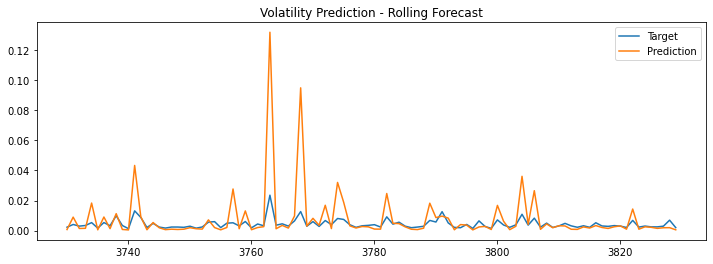

In [146]:
plt.figure(figsize=(12,4))
plt.plot(df_joined[-100:]['target'])
plt.plot(df_joined[-100:]['pred'])
plt.title('Volatility Prediction - Rolling Forecast')
plt.legend(['Target', 'Prediction'])
plt.show()

In [147]:
from sklearn.metrics import r2_score
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))
R2 = round(r2_score(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
RMSPE = round(rmspe(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
print(f'Performance of the GARCH prediction: R2 score: {R2}, RMSPE: {RMSPE}')

Performance of the GARCH prediction: R2 score: -15.164, RMSPE: 1.083
